In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import pandas as pd
import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
HOME = os.path.join(os.path.dirname(os.getcwd()), 'results/e2e_profs_new_metrics')
print HOME

/Users/cusgadmin/Desktop/plots-model-comp-paper/results/e2e_profs_new_metrics


In [165]:
import unicodedata
        
def cache_extractions(FN, timestamps=False):
    with open(FN) as json_data:
        d = json.load(json_data)
    all_metrics = d["client_metrics"][0]["all_metrics"]
    result = {}
    for i in range(len(all_metrics)):
        data_lists = all_metrics[i]["data_lists"]
        for item in data_lists:
            key = item.keys()[0]
            key = unicodedata.normalize('NFKD', key).encode('ascii','ignore')
            if result.get(key) == None:
                result[key] = []
            if timestamps:
                data = item[key]["items"]
                data = { k: v for d in data for k, v in d.items() } # consolidate list of dicts
                value = np.concatenate([np.transpose([data.keys()]), np.transpose([data.values()])], axis = 1).astype(float)
            else:
                value = np.asarray(item[key]["items"]).astype(float)
                value = np.concatenate([np.transpose([np.arange(len(value))]), np.transpose([value])], axis = 1).astype(float)
            result[key].append(value)
    import re
    client_timestamps = {}
    for k,v in d["client_metrics"][0].iteritems():
        if re.compile(".+->.+_timestamps").match(k):
            client_timestamps[str(k)] = np.asarray(v)     
    batch_sizes = d["client_metrics"][0]["mean_batch_sizes"]
    for key, value in result.iteritems():
        result[key] = np.concatenate(value)
    str_lats = d["client_metrics"][0]["all_lats"]
    import ast
    lats = [ast.literal_eval(x) for x in str_lats]
    hollistic_data = {}
    hollistic_data["e2e_lats"] = np.asarray(lats).flatten()
    hollistic_data["p99_lats"] = d["client_metrics"][0]["p99_lats"]
    hollistic_data["e2e_thrus"] = d["client_metrics"][0]["thrus"]
    hollistic_data["client_timestamps"] = client_timestamps
    
    return result, hollistic_data

image_driver_1_models = [
    "tf-resnet-feats",
    "tf-log-reg",
    "tf-kernel-svm",
    "inception"
]

ID1_500, ID1_500_hollistic = cache_extractions(HOME+"/"+"incep_1-logreg_1-ksvm_1-resnet_1-180312_012713.json", timestamps=True)

def clean_extraction(extraction):
    # taking off the first 25% of the records to be sure the warmup time is removed
    for key, value in extraction.iteritems():
        sorted_timestamps = np.argsort(value[:,0])
        value = value[sorted_timestamps] # sort data by timestamps
        extraction[key] = value[value.shape[0]/20:] # cut off the first fourth from warmup effects

clean_extraction(ID1_500)
clean_extraction(ID1_500_resnet2)
        
for key, value in ID1_500_resnet2.iteritems():
    print key, value.shape

tf-resnet-feats:1:queue_sizes (38859, 2)
app:tf-kernel-svm:prediction_latencies (25658, 2)
tf-kernel-svm:processing_latency (25659, 2)
model:tf-resnet-feats:1:prediction_latencies_list (13211, 2)
tf-kernel-svm:1:queue_arrivals (25661, 2)
app:tf-resnet-feats:prediction_latencies (25529, 2)
model:inception:1:prediction_latencies_list (16183, 2)
tf-log-reg:processing_latency (25666, 2)
app:inception:prediction_latencies (25527, 2)
inception:1:queue_sizes (41822, 2)
app:tf-log-reg:prediction_latencies (25663, 2)
model:tf-log-reg:1:prediction_latencies_list (25666, 2)
tf-resnet-feats:processing_latency (13210, 2)
tf-resnet-feats:1:processing_outs (21600, 2)
tf-resnet-feats:1:queue_arrivals (25658, 2)
tf-kernel-svm:1:queue_sizes (51317, 2)
tf-log-reg:1:queue_arrivals (25666, 2)
inception:processing_latency (16180, 2)
tf-log-reg:1:queue_sizes (51330, 2)
tf-log-reg:1:processing_outs (25666, 2)
tf-kernel-svm:1:processing_outs (25660, 2)
inception:1:queue_arrivals (25660, 2)
inception:1:processi

In [170]:
import seaborn as sns

def smoothLineHistogram(data, rug=False, label=None):
    sns.distplot(data, rug=rug, label=label)

def lineHistogram(data, label=None):
    y,binEdges=np.histogram(data)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters,y,'-', label=label)
    
def compare_latency_dists(cached_extractions, model_list):
    plt.figure(figsize=(5*len(model_list),5))
    for i, model in enumerate(model_list):
        plt.subplot(1, len(model_list), i+1)
        plt.title(model+" Processing Latency")
        plt.xlabel("Time (ms)")
        plt.ylabel("Frequency")
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        processing_time = processing_time[processing_time<1e3]
        serving_time = serving_time[serving_time<1e3]
        smoothLineHistogram(processing_time, label="Processing time")
        smoothLineHistogram(serving_time, label="Processing + Queueing time")
    plt.legend()

def compare_latency_dists_over_time(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        processing_time = cached_extractions[model+":processing_latency"][:,1]
        processing_time_timestamps = cached_extractions[model+":processing_latency"][:,0]
        serving_time = cached_extractions["app:"+model+":prediction_latencies"][:,1]
        serving_time = serving_time/1000 # converting to ms
        serving_time_timestamps = cached_extractions["app:"+model+":prediction_latencies"][:,0]
        plt.title(model+" Processing Latency")
        plt.xlabel("timestamp since begining of experiment")
        plt.ylabel("Latency (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([min(np.min(processing_time),np.min(serving_time)), max(np.max(processing_time),np.max(serving_time))])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(processing_time_timestamps, processing_time, alpha = 0.15)
        plt.scatter(serving_time_timestamps, serving_time, alpha = 0.01)

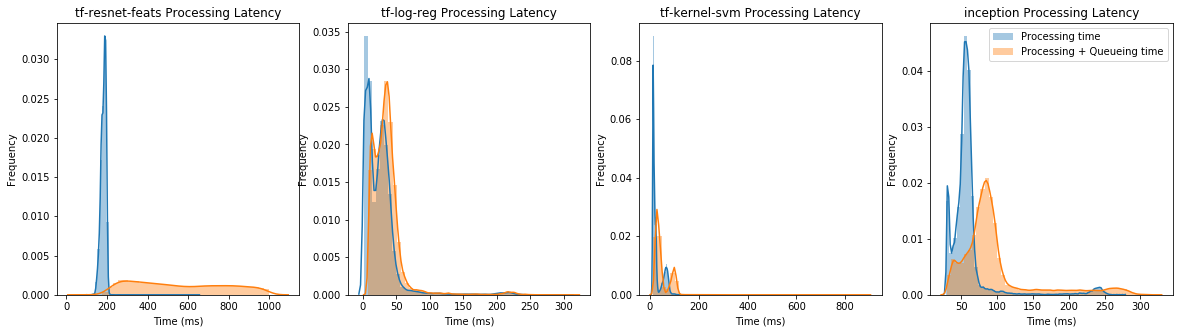

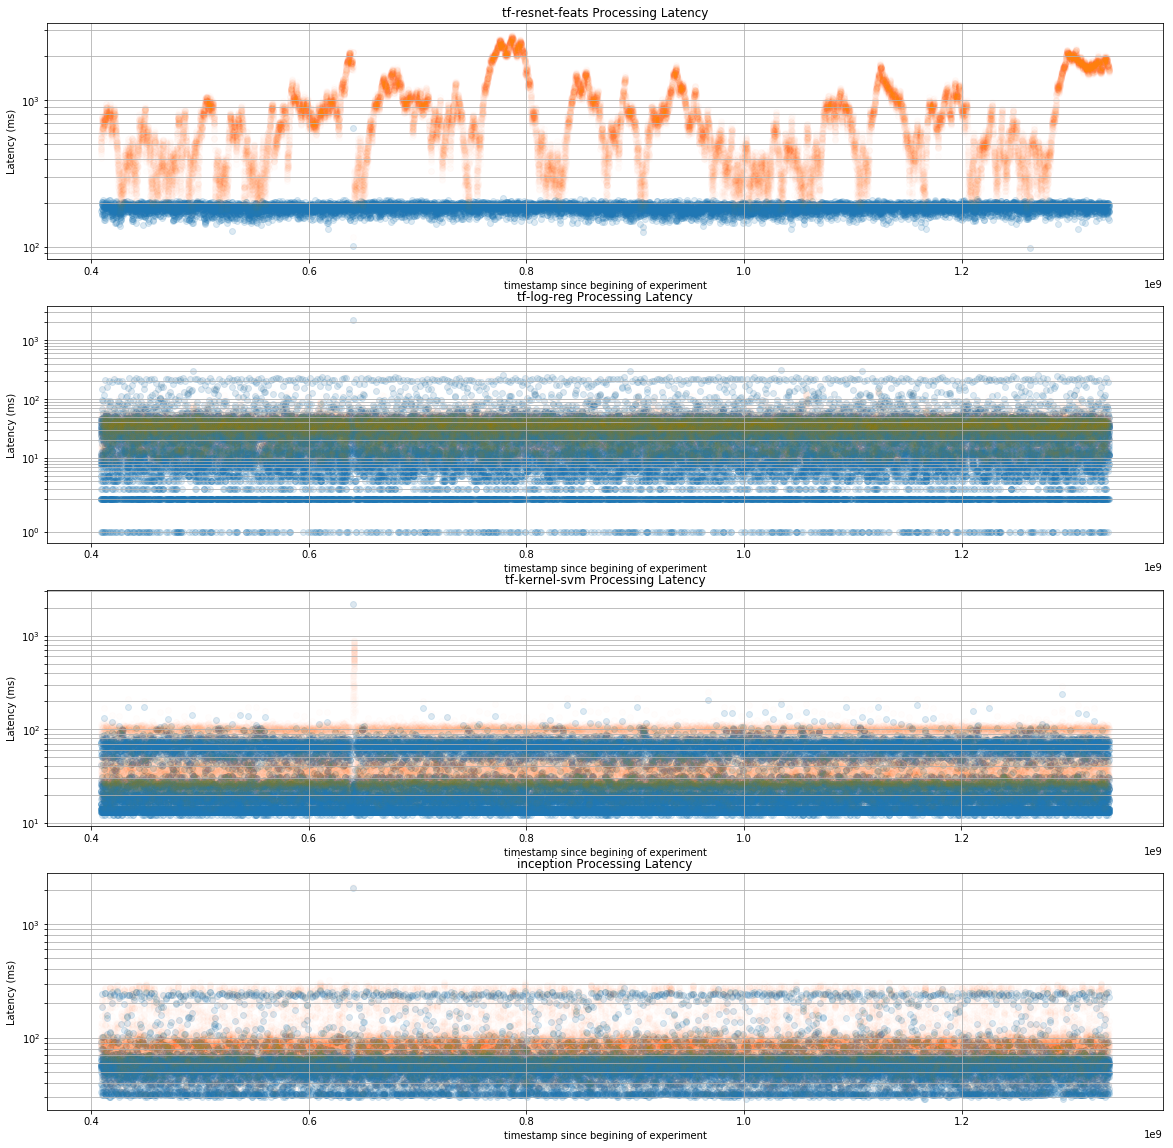

In [171]:
compare_latency_dists(ID1_500, image_driver_1_models)
compare_latency_dists_over_time(ID1_500, image_driver_1_models)

In [10]:
def get_intervals(cached_extractions, model, intra_batch_arrivals):
    arrivals = cached_extractions[model+":1:queue_arrivals"][:,1]
    timestamps = cached_extractions[model+":1:queue_arrivals"][:,0]
    timestamps = timestamps[1:] # taking the timestamp at arrival
    intervals = arrivals[1:] - arrivals[:-1]
    intervals = intervals/1000 # to ms
    if not intra_batch_arrivals:
        minimum_processing_time = np.min(cached_extractions[model+":processing_latency"][:,1])
        MIN = 2.5
        if minimum_processing_time < MIN:
            print "{model} processing time is too low (<{MIN}ms) to acceptably discern inter and intra batch arrivals".format(model=model, MIN=MIN)
            return intervals, timestamps # minimum processing time too close to the cut off, might be getting rid of inter-batch arrivals
        cutoff = MIN
        assert len(intervals) == len(timestamps)
        num_below = np.sum((intervals < cutoff).astype(int))
        above_mask = intervals >= cutoff
        intervals = intervals[above_mask]
        timestamps = timestamps[above_mask]
        print "{model}: Removed {num} points below {time} ms".format(model=model, num=num_below, time=cutoff)
    return intervals, timestamps
    
def plot_inter_arrival(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(8,8))
    plt.title("Inter-arrival time")
    plt.xlabel("Inter-arrival time (ms)")
    plt.ylabel("Frequency")
    for model in model_list:
        intervals, _ = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        smoothLineHistogram(intervals, label=model+str(" CV="+str(CV)))
    plt.legend()
    plt.show()

def plot_inter_arrival_over_time(cached_extractions, model_list, intra_batch_arrivals=True):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        intervals, timestamps = get_intervals(cached_extractions, model, intra_batch_arrivals)
        CV = np.var(intervals)/np.square(np.mean(intervals))
        plt.title(model+" Inter-arrival time")
        plt.xlabel("Position")
        plt.ylabel("Inter-arrival time (ms)")
        needlog = True #np.max(intervals) - np.min(intervals) > 10
        bounds = np.asarray([np.min(intervals), np.max(intervals)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, intervals, label="CV="+str(CV), alpha = 0.3)
        plt.legend()
    plt.show()


In [ ]:
plot_inter_arrival_over_time(ID1_500, image_driver_1_models, intra_batch_arrivals=True)
plot_inter_arrival(ID1_500, image_driver_1_models, intra_batch_arrivals=True)

In [123]:
def plot_queue_sizes(cached_extractions, model_list, log=False):
    plt.figure(figsize=(8,8))
    plt.title("Queue length")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    if log:
        plt.xscale("log")
    for model in model_list:
        sizes = cached_extractions[model+":1:queue_sizes"]
        plt.hist(sizes, label=model,alpha=0.3)
    plt.legend()
    
def plot_ordinal_queue_sizes(cached_extractions, model_list):
    plt.figure(figsize=(20, 5*len(model_list)))
    for i, model in enumerate(model_list):
        ax = plt.subplot(len(model_list), 1, i+1)
        sizes = cached_extractions[model+":1:queue_sizes"][:,1]
        timestamps = cached_extractions[model+":1:queue_sizes"][:,0]
        plt.title(model+" Queue length")
        plt.xlabel("Position")
        plt.ylabel("Length")
        needlog = np.max(sizes) - np.min(sizes) > 10
        bounds = np.asarray([np.min(sizes), np.max(sizes)])
        if needlog:
            plt.yscale('symlog')
            from matplotlib.ticker import SymmetricalLogLocator
            ax.yaxis.set_major_locator(SymmetricalLogLocator(linthresh = 1, base=10.0, subs=np.arange(10)))
        ax.grid()
        plt.scatter(timestamps, sizes, label=model, alpha = 0.3)

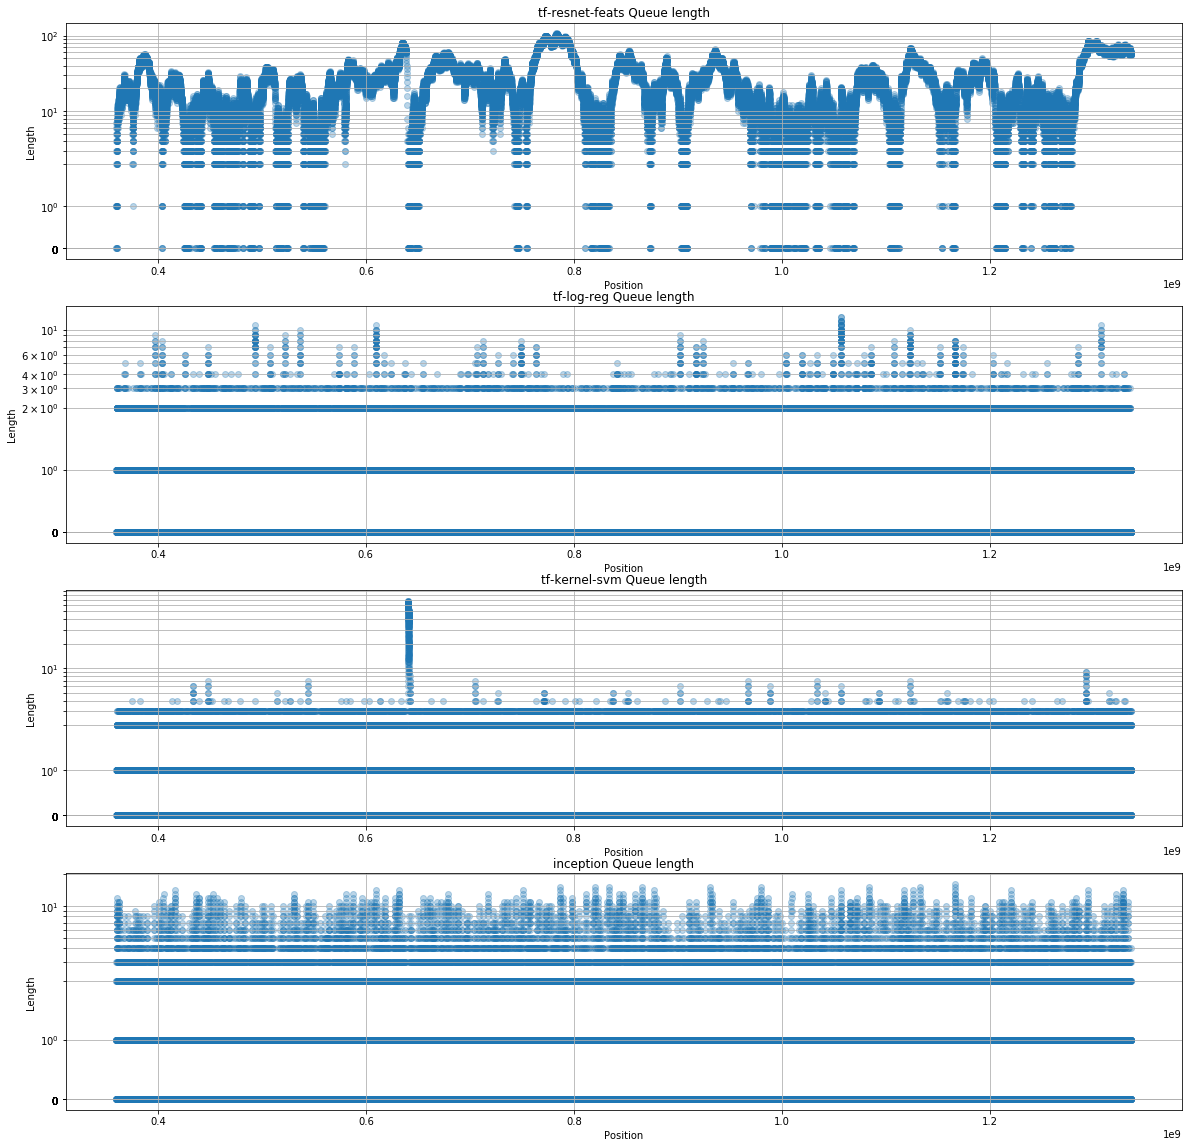

In [156]:
plot_ordinal_queue_sizes(ID1_500, image_driver_1_models)

In [104]:
def plot_e2e_lats(cached_extractions):
    plt.figure(figsize=(8,8))
    plt.title("e2e Latencies")
    lats = cached_extractions["e2e_lats"]
    plt.scatter(np.arange(len(lats)), lats)
    plt.xlabel("Experiment iteration")
    plt.axhline(y=0.5, color='r', linestyle='--', )
    plt.ylabel("Latency (ms)")

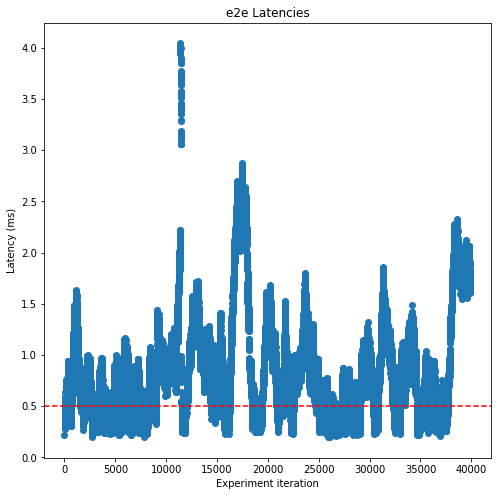

In [105]:
plot_e2e_lats(ID1_500_hollistic)

In [137]:
def get_max_curve(timestamps, trial_range):
    def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            if contained_currently > max_so_far:
                max_so_far = contained_currently
        return max_so_far
    y_axis = np.asarray([get_smallest_delta_2(float(i), timestamps) for i in trial_range])
    x_axis = np.asarray(list(trial_range))
    return x_axis, y_axis

In [135]:
[(k, len(v)) for k,v in ID1_500_hollistic["client_timestamps"].iteritems()]

[('start->tf-resnet-feats_timestamps', 40000),
 ('inception->tf-log-reg_timestamps', 39998),
 ('start->inception_timestamps', 40000),
 ('tf-kernel-svm->join_timestamps', 39998),
 ('join->end_timestamps', 39997),
 ('tf-log-reg->join_timestamps', 39997),
 ('tf-resnet-feats->tf-kernel-svm_timestamps', 39999)]

In [150]:
x_range = xrange(1,45000,200)
resnet_arrival = ID1_500_hollistic["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
resnet_departure = ID1_500_hollistic["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet, y_arrival_resnet = get_max_curve(resnet_arrival, x_range)
x_departure_resnet, y_departure_resnet = get_max_curve(resnet_departure, x_range)

In [141]:
def get_smallest_delta_2(time_range, timestamps):
        head_index = 0 # the first index less than or equal to time_range's higher end
        tail_index = 0 # the first index less than or equal to time_range's lower end
        position = 'tail' # start when time_range's lower end (tail) is aligned with a point
        contained_currently = 1 # a single point (the first index) must be contained in the time_range
        # add the rest of the timepoints contained in time_range
        for i in xrange(tail_index+1, len(timestamps)):
            if timestamps[i] <= timestamps[tail_index] + time_range:
                contained_currently+=1
                head_index+=1
            else:
                break
        max_so_far = contained_currently
        while head_index < len(timestamps)-1: # this means time_range's higher end hasn't exceeded the very last timestamp
            if position == "tail":
                head_time_position = timestamps[tail_index] + time_range
                head_delta = timestamps[head_index+1] - head_time_position
                assert head_delta > 0 or np.isclose(head_delta, 0)
                tail_delta = timestamps[tail_index+1] - timestamps[tail_index]
            elif position == "head":
                tail_time_position = timestamps[head_index] - time_range
                tail_delta = timestamps[tail_index+1] - tail_time_position
                assert tail_delta >= 0  or np.isclose(tail_delta, 0)
                head_delta = timestamps[head_index+1] - timestamps[head_index]
            if tail_delta < head_delta:
                position = "tail"
                tail_index = tail_index + 1 # head_index stays the same
                contained_currently-=1
            elif head_delta <= tail_delta:
                position = "head"
                head_index = head_index + 1 # tail_index stays the same
                contained_currently+=1
            assert contained_currently >= head_index-tail_index
            print tail_index, head_index, position, contained_currently, max_so_far
            if contained_currently > max_so_far:
                best_position = position, tail_index, head_index
                max_so_far = contained_currently
        return max_so_far

get_smallest_delta_2(26, resnet_departure)

0 1 head 2 1
1 1 tail 1 2
1 2 head 2 2
1 3 head 3 2
1 4 head 4 3
1 5 head 5 4
2 5 tail 4 5
3 5 tail 3 5
4 5 tail 2 5
5 5 tail 1 5
5 6 head 2 5
5 7 head 3 5
5 8 head 4 5
5 9 head 5 5
6 9 tail 4 5
7 9 tail 3 5
8 9 tail 2 5
9 9 tail 1 5
9 10 head 2 5
9 11 head 3 5
9 12 head 4 5
9 13 head 5 5
10 13 tail 4 5
11 13 tail 3 5
12 13 tail 2 5
13 13 tail 1 5
13 14 head 2 5
13 15 head 3 5
13 16 head 4 5
13 17 head 5 5
14 17 tail 4 5
15 17 tail 3 5
16 17 tail 2 5
17 17 tail 1 5
17 18 head 2 5
17 19 head 3 5
17 20 head 4 5
17 21 head 5 5
18 21 tail 4 5
19 21 tail 3 5
20 21 tail 2 5
21 21 tail 1 5
21 22 head 2 5
21 23 head 3 5
22 23 tail 2 5
23 23 tail 1 5
23 24 head 2 5
23 25 head 3 5
23 26 head 4 5
23 27 head 5 5
24 27 tail 4 5
25 27 tail 3 5
26 27 tail 2 5
27 27 tail 1 5
27 28 head 2 5
27 29 head 3 5
27 30 head 4 5
27 31 head 5 5
28 31 tail 4 5
29 31 tail 3 5
30 31 tail 2 5
31 31 tail 1 5
31 32 head 2 5
31 33 head 3 5
31 34 head 4 5
31 35 head 5 5
32 35 tail 4 5
33 35 tail 3 5
34 35 tail 2 5
35 35

327 328 head 2 5
327 329 head 3 5
327 330 head 4 5
327 331 head 5 5
328 331 tail 4 5
329 331 tail 3 5
330 331 tail 2 5
331 331 tail 1 5
331 332 head 2 5
331 333 head 3 5
331 334 head 4 5
331 335 head 5 5
332 335 tail 4 5
333 335 tail 3 5
334 335 tail 2 5
335 335 tail 1 5
335 336 head 2 5
335 337 head 3 5
335 338 head 4 5
335 339 head 5 5
336 339 tail 4 5
337 339 tail 3 5
338 339 tail 2 5
339 339 tail 1 5
339 340 head 2 5
339 341 head 3 5
339 342 head 4 5
339 343 head 5 5
340 343 tail 4 5
341 343 tail 3 5
342 343 tail 2 5
343 343 tail 1 5
343 344 head 2 5
343 345 head 3 5
343 346 head 4 5
343 347 head 5 5
344 347 tail 4 5
345 347 tail 3 5
346 347 tail 2 5
347 347 tail 1 5
347 348 head 2 5
347 349 head 3 5
347 350 head 4 5
347 351 head 5 5
348 351 tail 4 5
349 351 tail 3 5
350 351 tail 2 5
351 351 tail 1 5
351 352 head 2 5
351 353 head 3 5
351 354 head 4 5
351 355 head 5 5
352 355 tail 4 5
353 355 tail 3 5
354 355 tail 2 5
355 355 tail 1 5
355 356 head 2 5
355 357 head 3 5
355 358 head 4

631 634 head 4 6
631 635 head 5 6
632 635 tail 4 6
633 635 tail 3 6
634 635 tail 2 6
635 635 tail 1 6
635 636 head 2 6
635 637 head 3 6
635 638 head 4 6
635 639 head 5 6
636 639 tail 4 6
637 639 tail 3 6
638 639 tail 2 6
639 639 tail 1 6
639 640 head 2 6
639 641 head 3 6
639 642 head 4 6
639 643 head 5 6
640 643 tail 4 6
641 643 tail 3 6
642 643 tail 2 6
643 643 tail 1 6
643 644 head 2 6
643 645 head 3 6
643 646 head 4 6
643 647 head 5 6
644 647 tail 4 6
645 647 tail 3 6
646 647 tail 2 6
647 647 tail 1 6
647 648 head 2 6
647 649 head 3 6
647 650 head 4 6
647 651 head 5 6
648 651 tail 4 6
649 651 tail 3 6
650 651 tail 2 6
651 651 tail 1 6
651 652 head 2 6
651 653 head 3 6
651 654 head 4 6
651 655 head 5 6
652 655 tail 4 6
653 655 tail 3 6
654 655 tail 2 6
655 655 tail 1 6
655 656 head 2 6
655 657 head 3 6
655 658 head 4 6
655 659 head 5 6
656 659 tail 4 6
657 659 tail 3 6
658 659 tail 2 6
659 659 tail 1 6
659 660 head 2 6
659 661 head 3 6
659 662 head 4 6
659 663 head 5 6
660 663 tail 4

927 931 head 5 6
928 931 tail 4 6
929 931 tail 3 6
930 931 tail 2 6
931 931 tail 1 6
931 932 head 2 6
931 933 head 3 6
931 934 head 4 6
931 935 head 5 6
932 935 tail 4 6
933 935 tail 3 6
934 935 tail 2 6
935 935 tail 1 6
935 936 head 2 6
935 937 head 3 6
935 938 head 4 6
935 939 head 5 6
936 939 tail 4 6
937 939 tail 3 6
938 939 tail 2 6
939 939 tail 1 6
939 940 head 2 6
939 941 head 3 6
939 942 head 4 6
939 943 head 5 6
940 943 tail 4 6
941 943 tail 3 6
942 943 tail 2 6
943 943 tail 1 6
943 944 head 2 6
943 945 head 3 6
943 946 head 4 6
943 947 head 5 6
944 947 tail 4 6
945 947 tail 3 6
946 947 tail 2 6
947 947 tail 1 6
947 948 head 2 6
947 949 head 3 6
947 950 head 4 6
947 951 head 5 6
948 951 tail 4 6
949 951 tail 3 6
950 951 tail 2 6
951 951 tail 1 6
951 952 head 2 6
951 953 head 3 6
951 954 head 4 6
951 955 head 5 6
952 955 tail 4 6
953 955 tail 3 6
954 955 tail 2 6
955 955 tail 1 6
955 956 head 2 6
955 957 head 3 6
955 958 head 4 6
955 959 head 5 6
956 959 tail 4 6
957 959 tail 3

1231 1235 head 5 6
1232 1235 tail 4 6
1233 1235 tail 3 6
1234 1235 tail 2 6
1235 1235 tail 1 6
1235 1236 head 2 6
1235 1237 head 3 6
1235 1238 head 4 6
1235 1239 head 5 6
1236 1239 tail 4 6
1237 1239 tail 3 6
1238 1239 tail 2 6
1239 1239 tail 1 6
1239 1240 head 2 6
1239 1241 head 3 6
1239 1242 head 4 6
1239 1243 head 5 6
1240 1243 tail 4 6
1241 1243 tail 3 6
1242 1243 tail 2 6
1243 1243 tail 1 6
1243 1244 head 2 6
1243 1245 head 3 6
1243 1246 head 4 6
1243 1247 head 5 6
1244 1247 tail 4 6
1245 1247 tail 3 6
1246 1247 tail 2 6
1247 1247 tail 1 6
1247 1248 head 2 6
1247 1249 head 3 6
1247 1250 head 4 6
1247 1251 head 5 6
1248 1251 tail 4 6
1249 1251 tail 3 6
1250 1251 tail 2 6
1251 1251 tail 1 6
1251 1252 head 2 6
1251 1253 head 3 6
1251 1254 head 4 6
1251 1255 head 5 6
1252 1255 tail 4 6
1253 1255 tail 3 6
1254 1255 tail 2 6
1255 1255 tail 1 6
1255 1256 head 2 6
1255 1257 head 3 6
1255 1258 head 4 6
1255 1259 head 5 6
1256 1259 tail 4 6
1257 1259 tail 3 6
1258 1259 tail 2 6
1259 1259 ta

1532 1535 tail 4 6
1533 1535 tail 3 6
1534 1535 tail 2 6
1535 1535 tail 1 6
1535 1536 head 2 6
1535 1537 head 3 6
1535 1538 head 4 6
1535 1539 head 5 6
1536 1539 tail 4 6
1537 1539 tail 3 6
1538 1539 tail 2 6
1539 1539 tail 1 6
1539 1540 head 2 6
1539 1541 head 3 6
1539 1542 head 4 6
1539 1543 head 5 6
1540 1543 tail 4 6
1541 1543 tail 3 6
1542 1543 tail 2 6
1543 1543 tail 1 6
1543 1544 head 2 6
1543 1545 head 3 6
1543 1546 head 4 6
1543 1547 head 5 6
1544 1547 tail 4 6
1545 1547 tail 3 6
1546 1547 tail 2 6
1547 1547 tail 1 6
1547 1548 head 2 6
1547 1549 head 3 6
1547 1550 head 4 6
1547 1551 head 5 6
1548 1551 tail 4 6
1549 1551 tail 3 6
1550 1551 tail 2 6
1551 1551 tail 1 6
1551 1552 head 2 6
1551 1553 head 3 6
1551 1554 head 4 6
1551 1555 head 5 6
1552 1555 tail 4 6
1553 1555 tail 3 6
1554 1555 tail 2 6
1555 1555 tail 1 6
1555 1556 head 2 6
1555 1557 head 3 6
1555 1558 head 4 6
1555 1559 head 5 6
1556 1559 tail 4 6
1557 1559 tail 3 6
1558 1559 tail 2 6
1559 1559 tail 1 6
1559 1560 he

1771 1771 tail 1 6
1771 1772 head 2 6
1771 1773 head 3 6
1771 1774 head 4 6
1771 1775 head 5 6
1772 1775 tail 4 6
1773 1775 tail 3 6
1774 1775 tail 2 6
1775 1775 tail 1 6
1775 1776 head 2 6
1775 1777 head 3 6
1775 1778 head 4 6
1775 1779 head 5 6
1776 1779 tail 4 6
1777 1779 tail 3 6
1778 1779 tail 2 6
1779 1779 tail 1 6
1779 1780 head 2 6
1779 1781 head 3 6
1779 1782 head 4 6
1779 1783 head 5 6
1780 1783 tail 4 6
1781 1783 tail 3 6
1782 1783 tail 2 6
1783 1783 tail 1 6
1783 1784 head 2 6
1783 1785 head 3 6
1783 1786 head 4 6
1783 1787 head 5 6
1784 1787 tail 4 6
1785 1787 tail 3 6
1786 1787 tail 2 6
1787 1787 tail 1 6
1787 1788 head 2 6
1787 1789 head 3 6
1787 1790 head 4 6
1787 1791 head 5 6
1788 1791 tail 4 6
1789 1791 tail 3 6
1790 1791 tail 2 6
1791 1791 tail 1 6
1791 1792 head 2 6
1791 1793 head 3 6
1791 1794 head 4 6
1791 1795 head 5 6
1792 1795 tail 4 6
1793 1795 tail 3 6
1794 1795 tail 2 6
1795 1795 tail 1 6
1795 1796 head 2 6
1795 1797 head 3 6
1795 1798 head 4 6
1795 1799 he

2082 2085 tail 4 6
2083 2085 tail 3 6
2084 2085 tail 2 6
2085 2085 tail 1 6
2085 2086 head 2 6
2085 2087 head 3 6
2085 2088 head 4 6
2085 2089 head 5 6
2086 2089 tail 4 6
2087 2089 tail 3 6
2088 2089 tail 2 6
2089 2089 tail 1 6
2089 2090 head 2 6
2089 2091 head 3 6
2089 2092 head 4 6
2089 2093 head 5 6
2090 2093 tail 4 6
2091 2093 tail 3 6
2092 2093 tail 2 6
2093 2093 tail 1 6
2093 2094 head 2 6
2093 2095 head 3 6
2093 2096 head 4 6
2093 2097 head 5 6
2094 2097 tail 4 6
2095 2097 tail 3 6
2096 2097 tail 2 6
2097 2097 tail 1 6
2097 2098 head 2 6
2097 2099 head 3 6
2097 2100 head 4 6
2097 2101 head 5 6
2098 2101 tail 4 6
2099 2101 tail 3 6
2100 2101 tail 2 6
2101 2101 tail 1 6
2101 2102 head 2 6
2101 2103 head 3 6
2101 2104 head 4 6
2101 2105 head 5 6
2102 2105 tail 4 6
2103 2105 tail 3 6
2104 2105 tail 2 6
2105 2105 tail 1 6
2105 2106 head 2 6
2105 2107 head 3 6
2105 2108 head 4 6
2105 2109 head 5 6
2106 2109 tail 4 6
2107 2109 tail 3 6
2108 2109 tail 2 6
2109 2109 tail 1 6
2109 2110 he

2385 2386 head 2 6
2385 2387 head 3 6
2385 2388 head 4 6
2385 2389 head 5 6
2386 2389 tail 4 6
2387 2389 tail 3 6
2388 2389 tail 2 6
2389 2389 tail 1 6
2389 2390 head 2 6
2389 2391 head 3 6
2389 2392 head 4 6
2389 2393 head 5 6
2390 2393 tail 4 6
2391 2393 tail 3 6
2392 2393 tail 2 6
2393 2393 tail 1 6
2393 2394 head 2 6
2393 2395 head 3 6
2393 2396 head 4 6
2393 2397 head 5 6
2394 2397 tail 4 6
2395 2397 tail 3 6
2396 2397 tail 2 6
2397 2397 tail 1 6
2397 2398 head 2 6
2397 2399 head 3 6
2397 2400 head 4 6
2397 2401 head 5 6
2398 2401 tail 4 6
2399 2401 tail 3 6
2400 2401 tail 2 6
2401 2401 tail 1 6
2401 2402 head 2 6
2401 2403 head 3 6
2401 2404 head 4 6
2401 2405 head 5 6
2401 2406 head 6 6
2401 2407 head 7 6
2401 2408 head 8 7
2402 2408 tail 7 8
2403 2408 tail 6 8
2404 2408 tail 5 8
2405 2408 tail 4 8
2405 2409 head 5 8
2406 2409 tail 4 8
2407 2409 tail 3 8
2408 2409 tail 2 8
2409 2409 tail 1 8
2409 2410 head 2 8
2409 2411 head 3 8
2409 2412 head 4 8
2409 2413 head 5 8
2410 2413 ta

2688 2689 tail 2 8
2689 2689 tail 1 8
2689 2690 head 2 8
2689 2691 head 3 8
2689 2692 head 4 8
2689 2693 head 5 8
2690 2693 tail 4 8
2691 2693 tail 3 8
2692 2693 tail 2 8
2693 2693 tail 1 8
2693 2694 head 2 8
2693 2695 head 3 8
2693 2696 head 4 8
2693 2697 head 5 8
2694 2697 tail 4 8
2695 2697 tail 3 8
2696 2697 tail 2 8
2697 2697 tail 1 8
2697 2698 head 2 8
2697 2699 head 3 8
2697 2700 head 4 8
2697 2701 head 5 8
2698 2701 tail 4 8
2699 2701 tail 3 8
2700 2701 tail 2 8
2701 2701 tail 1 8
2701 2702 head 2 8
2701 2703 head 3 8
2701 2704 head 4 8
2702 2704 tail 3 8
2703 2704 tail 2 8
2704 2704 tail 1 8
2704 2705 head 2 8
2704 2706 head 3 8
2704 2707 head 4 8
2704 2708 head 5 8
2705 2708 tail 4 8
2706 2708 tail 3 8
2707 2708 tail 2 8
2708 2708 tail 1 8
2708 2709 head 2 8
2708 2710 head 3 8
2708 2711 head 4 8
2709 2711 tail 3 8
2710 2711 tail 2 8
2711 2711 tail 1 8
2711 2712 head 2 8
2711 2713 head 3 8
2712 2713 tail 2 8
2713 2713 tail 1 8
2713 2714 head 2 8
2713 2715 head 3 8
2713 2716 he

2978 2980 tail 3 8
2979 2980 tail 2 8
2980 2980 tail 1 8
2980 2981 head 2 8
2980 2982 head 3 8
2980 2983 head 4 8
2980 2984 head 5 8
2981 2984 tail 4 8
2982 2984 tail 3 8
2983 2984 tail 2 8
2984 2984 tail 1 8
2984 2985 head 2 8
2984 2986 head 3 8
2984 2987 head 4 8
2984 2988 head 5 8
2985 2988 tail 4 8
2986 2988 tail 3 8
2987 2988 tail 2 8
2988 2988 tail 1 8
2988 2989 head 2 8
2988 2990 head 3 8
2988 2991 head 4 8
2988 2992 head 5 8
2989 2992 tail 4 8
2990 2992 tail 3 8
2991 2992 tail 2 8
2992 2992 tail 1 8
2992 2993 head 2 8
2992 2994 head 3 8
2992 2995 head 4 8
2992 2996 head 5 8
2993 2996 tail 4 8
2994 2996 tail 3 8
2995 2996 tail 2 8
2996 2996 tail 1 8
2996 2997 head 2 8
2996 2998 head 3 8
2996 2999 head 4 8
2996 3000 head 5 8
2997 3000 tail 4 8
2998 3000 tail 3 8
2999 3000 tail 2 8
3000 3000 tail 1 8
3000 3001 head 2 8
3000 3002 head 3 8
3000 3003 head 4 8
3000 3004 head 5 8
3000 3005 head 6 8
3000 3006 head 7 8
3000 3007 head 8 8
3000 3008 head 9 8
3001 3008 tail 8 9
3002 3008 ta

3278 3280 head 3 9
3278 3281 head 4 9
3278 3282 head 5 9
3279 3282 tail 4 9
3280 3282 tail 3 9
3281 3282 tail 2 9
3282 3282 tail 1 9
3282 3283 head 2 9
3282 3284 head 3 9
3282 3285 head 4 9
3282 3286 head 5 9
3283 3286 tail 4 9
3284 3286 tail 3 9
3285 3286 tail 2 9
3286 3286 tail 1 9
3286 3287 head 2 9
3286 3288 head 3 9
3286 3289 head 4 9
3286 3290 head 5 9
3287 3290 tail 4 9
3288 3290 tail 3 9
3289 3290 tail 2 9
3290 3290 tail 1 9
3290 3291 head 2 9
3290 3292 head 3 9
3290 3293 head 4 9
3290 3294 head 5 9
3291 3294 tail 4 9
3292 3294 tail 3 9
3293 3294 tail 2 9
3294 3294 tail 1 9
3294 3295 head 2 9
3294 3296 head 3 9
3294 3297 head 4 9
3295 3297 tail 3 9
3296 3297 tail 2 9
3297 3297 tail 1 9
3297 3298 head 2 9
3297 3299 head 3 9
3297 3300 head 4 9
3297 3301 head 5 9
3298 3301 tail 4 9
3299 3301 tail 3 9
3300 3301 tail 2 9
3301 3301 tail 1 9
3301 3302 head 2 9
3301 3303 head 3 9
3302 3303 tail 2 9
3303 3303 tail 1 9
3303 3304 head 2 9
3304 3304 tail 1 9
3304 3305 head 2 9
3304 3306 he

3584 3587 head 4 9
3584 3588 head 5 9
3585 3588 tail 4 9
3586 3588 tail 3 9
3587 3588 tail 2 9
3588 3588 tail 1 9
3588 3589 head 2 9
3588 3590 head 3 9
3588 3591 head 4 9
3588 3592 head 5 9
3589 3592 tail 4 9
3590 3592 tail 3 9
3591 3592 tail 2 9
3592 3592 tail 1 9
3592 3593 head 2 9
3592 3594 head 3 9
3592 3595 head 4 9
3592 3596 head 5 9
3593 3596 tail 4 9
3594 3596 tail 3 9
3595 3596 tail 2 9
3596 3596 tail 1 9
3596 3597 head 2 9
3596 3598 head 3 9
3596 3599 head 4 9
3596 3600 head 5 9
3597 3600 tail 4 9
3598 3600 tail 3 9
3599 3600 tail 2 9
3600 3600 tail 1 9
3600 3601 head 2 9
3600 3602 head 3 9
3600 3603 head 4 9
3600 3604 head 5 9
3600 3605 head 6 9
3600 3606 head 7 9
3600 3607 head 8 9
3600 3608 head 9 9
3601 3608 tail 8 9
3602 3608 tail 7 9
3603 3608 tail 6 9
3604 3608 tail 5 9
3605 3608 tail 4 9
3606 3608 tail 3 9
3607 3608 tail 2 9
3608 3608 tail 1 9
3608 3609 head 2 9
3608 3610 head 3 9
3608 3611 head 4 9
3608 3612 head 5 9
3609 3612 tail 4 9
3610 3612 tail 3 9
3611 3612 ta

3891 3895 head 5 9
3892 3895 tail 4 9
3893 3895 tail 3 9
3894 3895 tail 2 9
3895 3895 tail 1 9
3895 3896 head 2 9
3895 3897 head 3 9
3895 3898 head 4 9
3895 3899 head 5 9
3896 3899 tail 4 9
3897 3899 tail 3 9
3898 3899 tail 2 9
3899 3899 tail 1 9
3899 3900 head 2 9
3899 3901 head 3 9
3899 3902 head 4 9
3899 3903 head 5 9
3900 3903 tail 4 9
3901 3903 tail 3 9
3902 3903 tail 2 9
3903 3903 tail 1 9
3903 3904 head 2 9
3903 3905 head 3 9
3903 3906 head 4 9
3904 3906 tail 3 9
3905 3906 tail 2 9
3906 3906 tail 1 9
3906 3907 head 2 9
3906 3908 head 3 9
3906 3909 head 4 9
3907 3909 tail 3 9
3908 3909 tail 2 9
3909 3909 tail 1 9
3909 3910 head 2 9
3909 3911 head 3 9
3909 3912 head 4 9
3910 3912 tail 3 9
3911 3912 tail 2 9
3912 3912 tail 1 9
3912 3913 head 2 9
3912 3914 head 3 9
3912 3915 head 4 9
3912 3916 head 5 9
3913 3916 tail 4 9
3914 3916 tail 3 9
3915 3916 tail 2 9
3916 3916 tail 1 9
3916 3917 head 2 9
3916 3918 head 3 9
3916 3919 head 4 9
3917 3919 tail 3 9
3918 3919 tail 2 9
3919 3919 ta

4186 4189 tail 4 9
4187 4189 tail 3 9
4188 4189 tail 2 9
4189 4189 tail 1 9
4189 4190 head 2 9
4189 4191 head 3 9
4189 4192 head 4 9
4189 4193 head 5 9
4190 4193 tail 4 9
4191 4193 tail 3 9
4192 4193 tail 2 9
4193 4193 tail 1 9
4193 4194 head 2 9
4193 4195 head 3 9
4193 4196 head 4 9
4193 4197 head 5 9
4194 4197 tail 4 9
4195 4197 tail 3 9
4196 4197 tail 2 9
4197 4197 tail 1 9
4197 4198 head 2 9
4197 4199 head 3 9
4197 4200 head 4 9
4197 4201 head 5 9
4198 4201 tail 4 9
4199 4201 tail 3 9
4200 4201 tail 2 9
4201 4201 tail 1 9
4201 4202 head 2 9
4201 4203 head 3 9
4201 4204 head 4 9
4201 4205 head 5 9
4202 4205 tail 4 9
4203 4205 tail 3 9
4204 4205 tail 2 9
4205 4205 tail 1 9
4205 4206 head 2 9
4205 4207 head 3 9
4205 4208 head 4 9
4205 4209 head 5 9
4206 4209 tail 4 9
4207 4209 tail 3 9
4208 4209 tail 2 9
4209 4209 tail 1 9
4209 4210 head 2 9
4209 4211 head 3 9
4209 4212 head 4 9
4209 4213 head 5 9
4210 4213 tail 4 9
4211 4213 tail 3 9
4212 4213 tail 2 9
4213 4213 tail 1 9
4213 4214 he

4494 4495 head 2 9
4494 4496 head 3 9
4494 4497 head 4 9
4494 4498 head 5 9
4495 4498 tail 4 9
4496 4498 tail 3 9
4497 4498 tail 2 9
4498 4498 tail 1 9
4498 4499 head 2 9
4498 4500 head 3 9
4498 4501 head 4 9
4498 4502 head 5 9
4499 4502 tail 4 9
4500 4502 tail 3 9
4501 4502 tail 2 9
4502 4502 tail 1 9
4502 4503 head 2 9
4502 4504 head 3 9
4502 4505 head 4 9
4503 4505 tail 3 9
4504 4505 tail 2 9
4505 4505 tail 1 9
4505 4506 head 2 9
4505 4507 head 3 9
4505 4508 head 4 9
4505 4509 head 5 9
4506 4509 tail 4 9
4507 4509 tail 3 9
4508 4509 tail 2 9
4509 4509 tail 1 9
4509 4510 head 2 9
4509 4511 head 3 9
4509 4512 head 4 9
4510 4512 tail 3 9
4511 4512 tail 2 9
4512 4512 tail 1 9
4512 4513 head 2 9
4512 4514 head 3 9
4513 4514 tail 2 9
4514 4514 tail 1 9
4514 4515 head 2 9
4514 4516 head 3 9
4515 4516 tail 2 9
4516 4516 tail 1 9
4516 4517 head 2 9
4516 4518 head 3 9
4516 4519 head 4 9
4516 4520 head 5 9
4517 4520 tail 4 9
4518 4520 tail 3 9
4519 4520 tail 2 9
4520 4520 tail 1 9
4520 4521 he

4736 4737 tail 2 9
4737 4737 tail 1 9
4737 4738 head 2 9
4737 4739 head 3 9
4737 4740 head 4 9
4737 4741 head 5 9
4738 4741 tail 4 9
4739 4741 tail 3 9
4740 4741 tail 2 9
4741 4741 tail 1 9
4741 4742 head 2 9
4741 4743 head 3 9
4741 4744 head 4 9
4741 4745 head 5 9
4742 4745 tail 4 9
4743 4745 tail 3 9
4744 4745 tail 2 9
4745 4745 tail 1 9
4745 4746 head 2 9
4745 4747 head 3 9
4745 4748 head 4 9
4745 4749 head 5 9
4746 4749 tail 4 9
4747 4749 tail 3 9
4748 4749 tail 2 9
4749 4749 tail 1 9
4749 4750 head 2 9
4749 4751 head 3 9
4749 4752 head 4 9
4749 4753 head 5 9
4750 4753 tail 4 9
4751 4753 tail 3 9
4752 4753 tail 2 9
4753 4753 tail 1 9
4753 4754 head 2 9
4753 4755 head 3 9
4753 4756 head 4 9
4753 4757 head 5 9
4754 4757 tail 4 9
4755 4757 tail 3 9
4756 4757 tail 2 9
4757 4757 tail 1 9
4757 4758 head 2 9
4757 4759 head 3 9
4757 4760 head 4 9
4757 4761 head 5 9
4758 4761 tail 4 9
4759 4761 tail 3 9
4760 4761 tail 2 9
4761 4761 tail 1 9
4761 4762 head 2 9
4761 4763 head 3 9
4761 4764 he

5047 5049 head 3 9
5047 5050 head 4 9
5047 5051 head 5 9
5048 5051 tail 4 9
5049 5051 tail 3 9
5050 5051 tail 2 9
5051 5051 tail 1 9
5051 5052 head 2 9
5051 5053 head 3 9
5051 5054 head 4 9
5051 5055 head 5 9
5052 5055 tail 4 9
5053 5055 tail 3 9
5054 5055 tail 2 9
5055 5055 tail 1 9
5055 5056 head 2 9
5055 5057 head 3 9
5055 5058 head 4 9
5055 5059 head 5 9
5056 5059 tail 4 9
5057 5059 tail 3 9
5058 5059 tail 2 9
5059 5059 tail 1 9
5059 5060 head 2 9
5059 5061 head 3 9
5059 5062 head 4 9
5059 5063 head 5 9
5060 5063 tail 4 9
5061 5063 tail 3 9
5062 5063 tail 2 9
5063 5063 tail 1 9
5063 5064 head 2 9
5063 5065 head 3 9
5063 5066 head 4 9
5063 5067 head 5 9
5064 5067 tail 4 9
5065 5067 tail 3 9
5066 5067 tail 2 9
5067 5067 tail 1 9
5067 5068 head 2 9
5067 5069 head 3 9
5067 5070 head 4 9
5067 5071 head 5 9
5068 5071 tail 4 9
5069 5071 tail 3 9
5070 5071 tail 2 9
5071 5071 tail 1 9
5071 5072 head 2 9
5071 5073 head 3 9
5071 5074 head 4 9
5071 5075 head 5 9
5072 5075 tail 4 9
5073 5075 ta

5338 5340 head 3 9
5338 5341 head 4 9
5339 5341 tail 3 9
5340 5341 tail 2 9
5341 5341 tail 1 9
5341 5342 head 2 9
5341 5343 head 3 9
5341 5344 head 4 9
5342 5344 tail 3 9
5343 5344 tail 2 9
5344 5344 tail 1 9
5344 5345 head 2 9
5344 5346 head 3 9
5344 5347 head 4 9
5345 5347 tail 3 9
5346 5347 tail 2 9
5347 5347 tail 1 9
5347 5348 head 2 9
5347 5349 head 3 9
5347 5350 head 4 9
5348 5350 tail 3 9
5349 5350 tail 2 9
5350 5350 tail 1 9
5350 5351 head 2 9
5350 5352 head 3 9
5351 5352 tail 2 9
5352 5352 tail 1 9
5352 5353 head 2 9
5352 5354 head 3 9
5352 5355 head 4 9
5352 5356 head 5 9
5353 5356 tail 4 9
5354 5356 tail 3 9
5355 5356 tail 2 9
5356 5356 tail 1 9
5356 5357 head 2 9
5356 5358 head 3 9
5356 5359 head 4 9
5356 5360 head 5 9
5357 5360 tail 4 9
5358 5360 tail 3 9
5359 5360 tail 2 9
5360 5360 tail 1 9
5360 5361 head 2 9
5360 5362 head 3 9
5360 5363 head 4 9
5360 5364 head 5 9
5361 5364 tail 4 9
5362 5364 tail 3 9
5363 5364 tail 2 9
5364 5364 tail 1 9
5364 5365 head 2 9
5364 5366 he

5647 5649 head 3 9
5647 5650 head 4 9
5647 5651 head 5 9
5648 5651 tail 4 9
5649 5651 tail 3 9
5650 5651 tail 2 9
5651 5651 tail 1 9
5651 5652 head 2 9
5651 5653 head 3 9
5651 5654 head 4 9
5651 5655 head 5 9
5652 5655 tail 4 9
5653 5655 tail 3 9
5654 5655 tail 2 9
5655 5655 tail 1 9
5655 5656 head 2 9
5655 5657 head 3 9
5655 5658 head 4 9
5655 5659 head 5 9
5656 5659 tail 4 9
5657 5659 tail 3 9
5658 5659 tail 2 9
5659 5659 tail 1 9
5659 5660 head 2 9
5659 5661 head 3 9
5659 5662 head 4 9
5659 5663 head 5 9
5660 5663 tail 4 9
5661 5663 tail 3 9
5662 5663 tail 2 9
5663 5663 tail 1 9
5663 5664 head 2 9
5663 5665 head 3 9
5663 5666 head 4 9
5663 5667 head 5 9
5664 5667 tail 4 9
5665 5667 tail 3 9
5666 5667 tail 2 9
5667 5667 tail 1 9
5667 5668 head 2 9
5667 5669 head 3 9
5667 5670 head 4 9
5667 5671 head 5 9
5668 5671 tail 4 9
5669 5671 tail 3 9
5670 5671 tail 2 9
5671 5671 tail 1 9
5671 5672 head 2 9
5671 5673 head 3 9
5671 5674 head 4 9
5671 5675 head 5 9
5672 5675 tail 4 9
5673 5675 ta

5929 5931 tail 3 9
5930 5931 tail 2 9
5931 5931 tail 1 9
5931 5932 head 2 9
5931 5933 head 3 9
5931 5934 head 4 9
5931 5935 head 5 9
5932 5935 tail 4 9
5933 5935 tail 3 9
5934 5935 tail 2 9
5935 5935 tail 1 9
5935 5936 head 2 9
5935 5937 head 3 9
5935 5938 head 4 9
5935 5939 head 5 9
5936 5939 tail 4 9
5937 5939 tail 3 9
5938 5939 tail 2 9
5939 5939 tail 1 9
5939 5940 head 2 9
5939 5941 head 3 9
5939 5942 head 4 9
5939 5943 head 5 9
5940 5943 tail 4 9
5941 5943 tail 3 9
5942 5943 tail 2 9
5943 5943 tail 1 9
5943 5944 head 2 9
5943 5945 head 3 9
5943 5946 head 4 9
5943 5947 head 5 9
5944 5947 tail 4 9
5945 5947 tail 3 9
5946 5947 tail 2 9
5947 5947 tail 1 9
5947 5948 head 2 9
5947 5949 head 3 9
5947 5950 head 4 9
5947 5951 head 5 9
5948 5951 tail 4 9
5949 5951 tail 3 9
5950 5951 tail 2 9
5951 5951 tail 1 9
5951 5952 head 2 9
5951 5953 head 3 9
5951 5954 head 4 9
5951 5955 head 5 9
5952 5955 tail 4 9
5953 5955 tail 3 9
5954 5955 tail 2 9
5955 5955 tail 1 9
5955 5956 head 2 9
5955 5957 he

6247 6248 head 2 9
6247 6249 head 3 9
6247 6250 head 4 9
6247 6251 head 5 9
6248 6251 tail 4 9
6249 6251 tail 3 9
6250 6251 tail 2 9
6251 6251 tail 1 9
6251 6252 head 2 9
6251 6253 head 3 9
6251 6254 head 4 9
6252 6254 tail 3 9
6253 6254 tail 2 9
6254 6254 tail 1 9
6254 6255 head 2 9
6255 6255 tail 1 9
6255 6256 head 2 9
6255 6257 head 3 9
6255 6258 head 4 9
6255 6259 head 5 9
6256 6259 tail 4 9
6257 6259 tail 3 9
6258 6259 tail 2 9
6259 6259 tail 1 9
6259 6260 head 2 9
6259 6261 head 3 9
6259 6262 head 4 9
6259 6263 head 5 9
6260 6263 tail 4 9
6261 6263 tail 3 9
6262 6263 tail 2 9
6263 6263 tail 1 9
6263 6264 head 2 9
6263 6265 head 3 9
6263 6266 head 4 9
6263 6267 head 5 9
6264 6267 tail 4 9
6265 6267 tail 3 9
6266 6267 tail 2 9
6267 6267 tail 1 9
6267 6268 head 2 9
6267 6269 head 3 9
6267 6270 head 4 9
6267 6271 head 5 9
6268 6271 tail 4 9
6269 6271 tail 3 9
6270 6271 tail 2 9
6271 6271 tail 1 9
6271 6272 head 2 9
6271 6273 head 3 9
6271 6274 head 4 9
6271 6275 head 5 9
6272 6275 ta

6539 6543 head 5 9
6540 6543 tail 4 9
6541 6543 tail 3 9
6542 6543 tail 2 9
6543 6543 tail 1 9
6543 6544 head 2 9
6543 6545 head 3 9
6543 6546 head 4 9
6543 6547 head 5 9
6544 6547 tail 4 9
6545 6547 tail 3 9
6546 6547 tail 2 9
6547 6547 tail 1 9
6547 6548 head 2 9
6547 6549 head 3 9
6547 6550 head 4 9
6547 6551 head 5 9
6548 6551 tail 4 9
6549 6551 tail 3 9
6550 6551 tail 2 9
6551 6551 tail 1 9
6551 6552 head 2 9
6551 6553 head 3 9
6551 6554 head 4 9
6551 6555 head 5 9
6552 6555 tail 4 9
6553 6555 tail 3 9
6554 6555 tail 2 9
6555 6555 tail 1 9
6555 6556 head 2 9
6555 6557 head 3 9
6555 6558 head 4 9
6555 6559 head 5 9
6556 6559 tail 4 9
6557 6559 tail 3 9
6558 6559 tail 2 9
6559 6559 tail 1 9
6559 6560 head 2 9
6559 6561 head 3 9
6559 6562 head 4 9
6559 6563 head 5 9
6560 6563 tail 4 9
6561 6563 tail 3 9
6562 6563 tail 2 9
6563 6563 tail 1 9
6563 6564 head 2 9
6563 6565 head 3 9
6563 6566 head 4 9
6563 6567 head 5 9
6564 6567 tail 4 9
6565 6567 tail 3 9
6566 6567 tail 2 9
6567 6567 ta

6835 6838 head 4 9
6835 6839 head 5 9
6836 6839 tail 4 9
6837 6839 tail 3 9
6838 6839 tail 2 9
6839 6839 tail 1 9
6839 6840 head 2 9
6839 6841 head 3 9
6839 6842 head 4 9
6839 6843 head 5 9
6840 6843 tail 4 9
6841 6843 tail 3 9
6842 6843 tail 2 9
6843 6843 tail 1 9
6843 6844 head 2 9
6843 6845 head 3 9
6843 6846 head 4 9
6843 6847 head 5 9
6844 6847 tail 4 9
6845 6847 tail 3 9
6846 6847 tail 2 9
6847 6847 tail 1 9
6847 6848 head 2 9
6847 6849 head 3 9
6847 6850 head 4 9
6847 6851 head 5 9
6848 6851 tail 4 9
6849 6851 tail 3 9
6850 6851 tail 2 9
6851 6851 tail 1 9
6851 6852 head 2 9
6851 6853 head 3 9
6851 6854 head 4 9
6851 6855 head 5 9
6852 6855 tail 4 9
6853 6855 tail 3 9
6854 6855 tail 2 9
6855 6855 tail 1 9
6855 6856 head 2 9
6855 6857 head 3 9
6855 6858 head 4 9
6855 6859 head 5 9
6856 6859 tail 4 9
6857 6859 tail 3 9
6858 6859 tail 2 9
6859 6859 tail 1 9
6859 6860 head 2 9
6859 6861 head 3 9
6859 6862 head 4 9
6859 6863 head 5 9
6860 6863 tail 4 9
6861 6863 tail 3 9
6862 6863 ta

7143 7143 tail 1 9
7143 7144 head 2 9
7143 7145 head 3 9
7143 7146 head 4 9
7143 7147 head 5 9
7144 7147 tail 4 9
7145 7147 tail 3 9
7146 7147 tail 2 9
7147 7147 tail 1 9
7147 7148 head 2 9
7147 7149 head 3 9
7147 7150 head 4 9
7147 7151 head 5 9
7148 7151 tail 4 9
7149 7151 tail 3 9
7150 7151 tail 2 9
7151 7151 tail 1 9
7151 7152 head 2 9
7151 7153 head 3 9
7151 7154 head 4 9
7151 7155 head 5 9
7152 7155 tail 4 9
7153 7155 tail 3 9
7154 7155 tail 2 9
7155 7155 tail 1 9
7155 7156 head 2 9
7155 7157 head 3 9
7155 7158 head 4 9
7155 7159 head 5 9
7156 7159 tail 4 9
7157 7159 tail 3 9
7158 7159 tail 2 9
7159 7159 tail 1 9
7159 7160 head 2 9
7159 7161 head 3 9
7159 7162 head 4 9
7159 7163 head 5 9
7160 7163 tail 4 9
7161 7163 tail 3 9
7162 7163 tail 2 9
7163 7163 tail 1 9
7163 7164 head 2 9
7163 7165 head 3 9
7163 7166 head 4 9
7163 7167 head 5 9
7164 7167 tail 4 9
7165 7167 tail 3 9
7166 7167 tail 2 9
7167 7167 tail 1 9
7167 7168 head 2 9
7167 7169 head 3 9
7167 7170 head 4 9
7167 7171 he

7367 7369 head 3 9
7367 7370 head 4 9
7367 7371 head 5 9
7368 7371 tail 4 9
7369 7371 tail 3 9
7370 7371 tail 2 9
7371 7371 tail 1 9
7371 7372 head 2 9
7371 7373 head 3 9
7371 7374 head 4 9
7371 7375 head 5 9
7372 7375 tail 4 9
7373 7375 tail 3 9
7374 7375 tail 2 9
7375 7375 tail 1 9
7375 7376 head 2 9
7375 7377 head 3 9
7376 7377 tail 2 9
7377 7377 tail 1 9
7377 7378 head 2 9
7377 7379 head 3 9
7377 7380 head 4 9
7377 7381 head 5 9
7378 7381 tail 4 9
7379 7381 tail 3 9
7380 7381 tail 2 9
7381 7381 tail 1 9
7381 7382 head 2 9
7381 7383 head 3 9
7381 7384 head 4 9
7381 7385 head 5 9
7382 7385 tail 4 9
7383 7385 tail 3 9
7384 7385 tail 2 9
7385 7385 tail 1 9
7385 7386 head 2 9
7385 7387 head 3 9
7385 7388 head 4 9
7385 7389 head 5 9
7386 7389 tail 4 9
7387 7389 tail 3 9
7388 7389 tail 2 9
7389 7389 tail 1 9
7389 7390 head 2 9
7389 7391 head 3 9
7389 7392 head 4 9
7389 7393 head 5 9
7390 7393 tail 4 9
7391 7393 tail 3 9
7392 7393 tail 2 9
7393 7393 tail 1 9
7393 7394 head 2 9
7393 7395 he

7688 7690 head 3 9
7688 7691 head 4 9
7689 7691 tail 3 9
7690 7691 tail 2 9
7691 7691 tail 1 9
7691 7692 head 2 9
7692 7692 tail 1 9
7692 7693 head 2 9
7692 7694 head 3 9
7692 7695 head 4 9
7692 7696 head 5 9
7693 7696 tail 4 9
7694 7696 tail 3 9
7695 7696 tail 2 9
7696 7696 tail 1 9
7696 7697 head 2 9
7696 7698 head 3 9
7696 7699 head 4 9
7696 7700 head 5 9
7697 7700 tail 4 9
7698 7700 tail 3 9
7699 7700 tail 2 9
7700 7700 tail 1 9
7700 7701 head 2 9
7700 7702 head 3 9
7700 7703 head 4 9
7700 7704 head 5 9
7701 7704 tail 4 9
7702 7704 tail 3 9
7703 7704 tail 2 9
7704 7704 tail 1 9
7704 7705 head 2 9
7704 7706 head 3 9
7704 7707 head 4 9
7704 7708 head 5 9
7705 7708 tail 4 9
7706 7708 tail 3 9
7707 7708 tail 2 9
7708 7708 tail 1 9
7708 7709 head 2 9
7708 7710 head 3 9
7708 7711 head 4 9
7708 7712 head 5 9
7709 7712 tail 4 9
7710 7712 tail 3 9
7711 7712 tail 2 9
7712 7712 tail 1 9
7712 7713 head 2 9
7712 7714 head 3 9
7712 7715 head 4 9
7712 7716 head 5 9
7713 7716 tail 4 9
7714 7716 ta

7992 7993 head 2 9
7992 7994 head 3 9
7992 7995 head 4 9
7992 7996 head 5 9
7993 7996 tail 4 9
7994 7996 tail 3 9
7995 7996 tail 2 9
7996 7996 tail 1 9
7996 7997 head 2 9
7996 7998 head 3 9
7996 7999 head 4 9
7996 8000 head 5 9
7997 8000 tail 4 9
7998 8000 tail 3 9
7999 8000 tail 2 9
8000 8000 tail 1 9
8000 8001 head 2 9
8000 8002 head 3 9
8000 8003 head 4 9
8000 8004 head 5 9
8001 8004 tail 4 9
8002 8004 tail 3 9
8003 8004 tail 2 9
8004 8004 tail 1 9
8004 8005 head 2 9
8004 8006 head 3 9
8004 8007 head 4 9
8004 8008 head 5 9
8005 8008 tail 4 9
8006 8008 tail 3 9
8007 8008 tail 2 9
8008 8008 tail 1 9
8008 8009 head 2 9
8008 8010 head 3 9
8008 8011 head 4 9
8008 8012 head 5 9
8009 8012 tail 4 9
8010 8012 tail 3 9
8011 8012 tail 2 9
8012 8012 tail 1 9
8012 8013 head 2 9
8012 8014 head 3 9
8012 8015 head 4 9
8012 8016 head 5 9
8013 8016 tail 4 9
8014 8016 tail 3 9
8015 8016 tail 2 9
8016 8016 tail 1 9
8016 8017 head 2 9
8016 8018 head 3 9
8016 8019 head 4 9
8016 8020 head 5 9
8017 8020 ta

8291 8291 tail 1 9
8291 8292 head 2 9
8291 8293 head 3 9
8291 8294 head 4 9
8291 8295 head 5 9
8292 8295 tail 4 9
8293 8295 tail 3 9
8294 8295 tail 2 9
8295 8295 tail 1 9
8295 8296 head 2 9
8295 8297 head 3 9
8295 8298 head 4 9
8295 8299 head 5 9
8296 8299 tail 4 9
8297 8299 tail 3 9
8298 8299 tail 2 9
8299 8299 tail 1 9
8299 8300 head 2 9
8299 8301 head 3 9
8299 8302 head 4 9
8299 8303 head 5 9
8300 8303 tail 4 9
8301 8303 tail 3 9
8302 8303 tail 2 9
8303 8303 tail 1 9
8303 8304 head 2 9
8303 8305 head 3 9
8303 8306 head 4 9
8303 8307 head 5 9
8304 8307 tail 4 9
8305 8307 tail 3 9
8306 8307 tail 2 9
8307 8307 tail 1 9
8307 8308 head 2 9
8307 8309 head 3 9
8307 8310 head 4 9
8307 8311 head 5 9
8308 8311 tail 4 9
8309 8311 tail 3 9
8310 8311 tail 2 9
8311 8311 tail 1 9
8311 8312 head 2 9
8311 8313 head 3 9
8311 8314 head 4 9
8311 8315 head 5 9
8312 8315 tail 4 9
8313 8315 tail 3 9
8314 8315 tail 2 9
8315 8315 tail 1 9
8315 8316 head 2 9
8315 8317 head 3 9
8315 8318 head 4 9
8315 8319 he

8595 8599 head 5 9
8596 8599 tail 4 9
8597 8599 tail 3 9
8598 8599 tail 2 9
8599 8599 tail 1 9
8599 8600 head 2 9
8599 8601 head 3 9
8599 8602 head 4 9
8599 8603 head 5 9
8600 8603 tail 4 9
8601 8603 tail 3 9
8602 8603 tail 2 9
8603 8603 tail 1 9
8603 8604 head 2 9
8603 8605 head 3 9
8603 8606 head 4 9
8603 8607 head 5 9
8604 8607 tail 4 9
8605 8607 tail 3 9
8606 8607 tail 2 9
8607 8607 tail 1 9
8607 8608 head 2 9
8607 8609 head 3 9
8607 8610 head 4 9
8607 8611 head 5 9
8608 8611 tail 4 9
8609 8611 tail 3 9
8610 8611 tail 2 9
8611 8611 tail 1 9
8611 8612 head 2 9
8611 8613 head 3 9
8611 8614 head 4 9
8611 8615 head 5 9
8612 8615 tail 4 9
8613 8615 tail 3 9
8614 8615 tail 2 9
8615 8615 tail 1 9
8615 8616 head 2 9
8615 8617 head 3 9
8615 8618 head 4 9
8615 8619 head 5 9
8616 8619 tail 4 9
8617 8619 tail 3 9
8618 8619 tail 2 9
8619 8619 tail 1 9
8619 8620 head 2 9
8619 8621 head 3 9
8619 8622 head 4 9
8619 8623 head 5 9
8620 8623 tail 4 9
8621 8623 tail 3 9
8622 8623 tail 2 9
8623 8623 ta

8887 8891 head 5 9
8888 8891 tail 4 9
8889 8891 tail 3 9
8890 8891 tail 2 9
8891 8891 tail 1 9
8891 8892 head 2 9
8891 8893 head 3 9
8891 8894 head 4 9
8891 8895 head 5 9
8892 8895 tail 4 9
8893 8895 tail 3 9
8894 8895 tail 2 9
8895 8895 tail 1 9
8895 8896 head 2 9
8895 8897 head 3 9
8895 8898 head 4 9
8895 8899 head 5 9
8896 8899 tail 4 9
8897 8899 tail 3 9
8898 8899 tail 2 9
8899 8899 tail 1 9
8899 8900 head 2 9
8899 8901 head 3 9
8899 8902 head 4 9
8899 8903 head 5 9
8900 8903 tail 4 9
8901 8903 tail 3 9
8902 8903 tail 2 9
8903 8903 tail 1 9
8903 8904 head 2 9
8903 8905 head 3 9
8903 8906 head 4 9
8903 8907 head 5 9
8904 8907 tail 4 9
8905 8907 tail 3 9
8906 8907 tail 2 9
8907 8907 tail 1 9
8907 8908 head 2 9
8907 8909 head 3 9
8907 8910 head 4 9
8907 8911 head 5 9
8908 8911 tail 4 9
8909 8911 tail 3 9
8910 8911 tail 2 9
8911 8911 tail 1 9
8911 8912 head 2 9
8911 8913 head 3 9
8911 8914 head 4 9
8911 8915 head 5 9
8912 8915 tail 4 9
8913 8915 tail 3 9
8914 8915 tail 2 9
8915 8915 ta

9184 9187 tail 4 9
9185 9187 tail 3 9
9186 9187 tail 2 9
9187 9187 tail 1 9
9187 9188 head 2 9
9187 9189 head 3 9
9187 9190 head 4 9
9187 9191 head 5 9
9188 9191 tail 4 9
9189 9191 tail 3 9
9190 9191 tail 2 9
9191 9191 tail 1 9
9191 9192 head 2 9
9191 9193 head 3 9
9191 9194 head 4 9
9191 9195 head 5 9
9192 9195 tail 4 9
9193 9195 tail 3 9
9194 9195 tail 2 9
9195 9195 tail 1 9
9195 9196 head 2 9
9195 9197 head 3 9
9195 9198 head 4 9
9195 9199 head 5 9
9196 9199 tail 4 9
9197 9199 tail 3 9
9198 9199 tail 2 9
9199 9199 tail 1 9
9199 9200 head 2 9
9199 9201 head 3 9
9199 9202 head 4 9
9199 9203 head 5 9
9200 9203 tail 4 9
9201 9203 tail 3 9
9202 9203 tail 2 9
9203 9203 tail 1 9
9203 9204 head 2 9
9203 9205 head 3 9
9203 9206 head 4 9
9203 9207 head 5 9
9204 9207 tail 4 9
9205 9207 tail 3 9
9206 9207 tail 2 9
9207 9207 tail 1 9
9207 9208 head 2 9
9207 9209 head 3 9
9207 9210 head 4 9
9207 9211 head 5 9
9208 9211 tail 4 9
9209 9211 tail 3 9
9210 9211 tail 2 9
9211 9211 tail 1 9
9211 9212 he

9491 9494 head 4 9
9491 9495 head 5 9
9492 9495 tail 4 9
9493 9495 tail 3 9
9494 9495 tail 2 9
9495 9495 tail 1 9
9495 9496 head 2 9
9495 9497 head 3 9
9495 9498 head 4 9
9495 9499 head 5 9
9496 9499 tail 4 9
9497 9499 tail 3 9
9498 9499 tail 2 9
9499 9499 tail 1 9
9499 9500 head 2 9
9499 9501 head 3 9
9499 9502 head 4 9
9499 9503 head 5 9
9500 9503 tail 4 9
9501 9503 tail 3 9
9502 9503 tail 2 9
9503 9503 tail 1 9
9503 9504 head 2 9
9503 9505 head 3 9
9503 9506 head 4 9
9503 9507 head 5 9
9504 9507 tail 4 9
9505 9507 tail 3 9
9506 9507 tail 2 9
9507 9507 tail 1 9
9507 9508 head 2 9
9507 9509 head 3 9
9507 9510 head 4 9
9507 9511 head 5 9
9508 9511 tail 4 9
9509 9511 tail 3 9
9510 9511 tail 2 9
9511 9511 tail 1 9
9511 9512 head 2 9
9511 9513 head 3 9
9511 9514 head 4 9
9511 9515 head 5 9
9512 9515 tail 4 9
9513 9515 tail 3 9
9514 9515 tail 2 9
9515 9515 tail 1 9
9515 9516 head 2 9
9515 9517 head 3 9
9515 9518 head 4 9
9515 9519 head 5 9
9516 9519 tail 4 9
9517 9519 tail 3 9
9518 9519 ta

9789 9791 tail 3 9
9790 9791 tail 2 9
9791 9791 tail 1 9
9791 9792 head 2 9
9791 9793 head 3 9
9791 9794 head 4 9
9791 9795 head 5 9
9792 9795 tail 4 9
9793 9795 tail 3 9
9794 9795 tail 2 9
9795 9795 tail 1 9
9795 9796 head 2 9
9795 9797 head 3 9
9795 9798 head 4 9
9795 9799 head 5 9
9796 9799 tail 4 9
9797 9799 tail 3 9
9798 9799 tail 2 9
9799 9799 tail 1 9
9799 9800 head 2 9
9799 9801 head 3 9
9799 9802 head 4 9
9799 9803 head 5 9
9800 9803 tail 4 9
9801 9803 tail 3 9
9802 9803 tail 2 9
9803 9803 tail 1 9
9803 9804 head 2 9
9803 9805 head 3 9
9803 9806 head 4 9
9803 9807 head 5 9
9804 9807 tail 4 9
9805 9807 tail 3 9
9806 9807 tail 2 9
9807 9807 tail 1 9
9807 9808 head 2 9
9807 9809 head 3 9
9807 9810 head 4 9
9807 9811 head 5 9
9808 9811 tail 4 9
9809 9811 tail 3 9
9810 9811 tail 2 9
9811 9811 tail 1 9
9811 9812 head 2 9
9811 9813 head 3 9
9811 9814 head 4 9
9811 9815 head 5 9
9812 9815 tail 4 9
9813 9815 tail 3 9
9814 9815 tail 2 9
9815 9815 tail 1 9
9815 9816 head 2 9
9815 9817 he

10095 10096 head 2 9
10095 10097 head 3 9
10095 10098 head 4 9
10095 10099 head 5 9
10096 10099 tail 4 9
10097 10099 tail 3 9
10098 10099 tail 2 9
10099 10099 tail 1 9
10099 10100 head 2 9
10099 10101 head 3 9
10099 10102 head 4 9
10099 10103 head 5 9
10100 10103 tail 4 9
10101 10103 tail 3 9
10102 10103 tail 2 9
10103 10103 tail 1 9
10103 10104 head 2 9
10103 10105 head 3 9
10103 10106 head 4 9
10103 10107 head 5 9
10104 10107 tail 4 9
10105 10107 tail 3 9
10106 10107 tail 2 9
10107 10107 tail 1 9
10107 10108 head 2 9
10107 10109 head 3 9
10107 10110 head 4 9
10107 10111 head 5 9
10108 10111 tail 4 9
10109 10111 tail 3 9
10110 10111 tail 2 9
10111 10111 tail 1 9
10111 10112 head 2 9
10111 10113 head 3 9
10111 10114 head 4 9
10111 10115 head 5 9
10112 10115 tail 4 9
10113 10115 tail 3 9
10114 10115 tail 2 9
10115 10115 tail 1 9
10115 10116 head 2 9
10115 10117 head 3 9
10115 10118 head 4 9
10115 10119 head 5 9
10116 10119 tail 4 9
10117 10119 tail 3 9
10118 10119 tail 2 9
10119 10119 t

10347 10348 head 2 9
10347 10349 head 3 9
10347 10350 head 4 9
10347 10351 head 5 9
10348 10351 tail 4 9
10349 10351 tail 3 9
10350 10351 tail 2 9
10351 10351 tail 1 9
10351 10352 head 2 9
10351 10353 head 3 9
10351 10354 head 4 9
10351 10355 head 5 9
10352 10355 tail 4 9
10353 10355 tail 3 9
10354 10355 tail 2 9
10355 10355 tail 1 9
10355 10356 head 2 9
10355 10357 head 3 9
10355 10358 head 4 9
10355 10359 head 5 9
10356 10359 tail 4 9
10357 10359 tail 3 9
10358 10359 tail 2 9
10359 10359 tail 1 9
10359 10360 head 2 9
10359 10361 head 3 9
10359 10362 head 4 9
10359 10363 head 5 9
10360 10363 tail 4 9
10361 10363 tail 3 9
10362 10363 tail 2 9
10363 10363 tail 1 9
10363 10364 head 2 9
10363 10365 head 3 9
10363 10366 head 4 9
10363 10367 head 5 9
10364 10367 tail 4 9
10365 10367 tail 3 9
10366 10367 tail 2 9
10367 10367 tail 1 9
10367 10368 head 2 9
10367 10369 head 3 9
10367 10370 head 4 9
10367 10371 head 5 9
10368 10371 tail 4 9
10369 10371 tail 3 9
10370 10371 tail 2 9
10371 10371 t

10632 10635 tail 4 9
10633 10635 tail 3 9
10634 10635 tail 2 9
10635 10635 tail 1 9
10635 10636 head 2 9
10635 10637 head 3 9
10635 10638 head 4 9
10635 10639 head 5 9
10636 10639 tail 4 9
10637 10639 tail 3 9
10638 10639 tail 2 9
10639 10639 tail 1 9
10639 10640 head 2 9
10639 10641 head 3 9
10639 10642 head 4 9
10639 10643 head 5 9
10640 10643 tail 4 9
10641 10643 tail 3 9
10642 10643 tail 2 9
10643 10643 tail 1 9
10643 10644 head 2 9
10643 10645 head 3 9
10643 10646 head 4 9
10643 10647 head 5 9
10644 10647 tail 4 9
10645 10647 tail 3 9
10646 10647 tail 2 9
10647 10647 tail 1 9
10647 10648 head 2 9
10647 10649 head 3 9
10647 10650 head 4 9
10647 10651 head 5 9
10648 10651 tail 4 9
10649 10651 tail 3 9
10650 10651 tail 2 9
10651 10651 tail 1 9
10651 10652 head 2 9
10651 10653 head 3 9
10651 10654 head 4 9
10651 10655 head 5 9
10652 10655 tail 4 9
10653 10655 tail 3 9
10654 10655 tail 2 9
10655 10655 tail 1 9
10655 10656 head 2 9
10655 10657 head 3 9
10655 10658 head 4 9
10655 10659 h

10942 10943 tail 2 9
10943 10943 tail 1 9
10943 10944 head 2 9
10943 10945 head 3 9
10943 10946 head 4 9
10943 10947 head 5 9
10944 10947 tail 4 9
10945 10947 tail 3 9
10946 10947 tail 2 9
10947 10947 tail 1 9
10947 10948 head 2 9
10947 10949 head 3 9
10947 10950 head 4 9
10947 10951 head 5 9
10948 10951 tail 4 9
10949 10951 tail 3 9
10950 10951 tail 2 9
10951 10951 tail 1 9
10951 10952 head 2 9
10951 10953 head 3 9
10951 10954 head 4 9
10951 10955 head 5 9
10952 10955 tail 4 9
10953 10955 tail 3 9
10954 10955 tail 2 9
10955 10955 tail 1 9
10955 10956 head 2 9
10955 10957 head 3 9
10955 10958 head 4 9
10955 10959 head 5 9
10956 10959 tail 4 9
10957 10959 tail 3 9
10958 10959 tail 2 9
10959 10959 tail 1 9
10959 10960 head 2 9
10959 10961 head 3 9
10959 10962 head 4 9
10959 10963 head 5 9
10960 10963 tail 4 9
10961 10963 tail 3 9
10962 10963 tail 2 9
10963 10963 tail 1 9
10963 10964 head 2 9
10963 10965 head 3 9
10963 10966 head 4 9
10963 10967 head 5 9
10964 10967 tail 4 9
10965 10967 t

11243 11243 tail 1 9
11243 11244 head 2 9
11243 11245 head 3 9
11243 11246 head 4 9
11243 11247 head 5 9
11244 11247 tail 4 9
11245 11247 tail 3 9
11246 11247 tail 2 9
11247 11247 tail 1 9
11247 11248 head 2 9
11247 11249 head 3 9
11247 11250 head 4 9
11247 11251 head 5 9
11248 11251 tail 4 9
11249 11251 tail 3 9
11250 11251 tail 2 9
11251 11251 tail 1 9
11251 11252 head 2 9
11251 11253 head 3 9
11251 11254 head 4 9
11251 11255 head 5 9
11252 11255 tail 4 9
11253 11255 tail 3 9
11254 11255 tail 2 9
11255 11255 tail 1 9
11255 11256 head 2 9
11255 11257 head 3 9
11255 11258 head 4 9
11255 11259 head 5 9
11256 11259 tail 4 9
11257 11259 tail 3 9
11258 11259 tail 2 9
11259 11259 tail 1 9
11259 11260 head 2 9
11259 11261 head 3 9
11259 11262 head 4 9
11259 11263 head 5 9
11260 11263 tail 4 9
11261 11263 tail 3 9
11262 11263 tail 2 9
11263 11263 tail 1 9
11263 11264 head 2 9
11263 11265 head 3 9
11263 11266 head 4 9
11263 11267 head 5 9
11264 11267 tail 4 9
11265 11267 tail 3 9
11266 11267 t

11544 11548 head 5 73
11545 11548 tail 4 73
11546 11548 tail 3 73
11547 11548 tail 2 73
11548 11548 tail 1 73
11548 11549 head 2 73
11548 11550 head 3 73
11549 11550 tail 2 73
11550 11550 tail 1 73
11550 11551 head 2 73
11550 11552 head 3 73
11550 11553 head 4 73
11550 11554 head 5 73
11551 11554 tail 4 73
11552 11554 tail 3 73
11553 11554 tail 2 73
11554 11554 tail 1 73
11554 11555 head 2 73
11554 11556 head 3 73
11554 11557 head 4 73
11554 11558 head 5 73
11555 11558 tail 4 73
11556 11558 tail 3 73
11557 11558 tail 2 73
11558 11558 tail 1 73
11558 11559 head 2 73
11558 11560 head 3 73
11558 11561 head 4 73
11558 11562 head 5 73
11559 11562 tail 4 73
11560 11562 tail 3 73
11561 11562 tail 2 73
11562 11562 tail 1 73
11562 11563 head 2 73
11562 11564 head 3 73
11562 11565 head 4 73
11562 11566 head 5 73
11563 11566 tail 4 73
11564 11566 tail 3 73
11565 11566 tail 2 73
11566 11566 tail 1 73
11566 11567 head 2 73
11566 11568 head 3 73
11566 11569 head 4 73
11566 11570 head 5 73
11567 1157

11837 11839 head 3 73
11837 11840 head 4 73
11837 11841 head 5 73
11838 11841 tail 4 73
11839 11841 tail 3 73
11840 11841 tail 2 73
11841 11841 tail 1 73
11841 11842 head 2 73
11841 11843 head 3 73
11841 11844 head 4 73
11841 11845 head 5 73
11842 11845 tail 4 73
11843 11845 tail 3 73
11844 11845 tail 2 73
11845 11845 tail 1 73
11845 11846 head 2 73
11845 11847 head 3 73
11846 11847 tail 2 73
11847 11847 tail 1 73
11847 11848 head 2 73
11847 11849 head 3 73
11847 11850 head 4 73
11847 11851 head 5 73
11848 11851 tail 4 73
11849 11851 tail 3 73
11850 11851 tail 2 73
11851 11851 tail 1 73
11851 11852 head 2 73
11851 11853 head 3 73
11851 11854 head 4 73
11851 11855 head 5 73
11852 11855 tail 4 73
11853 11855 tail 3 73
11854 11855 tail 2 73
11855 11855 tail 1 73
11855 11856 head 2 73
11855 11857 head 3 73
11855 11858 head 4 73
11855 11859 head 5 73
11856 11859 tail 4 73
11857 11859 tail 3 73
11858 11859 tail 2 73
11859 11859 tail 1 73
11859 11860 head 2 73
11859 11861 head 3 73
11859 1186

12135 12136 head 2 73
12135 12137 head 3 73
12135 12138 head 4 73
12135 12139 head 5 73
12136 12139 tail 4 73
12137 12139 tail 3 73
12138 12139 tail 2 73
12139 12139 tail 1 73
12139 12140 head 2 73
12139 12141 head 3 73
12139 12142 head 4 73
12139 12143 head 5 73
12140 12143 tail 4 73
12141 12143 tail 3 73
12142 12143 tail 2 73
12143 12143 tail 1 73
12143 12144 head 2 73
12143 12145 head 3 73
12143 12146 head 4 73
12143 12147 head 5 73
12144 12147 tail 4 73
12145 12147 tail 3 73
12146 12147 tail 2 73
12147 12147 tail 1 73
12147 12148 head 2 73
12147 12149 head 3 73
12147 12150 head 4 73
12147 12151 head 5 73
12148 12151 tail 4 73
12149 12151 tail 3 73
12150 12151 tail 2 73
12151 12151 tail 1 73
12151 12152 head 2 73
12151 12153 head 3 73
12151 12154 head 4 73
12151 12155 head 5 73
12152 12155 tail 4 73
12153 12155 tail 3 73
12154 12155 tail 2 73
12155 12155 tail 1 73
12155 12156 head 2 73
12155 12157 head 3 73
12155 12158 head 4 73
12155 12159 head 5 73
12156 12159 tail 4 73
12157 1215

12442 12443 tail 2 73
12443 12443 tail 1 73
12443 12444 head 2 73
12443 12445 head 3 73
12443 12446 head 4 73
12443 12447 head 5 73
12444 12447 tail 4 73
12445 12447 tail 3 73
12446 12447 tail 2 73
12447 12447 tail 1 73
12447 12448 head 2 73
12447 12449 head 3 73
12447 12450 head 4 73
12447 12451 head 5 73
12448 12451 tail 4 73
12449 12451 tail 3 73
12450 12451 tail 2 73
12451 12451 tail 1 73
12451 12452 head 2 73
12451 12453 head 3 73
12451 12454 head 4 73
12451 12455 head 5 73
12452 12455 tail 4 73
12453 12455 tail 3 73
12454 12455 tail 2 73
12455 12455 tail 1 73
12455 12456 head 2 73
12455 12457 head 3 73
12455 12458 head 4 73
12455 12459 head 5 73
12456 12459 tail 4 73
12457 12459 tail 3 73
12458 12459 tail 2 73
12459 12459 tail 1 73
12459 12460 head 2 73
12459 12461 head 3 73
12459 12462 head 4 73
12459 12463 head 5 73
12460 12463 tail 4 73
12461 12463 tail 3 73
12462 12463 tail 2 73
12463 12463 tail 1 73
12463 12464 head 2 73
12463 12465 head 3 73
12463 12466 head 4 73
12463 1246

12743 12743 tail 1 73
12743 12744 head 2 73
12743 12745 head 3 73
12743 12746 head 4 73
12743 12747 head 5 73
12744 12747 tail 4 73
12745 12747 tail 3 73
12746 12747 tail 2 73
12747 12747 tail 1 73
12747 12748 head 2 73
12747 12749 head 3 73
12747 12750 head 4 73
12747 12751 head 5 73
12748 12751 tail 4 73
12749 12751 tail 3 73
12750 12751 tail 2 73
12751 12751 tail 1 73
12751 12752 head 2 73
12751 12753 head 3 73
12751 12754 head 4 73
12751 12755 head 5 73
12752 12755 tail 4 73
12753 12755 tail 3 73
12754 12755 tail 2 73
12755 12755 tail 1 73
12755 12756 head 2 73
12755 12757 head 3 73
12755 12758 head 4 73
12755 12759 head 5 73
12756 12759 tail 4 73
12757 12759 tail 3 73
12758 12759 tail 2 73
12759 12759 tail 1 73
12759 12760 head 2 73
12759 12761 head 3 73
12759 12762 head 4 73
12759 12763 head 5 73
12760 12763 tail 4 73
12761 12763 tail 3 73
12762 12763 tail 2 73
12763 12763 tail 1 73
12763 12764 head 2 73
12763 12765 head 3 73
12763 12766 head 4 73
12763 12767 head 5 73
12764 1276

12966 12967 tail 2 73
12967 12967 tail 1 73
12967 12968 head 2 73
12967 12969 head 3 73
12967 12970 head 4 73
12967 12971 head 5 73
12968 12971 tail 4 73
12969 12971 tail 3 73
12970 12971 tail 2 73
12971 12971 tail 1 73
12971 12972 head 2 73
12971 12973 head 3 73
12971 12974 head 4 73
12971 12975 head 5 73
12972 12975 tail 4 73
12973 12975 tail 3 73
12974 12975 tail 2 73
12975 12975 tail 1 73
12975 12976 head 2 73
12975 12977 head 3 73
12975 12978 head 4 73
12975 12979 head 5 73
12976 12979 tail 4 73
12977 12979 tail 3 73
12978 12979 tail 2 73
12979 12979 tail 1 73
12979 12980 head 2 73
12979 12981 head 3 73
12979 12982 head 4 73
12979 12983 head 5 73
12980 12983 tail 4 73
12981 12983 tail 3 73
12982 12983 tail 2 73
12983 12983 tail 1 73
12983 12984 head 2 73
12983 12985 head 3 73
12983 12986 head 4 73
12983 12987 head 5 73
12984 12987 tail 4 73
12985 12987 tail 3 73
12986 12987 tail 2 73
12987 12987 tail 1 73
12987 12988 head 2 73
12987 12989 head 3 73
12987 12990 head 4 73
12987 1299

13281 13283 tail 3 73
13282 13283 tail 2 73
13283 13283 tail 1 73
13283 13284 head 2 73
13283 13285 head 3 73
13283 13286 head 4 73
13283 13287 head 5 73
13284 13287 tail 4 73
13285 13287 tail 3 73
13286 13287 tail 2 73
13287 13287 tail 1 73
13287 13288 head 2 73
13287 13289 head 3 73
13287 13290 head 4 73
13287 13291 head 5 73
13288 13291 tail 4 73
13289 13291 tail 3 73
13290 13291 tail 2 73
13291 13291 tail 1 73
13291 13292 head 2 73
13291 13293 head 3 73
13291 13294 head 4 73
13291 13295 head 5 73
13292 13295 tail 4 73
13293 13295 tail 3 73
13294 13295 tail 2 73
13295 13295 tail 1 73
13295 13296 head 2 73
13295 13297 head 3 73
13295 13298 head 4 73
13295 13299 head 5 73
13296 13299 tail 4 73
13297 13299 tail 3 73
13298 13299 tail 2 73
13299 13299 tail 1 73
13299 13300 head 2 73
13299 13301 head 3 73
13299 13302 head 4 73
13299 13303 head 5 73
13300 13303 tail 4 73
13301 13303 tail 3 73
13302 13303 tail 2 73
13303 13303 tail 1 73
13303 13304 head 2 73
13303 13305 head 3 73
13303 1330

13579 13580 head 2 73
13579 13581 head 3 73
13579 13582 head 4 73
13579 13583 head 5 73
13580 13583 tail 4 73
13581 13583 tail 3 73
13582 13583 tail 2 73
13583 13583 tail 1 73
13583 13584 head 2 73
13583 13585 head 3 73
13583 13586 head 4 73
13583 13587 head 5 73
13584 13587 tail 4 73
13585 13587 tail 3 73
13586 13587 tail 2 73
13587 13587 tail 1 73
13587 13588 head 2 73
13587 13589 head 3 73
13587 13590 head 4 73
13587 13591 head 5 73
13588 13591 tail 4 73
13589 13591 tail 3 73
13590 13591 tail 2 73
13591 13591 tail 1 73
13591 13592 head 2 73
13591 13593 head 3 73
13591 13594 head 4 73
13591 13595 head 5 73
13592 13595 tail 4 73
13593 13595 tail 3 73
13594 13595 tail 2 73
13595 13595 tail 1 73
13595 13596 head 2 73
13595 13597 head 3 73
13595 13598 head 4 73
13595 13599 head 5 73
13596 13599 tail 4 73
13597 13599 tail 3 73
13598 13599 tail 2 73
13599 13599 tail 1 73
13599 13600 head 2 73
13599 13601 head 3 73
13599 13602 head 4 73
13599 13603 head 5 73
13600 13603 tail 4 73
13601 1360

13883 13887 head 5 73
13884 13887 tail 4 73
13885 13887 tail 3 73
13886 13887 tail 2 73
13887 13887 tail 1 73
13887 13888 head 2 73
13887 13889 head 3 73
13887 13890 head 4 73
13887 13891 head 5 73
13888 13891 tail 4 73
13889 13891 tail 3 73
13890 13891 tail 2 73
13891 13891 tail 1 73
13891 13892 head 2 73
13891 13893 head 3 73
13891 13894 head 4 73
13891 13895 head 5 73
13892 13895 tail 4 73
13893 13895 tail 3 73
13894 13895 tail 2 73
13895 13895 tail 1 73
13895 13896 head 2 73
13895 13897 head 3 73
13895 13898 head 4 73
13895 13899 head 5 73
13896 13899 tail 4 73
13897 13899 tail 3 73
13898 13899 tail 2 73
13899 13899 tail 1 73
13899 13900 head 2 73
13899 13901 head 3 73
13899 13902 head 4 73
13899 13903 head 5 73
13900 13903 tail 4 73
13901 13903 tail 3 73
13902 13903 tail 2 73
13903 13903 tail 1 73
13903 13904 head 2 73
13903 13905 head 3 73
13903 13906 head 4 73
13903 13907 head 5 73
13904 13907 tail 4 73
13905 13907 tail 3 73
13906 13907 tail 2 73
13907 13907 tail 1 73
13907 1390

14179 14182 head 4 73
14179 14183 head 5 73
14180 14183 tail 4 73
14181 14183 tail 3 73
14182 14183 tail 2 73
14183 14183 tail 1 73
14183 14184 head 2 73
14183 14185 head 3 73
14183 14186 head 4 73
14183 14187 head 5 73
14184 14187 tail 4 73
14185 14187 tail 3 73
14186 14187 tail 2 73
14187 14187 tail 1 73
14187 14188 head 2 73
14187 14189 head 3 73
14187 14190 head 4 73
14187 14191 head 5 73
14188 14191 tail 4 73
14189 14191 tail 3 73
14190 14191 tail 2 73
14191 14191 tail 1 73
14191 14192 head 2 73
14191 14193 head 3 73
14191 14194 head 4 73
14191 14195 head 5 73
14192 14195 tail 4 73
14193 14195 tail 3 73
14194 14195 tail 2 73
14195 14195 tail 1 73
14195 14196 head 2 73
14195 14197 head 3 73
14195 14198 head 4 73
14195 14199 head 5 73
14196 14199 tail 4 73
14197 14199 tail 3 73
14198 14199 tail 2 73
14199 14199 tail 1 73
14199 14200 head 2 73
14199 14201 head 3 73
14199 14202 head 4 73
14199 14203 head 5 73
14200 14203 tail 4 73
14201 14203 tail 3 73
14202 14203 tail 2 73
14203 1420

14486 14487 tail 2 73
14487 14487 tail 1 73
14487 14488 head 2 73
14487 14489 head 3 73
14487 14490 head 4 73
14487 14491 head 5 73
14488 14491 tail 4 73
14489 14491 tail 3 73
14490 14491 tail 2 73
14491 14491 tail 1 73
14491 14492 head 2 73
14491 14493 head 3 73
14491 14494 head 4 73
14491 14495 head 5 73
14492 14495 tail 4 73
14493 14495 tail 3 73
14494 14495 tail 2 73
14495 14495 tail 1 73
14495 14496 head 2 73
14495 14497 head 3 73
14495 14498 head 4 73
14495 14499 head 5 73
14496 14499 tail 4 73
14497 14499 tail 3 73
14498 14499 tail 2 73
14499 14499 tail 1 73
14499 14500 head 2 73
14499 14501 head 3 73
14499 14502 head 4 73
14499 14503 head 5 73
14500 14503 tail 4 73
14501 14503 tail 3 73
14502 14503 tail 2 73
14503 14503 tail 1 73
14503 14504 head 2 73
14503 14505 head 3 73
14503 14506 head 4 73
14503 14507 head 5 73
14504 14507 tail 4 73
14505 14507 tail 3 73
14506 14507 tail 2 73
14507 14507 tail 1 73
14507 14508 head 2 73
14507 14509 head 3 73
14507 14510 head 4 73
14507 1451

14787 14791 head 5 73
14788 14791 tail 4 73
14789 14791 tail 3 73
14790 14791 tail 2 73
14791 14791 tail 1 73
14791 14792 head 2 73
14791 14793 head 3 73
14791 14794 head 4 73
14791 14795 head 5 73
14792 14795 tail 4 73
14793 14795 tail 3 73
14794 14795 tail 2 73
14795 14795 tail 1 73
14795 14796 head 2 73
14795 14797 head 3 73
14795 14798 head 4 73
14795 14799 head 5 73
14796 14799 tail 4 73
14797 14799 tail 3 73
14798 14799 tail 2 73
14799 14799 tail 1 73
14799 14800 head 2 73
14799 14801 head 3 73
14799 14802 head 4 73
14799 14803 head 5 73
14800 14803 tail 4 73
14801 14803 tail 3 73
14802 14803 tail 2 73
14803 14803 tail 1 73
14803 14804 head 2 73
14803 14805 head 3 73
14803 14806 head 4 73
14803 14807 head 5 73
14804 14807 tail 4 73
14805 14807 tail 3 73
14806 14807 tail 2 73
14807 14807 tail 1 73
14807 14808 head 2 73
14807 14809 head 3 73
14807 14810 head 4 73
14807 14811 head 5 73
14808 14811 tail 4 73
14809 14811 tail 3 73
14810 14811 tail 2 73
14811 14811 tail 1 73
14811 1481

15083 15086 head 4 73
15083 15087 head 5 73
15084 15087 tail 4 73
15085 15087 tail 3 73
15086 15087 tail 2 73
15087 15087 tail 1 73
15087 15088 head 2 73
15087 15089 head 3 73
15087 15090 head 4 73
15087 15091 head 5 73
15088 15091 tail 4 73
15089 15091 tail 3 73
15090 15091 tail 2 73
15091 15091 tail 1 73
15091 15092 head 2 73
15091 15093 head 3 73
15091 15094 head 4 73
15091 15095 head 5 73
15092 15095 tail 4 73
15093 15095 tail 3 73
15094 15095 tail 2 73
15095 15095 tail 1 73
15095 15096 head 2 73
15095 15097 head 3 73
15095 15098 head 4 73
15095 15099 head 5 73
15096 15099 tail 4 73
15097 15099 tail 3 73
15098 15099 tail 2 73
15099 15099 tail 1 73
15099 15100 head 2 73
15099 15101 head 3 73
15099 15102 head 4 73
15099 15103 head 5 73
15100 15103 tail 4 73
15101 15103 tail 3 73
15102 15103 tail 2 73
15103 15103 tail 1 73
15103 15104 head 2 73
15103 15105 head 3 73
15103 15106 head 4 73
15103 15107 head 5 73
15104 15107 tail 4 73
15105 15107 tail 3 73
15106 15107 tail 2 73
15107 1510

15379 15383 head 5 73
15380 15383 tail 4 73
15381 15383 tail 3 73
15382 15383 tail 2 73
15383 15383 tail 1 73
15383 15384 head 2 73
15383 15385 head 3 73
15383 15386 head 4 73
15383 15387 head 5 73
15384 15387 tail 4 73
15385 15387 tail 3 73
15386 15387 tail 2 73
15387 15387 tail 1 73
15387 15388 head 2 73
15387 15389 head 3 73
15387 15390 head 4 73
15387 15391 head 5 73
15388 15391 tail 4 73
15389 15391 tail 3 73
15390 15391 tail 2 73
15391 15391 tail 1 73
15391 15392 head 2 73
15391 15393 head 3 73
15391 15394 head 4 73
15391 15395 head 5 73
15392 15395 tail 4 73
15393 15395 tail 3 73
15394 15395 tail 2 73
15395 15395 tail 1 73
15395 15396 head 2 73
15395 15397 head 3 73
15395 15398 head 4 73
15395 15399 head 5 73
15396 15399 tail 4 73
15397 15399 tail 3 73
15398 15399 tail 2 73
15399 15399 tail 1 73
15399 15400 head 2 73
15399 15401 head 3 73
15399 15402 head 4 73
15399 15403 head 5 73
15400 15403 tail 4 73
15401 15403 tail 3 73
15402 15403 tail 2 73
15403 15403 tail 1 73
15403 1540

15679 15680 head 2 73
15679 15681 head 3 73
15679 15682 head 4 73
15679 15683 head 5 73
15680 15683 tail 4 73
15681 15683 tail 3 73
15682 15683 tail 2 73
15683 15683 tail 1 73
15683 15684 head 2 73
15683 15685 head 3 73
15683 15686 head 4 73
15683 15687 head 5 73
15684 15687 tail 4 73
15685 15687 tail 3 73
15686 15687 tail 2 73
15687 15687 tail 1 73
15687 15688 head 2 73
15687 15689 head 3 73
15687 15690 head 4 73
15687 15691 head 5 73
15688 15691 tail 4 73
15689 15691 tail 3 73
15690 15691 tail 2 73
15691 15691 tail 1 73
15691 15692 head 2 73
15691 15693 head 3 73
15691 15694 head 4 73
15691 15695 head 5 73
15692 15695 tail 4 73
15693 15695 tail 3 73
15694 15695 tail 2 73
15695 15695 tail 1 73
15695 15696 head 2 73
15695 15697 head 3 73
15695 15698 head 4 73
15695 15699 head 5 73
15696 15699 tail 4 73
15697 15699 tail 3 73
15698 15699 tail 2 73
15699 15699 tail 1 73
15699 15700 head 2 73
15699 15701 head 3 73
15699 15702 head 4 73
15699 15703 head 5 73
15700 15703 tail 4 73
15701 1570

15928 15931 tail 4 73
15929 15931 tail 3 73
15930 15931 tail 2 73
15931 15931 tail 1 73
15931 15932 head 2 73
15931 15933 head 3 73
15931 15934 head 4 73
15931 15935 head 5 73
15932 15935 tail 4 73
15933 15935 tail 3 73
15934 15935 tail 2 73
15935 15935 tail 1 73
15935 15936 head 2 73
15935 15937 head 3 73
15935 15938 head 4 73
15935 15939 head 5 73
15936 15939 tail 4 73
15937 15939 tail 3 73
15938 15939 tail 2 73
15939 15939 tail 1 73
15939 15940 head 2 73
15939 15941 head 3 73
15939 15942 head 4 73
15939 15943 head 5 73
15940 15943 tail 4 73
15941 15943 tail 3 73
15942 15943 tail 2 73
15943 15943 tail 1 73
15943 15944 head 2 73
15943 15945 head 3 73
15943 15946 head 4 73
15943 15947 head 5 73
15944 15947 tail 4 73
15945 15947 tail 3 73
15946 15947 tail 2 73
15947 15947 tail 1 73
15947 15948 head 2 73
15947 15949 head 3 73
15947 15950 head 4 73
15947 15951 head 5 73
15948 15951 tail 4 73
15949 15951 tail 3 73
15950 15951 tail 2 73
15951 15951 tail 1 73
15951 15952 head 2 73
15951 1595

16228 16230 tail 3 73
16229 16230 tail 2 73
16230 16230 tail 1 73
16230 16231 head 2 73
16230 16232 head 3 73
16230 16233 head 4 73
16230 16234 head 5 73
16231 16234 tail 4 73
16232 16234 tail 3 73
16233 16234 tail 2 73
16234 16234 tail 1 73
16234 16235 head 2 73
16234 16236 head 3 73
16234 16237 head 4 73
16234 16238 head 5 73
16235 16238 tail 4 73
16236 16238 tail 3 73
16237 16238 tail 2 73
16238 16238 tail 1 73
16238 16239 head 2 73
16238 16240 head 3 73
16238 16241 head 4 73
16238 16242 head 5 73
16239 16242 tail 4 73
16240 16242 tail 3 73
16241 16242 tail 2 73
16242 16242 tail 1 73
16242 16243 head 2 73
16242 16244 head 3 73
16242 16245 head 4 73
16242 16246 head 5 73
16243 16246 tail 4 73
16244 16246 tail 3 73
16245 16246 tail 2 73
16246 16246 tail 1 73
16246 16247 head 2 73
16246 16248 head 3 73
16246 16249 head 4 73
16246 16250 head 5 73
16247 16250 tail 4 73
16248 16250 tail 3 73
16249 16250 tail 2 73
16250 16250 tail 1 73
16250 16251 head 2 73
16250 16252 head 3 73
16250 1625

16530 16533 head 4 73
16530 16534 head 5 73
16531 16534 tail 4 73
16532 16534 tail 3 73
16533 16534 tail 2 73
16534 16534 tail 1 73
16534 16535 head 2 73
16534 16536 head 3 73
16534 16537 head 4 73
16534 16538 head 5 73
16535 16538 tail 4 73
16536 16538 tail 3 73
16537 16538 tail 2 73
16538 16538 tail 1 73
16538 16539 head 2 73
16538 16540 head 3 73
16538 16541 head 4 73
16538 16542 head 5 73
16539 16542 tail 4 73
16540 16542 tail 3 73
16541 16542 tail 2 73
16542 16542 tail 1 73
16542 16543 head 2 73
16542 16544 head 3 73
16542 16545 head 4 73
16542 16546 head 5 73
16543 16546 tail 4 73
16544 16546 tail 3 73
16545 16546 tail 2 73
16546 16546 tail 1 73
16546 16547 head 2 73
16546 16548 head 3 73
16546 16549 head 4 73
16546 16550 head 5 73
16547 16550 tail 4 73
16548 16550 tail 3 73
16549 16550 tail 2 73
16550 16550 tail 1 73
16550 16551 head 2 73
16550 16552 head 3 73
16550 16553 head 4 73
16550 16554 head 5 73
16551 16554 tail 4 73
16552 16554 tail 3 73
16553 16554 tail 2 73
16554 1655

16840 16842 tail 3 73
16841 16842 tail 2 73
16842 16842 tail 1 73
16842 16843 head 2 73
16842 16844 head 3 73
16842 16845 head 4 73
16842 16846 head 5 73
16843 16846 tail 4 73
16844 16846 tail 3 73
16845 16846 tail 2 73
16846 16846 tail 1 73
16846 16847 head 2 73
16846 16848 head 3 73
16846 16849 head 4 73
16846 16850 head 5 73
16847 16850 tail 4 73
16848 16850 tail 3 73
16849 16850 tail 2 73
16850 16850 tail 1 73
16850 16851 head 2 73
16850 16852 head 3 73
16850 16853 head 4 73
16850 16854 head 5 73
16851 16854 tail 4 73
16852 16854 tail 3 73
16853 16854 tail 2 73
16854 16854 tail 1 73
16854 16855 head 2 73
16854 16856 head 3 73
16854 16857 head 4 73
16854 16858 head 5 73
16855 16858 tail 4 73
16856 16858 tail 3 73
16857 16858 tail 2 73
16858 16858 tail 1 73
16858 16859 head 2 73
16858 16860 head 3 73
16858 16861 head 4 73
16858 16862 head 5 73
16859 16862 tail 4 73
16860 16862 tail 3 73
16861 16862 tail 2 73
16862 16862 tail 1 73
16862 16863 head 2 73
16862 16864 head 3 73
16862 1686

17146 17148 head 3 73
17146 17149 head 4 73
17146 17150 head 5 73
17147 17150 tail 4 73
17148 17150 tail 3 73
17149 17150 tail 2 73
17150 17150 tail 1 73
17150 17151 head 2 73
17150 17152 head 3 73
17150 17153 head 4 73
17150 17154 head 5 73
17151 17154 tail 4 73
17152 17154 tail 3 73
17153 17154 tail 2 73
17154 17154 tail 1 73
17154 17155 head 2 73
17154 17156 head 3 73
17154 17157 head 4 73
17154 17158 head 5 73
17155 17158 tail 4 73
17156 17158 tail 3 73
17157 17158 tail 2 73
17158 17158 tail 1 73
17158 17159 head 2 73
17158 17160 head 3 73
17158 17161 head 4 73
17158 17162 head 5 73
17159 17162 tail 4 73
17160 17162 tail 3 73
17161 17162 tail 2 73
17162 17162 tail 1 73
17162 17163 head 2 73
17162 17164 head 3 73
17162 17165 head 4 73
17162 17166 head 5 73
17163 17166 tail 4 73
17164 17166 tail 3 73
17165 17166 tail 2 73
17166 17166 tail 1 73
17166 17167 head 2 73
17166 17168 head 3 73
17166 17169 head 4 73
17166 17170 head 5 73
17167 17170 tail 4 73
17168 17170 tail 3 73
17169 1717

17446 17449 head 4 73
17446 17450 head 5 73
17447 17450 tail 4 73
17448 17450 tail 3 73
17449 17450 tail 2 73
17450 17450 tail 1 73
17450 17451 head 2 73
17450 17452 head 3 73
17450 17453 head 4 73
17450 17454 head 5 73
17451 17454 tail 4 73
17452 17454 tail 3 73
17453 17454 tail 2 73
17454 17454 tail 1 73
17454 17455 head 2 73
17454 17456 head 3 73
17454 17457 head 4 73
17454 17458 head 5 73
17455 17458 tail 4 73
17456 17458 tail 3 73
17457 17458 tail 2 73
17458 17458 tail 1 73
17458 17459 head 2 73
17458 17460 head 3 73
17458 17461 head 4 73
17458 17462 head 5 73
17459 17462 tail 4 73
17460 17462 tail 3 73
17461 17462 tail 2 73
17462 17462 tail 1 73
17462 17463 head 2 73
17462 17464 head 3 73
17462 17465 head 4 73
17462 17466 head 5 73
17463 17466 tail 4 73
17464 17466 tail 3 73
17465 17466 tail 2 73
17466 17466 tail 1 73
17466 17467 head 2 73
17466 17468 head 3 73
17466 17469 head 4 73
17466 17470 head 5 73
17467 17470 tail 4 73
17468 17470 tail 3 73
17469 17470 tail 2 73
17470 1747

17736 17738 tail 3 73
17737 17738 tail 2 73
17738 17738 tail 1 73
17738 17739 head 2 73
17738 17740 head 3 73
17738 17741 head 4 73
17738 17742 head 5 73
17739 17742 tail 4 73
17740 17742 tail 3 73
17741 17742 tail 2 73
17742 17742 tail 1 73
17742 17743 head 2 73
17742 17744 head 3 73
17742 17745 head 4 73
17742 17746 head 5 73
17743 17746 tail 4 73
17744 17746 tail 3 73
17745 17746 tail 2 73
17746 17746 tail 1 73
17746 17747 head 2 73
17746 17748 head 3 73
17746 17749 head 4 73
17746 17750 head 5 73
17747 17750 tail 4 73
17748 17750 tail 3 73
17749 17750 tail 2 73
17750 17750 tail 1 73
17750 17751 head 2 73
17750 17752 head 3 73
17750 17753 head 4 73
17750 17754 head 5 73
17751 17754 tail 4 73
17752 17754 tail 3 73
17753 17754 tail 2 73
17754 17754 tail 1 73
17754 17755 head 2 73
17754 17756 head 3 73
17754 17757 head 4 73
17754 17758 head 5 73
17755 17758 tail 4 73
17756 17758 tail 3 73
17757 17758 tail 2 73
17758 17758 tail 1 73
17758 17759 head 2 73
17758 17760 head 3 73
17758 1776

18038 18039 head 2 73
18038 18040 head 3 73
18038 18041 head 4 73
18038 18042 head 5 73
18039 18042 tail 4 73
18040 18042 tail 3 73
18041 18042 tail 2 73
18042 18042 tail 1 73
18042 18043 head 2 73
18042 18044 head 3 73
18042 18045 head 4 73
18042 18046 head 5 73
18043 18046 tail 4 73
18044 18046 tail 3 73
18045 18046 tail 2 73
18046 18046 tail 1 73
18046 18047 head 2 73
18046 18048 head 3 73
18046 18049 head 4 73
18046 18050 head 5 73
18047 18050 tail 4 73
18048 18050 tail 3 73
18049 18050 tail 2 73
18050 18050 tail 1 73
18050 18051 head 2 73
18050 18052 head 3 73
18050 18053 head 4 73
18050 18054 head 5 73
18051 18054 tail 4 73
18052 18054 tail 3 73
18053 18054 tail 2 73
18054 18054 tail 1 73
18054 18055 head 2 73
18054 18056 head 3 73
18054 18057 head 4 73
18054 18058 head 5 73
18055 18058 tail 4 73
18056 18058 tail 3 73
18057 18058 tail 2 73
18058 18058 tail 1 73
18058 18059 head 2 73
18058 18060 head 3 73
18058 18061 head 4 73
18058 18062 head 5 73
18059 18062 tail 4 73
18060 1806

18337 18338 tail 2 73
18338 18338 tail 1 73
18338 18339 head 2 73
18338 18340 head 3 73
18338 18341 head 4 73
18338 18342 head 5 73
18339 18342 tail 4 73
18340 18342 tail 3 73
18341 18342 tail 2 73
18342 18342 tail 1 73
18342 18343 head 2 73
18342 18344 head 3 73
18342 18345 head 4 73
18342 18346 head 5 73
18343 18346 tail 4 73
18344 18346 tail 3 73
18345 18346 tail 2 73
18346 18346 tail 1 73
18346 18347 head 2 73
18346 18348 head 3 73
18346 18349 head 4 73
18346 18350 head 5 73
18347 18350 tail 4 73
18348 18350 tail 3 73
18349 18350 tail 2 73
18350 18350 tail 1 73
18350 18351 head 2 73
18350 18352 head 3 73
18350 18353 head 4 73
18350 18354 head 5 73
18351 18354 tail 4 73
18352 18354 tail 3 73
18353 18354 tail 2 73
18354 18354 tail 1 73
18354 18355 head 2 73
18354 18356 head 3 73
18354 18357 head 4 73
18354 18358 head 5 73
18355 18358 tail 4 73
18356 18358 tail 3 73
18357 18358 tail 2 73
18358 18358 tail 1 73
18358 18359 head 2 73
18358 18360 head 3 73
18358 18361 head 4 73
18358 1836

18568 18572 head 5 73
18569 18572 tail 4 73
18570 18572 tail 3 73
18571 18572 tail 2 73
18572 18572 tail 1 73
18572 18573 head 2 73
18572 18574 head 3 73
18572 18575 head 4 73
18572 18576 head 5 73
18573 18576 tail 4 73
18574 18576 tail 3 73
18575 18576 tail 2 73
18576 18576 tail 1 73
18576 18577 head 2 73
18576 18578 head 3 73
18576 18579 head 4 73
18576 18580 head 5 73
18577 18580 tail 4 73
18578 18580 tail 3 73
18579 18580 tail 2 73
18580 18580 tail 1 73
18580 18581 head 2 73
18580 18582 head 3 73
18580 18583 head 4 73
18580 18584 head 5 73
18581 18584 tail 4 73
18582 18584 tail 3 73
18583 18584 tail 2 73
18584 18584 tail 1 73
18584 18585 head 2 73
18584 18586 head 3 73
18584 18587 head 4 73
18584 18588 head 5 73
18585 18588 tail 4 73
18586 18588 tail 3 73
18587 18588 tail 2 73
18588 18588 tail 1 73
18588 18589 head 2 73
18588 18590 head 3 73
18588 18591 head 4 73
18588 18592 head 5 73
18589 18592 tail 4 73
18590 18592 tail 3 73
18591 18592 tail 2 73
18592 18592 tail 1 73
18592 1859

18880 18882 head 3 73
18880 18883 head 4 73
18880 18884 head 5 73
18881 18884 tail 4 73
18882 18884 tail 3 73
18883 18884 tail 2 73
18884 18884 tail 1 73
18884 18885 head 2 73
18884 18886 head 3 73
18884 18887 head 4 73
18884 18888 head 5 73
18885 18888 tail 4 73
18886 18888 tail 3 73
18887 18888 tail 2 73
18888 18888 tail 1 73
18888 18889 head 2 73
18888 18890 head 3 73
18888 18891 head 4 73
18888 18892 head 5 73
18889 18892 tail 4 73
18890 18892 tail 3 73
18891 18892 tail 2 73
18892 18892 tail 1 73
18892 18893 head 2 73
18892 18894 head 3 73
18892 18895 head 4 73
18892 18896 head 5 73
18893 18896 tail 4 73
18894 18896 tail 3 73
18895 18896 tail 2 73
18896 18896 tail 1 73
18896 18897 head 2 73
18896 18898 head 3 73
18896 18899 head 4 73
18896 18900 head 5 73
18897 18900 tail 4 73
18898 18900 tail 3 73
18899 18900 tail 2 73
18900 18900 tail 1 73
18900 18901 head 2 73
18900 18902 head 3 73
18900 18903 head 4 73
18900 18904 head 5 73
18901 18904 tail 4 73
18902 18904 tail 3 73
18903 1890

19180 19184 head 5 73
19181 19184 tail 4 73
19182 19184 tail 3 73
19183 19184 tail 2 73
19184 19184 tail 1 73
19184 19185 head 2 73
19184 19186 head 3 73
19184 19187 head 4 73
19184 19188 head 5 73
19185 19188 tail 4 73
19186 19188 tail 3 73
19187 19188 tail 2 73
19188 19188 tail 1 73
19188 19189 head 2 73
19188 19190 head 3 73
19188 19191 head 4 73
19189 19191 tail 3 73
19190 19191 tail 2 73
19191 19191 tail 1 73
19191 19192 head 2 73
19191 19193 head 3 73
19191 19194 head 4 73
19192 19194 tail 3 73
19193 19194 tail 2 73
19194 19194 tail 1 73
19194 19195 head 2 73
19194 19196 head 3 73
19194 19197 head 4 73
19195 19197 tail 3 73
19196 19197 tail 2 73
19197 19197 tail 1 73
19197 19198 head 2 73
19197 19199 head 3 73
19197 19200 head 4 73
19197 19201 head 5 73
19198 19201 tail 4 73
19199 19201 tail 3 73
19200 19201 tail 2 73
19201 19201 tail 1 73
19201 19202 head 2 73
19201 19203 head 3 73
19202 19203 tail 2 73
19203 19203 tail 1 73
19203 19204 head 2 73
19203 19205 head 3 73
19203 1920

19484 19487 head 4 73
19484 19488 head 5 73
19485 19488 tail 4 73
19486 19488 tail 3 73
19487 19488 tail 2 73
19488 19488 tail 1 73
19488 19489 head 2 73
19488 19490 head 3 73
19488 19491 head 4 73
19488 19492 head 5 73
19489 19492 tail 4 73
19490 19492 tail 3 73
19491 19492 tail 2 73
19492 19492 tail 1 73
19492 19493 head 2 73
19492 19494 head 3 73
19492 19495 head 4 73
19492 19496 head 5 73
19493 19496 tail 4 73
19494 19496 tail 3 73
19495 19496 tail 2 73
19496 19496 tail 1 73
19496 19497 head 2 73
19496 19498 head 3 73
19496 19499 head 4 73
19496 19500 head 5 73
19497 19500 tail 4 73
19498 19500 tail 3 73
19499 19500 tail 2 73
19500 19500 tail 1 73
19500 19501 head 2 73
19500 19502 head 3 73
19500 19503 head 4 73
19500 19504 head 5 73
19500 19505 head 6 73
19500 19506 head 7 73
19500 19507 head 8 73
19500 19508 head 9 73
19501 19508 tail 8 73
19502 19508 tail 7 73
19503 19508 tail 6 73
19504 19508 tail 5 73
19505 19508 tail 4 73
19506 19508 tail 3 73
19507 19508 tail 2 73
19508 1950

19784 19785 head 2 73
19784 19786 head 3 73
19784 19787 head 4 73
19784 19788 head 5 73
19785 19788 tail 4 73
19786 19788 tail 3 73
19787 19788 tail 2 73
19788 19788 tail 1 73
19788 19789 head 2 73
19788 19790 head 3 73
19788 19791 head 4 73
19788 19792 head 5 73
19789 19792 tail 4 73
19790 19792 tail 3 73
19791 19792 tail 2 73
19792 19792 tail 1 73
19792 19793 head 2 73
19792 19794 head 3 73
19792 19795 head 4 73
19792 19796 head 5 73
19793 19796 tail 4 73
19794 19796 tail 3 73
19795 19796 tail 2 73
19796 19796 tail 1 73
19796 19797 head 2 73
19796 19798 head 3 73
19796 19799 head 4 73
19796 19800 head 5 73
19797 19800 tail 4 73
19798 19800 tail 3 73
19799 19800 tail 2 73
19800 19800 tail 1 73
19800 19801 head 2 73
19800 19802 head 3 73
19800 19803 head 4 73
19800 19804 head 5 73
19801 19804 tail 4 73
19802 19804 tail 3 73
19803 19804 tail 2 73
19804 19804 tail 1 73
19804 19805 head 2 73
19804 19806 head 3 73
19804 19807 head 4 73
19804 19808 head 5 73
19805 19808 tail 4 73
19806 1980

20087 20088 tail 2 73
20088 20088 tail 1 73
20088 20089 head 2 73
20088 20090 head 3 73
20088 20091 head 4 73
20088 20092 head 5 73
20089 20092 tail 4 73
20090 20092 tail 3 73
20091 20092 tail 2 73
20092 20092 tail 1 73
20092 20093 head 2 73
20092 20094 head 3 73
20092 20095 head 4 73
20092 20096 head 5 73
20093 20096 tail 4 73
20094 20096 tail 3 73
20095 20096 tail 2 73
20096 20096 tail 1 73
20096 20097 head 2 73
20096 20098 head 3 73
20096 20099 head 4 73
20096 20100 head 5 73
20097 20100 tail 4 73
20098 20100 tail 3 73
20099 20100 tail 2 73
20100 20100 tail 1 73
20100 20101 head 2 73
20100 20102 head 3 73
20100 20103 head 4 73
20100 20104 head 5 73
20100 20105 head 6 73
20100 20106 head 7 73
20100 20107 head 8 73
20100 20108 head 9 73
20101 20108 tail 8 73
20102 20108 tail 7 73
20103 20108 tail 6 73
20104 20108 tail 5 73
20105 20108 tail 4 73
20106 20108 tail 3 73
20107 20108 tail 2 73
20108 20108 tail 1 73
20108 20109 head 2 73
20108 20110 head 3 73
20108 20111 head 4 73
20108 2011

20364 20367 head 4 73
20364 20368 head 5 73
20365 20368 tail 4 73
20366 20368 tail 3 73
20367 20368 tail 2 73
20368 20368 tail 1 73
20368 20369 head 2 73
20368 20370 head 3 73
20368 20371 head 4 73
20368 20372 head 5 73
20369 20372 tail 4 73
20370 20372 tail 3 73
20371 20372 tail 2 73
20372 20372 tail 1 73
20372 20373 head 2 73
20372 20374 head 3 73
20372 20375 head 4 73
20372 20376 head 5 73
20373 20376 tail 4 73
20374 20376 tail 3 73
20375 20376 tail 2 73
20376 20376 tail 1 73
20376 20377 head 2 73
20376 20378 head 3 73
20376 20379 head 4 73
20376 20380 head 5 73
20377 20380 tail 4 73
20378 20380 tail 3 73
20379 20380 tail 2 73
20380 20380 tail 1 73
20380 20381 head 2 73
20380 20382 head 3 73
20380 20383 head 4 73
20380 20384 head 5 73
20381 20384 tail 4 73
20382 20384 tail 3 73
20383 20384 tail 2 73
20384 20384 tail 1 73
20384 20385 head 2 73
20384 20386 head 3 73
20384 20387 head 4 73
20384 20388 head 5 73
20385 20388 tail 4 73
20386 20388 tail 3 73
20387 20388 tail 2 73
20388 2038

20670 20672 tail 3 73
20671 20672 tail 2 73
20672 20672 tail 1 73
20672 20673 head 2 73
20672 20674 head 3 73
20672 20675 head 4 73
20672 20676 head 5 73
20673 20676 tail 4 73
20674 20676 tail 3 73
20675 20676 tail 2 73
20676 20676 tail 1 73
20676 20677 head 2 73
20676 20678 head 3 73
20676 20679 head 4 73
20676 20680 head 5 73
20677 20680 tail 4 73
20678 20680 tail 3 73
20679 20680 tail 2 73
20680 20680 tail 1 73
20680 20681 head 2 73
20680 20682 head 3 73
20680 20683 head 4 73
20680 20684 head 5 73
20681 20684 tail 4 73
20682 20684 tail 3 73
20683 20684 tail 2 73
20684 20684 tail 1 73
20684 20685 head 2 73
20684 20686 head 3 73
20684 20687 head 4 73
20684 20688 head 5 73
20685 20688 tail 4 73
20686 20688 tail 3 73
20687 20688 tail 2 73
20688 20688 tail 1 73
20688 20689 head 2 73
20688 20690 head 3 73
20688 20691 head 4 73
20688 20692 head 5 73
20689 20692 tail 4 73
20690 20692 tail 3 73
20691 20692 tail 2 73
20692 20692 tail 1 73
20692 20693 head 2 73
20692 20694 head 3 73
20692 2069

20980 20982 head 3 73
20980 20983 head 4 73
20980 20984 head 5 73
20981 20984 tail 4 73
20982 20984 tail 3 73
20983 20984 tail 2 73
20984 20984 tail 1 73
20984 20985 head 2 73
20984 20986 head 3 73
20984 20987 head 4 73
20984 20988 head 5 73
20985 20988 tail 4 73
20986 20988 tail 3 73
20987 20988 tail 2 73
20988 20988 tail 1 73
20988 20989 head 2 73
20988 20990 head 3 73
20988 20991 head 4 73
20989 20991 tail 3 73
20990 20991 tail 2 73
20991 20991 tail 1 73
20991 20992 head 2 73
20991 20993 head 3 73
20991 20994 head 4 73
20991 20995 head 5 73
20992 20995 tail 4 73
20993 20995 tail 3 73
20994 20995 tail 2 73
20995 20995 tail 1 73
20995 20996 head 2 73
20996 20996 tail 1 73
20996 20997 head 2 73
20996 20998 head 3 73
20996 20999 head 4 73
20996 21000 head 5 73
20997 21000 tail 4 73
20998 21000 tail 3 73
20999 21000 tail 2 73
21000 21000 tail 1 73
21000 21001 head 2 73
21000 21002 head 3 73
21000 21003 head 4 73
21000 21004 head 5 73
21001 21004 tail 4 73
21002 21004 tail 3 73
21003 2100

21286 21290 head 5 73
21287 21290 tail 4 73
21288 21290 tail 3 73
21289 21290 tail 2 73
21290 21290 tail 1 73
21290 21291 head 2 73
21290 21292 head 3 73
21290 21293 head 4 73
21290 21294 head 5 73
21291 21294 tail 4 73
21292 21294 tail 3 73
21293 21294 tail 2 73
21294 21294 tail 1 73
21294 21295 head 2 73
21294 21296 head 3 73
21294 21297 head 4 73
21294 21298 head 5 73
21295 21298 tail 4 73
21296 21298 tail 3 73
21297 21298 tail 2 73
21298 21298 tail 1 73
21298 21299 head 2 73
21298 21300 head 3 73
21298 21301 head 4 73
21298 21302 head 5 73
21299 21302 tail 4 73
21300 21302 tail 3 73
21301 21302 tail 2 73
21302 21302 tail 1 73
21302 21303 head 2 73
21302 21304 head 3 73
21302 21305 head 4 73
21302 21306 head 5 73
21303 21306 tail 4 73
21304 21306 tail 3 73
21305 21306 tail 2 73
21306 21306 tail 1 73
21306 21307 head 2 73
21306 21308 head 3 73
21306 21309 head 4 73
21306 21310 head 5 73
21307 21310 tail 4 73
21308 21310 tail 3 73
21309 21310 tail 2 73
21310 21310 tail 1 73
21310 2131

21531 21534 tail 4 73
21532 21534 tail 3 73
21533 21534 tail 2 73
21534 21534 tail 1 73
21534 21535 head 2 73
21534 21536 head 3 73
21534 21537 head 4 73
21534 21538 head 5 73
21535 21538 tail 4 73
21536 21538 tail 3 73
21537 21538 tail 2 73
21538 21538 tail 1 73
21538 21539 head 2 73
21538 21540 head 3 73
21538 21541 head 4 73
21538 21542 head 5 73
21539 21542 tail 4 73
21540 21542 tail 3 73
21541 21542 tail 2 73
21542 21542 tail 1 73
21542 21543 head 2 73
21542 21544 head 3 73
21542 21545 head 4 73
21542 21546 head 5 73
21543 21546 tail 4 73
21544 21546 tail 3 73
21545 21546 tail 2 73
21546 21546 tail 1 73
21546 21547 head 2 73
21546 21548 head 3 73
21546 21549 head 4 73
21546 21550 head 5 73
21547 21550 tail 4 73
21548 21550 tail 3 73
21549 21550 tail 2 73
21550 21550 tail 1 73
21550 21551 head 2 73
21550 21552 head 3 73
21550 21553 head 4 73
21550 21554 head 5 73
21551 21554 tail 4 73
21552 21554 tail 3 73
21553 21554 tail 2 73
21554 21554 tail 1 73
21554 21555 head 2 73
21554 2155

21841 21842 tail 2 73
21842 21842 tail 1 73
21842 21843 head 2 73
21842 21844 head 3 73
21842 21845 head 4 73
21842 21846 head 5 73
21843 21846 tail 4 73
21844 21846 tail 3 73
21845 21846 tail 2 73
21846 21846 tail 1 73
21846 21847 head 2 73
21846 21848 head 3 73
21846 21849 head 4 73
21846 21850 head 5 73
21847 21850 tail 4 73
21848 21850 tail 3 73
21849 21850 tail 2 73
21850 21850 tail 1 73
21850 21851 head 2 73
21850 21852 head 3 73
21850 21853 head 4 73
21850 21854 head 5 73
21851 21854 tail 4 73
21852 21854 tail 3 73
21853 21854 tail 2 73
21854 21854 tail 1 73
21854 21855 head 2 73
21854 21856 head 3 73
21854 21857 head 4 73
21854 21858 head 5 73
21855 21858 tail 4 73
21856 21858 tail 3 73
21857 21858 tail 2 73
21858 21858 tail 1 73
21858 21859 head 2 73
21858 21860 head 3 73
21858 21861 head 4 73
21858 21862 head 5 73
21859 21862 tail 4 73
21860 21862 tail 3 73
21861 21862 tail 2 73
21862 21862 tail 1 73
21862 21863 head 2 73
21862 21864 head 3 73
21862 21865 head 4 73
21862 2186

22130 22134 head 5 73
22131 22134 tail 4 73
22132 22134 tail 3 73
22133 22134 tail 2 73
22134 22134 tail 1 73
22134 22135 head 2 73
22134 22136 head 3 73
22134 22137 head 4 73
22134 22138 head 5 73
22135 22138 tail 4 73
22136 22138 tail 3 73
22137 22138 tail 2 73
22138 22138 tail 1 73
22138 22139 head 2 73
22138 22140 head 3 73
22138 22141 head 4 73
22138 22142 head 5 73
22139 22142 tail 4 73
22140 22142 tail 3 73
22141 22142 tail 2 73
22142 22142 tail 1 73
22142 22143 head 2 73
22142 22144 head 3 73
22142 22145 head 4 73
22142 22146 head 5 73
22143 22146 tail 4 73
22144 22146 tail 3 73
22145 22146 tail 2 73
22146 22146 tail 1 73
22146 22147 head 2 73
22146 22148 head 3 73
22146 22149 head 4 73
22146 22150 head 5 73
22147 22150 tail 4 73
22148 22150 tail 3 73
22149 22150 tail 2 73
22150 22150 tail 1 73
22150 22151 head 2 73
22150 22152 head 3 73
22150 22153 head 4 73
22150 22154 head 5 73
22151 22154 tail 4 73
22152 22154 tail 3 73
22153 22154 tail 2 73
22154 22154 tail 1 73
22154 2215

22433 22434 head 2 73
22434 22434 tail 1 73
22434 22435 head 2 73
22434 22436 head 3 73
22434 22437 head 4 73
22435 22437 tail 3 73
22436 22437 tail 2 73
22437 22437 tail 1 73
22437 22438 head 2 73
22437 22439 head 3 73
22437 22440 head 4 73
22437 22441 head 5 73
22438 22441 tail 4 73
22439 22441 tail 3 73
22440 22441 tail 2 73
22441 22441 tail 1 73
22441 22442 head 2 73
22441 22443 head 3 73
22441 22444 head 4 73
22441 22445 head 5 73
22442 22445 tail 4 73
22443 22445 tail 3 73
22444 22445 tail 2 73
22445 22445 tail 1 73
22445 22446 head 2 73
22446 22446 tail 1 73
22446 22447 head 2 73
22446 22448 head 3 73
22446 22449 head 4 73
22446 22450 head 5 73
22447 22450 tail 4 73
22448 22450 tail 3 73
22449 22450 tail 2 73
22450 22450 tail 1 73
22450 22451 head 2 73
22450 22452 head 3 73
22450 22453 head 4 73
22451 22453 tail 3 73
22452 22453 tail 2 73
22453 22453 tail 1 73
22453 22454 head 2 73
22454 22454 tail 1 73
22454 22455 head 2 73
22454 22456 head 3 73
22454 22457 head 4 73
22454 2245

22731 22734 tail 4 73
22732 22734 tail 3 73
22733 22734 tail 2 73
22734 22734 tail 1 73
22734 22735 head 2 73
22734 22736 head 3 73
22734 22737 head 4 73
22734 22738 head 5 73
22735 22738 tail 4 73
22736 22738 tail 3 73
22737 22738 tail 2 73
22738 22738 tail 1 73
22738 22739 head 2 73
22738 22740 head 3 73
22738 22741 head 4 73
22738 22742 head 5 73
22739 22742 tail 4 73
22740 22742 tail 3 73
22741 22742 tail 2 73
22742 22742 tail 1 73
22742 22743 head 2 73
22742 22744 head 3 73
22742 22745 head 4 73
22742 22746 head 5 73
22743 22746 tail 4 73
22744 22746 tail 3 73
22745 22746 tail 2 73
22746 22746 tail 1 73
22746 22747 head 2 73
22746 22748 head 3 73
22746 22749 head 4 73
22746 22750 head 5 73
22747 22750 tail 4 73
22748 22750 tail 3 73
22749 22750 tail 2 73
22750 22750 tail 1 73
22750 22751 head 2 73
22750 22752 head 3 73
22750 22753 head 4 73
22750 22754 head 5 73
22751 22754 tail 4 73
22752 22754 tail 3 73
22753 22754 tail 2 73
22754 22754 tail 1 73
22754 22755 head 2 73
22754 2275

23034 23034 tail 1 73
23034 23035 head 2 73
23034 23036 head 3 73
23034 23037 head 4 73
23034 23038 head 5 73
23035 23038 tail 4 73
23036 23038 tail 3 73
23037 23038 tail 2 73
23038 23038 tail 1 73
23038 23039 head 2 73
23038 23040 head 3 73
23038 23041 head 4 73
23038 23042 head 5 73
23039 23042 tail 4 73
23040 23042 tail 3 73
23041 23042 tail 2 73
23042 23042 tail 1 73
23042 23043 head 2 73
23042 23044 head 3 73
23042 23045 head 4 73
23042 23046 head 5 73
23043 23046 tail 4 73
23044 23046 tail 3 73
23045 23046 tail 2 73
23046 23046 tail 1 73
23046 23047 head 2 73
23046 23048 head 3 73
23046 23049 head 4 73
23046 23050 head 5 73
23047 23050 tail 4 73
23048 23050 tail 3 73
23049 23050 tail 2 73
23050 23050 tail 1 73
23050 23051 head 2 73
23050 23052 head 3 73
23050 23053 head 4 73
23050 23054 head 5 73
23051 23054 tail 4 73
23052 23054 tail 3 73
23053 23054 tail 2 73
23054 23054 tail 1 73
23054 23055 head 2 73
23054 23056 head 3 73
23054 23057 head 4 73
23054 23058 head 5 73
23055 2305

23344 23346 tail 3 73
23345 23346 tail 2 73
23346 23346 tail 1 73
23346 23347 head 2 73
23346 23348 head 3 73
23346 23349 head 4 73
23346 23350 head 5 73
23347 23350 tail 4 73
23348 23350 tail 3 73
23349 23350 tail 2 73
23350 23350 tail 1 73
23350 23351 head 2 73
23350 23352 head 3 73
23350 23353 head 4 73
23350 23354 head 5 73
23351 23354 tail 4 73
23352 23354 tail 3 73
23353 23354 tail 2 73
23354 23354 tail 1 73
23354 23355 head 2 73
23354 23356 head 3 73
23354 23357 head 4 73
23354 23358 head 5 73
23355 23358 tail 4 73
23356 23358 tail 3 73
23357 23358 tail 2 73
23358 23358 tail 1 73
23358 23359 head 2 73
23358 23360 head 3 73
23358 23361 head 4 73
23358 23362 head 5 73
23359 23362 tail 4 73
23360 23362 tail 3 73
23361 23362 tail 2 73
23362 23362 tail 1 73
23362 23363 head 2 73
23362 23364 head 3 73
23362 23365 head 4 73
23362 23366 head 5 73
23363 23366 tail 4 73
23364 23366 tail 3 73
23365 23366 tail 2 73
23366 23366 tail 1 73
23366 23367 head 2 73
23366 23368 head 3 73
23366 2336

23641 23642 tail 2 73
23642 23642 tail 1 73
23642 23643 head 2 73
23642 23644 head 3 73
23642 23645 head 4 73
23642 23646 head 5 73
23643 23646 tail 4 73
23644 23646 tail 3 73
23645 23646 tail 2 73
23646 23646 tail 1 73
23646 23647 head 2 73
23646 23648 head 3 73
23646 23649 head 4 73
23646 23650 head 5 73
23647 23650 tail 4 73
23648 23650 tail 3 73
23649 23650 tail 2 73
23650 23650 tail 1 73
23650 23651 head 2 73
23650 23652 head 3 73
23650 23653 head 4 73
23650 23654 head 5 73
23651 23654 tail 4 73
23652 23654 tail 3 73
23653 23654 tail 2 73
23654 23654 tail 1 73
23654 23655 head 2 73
23654 23656 head 3 73
23654 23657 head 4 73
23654 23658 head 5 73
23655 23658 tail 4 73
23656 23658 tail 3 73
23657 23658 tail 2 73
23658 23658 tail 1 73
23658 23659 head 2 73
23658 23660 head 3 73
23658 23661 head 4 73
23658 23662 head 5 73
23659 23662 tail 4 73
23660 23662 tail 3 73
23661 23662 tail 2 73
23662 23662 tail 1 73
23662 23663 head 2 73
23662 23664 head 3 73
23662 23665 head 4 73
23662 2366

23932 23934 tail 3 73
23933 23934 tail 2 73
23934 23934 tail 1 73
23934 23935 head 2 73
23934 23936 head 3 73
23934 23937 head 4 73
23934 23938 head 5 73
23935 23938 tail 4 73
23936 23938 tail 3 73
23937 23938 tail 2 73
23938 23938 tail 1 73
23938 23939 head 2 73
23938 23940 head 3 73
23938 23941 head 4 73
23938 23942 head 5 73
23939 23942 tail 4 73
23940 23942 tail 3 73
23941 23942 tail 2 73
23942 23942 tail 1 73
23942 23943 head 2 73
23942 23944 head 3 73
23942 23945 head 4 73
23942 23946 head 5 73
23943 23946 tail 4 73
23944 23946 tail 3 73
23945 23946 tail 2 73
23946 23946 tail 1 73
23946 23947 head 2 73
23946 23948 head 3 73
23946 23949 head 4 73
23946 23950 head 5 73
23947 23950 tail 4 73
23948 23950 tail 3 73
23949 23950 tail 2 73
23950 23950 tail 1 73
23950 23951 head 2 73
23950 23952 head 3 73
23950 23953 head 4 73
23950 23954 head 5 73
23951 23954 tail 4 73
23952 23954 tail 3 73
23953 23954 tail 2 73
23954 23954 tail 1 73
23954 23955 head 2 73
23954 23956 head 3 73
23954 2395

24230 24232 head 3 73
24230 24233 head 4 73
24230 24234 head 5 73
24231 24234 tail 4 73
24232 24234 tail 3 73
24233 24234 tail 2 73
24234 24234 tail 1 73
24234 24235 head 2 73
24234 24236 head 3 73
24234 24237 head 4 73
24234 24238 head 5 73
24235 24238 tail 4 73
24236 24238 tail 3 73
24237 24238 tail 2 73
24238 24238 tail 1 73
24238 24239 head 2 73
24238 24240 head 3 73
24238 24241 head 4 73
24238 24242 head 5 73
24239 24242 tail 4 73
24240 24242 tail 3 73
24241 24242 tail 2 73
24242 24242 tail 1 73
24242 24243 head 2 73
24242 24244 head 3 73
24242 24245 head 4 73
24242 24246 head 5 73
24243 24246 tail 4 73
24244 24246 tail 3 73
24245 24246 tail 2 73
24246 24246 tail 1 73
24246 24247 head 2 73
24246 24248 head 3 73
24246 24249 head 4 73
24246 24250 head 5 73
24247 24250 tail 4 73
24248 24250 tail 3 73
24249 24250 tail 2 73
24250 24250 tail 1 73
24250 24251 head 2 73
24250 24252 head 3 73
24250 24253 head 4 73
24250 24254 head 5 73
24251 24254 tail 4 73
24252 24254 tail 3 73
24253 2425

24541 24542 tail 2 73
24542 24542 tail 1 73
24542 24543 head 2 73
24542 24544 head 3 73
24542 24545 head 4 73
24542 24546 head 5 73
24543 24546 tail 4 73
24544 24546 tail 3 73
24545 24546 tail 2 73
24546 24546 tail 1 73
24546 24547 head 2 73
24546 24548 head 3 73
24546 24549 head 4 73
24546 24550 head 5 73
24547 24550 tail 4 73
24548 24550 tail 3 73
24549 24550 tail 2 73
24550 24550 tail 1 73
24550 24551 head 2 73
24550 24552 head 3 73
24550 24553 head 4 73
24550 24554 head 5 73
24551 24554 tail 4 73
24552 24554 tail 3 73
24553 24554 tail 2 73
24554 24554 tail 1 73
24554 24555 head 2 73
24554 24556 head 3 73
24554 24557 head 4 73
24554 24558 head 5 73
24555 24558 tail 4 73
24556 24558 tail 3 73
24557 24558 tail 2 73
24558 24558 tail 1 73
24558 24559 head 2 73
24558 24560 head 3 73
24558 24561 head 4 73
24558 24562 head 5 73
24559 24562 tail 4 73
24560 24562 tail 3 73
24561 24562 tail 2 73
24562 24562 tail 1 73
24562 24563 head 2 73
24562 24564 head 3 73
24562 24565 head 4 73
24562 2456

24842 24843 head 2 73
24842 24844 head 3 73
24842 24845 head 4 73
24842 24846 head 5 73
24843 24846 tail 4 73
24844 24846 tail 3 73
24845 24846 tail 2 73
24846 24846 tail 1 73
24846 24847 head 2 73
24846 24848 head 3 73
24846 24849 head 4 73
24846 24850 head 5 73
24847 24850 tail 4 73
24848 24850 tail 3 73
24849 24850 tail 2 73
24850 24850 tail 1 73
24850 24851 head 2 73
24850 24852 head 3 73
24850 24853 head 4 73
24850 24854 head 5 73
24851 24854 tail 4 73
24852 24854 tail 3 73
24853 24854 tail 2 73
24854 24854 tail 1 73
24854 24855 head 2 73
24854 24856 head 3 73
24854 24857 head 4 73
24854 24858 head 5 73
24855 24858 tail 4 73
24856 24858 tail 3 73
24857 24858 tail 2 73
24858 24858 tail 1 73
24858 24859 head 2 73
24858 24860 head 3 73
24858 24861 head 4 73
24858 24862 head 5 73
24859 24862 tail 4 73
24860 24862 tail 3 73
24861 24862 tail 2 73
24862 24862 tail 1 73
24862 24863 head 2 73
24862 24864 head 3 73
24862 24865 head 4 73
24862 24866 head 5 73
24863 24866 tail 4 73
24864 2486

25144 25145 tail 2 73
25145 25145 tail 1 73
25145 25146 head 2 73
25145 25147 head 3 73
25145 25148 head 4 73
25145 25149 head 5 73
25146 25149 tail 4 73
25147 25149 tail 3 73
25148 25149 tail 2 73
25149 25149 tail 1 73
25149 25150 head 2 73
25149 25151 head 3 73
25149 25152 head 4 73
25149 25153 head 5 73
25150 25153 tail 4 73
25151 25153 tail 3 73
25152 25153 tail 2 73
25153 25153 tail 1 73
25153 25154 head 2 73
25153 25155 head 3 73
25153 25156 head 4 73
25153 25157 head 5 73
25154 25157 tail 4 73
25155 25157 tail 3 73
25156 25157 tail 2 73
25157 25157 tail 1 73
25157 25158 head 2 73
25157 25159 head 3 73
25157 25160 head 4 73
25157 25161 head 5 73
25158 25161 tail 4 73
25159 25161 tail 3 73
25160 25161 tail 2 73
25161 25161 tail 1 73
25161 25162 head 2 73
25161 25163 head 3 73
25161 25164 head 4 73
25161 25165 head 5 73
25162 25165 tail 4 73
25163 25165 tail 3 73
25164 25165 tail 2 73
25165 25165 tail 1 73
25165 25166 head 2 73
25165 25167 head 3 73
25165 25168 head 4 73
25165 2516

25429 25429 tail 1 73
25429 25430 head 2 73
25429 25431 head 3 73
25429 25432 head 4 73
25429 25433 head 5 73
25430 25433 tail 4 73
25431 25433 tail 3 73
25432 25433 tail 2 73
25433 25433 tail 1 73
25433 25434 head 2 73
25433 25435 head 3 73
25433 25436 head 4 73
25433 25437 head 5 73
25434 25437 tail 4 73
25435 25437 tail 3 73
25436 25437 tail 2 73
25437 25437 tail 1 73
25437 25438 head 2 73
25437 25439 head 3 73
25437 25440 head 4 73
25437 25441 head 5 73
25438 25441 tail 4 73
25439 25441 tail 3 73
25440 25441 tail 2 73
25441 25441 tail 1 73
25441 25442 head 2 73
25441 25443 head 3 73
25441 25444 head 4 73
25441 25445 head 5 73
25442 25445 tail 4 73
25443 25445 tail 3 73
25444 25445 tail 2 73
25445 25445 tail 1 73
25445 25446 head 2 73
25445 25447 head 3 73
25445 25448 head 4 73
25445 25449 head 5 73
25446 25449 tail 4 73
25447 25449 tail 3 73
25448 25449 tail 2 73
25449 25449 tail 1 73
25449 25450 head 2 73
25449 25451 head 3 73
25449 25452 head 4 73
25449 25453 head 5 73
25450 2545

25724 25725 head 2 73
25724 25726 head 3 73
25724 25727 head 4 73
25724 25728 head 5 73
25725 25728 tail 4 73
25726 25728 tail 3 73
25727 25728 tail 2 73
25728 25728 tail 1 73
25728 25729 head 2 73
25728 25730 head 3 73
25728 25731 head 4 73
25728 25732 head 5 73
25729 25732 tail 4 73
25730 25732 tail 3 73
25731 25732 tail 2 73
25732 25732 tail 1 73
25732 25733 head 2 73
25732 25734 head 3 73
25732 25735 head 4 73
25732 25736 head 5 73
25733 25736 tail 4 73
25734 25736 tail 3 73
25735 25736 tail 2 73
25736 25736 tail 1 73
25736 25737 head 2 73
25736 25738 head 3 73
25736 25739 head 4 73
25736 25740 head 5 73
25737 25740 tail 4 73
25738 25740 tail 3 73
25739 25740 tail 2 73
25740 25740 tail 1 73
25740 25741 head 2 73
25740 25742 head 3 73
25740 25743 head 4 73
25740 25744 head 5 73
25741 25744 tail 4 73
25742 25744 tail 3 73
25743 25744 tail 2 73
25744 25744 tail 1 73
25744 25745 head 2 73
25744 25746 head 3 73
25744 25747 head 4 73
25744 25748 head 5 73
25745 25748 tail 4 73
25746 2574

26029 26031 head 3 73
26029 26032 head 4 73
26029 26033 head 5 73
26030 26033 tail 4 73
26031 26033 tail 3 73
26032 26033 tail 2 73
26033 26033 tail 1 73
26033 26034 head 2 73
26033 26035 head 3 73
26033 26036 head 4 73
26034 26036 tail 3 73
26035 26036 tail 2 73
26036 26036 tail 1 73
26036 26037 head 2 73
26036 26038 head 3 73
26036 26039 head 4 73
26037 26039 tail 3 73
26038 26039 tail 2 73
26039 26039 tail 1 73
26039 26040 head 2 73
26039 26041 head 3 73
26040 26041 tail 2 73
26041 26041 tail 1 73
26041 26042 head 2 73
26041 26043 head 3 73
26041 26044 head 4 73
26042 26044 tail 3 73
26043 26044 tail 2 73
26044 26044 tail 1 73
26044 26045 head 2 73
26044 26046 head 3 73
26044 26047 head 4 73
26045 26047 tail 3 73
26046 26047 tail 2 73
26047 26047 tail 1 73
26047 26048 head 2 73
26047 26049 head 3 73
26047 26050 head 4 73
26047 26051 head 5 73
26048 26051 tail 4 73
26049 26051 tail 3 73
26050 26051 tail 2 73
26051 26051 tail 1 73
26051 26052 head 2 73
26051 26053 head 3 73
26051 2605

26333 26334 head 2 73
26333 26335 head 3 73
26333 26336 head 4 73
26333 26337 head 5 73
26334 26337 tail 4 73
26335 26337 tail 3 73
26336 26337 tail 2 73
26337 26337 tail 1 73
26337 26338 head 2 73
26337 26339 head 3 73
26337 26340 head 4 73
26337 26341 head 5 73
26338 26341 tail 4 73
26339 26341 tail 3 73
26340 26341 tail 2 73
26341 26341 tail 1 73
26341 26342 head 2 73
26341 26343 head 3 73
26341 26344 head 4 73
26341 26345 head 5 73
26342 26345 tail 4 73
26343 26345 tail 3 73
26344 26345 tail 2 73
26345 26345 tail 1 73
26345 26346 head 2 73
26345 26347 head 3 73
26345 26348 head 4 73
26345 26349 head 5 73
26346 26349 tail 4 73
26347 26349 tail 3 73
26348 26349 tail 2 73
26349 26349 tail 1 73
26349 26350 head 2 73
26349 26351 head 3 73
26349 26352 head 4 73
26349 26353 head 5 73
26350 26353 tail 4 73
26351 26353 tail 3 73
26352 26353 tail 2 73
26353 26353 tail 1 73
26353 26354 head 2 73
26353 26355 head 3 73
26353 26356 head 4 73
26353 26357 head 5 73
26354 26357 tail 4 73
26355 2635

26635 26638 tail 4 73
26636 26638 tail 3 73
26637 26638 tail 2 73
26638 26638 tail 1 73
26638 26639 head 2 73
26638 26640 head 3 73
26638 26641 head 4 73
26638 26642 head 5 73
26639 26642 tail 4 73
26640 26642 tail 3 73
26641 26642 tail 2 73
26642 26642 tail 1 73
26642 26643 head 2 73
26642 26644 head 3 73
26642 26645 head 4 73
26642 26646 head 5 73
26643 26646 tail 4 73
26644 26646 tail 3 73
26645 26646 tail 2 73
26646 26646 tail 1 73
26646 26647 head 2 73
26646 26648 head 3 73
26646 26649 head 4 73
26646 26650 head 5 73
26647 26650 tail 4 73
26648 26650 tail 3 73
26649 26650 tail 2 73
26650 26650 tail 1 73
26650 26651 head 2 73
26650 26652 head 3 73
26650 26653 head 4 73
26650 26654 head 5 73
26651 26654 tail 4 73
26652 26654 tail 3 73
26653 26654 tail 2 73
26654 26654 tail 1 73
26654 26655 head 2 73
26654 26656 head 3 73
26654 26657 head 4 73
26654 26658 head 5 73
26655 26658 tail 4 73
26656 26658 tail 3 73
26657 26658 tail 2 73
26658 26658 tail 1 73
26658 26659 head 2 73
26658 2666

26942 26946 head 5 73
26943 26946 tail 4 73
26944 26946 tail 3 73
26945 26946 tail 2 73
26946 26946 tail 1 73
26946 26947 head 2 73
26946 26948 head 3 73
26946 26949 head 4 73
26946 26950 head 5 73
26947 26950 tail 4 73
26948 26950 tail 3 73
26949 26950 tail 2 73
26950 26950 tail 1 73
26950 26951 head 2 73
26950 26952 head 3 73
26950 26953 head 4 73
26951 26953 tail 3 73
26952 26953 tail 2 73
26953 26953 tail 1 73
26953 26954 head 2 73
26953 26955 head 3 73
26953 26956 head 4 73
26954 26956 tail 3 73
26955 26956 tail 2 73
26956 26956 tail 1 73
26956 26957 head 2 73
26956 26958 head 3 73
26956 26959 head 4 73
26956 26960 head 5 73
26957 26960 tail 4 73
26958 26960 tail 3 73
26959 26960 tail 2 73
26960 26960 tail 1 73
26960 26961 head 2 73
26960 26962 head 3 73
26960 26963 head 4 73
26960 26964 head 5 73
26961 26964 tail 4 73
26962 26964 tail 3 73
26963 26964 tail 2 73
26964 26964 tail 1 73
26964 26965 head 2 73
26964 26966 head 3 73
26964 26967 head 4 73
26964 26968 head 5 73
26965 2696

27243 27244 tail 2 73
27244 27244 tail 1 73
27244 27245 head 2 73
27244 27246 head 3 73
27244 27247 head 4 73
27244 27248 head 5 73
27245 27248 tail 4 73
27246 27248 tail 3 73
27247 27248 tail 2 73
27248 27248 tail 1 73
27248 27249 head 2 73
27248 27250 head 3 73
27248 27251 head 4 73
27248 27252 head 5 73
27249 27252 tail 4 73
27250 27252 tail 3 73
27251 27252 tail 2 73
27252 27252 tail 1 73
27252 27253 head 2 73
27252 27254 head 3 73
27252 27255 head 4 73
27252 27256 head 5 73
27253 27256 tail 4 73
27254 27256 tail 3 73
27255 27256 tail 2 73
27256 27256 tail 1 73
27256 27257 head 2 73
27256 27258 head 3 73
27256 27259 head 4 73
27256 27260 head 5 73
27257 27260 tail 4 73
27258 27260 tail 3 73
27259 27260 tail 2 73
27260 27260 tail 1 73
27260 27261 head 2 73
27260 27262 head 3 73
27260 27263 head 4 73
27260 27264 head 5 73
27261 27264 tail 4 73
27262 27264 tail 3 73
27263 27264 tail 2 73
27264 27264 tail 1 73
27264 27265 head 2 73
27264 27266 head 3 73
27264 27267 head 4 73
27264 2726

27506 27508 tail 3 73
27507 27508 tail 2 73
27508 27508 tail 1 73
27508 27509 head 2 73
27508 27510 head 3 73
27508 27511 head 4 73
27508 27512 head 5 73
27509 27512 tail 4 73
27510 27512 tail 3 73
27511 27512 tail 2 73
27512 27512 tail 1 73
27512 27513 head 2 73
27512 27514 head 3 73
27512 27515 head 4 73
27512 27516 head 5 73
27513 27516 tail 4 73
27514 27516 tail 3 73
27515 27516 tail 2 73
27516 27516 tail 1 73
27516 27517 head 2 73
27516 27518 head 3 73
27516 27519 head 4 73
27516 27520 head 5 73
27517 27520 tail 4 73
27518 27520 tail 3 73
27519 27520 tail 2 73
27520 27520 tail 1 73
27520 27521 head 2 73
27520 27522 head 3 73
27520 27523 head 4 73
27520 27524 head 5 73
27521 27524 tail 4 73
27522 27524 tail 3 73
27523 27524 tail 2 73
27524 27524 tail 1 73
27524 27525 head 2 73
27524 27526 head 3 73
27524 27527 head 4 73
27524 27528 head 5 73
27525 27528 tail 4 73
27526 27528 tail 3 73
27527 27528 tail 2 73
27528 27528 tail 1 73
27528 27529 head 2 73
27528 27530 head 3 73
27528 2753

27820 27822 head 3 73
27820 27823 head 4 73
27820 27824 head 5 73
27821 27824 tail 4 73
27822 27824 tail 3 73
27823 27824 tail 2 73
27824 27824 tail 1 73
27824 27825 head 2 73
27824 27826 head 3 73
27824 27827 head 4 73
27824 27828 head 5 73
27825 27828 tail 4 73
27826 27828 tail 3 73
27827 27828 tail 2 73
27828 27828 tail 1 73
27828 27829 head 2 73
27828 27830 head 3 73
27828 27831 head 4 73
27828 27832 head 5 73
27829 27832 tail 4 73
27830 27832 tail 3 73
27831 27832 tail 2 73
27832 27832 tail 1 73
27832 27833 head 2 73
27832 27834 head 3 73
27832 27835 head 4 73
27832 27836 head 5 73
27833 27836 tail 4 73
27834 27836 tail 3 73
27835 27836 tail 2 73
27836 27836 tail 1 73
27836 27837 head 2 73
27836 27838 head 3 73
27836 27839 head 4 73
27836 27840 head 5 73
27837 27840 tail 4 73
27838 27840 tail 3 73
27839 27840 tail 2 73
27840 27840 tail 1 73
27840 27841 head 2 73
27840 27842 head 3 73
27840 27843 head 4 73
27840 27844 head 5 73
27841 27844 tail 4 73
27842 27844 tail 3 73
27843 2784

28139 28139 tail 1 73
28139 28140 head 2 73
28139 28141 head 3 73
28139 28142 head 4 73
28139 28143 head 5 73
28140 28143 tail 4 73
28141 28143 tail 3 73
28142 28143 tail 2 73
28143 28143 tail 1 73
28143 28144 head 2 73
28143 28145 head 3 73
28143 28146 head 4 73
28143 28147 head 5 73
28144 28147 tail 4 73
28145 28147 tail 3 73
28146 28147 tail 2 73
28147 28147 tail 1 73
28147 28148 head 2 73
28147 28149 head 3 73
28147 28150 head 4 73
28147 28151 head 5 73
28148 28151 tail 4 73
28149 28151 tail 3 73
28150 28151 tail 2 73
28151 28151 tail 1 73
28151 28152 head 2 73
28151 28153 head 3 73
28151 28154 head 4 73
28151 28155 head 5 73
28152 28155 tail 4 73
28153 28155 tail 3 73
28154 28155 tail 2 73
28155 28155 tail 1 73
28155 28156 head 2 73
28155 28157 head 3 73
28155 28158 head 4 73
28155 28159 head 5 73
28156 28159 tail 4 73
28157 28159 tail 3 73
28158 28159 tail 2 73
28159 28159 tail 1 73
28159 28160 head 2 73
28159 28161 head 3 73
28159 28162 head 4 73
28159 28163 head 5 73
28160 2816

28431 28432 tail 2 73
28432 28432 tail 1 73
28432 28433 head 2 73
28432 28434 head 3 73
28433 28434 tail 2 73
28434 28434 tail 1 73
28434 28435 head 2 73
28434 28436 head 3 73
28435 28436 tail 2 73
28436 28436 tail 1 73
28436 28437 head 2 73
28436 28438 head 3 73
28436 28439 head 4 73
28436 28440 head 5 73
28437 28440 tail 4 73
28438 28440 tail 3 73
28439 28440 tail 2 73
28440 28440 tail 1 73
28440 28441 head 2 73
28440 28442 head 3 73
28440 28443 head 4 73
28440 28444 head 5 73
28441 28444 tail 4 73
28442 28444 tail 3 73
28443 28444 tail 2 73
28444 28444 tail 1 73
28444 28445 head 2 73
28444 28446 head 3 73
28444 28447 head 4 73
28444 28448 head 5 73
28445 28448 tail 4 73
28446 28448 tail 3 73
28447 28448 tail 2 73
28448 28448 tail 1 73
28448 28449 head 2 73
28448 28450 head 3 73
28448 28451 head 4 73
28448 28452 head 5 73
28449 28452 tail 4 73
28450 28452 tail 3 73
28451 28452 tail 2 73
28452 28452 tail 1 73
28452 28453 head 2 73
28452 28454 head 3 73
28452 28455 head 4 73
28452 2845

28731 28734 tail 4 73
28732 28734 tail 3 73
28733 28734 tail 2 73
28734 28734 tail 1 73
28734 28735 head 2 73
28734 28736 head 3 73
28734 28737 head 4 73
28734 28738 head 5 73
28735 28738 tail 4 73
28736 28738 tail 3 73
28737 28738 tail 2 73
28738 28738 tail 1 73
28738 28739 head 2 73
28738 28740 head 3 73
28738 28741 head 4 73
28738 28742 head 5 73
28739 28742 tail 4 73
28740 28742 tail 3 73
28741 28742 tail 2 73
28742 28742 tail 1 73
28742 28743 head 2 73
28742 28744 head 3 73
28742 28745 head 4 73
28742 28746 head 5 73
28743 28746 tail 4 73
28744 28746 tail 3 73
28745 28746 tail 2 73
28746 28746 tail 1 73
28746 28747 head 2 73
28746 28748 head 3 73
28746 28749 head 4 73
28746 28750 head 5 73
28747 28750 tail 4 73
28748 28750 tail 3 73
28749 28750 tail 2 73
28750 28750 tail 1 73
28750 28751 head 2 73
28750 28752 head 3 73
28751 28752 tail 2 73
28752 28752 tail 1 73
28752 28753 head 2 73
28752 28754 head 3 73
28752 28755 head 4 73
28752 28756 head 5 73
28753 28756 tail 4 73
28754 2875

29029 29029 tail 1 73
29029 29030 head 2 73
29029 29031 head 3 73
29029 29032 head 4 73
29029 29033 head 5 73
29030 29033 tail 4 73
29031 29033 tail 3 73
29032 29033 tail 2 73
29033 29033 tail 1 73
29033 29034 head 2 73
29033 29035 head 3 73
29033 29036 head 4 73
29033 29037 head 5 73
29034 29037 tail 4 73
29035 29037 tail 3 73
29036 29037 tail 2 73
29037 29037 tail 1 73
29037 29038 head 2 73
29037 29039 head 3 73
29037 29040 head 4 73
29037 29041 head 5 73
29038 29041 tail 4 73
29039 29041 tail 3 73
29040 29041 tail 2 73
29041 29041 tail 1 73
29041 29042 head 2 73
29041 29043 head 3 73
29041 29044 head 4 73
29041 29045 head 5 73
29042 29045 tail 4 73
29043 29045 tail 3 73
29044 29045 tail 2 73
29045 29045 tail 1 73
29045 29046 head 2 73
29045 29047 head 3 73
29045 29048 head 4 73
29045 29049 head 5 73
29046 29049 tail 4 73
29047 29049 tail 3 73
29048 29049 tail 2 73
29049 29049 tail 1 73
29049 29050 head 2 73
29049 29051 head 3 73
29049 29052 head 4 73
29049 29053 head 5 73
29050 2905

29326 29329 tail 4 73
29327 29329 tail 3 73
29328 29329 tail 2 73
29329 29329 tail 1 73
29329 29330 head 2 73
29329 29331 head 3 73
29329 29332 head 4 73
29329 29333 head 5 73
29330 29333 tail 4 73
29331 29333 tail 3 73
29332 29333 tail 2 73
29333 29333 tail 1 73
29333 29334 head 2 73
29333 29335 head 3 73
29333 29336 head 4 73
29333 29337 head 5 73
29334 29337 tail 4 73
29335 29337 tail 3 73
29336 29337 tail 2 73
29337 29337 tail 1 73
29337 29338 head 2 73
29337 29339 head 3 73
29337 29340 head 4 73
29337 29341 head 5 73
29338 29341 tail 4 73
29339 29341 tail 3 73
29340 29341 tail 2 73
29341 29341 tail 1 73
29341 29342 head 2 73
29341 29343 head 3 73
29341 29344 head 4 73
29341 29345 head 5 73
29342 29345 tail 4 73
29343 29345 tail 3 73
29344 29345 tail 2 73
29345 29345 tail 1 73
29345 29346 head 2 73
29345 29347 head 3 73
29345 29348 head 4 73
29345 29349 head 5 73
29346 29349 tail 4 73
29347 29349 tail 3 73
29348 29349 tail 2 73
29349 29349 tail 1 73
29349 29350 head 2 73
29349 2935

29638 29641 tail 4 73
29639 29641 tail 3 73
29640 29641 tail 2 73
29641 29641 tail 1 73
29641 29642 head 2 73
29641 29643 head 3 73
29641 29644 head 4 73
29641 29645 head 5 73
29642 29645 tail 4 73
29643 29645 tail 3 73
29644 29645 tail 2 73
29645 29645 tail 1 73
29645 29646 head 2 73
29645 29647 head 3 73
29645 29648 head 4 73
29645 29649 head 5 73
29646 29649 tail 4 73
29647 29649 tail 3 73
29648 29649 tail 2 73
29649 29649 tail 1 73
29649 29650 head 2 73
29649 29651 head 3 73
29649 29652 head 4 73
29649 29653 head 5 73
29650 29653 tail 4 73
29651 29653 tail 3 73
29652 29653 tail 2 73
29653 29653 tail 1 73
29653 29654 head 2 73
29653 29655 head 3 73
29653 29656 head 4 73
29653 29657 head 5 73
29654 29657 tail 4 73
29655 29657 tail 3 73
29656 29657 tail 2 73
29657 29657 tail 1 73
29657 29658 head 2 73
29657 29659 head 3 73
29657 29660 head 4 73
29657 29661 head 5 73
29658 29661 tail 4 73
29659 29661 tail 3 73
29660 29661 tail 2 73
29661 29661 tail 1 73
29661 29662 head 2 73
29661 2966

29941 29941 tail 1 73
29941 29942 head 2 73
29941 29943 head 3 73
29941 29944 head 4 73
29941 29945 head 5 73
29942 29945 tail 4 73
29943 29945 tail 3 73
29944 29945 tail 2 73
29945 29945 tail 1 73
29945 29946 head 2 73
29945 29947 head 3 73
29945 29948 head 4 73
29945 29949 head 5 73
29946 29949 tail 4 73
29947 29949 tail 3 73
29948 29949 tail 2 73
29949 29949 tail 1 73
29949 29950 head 2 73
29949 29951 head 3 73
29949 29952 head 4 73
29949 29953 head 5 73
29950 29953 tail 4 73
29951 29953 tail 3 73
29952 29953 tail 2 73
29953 29953 tail 1 73
29953 29954 head 2 73
29953 29955 head 3 73
29953 29956 head 4 73
29953 29957 head 5 73
29954 29957 tail 4 73
29955 29957 tail 3 73
29956 29957 tail 2 73
29957 29957 tail 1 73
29957 29958 head 2 73
29957 29959 head 3 73
29957 29960 head 4 73
29957 29961 head 5 73
29958 29961 tail 4 73
29959 29961 tail 3 73
29960 29961 tail 2 73
29961 29961 tail 1 73
29961 29962 head 2 73
29961 29963 head 3 73
29961 29964 head 4 73
29961 29965 head 5 73
29962 2996

30235 30237 tail 3 73
30236 30237 tail 2 73
30237 30237 tail 1 73
30237 30238 head 2 73
30237 30239 head 3 73
30237 30240 head 4 73
30237 30241 head 5 73
30238 30241 tail 4 73
30239 30241 tail 3 73
30240 30241 tail 2 73
30241 30241 tail 1 73
30241 30242 head 2 73
30241 30243 head 3 73
30241 30244 head 4 73
30241 30245 head 5 73
30242 30245 tail 4 73
30243 30245 tail 3 73
30244 30245 tail 2 73
30245 30245 tail 1 73
30245 30246 head 2 73
30245 30247 head 3 73
30245 30248 head 4 73
30245 30249 head 5 73
30246 30249 tail 4 73
30247 30249 tail 3 73
30248 30249 tail 2 73
30249 30249 tail 1 73
30249 30250 head 2 73
30249 30251 head 3 73
30249 30252 head 4 73
30249 30253 head 5 73
30250 30253 tail 4 73
30251 30253 tail 3 73
30252 30253 tail 2 73
30253 30253 tail 1 73
30253 30254 head 2 73
30253 30255 head 3 73
30253 30256 head 4 73
30253 30257 head 5 73
30254 30257 tail 4 73
30255 30257 tail 3 73
30256 30257 tail 2 73
30257 30257 tail 1 73
30257 30258 head 2 73
30257 30259 head 3 73
30257 3026

30477 30478 tail 2 73
30478 30478 tail 1 73
30478 30479 head 2 73
30478 30480 head 3 73
30478 30481 head 4 73
30478 30482 head 5 73
30479 30482 tail 4 73
30480 30482 tail 3 73
30481 30482 tail 2 73
30482 30482 tail 1 73
30482 30483 head 2 73
30482 30484 head 3 73
30482 30485 head 4 73
30482 30486 head 5 73
30483 30486 tail 4 73
30484 30486 tail 3 73
30485 30486 tail 2 73
30486 30486 tail 1 73
30486 30487 head 2 73
30486 30488 head 3 73
30486 30489 head 4 73
30486 30490 head 5 73
30487 30490 tail 4 73
30488 30490 tail 3 73
30489 30490 tail 2 73
30490 30490 tail 1 73
30490 30491 head 2 73
30490 30492 head 3 73
30490 30493 head 4 73
30490 30494 head 5 73
30491 30494 tail 4 73
30492 30494 tail 3 73
30493 30494 tail 2 73
30494 30494 tail 1 73
30494 30495 head 2 73
30494 30496 head 3 73
30494 30497 head 4 73
30494 30498 head 5 73
30495 30498 tail 4 73
30496 30498 tail 3 73
30497 30498 tail 2 73
30498 30498 tail 1 73
30498 30499 head 2 73
30498 30500 head 3 73
30498 30501 head 4 73
30498 3050

30790 30792 tail 3 73
30791 30792 tail 2 73
30792 30792 tail 1 73
30792 30793 head 2 73
30792 30794 head 3 73
30792 30795 head 4 73
30792 30796 head 5 73
30793 30796 tail 4 73
30794 30796 tail 3 73
30795 30796 tail 2 73
30796 30796 tail 1 73
30796 30797 head 2 73
30796 30798 head 3 73
30796 30799 head 4 73
30796 30800 head 5 73
30797 30800 tail 4 73
30798 30800 tail 3 73
30799 30800 tail 2 73
30800 30800 tail 1 73
30800 30801 head 2 73
30800 30802 head 3 73
30800 30803 head 4 73
30800 30804 head 5 73
30801 30804 tail 4 73
30802 30804 tail 3 73
30803 30804 tail 2 73
30804 30804 tail 1 73
30804 30805 head 2 73
30804 30806 head 3 73
30804 30807 head 4 73
30804 30808 head 5 73
30805 30808 tail 4 73
30806 30808 tail 3 73
30807 30808 tail 2 73
30808 30808 tail 1 73
30808 30809 head 2 73
30808 30810 head 3 73
30808 30811 head 4 73
30808 30812 head 5 73
30809 30812 tail 4 73
30810 30812 tail 3 73
30811 30812 tail 2 73
30812 30812 tail 1 73
30812 30813 head 2 73
30812 30814 head 3 73
30812 3081

KeyboardInterrupt: 

In [144]:
resnet_departure[11403:11462]

array([278512.123, 280702.951, 280703.127, 280703.532, 280704.043,
       280705.341, 280705.859, 280706.162, 280706.332, 280706.762,
       280707.065, 280707.424, 280707.804, 280708.36 , 280708.979,
       280709.405, 280709.965, 280710.195, 280710.44 , 280710.763,
       280711.164, 280711.478, 280712.545, 280712.986, 280713.306,
       280713.886, 280714.328, 280714.799, 280714.974, 280715.396,
       280715.643, 280716.316, 280716.698, 280716.997, 280717.123,
       280717.283, 280717.435, 280717.647, 280717.832, 280717.969,
       280718.142, 280718.311, 280718.46 , 280718.705, 280719.243,
       280719.375, 280719.563, 280719.671, 280720.018, 280720.658,
       280721.028, 280721.333, 280721.593, 280721.683, 280721.794,
       280721.999, 280722.139, 280722.282, 280722.361])

In [109]:
x_range = xrange(1,5000,25)
resnet_arrival_clipper = ID1_500["tf-resnet-feats:1:queue_arrivals"][:,0]/1000.
x_arrival_resnet_clipper, y_arrival_resnet_clipper = get_max_curve(resnet_arrival_clipper, x_range)

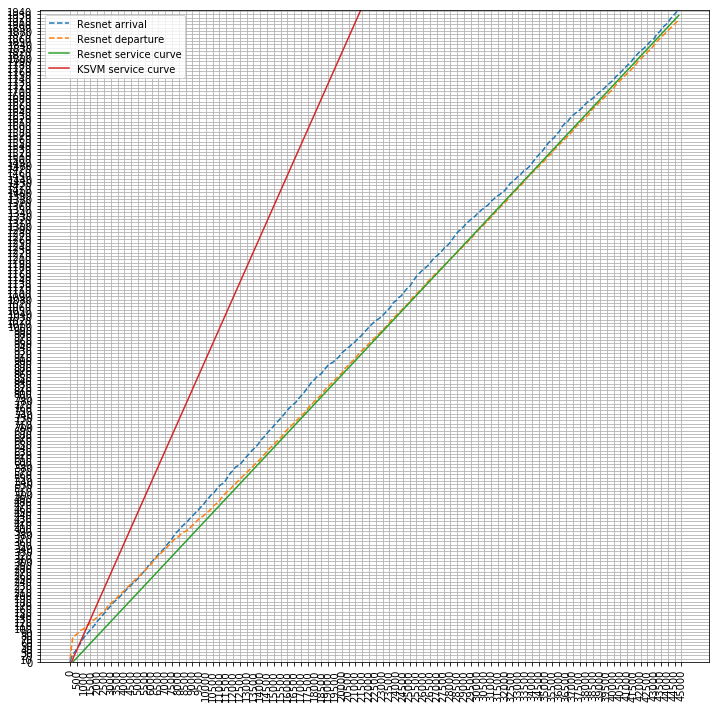

In [152]:
max(x_range)
plt.figure(figsize=(12,12))
x_jump = 500
plt.xticks(xrange(0,max(x_range)+x_jump,x_jump))
plt.xticks(rotation=90)
plt.gca().set_ylim([0,y_arrival_resnet[-1]])
plt.yticks(xrange(0,y_arrival_resnet[-1],10))
plt.grid(True)
plt.plot(x_arrival_resnet, y_arrival_resnet, label="Resnet arrival", linestyle="--")
# plt.plot(x_arrival_resnet_clipper, y_arrival_resnet_clipper, label="Resnet arrival clipper", linestyle="--")
plt.plot(x_departure_resnet, y_departure_resnet, label="Resnet departure", linestyle="--")
plt.plot([0,200,max(x_range)],[0,0,max(x_range)/1000.*43], label="Resnet service curve")
plt.plot([0,100,max(x_range)],[0,0,max(x_range)/1000.*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()

In [60]:
x_range = xrange(1,15000,25)
resnet2_arrival = ID1_500_hollistic_resnet2["client_timestamps"]["start->tf-resnet-feats_timestamps"]*1000.
# resnet2_departure = ID1_500_hollistic_resnet2["client_timestamps"]["tf-resnet-feats->tf-kernel-svm_timestamps"]*1000.
x_arrival_resnet2, y_arrival_resnet2 = get_max_curve(resnet2_arrival, x_range)
# x_departure_resnet2, y_departure_resnet2 = get_max_curve(resnet2_departure, x_range)

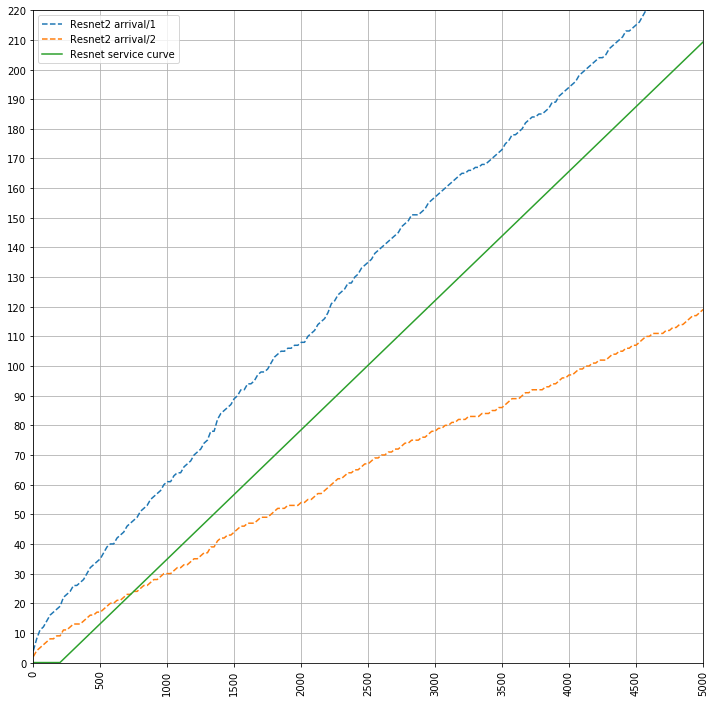

In [79]:
plt.figure(figsize=(12,12))
plt.xticks(xrange(0,max(x_range),500))
plt.xticks(rotation=90)
plt.yticks(xrange(0,np.max(y_arrival_resnet2),10))
plt.gca().set_xlim([0,5000])
plt.gca().set_ylim([0,220])
plt.grid(True)
plt.plot(x_arrival_resnet2, y_arrival_resnet2, label="Resnet2 arrival/1", linestyle="--")
plt.plot(x_arrival_resnet2, y_arrival_resnet2/2, label="Resnet2 arrival/2", linestyle="--")
plt.plot([0,200,max(x_range)],[0,0,max(x_range)/1000.*43], label="Resnet service curve")
# plt.plot([0,100,5000],[0,0,5*91], label="KSVM service curve")
# plt.plot([0,50,5000],[0,0,5*910], label="LogReg service curve")
# plt.plot([0,150,5000],[0,0,5*106], label="Inception service curve")
plt.legend()

In [173]:
ksvm_handle_times = np.asarray([[13900.6039604, 1397.24652905], [13758.2079208, 381.235804912], [13640.1881188, 390.937150576], [13649.5148515, 448.46207195], [13635.4950495, 371.352828511], [13712.2277228, 343.125121687], [13757.3663366, 550.550646455], [13847.6237624, 359.453238576], [13879.2772277, 400.737590218], [13997.8217822, 377.940363991], [13879.5742574, 332.962351707], [13849.2772277, 365.022503546], [14099.0594059, 351.394191271], [14249.2574257, 464.613235374], [14054.9207921, 411.122700558], [13973.4851485, 375.337277074], [14219.6138614, 412.089939484], [13990.4257426, 361.027640711], [13992.4950495, 393.913133706], [14006.5247525, 434.682121115], [13838.8415842, 431.764895979], [14135.6534653, 498.272807611], [14163.960396, 521.33752053], [13925.3069307, 656.521070259], [12740.6732673, 521.386405974], [12557.8019802, 451.055418426], [12496.4851485, 438.370353253], [12464.5940594, 514.400798742], [12577.5148515, 390.241169755], [12535.1485149, 524.685316083], [12594.5445545, 457.305983851], [12593.4257426, 498.906573657], [12714.5940594, 434.908529776], [12599.9405941, 433.156428465], [12650.029703, 427.075443875], [12453.4455446, 486.5396807], [12470.2970297, 474.186380714], [12496.7425743, 459.618000093], [12541.7227723, 488.319265771], [12554.6237624, 461.650393878], [12537.2772277, 471.990919505], [12471.8019802, 485.108684766], [12563.5940594, 455.260216706], [12537.8514851, 476.838586263], [12627.3168317, 449.159411396], [12520.0792079, 455.291130518], [12592.7623762, 448.670492524], [12545.6435644, 485.968983734], [12542.5544554, 468.97445465], [12574.1782178, 459.795184623], [12477.2970297, 498.163390123], [12569.1089109, 468.150540673], [12471.5940594, 434.297228562], [12499.5544554, 472.054000839], [12492.1683168, 464.579082767], [12661.3168317, 430.494303287], [12622.3366337, 495.320803681], [13122.3366337, 516.983621496], [12937.3465347, 570.541282609], [12794.0, 491.600236045], [12440.6336634, 462.196964631], [12568.7821782, 409.437131236], [12432.9108911, 489.175242426], [12635.7920792, 496.583542009], [12433.3465347, 468.261233591], [12538.029703, 508.904695613], [12725.990099, 468.313077455], [12619.7623762, 506.94363052], [12612.8910891, 482.503822403], [12453.7128713, 503.863849609], [12562.3267327, 432.908128477], [12554.9405941, 434.505769579], [12524.7227723, 441.278096883], [12434.3762376, 457.764063305], [12471.2178218, 478.83837584], [12454.3663366, 449.985274187], [12518.1683168, 465.076360584], [12495.049505, 499.377441654], [12526.950495, 402.206202379], [12515.3069307, 516.97047319], [12550.0, 455.718994535], [12525.1485149, 394.3634145], [12557.1287129, 382.897852712], [12596.5544554, 441.64865466], [12491.8217822, 453.851033179], [12414.1980198, 522.834298189], [12545.7524752, 472.867687226], [12516.0891089, 478.849220755], [12570.9009901, 471.473328098], [12509.019802, 494.851612526], [12646.9306931, 462.289358132], [12550.3267327, 455.226635079], [12529.6435644, 482.707946964], [12455.5742574, 512.356125113], [12598.2178218, 491.337124972], [12517.8514851, 507.527541781], [12378.0693069, 520.070106802], [12534.2178218, 439.710697059], [12571.1287129, 420.500142178], [12487.2574257, 437.055055858], [12476.1584158, 480.414398937], [12449.1089109, 501.65780418], [12482.0594059, 460.200382997], [12440.039604, 496.270624846], [12508.7128713, 539.898548164], [12550.7623762, 525.568304357], [12571.9009901, 455.498910563], [12450.4059406, 430.604598629], [12530.019802, 475.163921277], [12624.1485149, 424.495003088], [12674.7524752, 506.569874491], [12606.990099, 440.983048888], [12534.4356436, 495.895817385], [12806.5544554, 440.987651098], [12495.4851485, 462.049322597], [12663.3366337, 412.456761064], [12632.7524752, 439.271548347], [12602.6534653, 463.205906263], [12662.5346535, 470.663752175], [12692.8613861, 482.411722386], [12612.0, 479.111182037], [12580.6435644, 527.448980859], [12676.8514851, 500.726707266], [12628.0594059, 379.768997577], [12655.9207921, 382.890457751], [12635.5247525, 507.964460323], [12631.3663366, 449.145585403], [12581.8910891, 456.681159243], [12880.5346535, 436.504330995], [12747.6336634, 490.260381874], [12532.8217822, 457.287274486], [12616.5247525, 416.261760612], [12698.3168317, 483.696777832], [12579.4554455, 540.373312925], [12640.7227723, 447.541736951], [12751.9009901, 483.344956147], [12556.5643564, 572.08272295], [12447.9405941, 555.399433853], [12478.5049505, 463.474835609], [12583.2277228, 478.891746199], [12444.0, 481.923744019], [12551.3861386, 423.459513777], [12507.4752475, 460.283459673], [12679.6831683, 530.163769405], [12534.0594059, 486.946493529], [12592.7920792, 386.425593028], [12498.4653465, 471.945028775], [12569.1188119, 475.381811886], [12589.8712871, 439.011934328], [12595.950495, 449.20798015], [12576.8613861, 460.261893371], [12584.5742574, 467.914444802], [12624.6237624, 462.443121501], [12598.2475248, 497.403265006], [12507.2574257, 414.89780809], [12589.0, 457.413260727], [12576.3267327, 432.620980822], [12573.4158416, 465.687722405], [12639.0594059, 427.196683475], [12512.1386139, 514.431918341], [12987.8514851, 563.872666374], [13132.5247525, 396.695748293], [12738.6237624, 493.861504045], [12541.8217822, 399.456496994], [12641.3960396, 472.616334449], [12566.1881188, 507.25535415], [12619.2574257, 537.483071867], [12709.1188119, 427.774098039], [12654.3663366, 417.565118483], [12653.5049505, 490.862034694], [12493.6336634, 494.228446052], [12647.2475248, 470.52522593], [12669.3564356, 423.597244359], [12461.9207921, 534.739719848], [12830.1485149, 384.346388379], [12588.6831683, 530.275044095], [12647.3366337, 442.784914758], [12549.7722772, 459.350205735], [12562.6336634, 494.389466924], [12581.4059406, 432.942160594], [12492.6039604, 450.272636425], [12624.1089109, 427.204287186], [12648.8811881, 416.331748126], [12507.6831683, 466.434419758], [12684.4158416, 507.529646353], [12621.8811881, 480.267052096], [12720.0891089, 496.904538893], [12632.970297, 448.349458282], [12686.5346535, 482.765908144], [12671.9405941, 444.716192105], [12654.3762376, 433.394952875], [12526.8811881, 426.35780277], [12536.019802, 459.146646696], [12513.7920792, 512.208561266], [12663.2178218, 478.020207617], [12659.9306931, 463.173860337], [12414.960396, 441.933553556], [12473.4950495, 467.509360816], [12539.2475248, 411.837644785], [12500.2079208, 553.633994922], [12371.1485149, 450.243924784], [12599.5445545, 521.665450336], [12477.980198, 437.146801819], [12437.019802, 467.411663284], [12550.4455446, 461.218285024], [12446.7227723, 468.633195217], [12673.4554455, 442.935248263], [12716.6534653, 457.938934829], [12564.4356436, 450.950797866], [12374.3762376, 422.185095053], [12566.3960396, 416.120890641], [12498.7623762, 451.400376573], [12420.2475248, 429.368922262], [12521.9306931, 480.890062927], [12456.6237624, 424.54606746], [12472.7425743, 498.153573948], [12484.1782178, 439.884939862], [12545.1089109, 429.595547781], [12603.3762376, 458.943121899], [12535.3960396, 432.426038527], [12469.5742574, 441.514009657], [12495.039604, 438.141392269], [12537.7326733, 460.446272784], [12565.1881188, 383.976141814], [12447.029703, 494.652822654], [12456.3168317, 502.660228741], [12669.2277228, 451.38558699], [12580.7722772, 436.046252456], [12559.4950495, 474.480093246], [12512.8514851, 485.221586334], [12554.8217822, 428.563832279], [12455.1683168, 537.945874367], [12467.7524752, 482.825089908], [12593.1782178, 417.616537267], [12570.2178218, 481.890123542], [12577.6237624, 413.529791125], [12455.019802, 462.047551884], [12592.8910891, 409.647491566], [12501.3069307, 522.07113704], [12541.5445545, 417.480337469], [12461.7128713, 413.963296231], [12539.9405941, 430.845239307], [12478.3663366, 438.263533965], [12520.2871287, 455.848405769], [12503.1485149, 417.709961105], [12501.7227723, 398.196531376], [12403.7722772, 433.914256283], [12493.0594059, 528.682068113], [12536.5148515, 482.355577603], [12543.6930693, 511.102608182], [12721.3861386, 537.954228431], [12584.7623762, 439.266696511], [12554.6237624, 493.932830073], [12592.039604, 483.429332192], [12632.990099, 514.489759639], [12525.5247525, 511.319155802], [12570.7821782, 503.07117391], [12627.8316832, 458.668176814], [12509.3762376, 524.986993738], [12536.4653465, 444.865283076], [12566.0990099, 433.088711214], [12490.2079208, 416.119801791], [12446.6039604, 490.419321071], [12576.7920792, 456.724873676], [12624.4257426, 413.843954581], [12513.0990099, 401.608190544], [12432.1683168, 489.965730653], [12495.9009901, 493.334632378], [12535.2376238, 484.695395793], [12520.3069307, 481.65113587], [12566.3564356, 506.315316464], [12529.039604, 534.592875921], [12594.980198, 418.444265785], [12523.1683168, 504.509644675], [12535.4554455, 492.780282104], [12578.8613861, 507.259908183], [12575.8415842, 498.643183458], [12603.7227723, 443.895204804], [12527.4950495, 429.216869732], [12484.009901, 508.801610758], [12473.1584158, 429.442067986], [12533.3465347, 479.816805711], [12448.2673267, 443.277864516], [12523.6039604, 463.645180126], [12530.2772277, 448.468132334], [12544.8415842, 480.387070268], [12527.1188119, 470.728449334], [12544.5247525, 404.486389742], [12499.1485149, 496.892708823], [12515.960396, 490.197331872], [12522.950495, 465.262842274], [12491.1980198, 521.089776188], [12620.4356436, 419.117352026], [12558.5346535, 432.784458377], [12611.2871287, 415.069225686], [12509.1881188, 431.623706505], [12467.1980198, 433.472006697], [12433.2673267, 434.16632053], [12490.5841584, 432.75004258], [12651.6435644, 508.757398743], [12624.9009901, 509.415535901], [12499.980198, 420.719232833], [12454.5742574, 506.450731558], [12505.5643564, 471.803164525], [12422.3564356, 426.760224008], [12507.3465347, 522.32517916], [12606.7425743, 410.39998971], [12535.3069307, 457.085054861], [12515.019802, 513.246239712], [12428.1881188, 508.916840702], [12448.7425743, 517.801075254], [12561.019802, 445.092714342], [13105.4653465, 445.985382799], [13139.6138614, 467.457457593], [12771.7326733, 516.908994635], [12603.950495, 462.411744349], [12632.6237624, 442.41696321], [12654.4059406, 484.073682678], [12629.7425743, 463.136073785], [12569.6633663, 450.258677625], [12692.2277228, 421.17955253], [12778.6633663, 538.477764183], [12732.4851485, 449.455371497], [12738.2772277, 510.047602492], [12704.8811881, 486.84387249], [12791.4752475, 511.953714532], [12771.5148515, 440.521217251], [12737.1287129, 503.721195543], [12732.2772277, 499.200392684], [12656.5643564, 410.712383183], [12619.6237624, 482.475769699], [12712.9207921, 452.937052938], [12684.6633663, 429.939007354], [12713.6732673, 426.009252652], [12544.8217822, 524.168882845], [12596.6534653, 450.59721505], [12655.0891089, 431.97412599], [12547.6732673, 473.924819808], [12584.2376238, 503.545373859], [12654.6435644, 499.120683915], [12623.3168317, 488.12613876], [12643.009901, 451.160472758], [12603.8316832, 446.59581632], [12604.7524752, 439.198153388], [12582.8613861, 443.707691436], [12551.2376238, 488.791359416], [12629.5445545, 526.049907747], [12699.0594059, 527.044211078], [12678.1188119, 377.211060155], [12585.7128713, 474.709840227], [12563.3069307, 525.758155873], [12840.5247525, 447.330356009], [12645.5445545, 506.298067509], [12547.2079208, 441.217023379], [12492.3861386, 444.741441634], [12519.990099, 478.123590946], [12537.6138614, 457.489403011], [12666.3168317, 408.010505851], [12576.7425743, 472.848638279], [12441.990099, 439.082876208], [12616.1485149, 421.225989677], [12530.029703, 447.678178598], [12552.6633663, 407.188677828], [12624.8316832, 462.798462847], [12472.7623762, 486.125521592], [12559.5148515, 436.663012417], [12409.950495, 500.140265004], [12480.039604, 381.316529226], [12524.8217822, 419.351937454], [12392.4950495, 452.972856131], [12462.9306931, 418.698602755], [12630.5643564, 577.087076084], [12589.5940594, 460.679721183], [12475.7821782, 456.350538446], [12561.960396, 445.756869325], [12441.6039604, 505.84858767], [12477.039604, 466.413404372], [12537.6732673, 412.281075633], [12571.6633663, 429.377451188], [12457.4554455, 469.66353081], [12440.3465347, 445.972614611], [12642.6534653, 468.711176571], [12512.7920792, 394.820458427], [12455.6534653, 469.151402353], [12517.1485149, 439.475461105], [12467.6831683, 483.153214137], [12596.9108911, 460.867436515], [12424.8613861, 437.865276756], [12567.950495, 464.73380811], [12475.9405941, 517.643648629], [12541.7524752, 467.792867041], [12484.6930693, 452.430985768], [12578.8217822, 496.509667002], [12429.7326733, 406.350014737], [12481.9306931, 492.321802861], [12561.6534653, 529.002188613], [12578.039604, 470.991978675], [12697.2871287, 516.372559813], [12691.9207921, 414.730108665], [12641.3663366, 437.278933631], [12681.1683168, 440.412769244], [12718.1287129, 419.489450731], [12638.2574257, 471.44161999], [12625.8019802, 492.575832626], [12644.7227723, 503.823895031], [12717.4653465, 448.723305874], [12480.3267327, 457.264338675], [12682.990099, 421.536146344], [12659.0891089, 523.79315506], [12722.3069307, 438.759677168], [12709.5346535, 447.691561175], [12631.4455446, 475.808878247], [12593.4455446, 458.423546543], [12733.3762376, 422.28041576], [12584.2673267, 511.216911415], [12622.0693069, 483.875019815], [12622.5742574, 487.791676572], [12548.1386139, 473.499234784], [12663.7722772, 477.280515752], [12389.4950495, 494.196570178]])/1000.

<Container object of 3 artists>

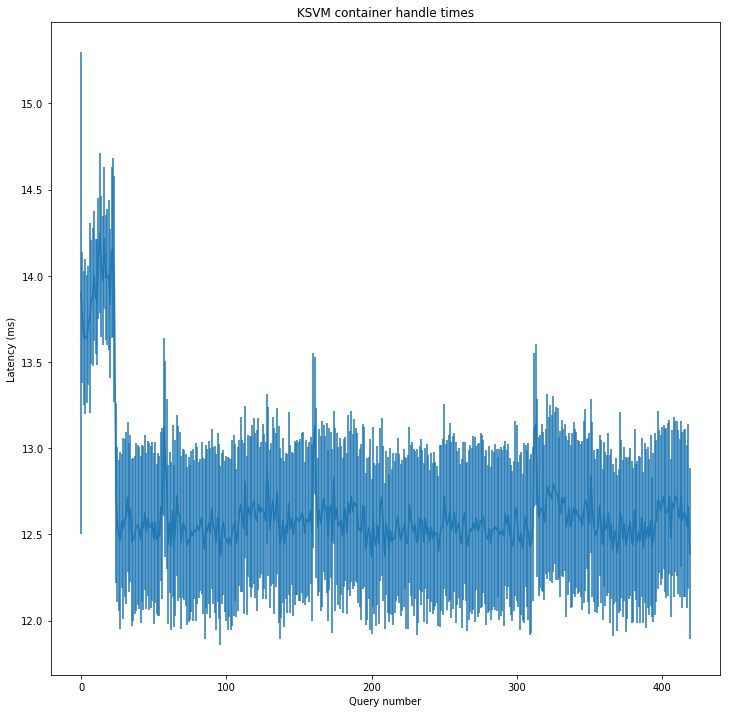

In [174]:
plt.figure(figsize=(12,12))
plt.title("KSVM container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.errorbar(np.arange(ksvm_handle_times.shape[0]), ksvm_handle_times[:,0], ksvm_handle_times[:,1])

In [179]:
ksvm_handle_times2 = np.asarray([26837, 16478, 13250, 13691, 13798, 13133, 13484, 13432, 13703, 13323, 13233, 13685, 13123, 12996, 14036, 13464, 13223, 13616, 13175, 13962, 13350, 13028, 13421, 13656, 13842, 13297, 14178, 13649, 13489, 12871, 13154, 13378, 13219, 13049, 13197, 12692, 12848, 12986, 12920, 13827, 13340, 13660, 13555, 13464, 13851, 13444, 12976, 13836, 13585, 13110, 13649, 13745, 13154, 13556, 13463, 13902, 13449, 13435, 14267, 13352, 13494, 13755, 13452, 13453, 13200, 13845, 14260, 13115, 13448, 13962, 13526, 13222, 13758, 13271, 13403, 13217, 13507, 13838, 13437, 13931, 13029, 13412, 13488, 13368, 13601, 13286, 13811, 13148, 14073, 13570, 13377, 13619, 13893, 13799, 13534, 13542, 13684, 13462, 13515, 13905, 13212, 13370, 13219, 13388, 13930, 13124, 13537, 13451, 13974, 13153, 13700, 13707, 13422, 13697, 13595, 13542, 13442, 13684, 13812, 13715, 13587, 13397, 13133, 13445, 12944, 12920, 13084, 14016, 13566, 13363, 13284, 13818, 13170, 13846, 13155, 13198, 13779, 13189, 13742, 13183, 13651, 13492, 13542, 14014, 13391, 13030, 13286, 14041, 13709, 13841, 13226, 13454, 13760, 13173, 13676, 13654, 13208, 13524, 13685, 13348, 13942, 13502, 13129, 13843, 13311, 13083, 13579, 13079, 13563, 13729, 13203, 13742, 13411, 13216, 13542, 13620, 13275, 13688, 13702, 13134, 14108, 13576, 13811, 13098, 13472, 13756, 13276, 13672, 13098, 12988, 13450, 13348, 13820, 13375, 13711, 13309, 13719, 13531, 14132, 13286, 13250, 13485, 13304, 13815, 13361, 13048, 13113, 13371, 13810, 13115, 13799, 13541, 13440, 13056, 13413, 13465, 13370, 13304, 13427, 13395, 13139, 13271, 13403, 13644, 13778, 13787, 13408, 13895, 13646, 13668, 13495, 14303, 13410, 13443, 13373, 14083, 13394, 13483, 13487, 14005, 13318, 13330, 14083, 13616, 13201, 14486, 13411, 13600, 13649, 13419, 13637, 13659, 13687, 13463, 13408, 14167, 13918, 13230, 13644, 13639, 13600, 13034, 13674, 13191, 13572, 13157, 13558, 13987, 13347, 13760, 13772, 13939, 13400, 14147, 13711, 13979, 13067, 13256, 13528, 13952, 13531, 13287, 13129, 13281, 13866, 13977, 14916, 13913, 13294, 14008, 13613, 13574, 14623, 13461, 13344, 13954, 13483, 13323, 13319, 13634, 13118, 13418, 13396, 13140, 13345, 13235, 13873, 14475, 14899, 13752, 13382, 13211, 13497, 13127, 12901, 13875, 13010, 14583, 14324, 14042, 13768, 13962, 14013, 14158, 13580, 13655, 13753, 13414, 13280, 14172, 13403, 13048, 14216, 13711, 13343, 13455, 13118, 13775, 13395, 13136, 13562, 13044, 13766, 13647, 13313, 13627, 13610, 13294, 13440, 13366, 13545, 13237, 13272, 13292, 13100, 13175, 13271, 13437, 13144, 13464, 13648, 13360, 13553, 13575, 13043, 13550, 13361, 12934, 13781, 13838, 13248, 13808, 13162, 13491, 13315, 13849, 13915, 13861, 13659, 14052, 13509, 13474, 13981, 13257, 13548, 13287, 13359, 14060, 13425, 13520, 13842, 13521, 13530, 13983, 13228, 14030, 13241, 13468, 13759, 13231, 13262, 13661, 13573, 13790, 13838, 13719, 13828, 13454, 13355, 13667, 13863, 13406, 13482, 13358, 13824, 13976, 13230, 14026, 13725, 13211, 13566, 13358, 13485, 14513, 13714, 13687, 13633, 13996, 13814, 13252, 14225, 13897, 12919, 13336, 13739, 13484, 14073, 13910, 13431, 13675, 13081, 13254, 13889, 13505, 13614, 14214, 13240, 13921, 12524, 12729, 13060, 12499, 13082, 12847, 13285, 13353, 14310, 13908, 13786, 13575, 13239, 14286, 13621, 13117, 13681, 13543, 12934, 13860, 13722, 13713, 13885, 13470, 13878, 13581, 13343, 13725, 13685, 13789, 14030, 13070, 13927, 13455, 13437, 13075, 13222, 13213, 12930, 13372, 13171, 13111, 13030, 13378, 13365, 13106, 13708, 13575, 13800, 13724, 14254, 13686, 13266, 13700, 13426, 13163, 13538, 13449, 13697, 13141, 13880, 13471, 13625, 13813, 13294, 13311, 13509, 13832, 13729, 13554, 13472, 13048, 13765, 13447, 13774, 13682, 13518, 13507, 13382, 14274, 13514, 13076, 13649, 13793, 13118, 13962, 14189, 14104, 13156, 13738, 13356, 13691, 13681, 13351, 13786, 13294, 13556, 13297, 13957, 13539, 13253, 13478, 13663, 13032, 13834, 13470, 14347, 13731, 13502, 13769, 13362, 13678, 13711, 13028, 13835, 13507, 13323, 13448, 13318, 13851, 13423, 13640, 13439, 13668, 14020, 13169, 14067, 13222, 13037, 13826, 13330, 13464, 13382, 13159, 13361, 14110, 13867, 13077, 13401, 13179, 13114, 12984, 13724, 13496, 13521, 13222, 13732, 13501, 13321, 13646, 13304, 13536, 13937, 13278, 13557, 13016, 13719, 14428, 13806, 14249, 13799, 14179, 13850, 13600, 13544, 13628, 13983, 13947, 14190, 15002, 14075, 13751, 14047, 13542, 14074, 13669, 13765, 13785, 13463, 13399, 13854, 13328, 13222, 13419, 14090, 13922, 13737, 13571, 13615, 13627, 13442, 13996, 14120, 13578, 13507, 13337, 13960, 13636, 13511, 14384, 14175, 13876, 13001, 12822, 13624, 12427, 12620, 13329, 12477, 12666, 13868, 13890, 13589, 13886, 13580, 14216, 13707, 13739, 13907, 14248, 14038, 14468, 13573, 14430, 13680, 13420, 14010, 13693, 13619, 14171, 13457, 14319, 13638, 13722, 14267, 14228, 14037, 14091, 14290, 14328, 13626, 13742, 13697, 13754, 13410, 13842, 13722, 14106, 14277, 14611, 13828, 13834, 13933, 14104, 13936, 13895, 13972, 13785, 14036, 13760, 13174, 13850, 13373, 14860, 13530, 13350, 14075, 13131, 14043, 13899, 13783, 13683, 13292, 13615, 13635, 14087, 13875, 13650, 13520, 14212, 13381, 13635, 13680, 14417, 14330, 13672, 14357, 13449, 13565, 13517, 13718, 14174, 13656, 13641, 14103, 13706, 13925, 14339, 13750, 14126, 13895, 13796, 13684, 14500, 13583, 13560, 14023, 14185, 13450, 13433, 14193, 13715, 13578, 13421, 13906, 13568, 13177, 13066, 13949, 13925, 13086, 13345, 14317, 13607, 14087, 14562, 14282, 13756, 13697, 13825, 14474, 14235, 13737, 13802, 13560, 14109, 13862, 13449, 14197, 14284, 13856, 13918, 14128, 13718, 14352, 14220, 13777, 13926, 13696, 13353, 13752, 14067, 13713, 13506, 13716, 14062, 13875, 14316, 13844, 13592, 13881, 13676, 13806, 13336, 13713, 13614, 13570, 14020, 13780, 13955, 13681, 13639, 14153, 13500, 13296, 14142, 13801, 13434, 13914, 13668, 13771, 13465, 13769, 13883, 14098, 14142, 13682, 13672, 13427, 13919, 13620, 13688, 13498, 13979, 14403, 12909, 13656, 13443, 13868, 13524, 13173, 13665, 13487, 14634, 14314, 13766, 13411, 13839, 13020, 12971, 13179, 13913, 13254, 13323, 13908, 14119, 13768, 13713, 14389, 14182, 13784, 13954, 14315, 13956, 13442, 13516, 14578, 14674, 14365, 13812, 14195, 13531, 13685, 14205, 14034, 14323, 14021, 13791, 13638, 13448, 13661, 13538, 13282, 14572, 13540, 13422, 13989, 13525, 13696, 13700, 13871, 14640, 14054, 14072, 15003, 13493, 13479, 14347, 13699, 13887, 13752, 14138, 14065, 13949, 13867, 14089, 14781, 13889, 13703, 14249, 13683, 13739, 13663, 13833, 13972, 13754, 14009, 14974, 14131, 13752, 14443, 13868, 14017, 13976, 13786, 13982, 14801, 13898, 13556, 14403, 13649, 13642, 13866, 13587, 13850, 13799, 13981, 13810, 13619, 12925, 14021, 14169, 14195, 14049, 14536, 14212, 14498, 13577, 13735, 14202, 14079, 14166, 13629, 14336, 14304, 13703, 14313, 13726, 13641, 14002, 13824, 13397, 13893, 13604, 14309, 13399, 13640, 13903, 14246, 13967, 14005, 13708, 13875, 13683, 13823, 13621, 13697, 13794, 13968, 14082, 13775, 14069, 13978, 13878, 14025, 14246, 13511, 14021, 13931, 13794, 14591, 13860, 13789, 14537, 13564, 13779, 13883, 13778, 13958, 13585, 13702, 14223, 13356, 14277, 13826, 14212, 13917, 14018, 13645, 13398, 14196, 13488, 13744, 13445, 13375, 13642, 13081, 13717, 13741, 14281, 14100, 13567, 13628, 14109, 13975, 13276, 14035, 14008, 14452, 13388, 13172, 14359, 13663, 14580, 14041, 13930, 13407, 13994, 13879, 13466, 13831, 13984, 14029, 13542, 13564, 13314, 13597, 13289, 13036, 13099, 13312, 13707, 13942, 13368, 14161, 13883, 14179, 14182, 13397, 14317, 13430, 13486, 14157, 13650, 13898, 13692, 13553, 14601, 13969, 13526, 14190, 14018, 13928, 13752, 13296, 14296, 13804, 14047, 13815, 13865, 13794, 14160, 13703, 13801, 13919, 14157, 13639, 14010, 13298, 13345, 13398, 14099, 14572, 13909, 13778, 14252, 13574, 13996, 13539, 13622, 13212, 13813, 13931, 13968, 13682, 14395, 13817, 14410, 14014, 14314, 13693, 14471, 13620, 14014, 14168, 13759, 13864, 13829, 14344, 13661, 14173, 13909, 14059, 14182, 13831, 13840, 13672, 13815, 13991, 13765, 13541, 14385, 13687, 13503, 13485, 13802, 13652, 13234, 13709, 14154, 13345, 13108, 13839, 13544, 13684, 13718, 14157, 14499, 14073, 14159, 13979, 13772, 14137, 13650, 13573, 14540, 13214, 13880, 13127, 14520, 14025, 13719, 13808, 14724, 13876, 13910, 13527, 14013, 13959, 13734, 13494, 14239, 13445, 14303, 13600, 14397, 14357, 13377, 14928, 14359, 13359, 13687, 14398, 14051, 13792, 14469, 13566, 13901, 13726, 14048, 13671, 13390, 13920, 14333, 14105, 13326, 13289, 14102, 14428, 13926, 13551, 14176, 13662, 14040, 14068, 13971, 13718, 14034, 13951, 13599, 13590, 13704, 13931, 13678, 15063, 14250, 14289, 14113, 14280, 13806, 13868, 14161, 13582, 14142, 14129, 13939, 13981, 14250, 13661, 13501, 13798, 13371, 13491, 14237, 13307, 14138, 14342, 13824, 13733, 13378, 13673, 13743, 13666, 13942, 13832, 14087, 13939, 13988, 14295, 14019, 13507, 14807, 14037, 14180, 14294, 13907, 13819, 13855, 13601, 13970, 13761, 14028, 13994, 14225, 14134, 13643, 13716, 13615, 13817, 14083, 14144, 13843, 14229, 14313, 13756, 14794, 14365, 13568, 14230, 13608, 14064, 14542, 13835, 13780, 14198, 13812, 14261, 13551, 13979, 13805, 14508, 13827, 14807, 13825, 14052, 14140, 13917, 14151, 14327, 14376, 14662, 13728, 15234, 14447, 14416, 14012, 14148, 13800, 13898, 14234, 13627, 14051, 13928, 13713, 14204, 14726, 14957, 14176, 14727, 15093, 14468, 13710, 14333, 13812, 14213, 13642, 13527, 13503, 13584, 13848, 14619, 14516, 14657, 14088, 14691, 13901, 13741, 14119, 14256, 13642, 13973, 13874, 14819, 13718, 13769, 13751, 13990, 13956, 13798, 13571, 14083, 14175, 13795, 13407, 14226, 14679, 14123, 14816, 13933, 13261, 13615, 14389, 13929, 13901, 13749, 13794, 14688, 15069, 14028, 14104, 13878, 14505, 14706, 14380, 14345, 14392, 14116, 13637, 14911, 14346, 15259, 14646, 15652, 14532, 14494, 14287, 13990, 13496, 14138, 13324, 13872, 14521, 14450, 14323, 14253, 15248, 14851, 14243, 14167, 13661, 13679, 13747, 14224, 14327, 14205, 14224, 14446, 14546, 14561, 14146, 14907, 14270, 14734, 13691, 14361, 14446, 14258, 13864, 14533, 14691, 13989, 14191, 14493, 13634, 14081, 13893, 13953, 13800, 14061, 13482, 14519, 14570, 14134, 13562, 14032, 14479, 13797, 13689, 14821, 13653, 14627, 13689, 14377, 15024, 14284, 14292, 14528, 14374, 13781, 13449, 14112, 13739, 13936, 13852, 14268, 14951, 14656, 14354, 14134, 15048, 14271, 14591, 13318, 13898, 13759, 13335, 14269, 14227, 14268, 14071, 14666, 14902, 14775, 13994, 14984, 13351, 13362, 13716, 13656, 13482, 13987, 13060, 14358, 14454, 14004, 14549, 14185, 14388, 14401, 13943, 13621, 13641, 14345, 12895, 14947, 14562, 14386, 14208, 14999, 14348, 14803, 14450, 13614, 14583, 13970, 13938, 14269, 15367, 15174, 14790, 14774, 14913, 13920, 13757, 15347, 15265, 15046, 14903, 13996, 14584, 14583, 14113, 14835, 14250, 14326, 15153, 14058, 14692, 14089, 14708, 14271, 14357, 14933, 13848, 14402, 14866, 14071, 14636, 14511, 14533, 14169, 14185, 14294, 13908, 13664, 14383, 14302, 13676, 13852, 13274, 13514, 13453, 13660, 14113, 13958, 13764, 14194, 13937, 13961, 13804, 13624, 13574, 14003, 13272, 13366, 13819, 14218, 14119, 13813, 13587, 13611, 13288, 13605, 13646, 13612, 14414, 14018, 14224, 13490, 13615, 13796, 14328, 13947, 14265, 13657, 13768, 13503, 13714, 14139, 13921, 13148, 13970, 13972, 13553, 13768, 13632, 13954, 13729, 13864, 14169, 13703, 13338, 14186, 13767, 14193, 14326, 14525, 14036, 13884, 13954, 13657, 13782, 13719, 13765, 14257, 13708, 14042, 14441, 14395, 14199, 13961, 13919, 13892, 14728, 14371, 14027, 14854, 14324, 13947, 13767, 13696, 14121, 14406, 13740, 13584, 13906, 14116, 13884, 14029, 13770, 13108, 13999, 13582, 14428, 14636, 14524, 14485, 14337, 14634, 14445, 14422, 14823, 14923, 13883, 13615, 13379, 13854, 14550, 14653, 14431, 14718, 13908, 15205, 14826, 14560, 14492, 14168, 14011, 13986, 13452, 14386, 14607, 14251, 14374, 14052, 14404, 14968, 14081, 14626, 14537, 13713, 13904, 14611, 14540, 14543, 14467, 14592, 14675, 14239, 14180, 14884, 14842, 15171, 14262, 14790, 14811, 15136, 14780, 15208, 14647, 14710, 14128, 14579, 14063, 14189, 13366, 13587, 13432, 13795, 14041, 14861, 13882, 14330, 14427, 14480, 14070, 13777, 13787, 13789, 14177, 14071, 13797, 14526, 14516, 14420, 14527, 14920, 14411, 14031, 14430, 13580, 13703, 13849, 14013, 13728, 14116, 13782, 13894, 13590, 14055, 14027, 13839, 13629, 14081, 13567, 13708, 14621, 13726, 13901, 14016, 13182, 14105, 13913, 13385, 13726, 13916, 14223, 13258, 14550, 13534, 13363, 13660, 13897, 13225, 13825, 13216, 13850, 13970, 13799, 13448, 14805, 13899, 14315, 13989, 14120, 13957, 14492, 13505, 14277, 14215, 14429, 13926, 14755, 15252, 15331, 14314, 15111, 14711, 14084, 13897, 13990, 14100, 13707, 13929, 14574, 14647, 13937, 13763, 14260, 14316, 13906, 14260, 13836, 13922, 14225, 13783, 15980, 15757, 14808, 14223, 13794, 14735, 14659, 14809, 14139, 14072, 13882, 14006, 13694, 14076, 14517, 14108, 13977, 13262, 14021, 13892, 13873, 13931, 13459, 13486, 13465, 13644, 14180, 13980, 14743, 14438, 13556, 13379, 14278, 14110, 13904, 13426, 13912, 14518, 13922, 13465, 13558, 14153, 14017, 13469, 14602, 13784, 14553, 13467, 14744, 13846, 13741, 13954, 14347, 13759, 13907, 13463, 14442, 14396, 14291, 14552, 14041, 13958, 14113, 13529, 13388, 13939, 13750, 13820, 13987, 14225, 14976, 13947, 14947, 13922, 14784, 14401, 14098, 14103, 14187, 14044, 14731, 13997, 13875, 13712, 14232, 13881, 13914, 13982, 14460, 13625, 13997, 13699, 13230, 14138, 14869, 13520, 14079, 13854, 13875, 13412, 13879, 14150, 14003, 13424, 13096, 13752, 14015, 13944, 14099, 13637, 14499, 14257, 13575, 13900, 14032, 14489, 13864, 14203, 14071, 13761, 14152, 13714, 13602, 13412, 13872, 14152, 13878, 13751, 13778, 14230, 13389, 13826, 13780, 13721, 13882, 13985, 14210, 13716, 14201, 13648, 13991, 13892, 14505, 13412, 13485, 13493, 14035, 13800, 14026, 13743, 13901, 14040, 13204, 13518, 13909, 13814, 13917, 14151, 13809, 13312, 14530, 14714, 14503, 14135, 14139, 14113, 14051, 13594, 14081, 13811, 13956, 13824, 14743, 14198, 13473, 13727, 14001, 13767, 14301, 13927, 13890, 13456, 13301, 13420, 14288, 13500, 14236, 14113, 14228, 14113, 13937, 13950, 14577, 14186, 14152, 14121, 13986, 14016, 15145, 14313, 13476, 14358, 13080, 13475, 13461, 13653, 14290, 13957, 13357, 14401, 13479, 13349, 13595, 13743, 14345, 13389, 13188, 13078, 13864, 13958, 13936, 13574, 13497, 13560, 13380, 13581, 14440, 13687, 13715, 13447, 13665, 13968, 13710, 13842, 14013, 13785, 14027, 14150, 13680, 13495, 13822, 14136, 13992, 14085, 13619, 13951, 14442, 13477, 13692, 13959, 13822, 13921, 14473, 13940, 13689, 13899, 14101, 13525, 13642, 13759, 13273, 13434, 13358, 13908, 13590, 13496, 13707, 13381, 13249, 13757, 13244, 13691, 13998, 13380, 13728, 13553, 13768, 14076, 13328, 14027, 14416, 13702, 14171, 13402, 13195, 13720, 13979, 13882, 15058, 14192, 14623, 14875, 13854, 14019, 14384, 13522, 14382, 13342, 14004, 13868, 13698, 13249, 14134, 14439, 14099, 13887, 14036, 13706, 14745, 14337, 14388, 14489, 12827, 13026, 12831, 13424, 15094, 13803, 13731, 13852, 14062, 13649, 13756, 14302, 14428, 14116, 15081, 15120, 14783, 14474, 14649, 14501, 13678, 13451, 14124, 13362, 13676, 13404, 13748, 13968, 14197, 14180, 13843, 13987, 14049, 13656, 13461, 13307, 13795, 13651, 13837, 12853, 13448, 12915, 14155, 14402, 13820, 14396, 13866, 13991, 13422, 13637, 14210, 13671, 13133, 14486, 14458, 15116, 14786, 14313, 13578, 13919, 14830, 14974, 14163, 14432, 14020, 15020, 14610, 14261, 14589, 13765, 14160, 14177, 13873, 13802, 13952, 13905, 13654, 12688, 13124, 12781, 14135, 13804, 13797, 14277, 13885, 13851, 13837, 13821, 14266, 13920, 13973, 13850, 14442, 13864, 14022, 13696, 13944, 13792, 14034, 14285, 14680, 13739, 14605, 14826, 14151, 14127, 14046, 13991, 14378, 13985, 14290, 14641, 13574, 13335, 13534, 14625, 13727, 14129, 13865, 14406, 14407, 13919, 13791, 13813, 15274, 14031, 14604, 14119, 14664, 14126, 14347, 14127, 14066, 13968, 14287, 13910, 13732, 14215, 13847, 13889, 14195, 14091, 14210, 13821, 14355, 14197, 13799, 13881, 14930, 14253, 13818, 14305, 14073, 14040, 13694, 13577, 14372, 13657, 13664, 13810, 13920, 14680, 14747, 13725, 12681, 13051, 13118, 14088, 13830, 14340, 14109, 13534, 14962, 14452, 14315, 13831, 12809, 12926, 14031, 13995, 14152, 13835, 13674, 13867, 14647, 13879, 12605, 12619, 12935, 14530, 14047, 13827, 13892, 13758, 13589, 13745, 13630, 13836, 13700, 13501, 14248, 15269, 13966, 13953, 14253, 13989, 14056, 13989, 15115, 14128, 14604, 13839, 13608, 12688, 12691, 12800, 14750, 14266, 14581, 14068, 14161, 14001, 14650, 13864, 14057, 14050, 15274, 14642, 14525, 15077, 13975, 14259, 13605, 14082, 14117, 14181, 14161, 14410, 13879, 13630, 13134, 12583, 13642, 14132, 13716, 15062, 14366, 14208, 14760, 14593, 13994, 14146, 13966, 12874, 12747, 13168, 13660, 13896, 14129, 13848, 12800, 12408, 13326, 12731, 12674, 12902, 14223, 13868, 13885, 16284, 13950, 14208, 14075, 13988, 14698, 13894, 13712, 12622, 12531, 12613, 14015, 13650, 14427, 14051, 14914, 14564, 14177, 14623, 13268, 14701, 14075, 14268, 13905, 13806, 13652, 13355, 12460, 12531, 12394, 13621, 12745, 14001, 14481, 13854, 13347, 12179, 13364, 12598, 13655, 13375, 12051, 12872, 13413, 13380, 12885, 12450, 12574, 13300, 12360, 13885, 12870, 13163, 12425, 13301, 12732, 13420, 12261, 12456, 11747, 11869, 11485, 12230, 12199, 12625, 12728, 12415, 13287, 12958, 12889, 13024, 12568, 12798, 12391, 12526, 13088, 12867, 12859, 12715, 12861, 12686, 12947, 12380, 11687, 12083, 12645, 12498, 13328, 11895, 12226, 12660, 12842, 12908, 12590, 11757, 12773, 12622, 12371, 11966, 11898, 11651, 12521, 12723, 12692, 12099, 13130, 12871, 13338, 12641, 13353, 12773, 12867, 12557, 13174, 12518, 13092, 12379, 13574, 12812, 12543, 13443, 12574, 12952, 12205, 12126, 12780, 12783, 13046, 12010, 12814, 12778, 12801, 12511, 12936, 12804, 12773, 12122, 12881, 13159, 12197, 12696, 12602, 12866, 12814, 12877, 12411, 12571, 12918, 12854, 13021, 13095, 12552, 12487, 12708, 12988, 13386, 12589, 12560, 12477, 12737, 12879, 12448, 12227, 13509, 13218, 12320, 12607, 12934, 13060, 12936, 12759, 12678, 13030, 12282, 12369, 13058, 12920, 13295, 12482, 12936, 12699, 12775, 12871, 12735, 11981, 12899, 12647, 12877, 12306, 12896, 12465, 13063, 12733, 12378, 12541, 12466, 11982, 13717, 12516, 12424, 12697, 12982, 12851, 13560, 13289, 13237, 13035, 12676, 12446, 12370, 12647, 12632, 11973, 12377, 12454, 12977, 12790, 13068, 12874, 12199, 12300, 13261, 12581, 12351, 12313, 12277, 12104, 12355, 12438, 12967, 12548, 11209, 12295, 12438, 12719, 12688, 12418, 13133, 13348, 12998, 13270, 12571, 12971, 12553, 12587, 12970, 12812, 12959, 13046, 12957, 13510, 12733, 12716, 12908, 11892, 13471, 12091, 12223, 11811, 12234, 12481, 12587, 12355, 12271, 12418, 12820, 12519, 11957, 12351, 12505, 12525, 12619, 11763, 12979, 12549, 12625, 12755, 12292, 12653, 12786, 13276, 13121, 12547, 12487, 12757, 12552, 12780, 12550, 12707, 13043, 12505, 12519, 13014, 13365, 12798, 12793, 12739, 12293, 11991, 11518, 12182, 13353, 12772, 12678, 11427, 12869, 12525, 12150, 12188, 12171, 12909, 12721, 13280, 12280, 12359, 12746, 13215, 12250, 12637, 13014, 12516, 13615, 12763, 12797, 12498, 12414, 12380, 12761, 12797, 12825, 12268, 12997, 12477, 12005, 12240, 12028, 12149, 12935, 12546, 12605, 12682, 12324, 12195, 11393, 11333, 12801, 12870, 11945, 11927, 13415, 13058, 13117, 13348, 12651, 12715, 12136, 12379, 13485, 13438, 13530, 13179, 13397, 12670, 12989, 13318, 12997, 11979, 12712, 12598, 13165, 11955, 11716, 11647, 12372, 12574, 12242, 11354, 12634, 12646, 13260, 12909, 12781, 12683, 12478, 12064, 13202, 13187, 12276, 12916, 12485, 12455, 11805, 12050, 12783, 12331, 13331, 12179, 11868, 12102, 12593, 13024, 12354, 12368, 12482, 12385, 12211, 12957, 12521, 11952, 12799, 12074, 12669, 12015, 12661, 12234, 11934, 12145, 12820, 11469, 12879, 12754, 12544, 12668, 12206, 11795, 12009, 12752, 12759, 12816, 12902, 12814, 12294, 11865, 13228, 12402, 12687, 12838, 13068, 12259, 12082, 12258, 12622, 13120, 11613, 11946, 12927, 12530, 12171, 12220, 12597, 12652, 12178, 12106, 12979, 12370, 12694, 12492, 12679, 12718, 11766, 12256, 12172, 12639, 13341, 12511, 12767, 12365, 12277, 11267, 12668, 12205, 12476, 11685, 13537, 12597, 12450, 12800, 12839, 12849, 12474, 12568, 12850, 12379, 11822, 12107, 12286, 11618, 12104, 12117, 12720, 12678, 12487, 13412, 13019, 12877, 12337, 11723, 13132, 12994, 12494, 13284, 13258, 12509, 12639, 12647, 12977, 12947, 12638, 12362, 12133, 12438, 13009, 12893, 12375, 11781, 12794, 12640, 12830, 12921, 12298, 12684, 13448, 12540, 12132, 12411, 13098, 12332, 12221, 12678, 12007, 12118, 12153, 11373, 13229, 11641, 11985, 12739, 12487, 12462, 12027, 11999, 12306, 12270, 13085, 12156, 12794, 11762, 12698, 12421, 12690, 12618, 12893, 12201, 11901, 12149, 12691, 12073, 12122, 12022, 11813, 11890, 13490, 12356, 12094, 12536, 12364, 12362, 12511, 12317, 12666, 13037, 12727, 12699, 12035, 12779, 11922, 12585, 12122, 12880, 12105, 11816, 12486, 12270, 12431, 13264, 12832, 12584, 12327, 12752, 12692, 12676, 12893, 12956, 13219, 12076, 12654, 11916, 12655, 12097, 12012, 12204, 12507, 13599, 12256, 11975, 12946, 13094, 12661, 12426, 12856, 12574, 12792, 11910, 12799, 13003, 12987, 12514, 12743, 12052, 11702, 12651, 12213, 12390, 11218, 11120, 12611, 12103, 13210, 12083, 12975, 12296, 12043, 12562, 12819, 11900, 12229, 10867, 12586, 12065, 12133, 12056, 12126, 13577, 12747, 12101, 12814, 12698, 12961, 12075, 12937, 12533, 11684, 11416, 12192, 12265, 12118, 12437, 13181, 12917, 13428, 12989, 12708, 12806, 13188, 12283, 12064, 12879, 12641, 12567, 12993, 12641, 12107, 12592, 12065, 13197, 12584, 12227, 12741, 12445, 12864, 12379, 12783, 12066, 13001, 12154, 12446, 12172, 11831, 12092, 11949, 11848, 11691, 12148, 12649, 12737, 12511, 11180, 12987, 12881, 12135, 12432, 12736, 12300, 11886, 12886, 13676, 12114, 11717, 11848, 12743, 12873, 12854, 11806, 12467, 12426, 12108, 12401, 12496, 11837, 12107, 12684, 13431, 12505, 12593, 12090, 12458, 12154, 13079, 12245, 12381, 12799, 12535, 12639, 12972, 12337, 12030, 11662, 13235, 12960, 13618, 11943, 13534, 12940, 12239, 12717, 12303, 12372, 11984, 11865, 12260, 12162, 13486, 11972, 12285, 12543, 12305, 13085, 12885, 12008, 13000, 12704, 12708, 12355, 12347, 12632, 13015, 12218, 11696, 12473, 12761, 12269, 12135, 12439, 12470, 12988, 12681, 12031, 12745, 12946, 12793, 12736, 13636, 12317, 12556, 12125, 13217, 12851, 12456, 12699, 12725, 12525, 12825, 11738, 12520, 12250, 11706, 11168, 13032, 13138, 12342, 12744, 12548, 12674, 12465, 11899, 12580, 12491, 12458, 13126, 13234, 13058, 11666, 12534, 12612, 12242, 12166, 10988, 12787, 12902, 12415, 12080, 13136, 12336, 12831, 12211, 12878, 13002, 12509, 12636, 12729, 12350, 12603, 12407, 12023, 12377, 12959, 12541, 12114, 12432, 12201, 12144, 12027, 11565, 12366, 12865, 12369, 12869, 12761, 12177, 12997, 12520, 12497, 12396, 13117, 12622, 12618, 12297, 11478, 12057, 12284, 13000, 12323, 12586, 12551, 12673, 12731, 11897, 11522, 11553, 12786, 12544, 12423, 13061, 12144, 12784, 12790, 13137, 12702, 12452, 12337, 13198, 12665, 12620, 12829, 13101, 12688, 12710, 12554, 12878, 12809, 12493, 13108, 12519, 12971, 12496, 12288, 12929, 12700, 13036, 12770, 12599, 12129, 12273, 12942, 13073, 12858, 12591, 12170, 13025, 12434, 12570, 12716, 12684, 12563, 13111, 12857, 12646, 13054, 12381, 12776, 13285, 12472, 13376, 12870, 13089, 12532, 13268, 12863, 12797, 12900, 12238, 11461, 12847, 12863, 12248, 12937, 12861, 12911, 12590, 12918, 13265, 12493, 12522, 12792, 13188, 12669, 12516, 12128, 11925, 11646, 12870, 12842, 13087, 12621, 12407, 12398, 13599, 12961, 12520, 12262, 12910, 13025, 13080, 13269, 13153, 12514, 13122, 12453, 12664, 12520, 12537, 12634, 12627, 12142, 12539, 12307, 13150, 13070, 12843, 12614, 13163, 12745, 12252, 11647, 13042, 12940, 12427, 11565, 12669, 12673, 12422, 12629, 12623, 12593, 12529, 12641, 13252, 12097, 12470, 11348, 13117, 12596, 12366, 12663, 12730, 12866, 12669, 12692, 13117, 13133, 12333, 12229, 12815, 12270, 12130, 11846, 12915, 12778, 12815, 12678, 12563, 12605, 11915, 12196, 12735, 12357, 12167, 11298, 13413, 12944, 12904, 12573, 13191, 12388, 12664, 12420, 12719, 12432, 12334, 12101, 12093, 12166, 11762, 11815, 12150, 12537, 11868, 12791, 12328, 12039, 12483, 12377, 12353, 12693, 12664, 12383, 12546, 12251, 12633, 13016, 13505, 12977, 12122, 13061, 12763, 12875, 11971, 11603, 12397, 12746, 12355, 12518, 12683, 12931, 13418, 12266, 12240, 12597, 12623, 11900, 12197, 12586, 12818, 12380, 12330, 12346, 12145, 12462, 13171, 12722, 12143, 12504, 12478, 11957, 12782, 12165, 12857, 13149, 12819, 12171, 12843, 12763, 12177, 12123, 11842, 12037, 11699, 11230, 12209, 12101, 12863, 12017, 12697, 12217, 11544, 11270, 12301, 12087, 11817, 12741, 12824, 12818, 12007, 12222, 12785, 12024, 12182, 12160, 13467, 13058, 12633, 12236, 12697, 12265, 12040, 11277, 12774, 12254, 12060, 11760, 13151, 12144, 11630, 11563, 12857, 11543, 11816, 12791, 13233, 12033, 12114, 11974, 12902, 13251, 11860, 11023, 12516, 12515, 11817, 12309, 13198, 12778, 12526, 12313, 12845, 12934, 12745, 12795, 12654, 12766, 13625, 12797, 12460, 12233, 12577, 12281, 12753, 12387, 12617, 12651, 12617, 12212, 12179, 11923, 12287, 13060, 12096, 12177, 11896, 11988, 12523, 12277, 12818, 13186, 12613, 11899, 12831, 12948, 12140, 12316, 12629, 12483, 11762, 12251, 12404, 12183, 12033, 11264, 12886, 12270, 12366, 11282, 13134, 12308, 12882, 12389, 13124, 12917, 12001, 12486, 12423, 12687, 13044, 12854, 12527, 12700, 12515, 12426, 12399, 12332, 12503, 12030, 12350, 12229, 12915, 12600, 12717, 12420, 11818, 11791, 13287, 12442, 12043, 12449, 12311, 12406, 12802, 12879, 12885, 12562, 12714, 12614, 12833, 12491, 12455, 12415, 13149, 13006, 12184, 12898, 12702, 12902, 12634, 12875, 12813, 12171, 12457, 11342, 13087, 12520, 12169, 12498, 12783, 12786, 11234, 10929, 12850, 12469, 11771, 12834, 12217, 12715, 12380, 11676, 12506, 12207, 12647, 12363, 12034, 12594, 12611, 12290, 12724, 12828, 12323, 11513, 12395, 12470, 12407, 11475, 12521, 13439, 12612, 12336, 11925, 12806, 12911, 12899, 13063, 12458, 12851, 12639, 12265, 12838, 12929, 11925, 13351, 12614, 12900, 12943, 13069, 12762, 12629, 12386, 13190, 12822, 13022, 12138, 12314, 12502, 12666, 12971, 12812, 12219, 11962, 12792, 12324, 11838, 12727, 12094, 11924, 12739, 11979, 12000, 13000, 12878, 12450, 12620, 12771, 12682, 12832, 12545, 12929, 11977, 12619, 12446, 12281, 12043, 13696, 12195, 12664, 12472, 13059, 12035, 13240, 12349, 12276, 12970, 12825, 12583, 12571, 12164, 12767, 12195, 12711, 12451, 12205, 13152, 12289, 12014, 12164, 12714, 12488, 11735, 13072, 13281, 12757, 12819, 12413, 11874, 12050, 11570, 12129, 12544, 11787, 12026, 13117, 12807, 12658, 12760, 13225, 13256, 13369, 12666, 12885, 12169, 12731, 12691, 12926, 12346, 12033, 12254, 12285, 12420, 12583, 11864, 12499, 12435, 12351, 11907, 12092, 11869, 11871, 12128, 13125, 11818, 11657, 11979, 12567, 13190, 12479, 12707, 12965, 13144, 12786, 12491, 12824, 12914, 12492, 12450, 12657, 12168, 12758, 12303, 13823, 12959, 12046, 11932, 12779, 12472, 11869, 11348, 12295, 12716, 12842, 12217, 12819, 13165, 12690, 12957, 13805, 12493, 12267, 12421, 12295, 11886, 12354, 11954, 12321, 12678, 13130, 12060, 13105, 12763, 12458, 12388, 12684, 11969, 12202, 13082, 12202, 12090, 12053, 11136, 12575, 11869, 11333, 11244, 13029, 13254, 12638, 12685, 13442, 12532, 12339, 12540, 13338, 12582, 12569, 13284, 12596, 13009, 12279, 12414, 12822, 12650, 12462, 12768, 12644, 13197, 12678, 11801, 12602, 12264, 12679, 12349, 12251, 12338, 12429, 11865, 12911, 12876, 12588, 11772, 12780, 12764, 11762, 11180, 12797, 12536, 12635, 11951, 12371, 12220, 12304, 11405, 12595, 12809, 12705, 12677, 12402, 12604, 13179, 11999, 13199, 13029, 13294, 13152, 12710, 12985, 13197, 12789, 13325, 13561, 12198, 12330, 13180, 12958, 12002, 11945, 13193, 12781, 12449, 12743, 12563, 13121, 12450, 12431, 13246, 13211, 13061, 12787, 12472, 12210, 11593, 11702, 12987, 12376, 11726, 11137, 12290, 12821, 12532, 12565, 13074, 12848, 12706, 13032, 12744, 12516, 12665, 12427, 12869, 12154, 12621, 12273, 12180, 12093, 12118, 12141, 12551, 12159, 12672, 12591, 12590, 11948, 11600, 12337, 12648, 12595, 12538, 12317, 12412, 12371, 12257, 12552, 12725, 12339, 12627, 12079, 12219, 12564, 12508, 12806, 13378, 12763, 12132, 12410, 11823, 12042, 12536, 12521, 12526, 12019, 12974, 12190, 12707, 12280, 12252, 11953, 12762, 12684, 12509, 12287, 12789, 12695, 12528, 12580, 12948, 12897, 12366, 13016, 12890, 12673, 12348, 12750, 12291, 12277, 12600, 12092, 12047, 12185, 12168, 13354, 12134, 12867, 12022, 11653, 12616, 12192, 11833, 11407, 12607, 12137, 11970, 11633, 12415, 12681, 12562, 12364, 13106, 12979, 12661, 11895, 12246, 12241, 12233, 12378, 11763, 11684, 11308, 10699, 12502, 12715, 12719, 12135, 13356, 12780, 13000, 12325, 12456, 12893, 12235, 12102, 12161, 12105, 12478, 12284, 12486, 12587, 12613, 12151, 12823, 12583, 12588, 12729, 12944, 12567, 12616, 12015, 12927, 12869, 11910, 11797, 12312, 12905, 13000, 12344, 12649, 12722, 12913, 12936, 12944, 14161, 12169, 12292, 12340, 12062, 12234, 12132, 12135, 12059, 11488, 12165, 13037, 12573, 12382, 12938, 12507, 11951, 12020, 13461, 12259, 12343, 12442, 12753, 12867, 12738, 12754, 11995, 12733, 11923, 12376, 12341, 12438, 12252, 13141, 12813, 12595, 12684, 12529, 13227, 12223, 12273, 12375, 12753, 12779, 12780, 11819, 12548, 13068, 12767, 12527, 12567, 12000, 12615, 13054, 12218, 12147, 12699, 11964, 12202, 12727, 12617, 11544, 11354, 12748, 12302, 12671, 12496, 13112, 12971, 12792, 11949, 12505, 12886, 13201, 12833, 12996, 12417, 11080, 12318, 12948, 12995, 12279, 12516, 12755, 12345, 12147, 11187, 12319, 12520, 12055, 12293, 12659, 12227, 12029, 12393, 12550, 12494, 12233, 12780, 12611, 12741, 12673, 12886, 12440, 12351, 12600, 12538, 12871, 12621, 12244, 12426, 12825, 12696, 13024, 12501, 12152, 11778, 12424, 11596, 12186, 12490, 12526, 11535, 12641, 12376, 12798, 12683, 12756, 13005, 12762, 12497, 12341, 12731, 12289, 11265, 12943, 12323, 11637, 12522, 12247, 12274, 12934, 12617, 12728, 12742, 12748, 11721, 12171, 12890, 12828, 12330, 13383, 12727, 12415, 11216, 13673, 12883, 11775, 11976, 12982, 12766, 12901, 12667, 13545, 13374, 13556, 13012, 12762, 13279, 11873, 12457, 13405, 12129, 12560, 12751, 12788, 12892, 12465, 12652, 12697, 12629, 12354, 12183, 12627, 12354, 11538, 12207, 12653, 12278, 12076, 13015, 12569, 13189, 12882, 12318, 12328, 12480, 13204, 12744, 12955, 12820, 12930, 12256, 12678, 12933, 11662, 12572, 13011, 13347, 12794, 12620, 12352, 11988, 12402, 12026, 12539, 12535, 11733, 11449, 13229, 13481, 12740, 12703, 12978, 13048, 12445, 12992, 12723, 12581, 12258, 12656, 12409, 12365, 12428, 12717, 13336, 12316, 12628, 12615, 12685, 12338, 12817, 12603, 12937, 12959, 12763, 12705, 13030, 13167, 12726, 12843, 12990, 12246, 11681, 11825, 12401, 13082, 12805, 12280, 12713, 11763, 11961, 11568, 12281, 12890, 12534, 11903, 12285, 12064, 12825, 13219, 12816, 12152, 11523, 11246, 12615, 12501, 12704, 12166, 12160, 11672, 12106, 11139, 12772, 12176, 11684, 11921, 12835, 12558, 12342, 13144, 12414, 12734, 12239, 12607, 12631, 13720, 12357, 12609, 12718, 12762, 12261, 13399, 12425, 12442, 11304, 11374, 12635, 11819, 12100, 11964, 12601, 12229, 12890, 12916, 13706, 12874, 12407, 12683, 12091, 12511, 12680, 12110, 12735, 11447, 12679, 12760, 12305, 12511, 12564, 11576, 13055, 12332, 12229, 12061, 12677, 12822, 13076, 12495, 12589, 12419, 12306, 12785, 13135, 13375, 11755, 11935, 12661, 12156, 13020, 12744, 12516, 12211, 12686, 12291, 12266, 11695, 12388, 12875, 12533, 12641, 11938, 12698, 13516, 12399, 12171, 12852, 13457, 12895, 12491, 12488, 12730, 12688, 13125, 12597, 12208, 12357, 11607, 10966, 12626, 12041, 12082, 12797, 12071, 12786, 12948, 12813, 12421, 12448, 12223, 12854, 12971, 12219, 12231, 11949, 12984, 12494, 11873, 11196, 12605, 12156, 12723, 11220, 12711, 11956, 12351, 12436, 13331, 12583, 12110, 12778, 13437, 12838, 13389, 12943, 12282, 12662, 12729, 12329, 13214, 12291, 11427, 12150, 12804, 12716, 11780, 12605, 12416, 12413, 12514, 12010, 12929, 12864, 12315, 12544, 13077, 12971, 11543, 11793, 12685, 12312, 12364, 12347, 12302, 13757, 12623, 12630, 12808, 12613, 12972, 12357, 12715, 12826, 12948, 12067, 12637, 12275, 12268, 12232, 12895, 12487, 12032, 11374, 12748, 12639, 12930, 12290, 12974, 12996, 12754, 12610, 12907, 12468, 13204, 13017, 12894, 12877, 12189, 12021, 12465, 11986, 11811, 12249, 13147, 12844, 12637, 12740, 13447, 12727, 12495, 12475, 11999, 12612, 12294, 11315, 12072, 11846, 11784, 11021, 12988, 12452, 12876, 12830, 12931, 13739, 13551, 12855, 12679, 12707, 12845, 12982, 13014, 12855, 13307, 12013, 12602, 13246, 12827, 12648, 12691, 13015, 12497, 12869, 12950, 12668, 12682, 12486, 12677, 13014, 12241, 12748, 13548, 12134, 12576, 13236, 12853, 12597, 12732, 12883, 12348, 12418, 12926, 12431, 12621, 13263, 12519, 12388, 12930, 12212, 12762, 12468, 13080, 12920, 12861, 12356, 12911, 12893, 12169, 11911, 12526, 12733, 12318, 12179, 12585, 12519, 12348, 12532, 12214, 11880, 12791, 12586, 12291, 12693, 12655, 13363, 12561, 12189, 12691, 12458, 12594, 12998, 12608, 12341, 11992, 12630, 12849, 12932, 12438, 12275, 12107, 11999, 12576, 12653, 11631, 11375, 13312, 13259, 13111, 12257, 12438, 12345, 12990, 12782, 12759, 13133, 11824, 12373, 12637, 12766, 12245, 12557, 12045, 12515, 12784, 13012, 13347, 12583, 12696, 12606, 12764, 12839, 12164, 12500, 12754, 12571, 12281, 11952, 13151, 12856, 11595, 11941, 13271, 12980, 12731, 12645, 13313, 12195, 12636, 12071, 13089, 12895, 12678, 12139, 12947, 12546, 12736, 12447, 13043, 13353, 12512, 12093, 12393, 12397, 12264, 12563, 12857, 12044, 12163, 11859, 12602, 12341, 11331, 11500, 12184, 12029, 11204, 11919, 12335, 12529, 12787, 12561, 11941, 12277, 12990, 13014, 12386, 11967, 12389, 12942, 12440, 12543, 11721, 11264, 12244, 12131, 11756, 12022, 13283, 12016, 12793, 13049, 13159, 12774, 13140, 12791, 12438, 12851, 12880, 12107, 12695, 13029, 12574, 12739, 12351, 12731, 12822, 12591, 12710, 12523, 12667, 12599, 13344, 12918, 11915, 12141, 12378, 12288, 12745, 12662, 12831, 12561, 12358, 12244, 13056, 12395, 12791, 12948, 12573, 12745, 12602, 12470, 12501, 12445, 12604, 11706, 12060, 12883, 12567, 11649, 11755, 12650, 12068, 11470, 12553, 12293, 12392, 12866, 13257, 12296, 11937, 12379, 13205, 11704, 12663, 13352, 12602, 12495, 11517, 11261, 12306, 12683, 12594, 12414, 12958, 12865, 13277, 13039, 12233, 12705, 12365, 12575, 12598, 12901, 12464, 12472, 12286, 11602, 12077, 11554, 12127, 11914, 11818, 11426, 12405, 12705, 12279, 12451, 12623, 12354, 12686, 11851, 12235, 12753, 11856, 10771, 13027, 12114, 11546, 10933, 12231, 12410, 11708, 11049, 12170, 11941, 11732, 12445, 12880, 12812, 12071, 12370, 12865, 12189, 12691, 12627, 13128, 12030, 12913, 12927, 12581, 13140, 12125, 12829, 11816, 13162, 12608, 12502, 11856, 12567, 12755, 13278, 12419, 12753, 12269, 12348, 12536, 13182, 13236, 12617, 12648, 12127, 12591, 12900, 13239, 11904, 12151, 11455, 12317, 12220, 12920, 12490, 11490, 12535, 12471, 12584, 12575, 12400, 12328, 12032, 11140, 12121, 11657, 11587, 12595, 12110, 12271, 12146, 12664, 12797, 12799, 12090, 12876, 12830, 13059, 12265, 11930, 12563, 12472, 13218, 12189, 12497, 12988, 12873, 12274, 12455, 12063, 11993, 11359, 12023, 12606, 12280, 12338, 13518, 12863, 11918, 11520, 12618, 12857, 12715, 12452, 12407, 12825, 12441, 12575, 12530, 12287, 13184, 11481, 12819, 12713, 12902, 12364, 12767, 12484, 12334, 12200, 11340, 11217, 12999, 12674, 11985, 12055, 13132, 12667, 13158, 12450, 12361, 12537, 12830, 12849, 12381, 13199, 12730, 13159, 13117, 12530, 12444, 12040, 13314, 12658, 12407, 12313, 13330, 13070, 11630, 12832, 12548, 11911, 11764, 11463, 12808, 12523, 12542, 13129, 13190, 12394, 13138, 12128, 13003, 12791, 13144, 13205, 12756, 12589, 12165, 13100, 13079, 12300, 12491, 12925, 12745, 12207, 13373, 12904, 12649, 13016, 12401, 12486, 12812, 13499, 13055, 12672, 13327, 12616, 12376, 12663, 12491, 12453, 11885, 11531, 12875, 12807, 12722, 12529, 13066, 12773, 12408, 12276, 12002, 12390, 12757, 12824, 12390, 12336, 12392, 12383, 13109, 12716, 13075, 13281, 13486, 13149, 12920, 11674, 13430, 12631, 12436, 13146, 13124, 12608, 13670, 12810, 13239, 12224, 12706, 12341, 12365, 12918, 12577, 12755, 12422, 11547, 12979, 13084, 12426, 12301, 11992, 11426, 11989, 12044, 12175, 11874, 12771, 13725, 14000, 12666, 13097, 12870, 12509, 12635, 13314, 13304, 12671, 11804, 12761, 12887, 12379, 11976, 13345, 12795, 12486, 12541, 12821, 12805, 13134, 12603, 12931, 12818, 12419, 13635, 13564, 13185, 12908, 13411, 12872, 13024, 12823, 12655, 12768, 12716, 11838, 11832, 12134, 12004, 12934, 12329, 12692, 12695, 13378, 12308, 12105, 12260, 13293, 12732, 12099, 12070, 12690, 12670, 11752, 12513, 12151, 12755, 12123, 11939, 12945, 12870, 11717, 12353, 12630, 12711, 12964, 12935, 13188, 12462, 12841, 12800, 12459, 12525, 12449, 13131, 12630, 11970, 11469, 12548, 12176, 11951, 11406, 12828, 12829, 12418, 12784, 12957, 12963, 12661, 13141, 13064, 12813, 12528, 13661, 13464, 12470, 12503, 12679, 13060, 12693, 12529, 12380, 12323, 12114, 12921, 12267, 13341, 12913, 13359, 12364, 12965, 13211, 12647, 12663, 12910, 12404, 12940, 12911, 12887, 12815, 13088, 13099, 12227, 11892, 12742, 12719, 12663, 12743, 13400, 12176, 13018, 12834, 12511, 12941, 12164, 12466, 13220, 12745, 12799, 12687, 11968, 12447, 12450, 12490, 12040, 11521, 12999, 12932, 12227, 12696, 12738, 12425, 13240, 12908, 12287, 13260, 12525, 12551, 12091, 12420, 11747, 11322, 13600, 13103, 11882, 12818, 13020, 13244, 12686, 12268, 13251, 12809, 12602, 12299, 13230, 13332, 13338, 12474, 13402, 12598, 12804, 13312, 13151, 13858, 13038, 12797, 13277, 12447, 13011, 13063, 13096, 12484, 12825, 11926, 13080, 12943, 12568, 12129, 13008, 12245, 12261, 11626, 12951, 12968, 12767, 12051, 12583, 12092, 12007, 12803, 12284, 12261, 12681, 11892, 13190, 12876, 12939, 12674, 13017, 12928, 12787, 12781, 13490, 12673, 12561, 12696, 13531, 13125, 12196, 13101, 12580, 12446, 12691, 12380, 13009, 12787, 12308, 12621, 12785, 12995, 12122, 13107, 12904, 13184, 12748, 12920, 13057, 13115, 12133, 13040, 12550, 12577, 12953, 12871, 12302, 12879, 12950, 12630, 12260, 12824, 12626, 11942, 12688, 13164, 12477, 12642, 12672, 13416, 12495, 12454, 13563, 13274, 12968, 13480, 13460, 12662, 13171, 13820, 12829, 12878, 12665, 12801, 13758, 12708, 13322, 13001, 12895, 13043, 12733, 12582, 12395, 12847, 13012, 12476, 12928, 13091, 12724, 12846, 13538, 12573, 12846, 12665, 13032, 12361, 12637, 12379, 12633, 11927, 11856, 11274, 12936, 12060, 12419, 12051, 12661, 12788, 12633, 11639, 12161, 12067, 11944, 12583, 13017, 12734, 12871, 11652, 13405, 12925, 12344, 11815, 12866, 13227, 11955, 11743, 12588, 12852, 13560, 12506, 12550, 12828, 12470, 12553, 12927, 13007, 12399, 12613, 12751, 13311, 12294, 13462, 12139, 12066, 12490, 12049, 12462, 12521, 12173, 11764, 12610, 13143, 12337, 12743, 12546, 13251, 12330, 13019, 12574, 13236, 12839, 12599, 12426, 12239, 12418, 12984, 12963, 12227, 12721, 12517, 13329, 13101, 12258, 12130, 13022, 13186, 13444, 12360, 13312, 13090, 12513, 12328, 12905, 12757, 11846, 12012, 13219, 12156, 11342, 11891, 13541, 12433, 12613, 12516, 13184, 12217, 12496, 12206, 12321, 12705, 12753, 12992, 13195, 12969, 12608, 12031, 12884, 12613, 12163, 11922, 13175, 12688, 11646, 11744, 12568, 12462, 12563, 12039, 13033, 13551, 11268, 12567, 13154, 12088, 11692, 12918, 12517, 12853, 12635, 12061, 12923, 12615, 13064, 12490, 12933, 12218, 11832, 12319, 12335, 12416, 12364, 11877, 13041, 12602, 12089, 11394, 13911, 12727, 11433, 12433, 12180, 12372, 11843, 12472, 13325, 12787, 12512, 12952, 12531, 11916, 13107, 12658, 13511, 12890, 12757, 12569, 12633, 12945, 13540, 12772, 12871, 12796, 11958, 12049, 12802, 12345, 12133, 12586, 12672, 12560, 12796, 12789, 13162, 12315, 13524, 13009, 12876, 12632, 12805, 12843, 13077, 12818, 12942, 12973, 12962, 12774, 12303, 12482, 12882, 13159, 12450, 12173, 12335, 13027, 12519, 12630, 12894, 13090, 11987, 12505, 12799, 12550, 13064, 12447, 13325, 11816, 13017, 13204, 12721, 12365, 12257, 11236, 12689, 12820, 12867, 12005, 12518, 12600, 13319, 12146, 12684, 12174, 12461, 11262, 12428, 12014, 11589, 11515, 13053, 13006, 13122, 13501, 13390, 12203, 13067, 12562, 13096, 12823, 12678, 12897, 13490, 12644, 12371, 12946, 12250, 13061, 12404, 12973, 12659, 12723, 12732, 12658, 12899, 12716, 13424, 12240, 12351, 12673, 12432, 12107, 12879, 13259, 12435, 11446, 13053, 13026, 12579, 13080, 12369, 11867, 12476, 12530, 12854, 12293, 12469, 12672, 12373, 12516, 12333, 12156, 12154, 12645, 12818, 13150, 12580, 12835, 12138, 13186, 13180, 13016, 13034, 12782, 13326, 12264, 12221, 12792, 12694, 12760, 12048, 12161, 12576, 13006, 12468, 12889, 12906, 12628, 12011, 12530, 12851, 12515, 12570, 13340, 13103, 12353, 12199, 11886, 12325, 12399, 11507, 12186, 12629, 12555, 12770, 12354, 12811, 12837, 12155, 12679, 12315, 12244, 12666, 12194, 13070, 12429, 12167, 12793, 12876, 12732, 12747, 12911, 12756, 13006, 12245, 12545, 13018, 12975, 13320, 12094, 13058, 12660, 12796, 12818, 12822, 13076, 12260, 12463, 12509, 12193, 13263, 12876, 12772, 12703, 13235, 12622, 12731, 12872, 12439, 11867, 13052, 12827, 12616, 11792, 12747, 13348, 12376, 12754, 12033, 11713, 12506, 11903, 12699, 12171, 11698, 13032, 12706, 12824, 12499, 12850, 12566, 12163, 12336, 12670, 11940, 12942, 12796, 12465, 13179, 12472, 12548, 13084, 13098, 12271, 12269, 12580, 12259, 12297, 12235, 11544, 12211, 11895, 11865, 12807, 13351, 13061, 12330, 12936, 12203, 12325, 12652, 12165, 13209, 12650, 11477, 12144, 12831, 12805, 12252, 11783, 12639, 12113, 13184, 12134, 12150, 12009, 12399, 12360, 12150, 12546, 12268, 12465, 12304, 12306, 12247, 12057, 12798, 12708, 13021, 11795, 12678, 12138, 11867, 11877, 12440, 12099, 11034, 11230, 12940, 12783, 12134, 12568, 12860, 12615, 12788, 12664, 13029, 12474, 12119, 11749, 13147, 12699, 12245, 12767, 12830, 12499, 11884, 12614, 12283, 12600, 12935, 11707, 12697, 13015, 12742, 12122, 12512, 12849, 12413, 12273, 12807, 12978, 13558, 12537, 13222, 13026, 12940, 13126, 13166, 13025, 12334, 12525, 12677, 12842, 12486, 11519, 12929, 12202, 12772, 11672, 13030, 12860, 13052, 12280, 12823, 13023, 12301, 12566, 12888, 12655, 12583, 11817, 12777, 12145, 12648, 12506, 13317, 12706, 11842, 12825, 13266, 12659, 12517, 12199, 12912, 12035, 11765, 12153, 13046, 12352, 12571, 12841, 12896, 11969, 12279, 12210, 12792, 12559, 12418, 12099, 12982, 12062, 12044, 11677, 12956, 12835, 12651, 12802, 13223, 12599, 12810, 12609, 12990, 13161, 12770, 12664, 12864, 12411, 12877, 12265, 12921, 12389, 12033, 12474, 12584, 12362, 11536, 11537, 12501, 12389, 12644, 12565, 12662, 12782, 13073, 12071, 13312, 12586, 12881, 12784, 12357, 12465, 12358, 12019, 13045, 12303, 13084, 12540, 13207, 13246, 11657, 11945, 12190, 12130, 11748, 11599, 13305, 12980, 11499, 12443, 12229, 12236, 12446, 12773, 13144, 12426, 13126, 12393, 12715, 12795, 12685, 12354, 12386, 12288, 12860, 11955, 12739, 12928, 12671, 11792, 13042, 13064, 12252, 11648, 12349, 12912, 13212, 12652, 12766, 12222, 12045, 11149, 12966, 12811, 12317, 11717, 12626, 11816, 11675, 11214, 13035, 12226, 12283, 12356, 13009, 13064, 12210, 13258, 13141, 12359, 13118, 12357, 13242, 12831, 12431, 12631, 13662, 13025, 12666, 11775, 12591, 12911, 12546, 12000, 12719, 12525, 12475, 12506, 12362, 12201, 12913, 12885, 13350, 12542, 13619, 12650, 13321, 12597, 12521, 12581, 12986, 12763, 12320, 12076, 12381, 12020, 12209, 11548, 12966, 12617, 12064, 12538, 13378, 12519, 12724, 12428, 12259, 11981, 12393, 12455, 13334, 12222, 11995, 12399, 12742, 12893, 12873, 12184, 13210, 12673, 12380, 13062, 12522, 12543, 13036, 12533, 12887, 12503, 12746, 12862, 12625, 13118, 13073, 12817, 13051, 13100, 12683, 13093, 13053, 12453, 11900, 12742, 12314, 12275, 12478, 12503, 13169, 13256, 12270, 12545, 13148, 12692, 12947, 12539, 12260, 13048, 12479, 12830, 12684, 12922, 12659, 12382, 12281, 12896, 12543, 12642, 12604, 12793, 11830, 10902, 12504, 13092, 12327, 12023, 12992, 12589, 12916, 13181, 12947, 12455, 12875, 12661, 12769, 12477, 11818, 11869, 12502, 12145, 11829, 11762, 13271, 12283, 11702, 12192, 13045, 12798, 12991, 12841, 12261, 12486, 11619, 12446, 12326, 11896, 13099, 12264, 12442, 12386, 12220, 12202, 13204, 13416, 12487, 12001, 13283, 12328, 12259, 12357, 12378, 12317, 12608, 11480, 12957, 12638, 12688, 12301, 13411, 12411, 12504, 12839, 13271, 12996, 12597, 12557, 12613, 12321, 12562, 12966, 12544, 12640, 12913, 12714, 12538, 12206, 12286, 12744, 12172, 12179, 11716, 12013, 12362, 12571, 12921, 12512, 12251, 12237, 12852, 12112, 13357, 13324, 13063, 12482, 12884, 12271, 12972, 12223, 13267, 13355, 12659, 12654, 12840, 12406, 13090, 11801, 13229, 12009, 12551, 12983, 12732, 12504, 11577, 11587, 13204, 12695, 12424, 11325, 13286, 13295, 12257, 11890, 13232, 13012, 12694, 12607, 12948, 12455, 12801, 12632, 13279, 12371, 12184, 11786, 13153, 13042, 12422, 11768, 12467, 12209, 12346, 12341, 12768, 12403, 13324, 12277, 12640, 12276, 12937, 12462, 12252, 13673, 12323, 12482, 12908, 13268, 12446, 12482, 12818, 12733, 11683, 11132, 12524, 13372, 12518, 12281, 12833, 12384, 11234, 11625, 12551, 12361, 11825, 11831, 12881, 13001, 12355, 12309, 13312, 12461, 12134, 12701, 12731, 12528, 13028, 12853, 12826, 12284, 12626, 12275, 12720, 12420, 11803, 12249, 12649, 12180, 12238, 12575, 13093, 12507, 12722, 13148, 12302, 11973, 11849, 12513, 12308, 12391, 12760, 12205, 13138, 12195, 12924, 12145, 12903, 12747, 12432, 12785, 12436, 12390, 12542, 12219, 12944, 12880, 12734, 12281, 12805, 12274, 12585, 12030, 12634, 12363, 11992, 12077, 13199, 12382, 12586, 11609, 13499, 12603, 12629, 12011, 12902, 12937, 12623, 12986, 12706, 13040, 12692, 12420, 12984, 12652, 12641, 12962, 12706, 12567, 12570, 12129, 12521, 13016, 12724, 12869, 12834, 12705, 12798, 12492, 12972, 12970, 12486, 12213, 12730, 12336, 12374, 12823, 13390, 12061, 12849, 12894, 12750, 13010, 12639, 12857, 12296, 12284, 12225, 11976, 13735, 12641, 12492, 12809, 12985, 12767, 12550, 12637, 12233, 12481, 12032, 11343, 12073, 11756, 12772, 13009, 12464, 12900, 12732, 12392, 13128, 12010, 12865, 12376, 12788, 12921, 12843, 12641, 13081, 12517, 11768, 12741, 13099, 13221, 11834, 12806, 12273, 13118, 12796, 12364, 13452, 12549, 12718, 12369, 13342, 13138, 12312, 12502, 13242, 12918, 12657, 12286, 13022, 12783, 12736, 13285, 13171, 12888, 12506, 12099, 12752, 12710, 12338, 11918, 12557, 12503, 11554, 11425, 12008, 11837, 11759, 12361, 12227, 12718, 11527, 12474, 13598, 12745, 12584, 12698, 13020, 12616, 12088, 11238, 12228, 12561, 12089, 12335, 12222, 11936, 12129, 12353, 12781, 13062, 12679, 13184, 12620, 12483, 12432, 12659, 13287, 13073, 12548, 12303, 13067, 12522, 11871, 11596, 12747, 12326, 13494, 11617, 13059, 12599, 12869, 12973, 13352, 13118, 12364, 12184, 12017, 12152, 13237, 12531, 12288, 11881, 12081, 12269, 12615, 12625, 12443, 12336, 12999, 12190, 12392, 12866, 12801, 12459, 12385, 12811, 12230, 12330, 12426, 11992, 13009, 13250, 12745, 12356, 12992, 12914, 12301, 12571, 13322, 13346, 11992, 12187, 12929, 11979, 12756, 12252, 13259, 12094, 11310, 12738, 12202, 11937, 12135, 12496, 12996, 13203, 13394, 12511, 12861, 12281, 12559, 11940, 12891, 12703, 12246, 12254, 11875, 12519, 12333, 13015, 12538, 12319, 12990, 12416, 12504, 11977, 12645, 12516, 12639, 12179, 12549, 12467, 12309, 12162, 12558, 12345, 12955, 11687, 12497, 11663, 12968, 13222, 12309, 11626, 12820, 12577, 12287, 12395, 12707, 12486, 13042, 12874, 13080, 12889, 11764, 11775, 13144, 13623, 11788, 11718, 12229, 11978, 11864, 12681, 12702, 12788, 11773, 12180, 13090, 12491, 12450, 11956, 13361, 12513, 11425, 12057, 12520, 12632, 11672, 12225, 12650, 12326, 13047, 12513, 12556, 12764, 12783, 12162, 13027, 12849, 12471, 12523, 13167, 12581, 11719, 12239, 12936, 12312, 13055, 12904, 12958, 12740, 11747, 11998, 12279, 12798, 11672, 12518, 12172, 11953, 12034, 12726, 12879, 13529, 13213, 12516, 13596, 13235, 13662, 13138, 12647, 12592, 12996, 12864, 13882, 12465, 12429, 12898, 12525, 11338, 13013, 12872, 13312, 12446, 12123, 12410, 12453, 12130, 12413, 13410, 12939, 13360, 12474, 12656, 12704, 12214, 12886, 12657, 12679, 11538, 11336, 10959, 11123, 12450, 12917, 11171, 11952, 11333, 11131, 11178, 11271, 12082, 12214, 13239, 12522, 12404, 12044, 11795, 12585, 12205, 11925, 12243, 11387, 10896, 11172, 11890, 11822, 12554, 11906, 11388, 10893, 10968, 11118, 12401, 12045, 13076, 13267, 11782, 12648, 12239, 11993, 13041, 13095, 12849, 12382, 11972, 13012, 12579, 12684, 12293, 12325, 13019, 12406, 12520, 12412, 12961, 12920, 12943, 12964, 12676, 11705, 11488, 12536, 11981, 13151, 11758, 11296, 11927, 11335, 10855, 10516, 10996, 12382, 12517, 12739, 12314, 11765, 11405, 12008, 11885, 11332, 11396, 12556, 12883, 11938, 11535, 12481, 11974, 12540, 13052, 12580, 12696, 11945, 11577, 12487, 12738, 12212, 12645, 12221, 12640, 12134, 12335, 13332, 13595, 12688, 12764, 12217, 12575, 12155, 12010, 12624, 12809, 12603, 11848, 12607, 13080, 12749, 12249, 12455, 12382, 12887, 12500, 12116, 12329, 12240, 12283, 12227, 12774, 12342, 12293, 12307, 11757, 12602, 11971, 12496, 12199, 11689, 11817, 12637, 12957, 12624, 13323, 12208, 11671, 12078, 11284, 12180, 11811, 11781, 11956, 13168, 12379, 12411, 13274, 12971, 12732, 13007, 12844, 12166, 12279, 12487, 13468, 12960, 12218, 12118, 12783, 12327, 12557, 12833, 12826, 12430, 11853, 12334, 12600, 12045, 12127, 12171, 12777, 12108, 12690, 12768, 12714, 11931, 12823, 11917, 12155, 12456, 12604, 12902, 12003, 12342, 12545, 13282, 11410, 11923, 12413, 12194, 11845, 12265, 11929, 12739, 12930, 12590, 12770, 12921, 12277, 12670, 12278, 12288, 12590, 13280, 11908, 12521, 12877, 12840, 12132, 11398, 12341, 12707, 13251, 11991, 11515, 12447, 12102, 12697, 12813, 12310, 12169, 11851, 11945, 12143, 13017, 13003, 12722, 12395, 12644, 12331, 13091, 12573, 12137, 12600, 12958, 12394, 12853, 12205, 12245, 11773, 12933, 11739, 12438, 12286, 12323, 12129, 12338, 12514, 12373, 12515, 11945, 11997, 12597, 13329, 11823, 12617, 12779, 12312, 12436, 12332, 12305, 12089, 11864, 12228, 12524, 12437, 12874, 12349, 11925, 12726, 12326, 12771, 12690, 12970, 12312, 12484, 12773, 12728, 12022, 12708, 12975, 12520, 12690, 11861, 12900, 12228, 11937, 11095, 12871, 12488, 12038, 12199, 12808, 13211, 12525, 13264, 12481, 12381, 12528, 12327, 11557, 11986, 12705, 12101, 11692, 12220, 12825, 12772, 13070, 12802, 13196, 12794, 13086, 13774, 12665, 12515, 12825, 12446, 13036, 12354, 12498, 13504, 12658, 12450, 12268, 12671, 12176, 12198, 12006, 12400, 11948, 11979, 11304, 12656, 12588, 12383, 12367, 12533, 12349, 11630, 12679, 12381, 12244, 12443, 11700, 13238, 12182, 12392, 12924, 13106, 12353, 12504, 12267, 13108, 12792, 11984, 12202, 13124, 12162, 11437, 12359, 12770, 12384, 11290, 12061, 12285, 12051, 11967, 12258, 12524, 12670, 11910, 12324, 12324, 12630, 12466, 12992, 12817, 12936, 12525, 13135, 12536, 12091, 12973, 12198, 12235, 12639, 12463, 12192, 12088, 12292, 11760, 12390, 12704, 11759, 12385, 12123, 12971, 12476, 12405, 12632, 12434, 12251, 12740, 12318, 12312, 11837, 11939, 13015, 12645, 12468, 12526, 12499, 12999, 12891, 12457, 12709, 12427, 11958, 12542, 12712, 12242, 12613, 12642, 12296, 12256, 11889, 12763, 12654, 13139, 12093, 13073, 12966, 12394, 13121, 12717, 12608, 12555, 12270, 12290, 12381, 13207, 13164, 12588, 12795, 12417, 12415, 12729, 12717, 12141, 11883, 12737, 12799, 12273, 12545, 12873, 12097, 12318, 11873, 12685, 12543, 12050, 12710, 12583, 11989, 11911, 12297, 12573, 12876, 12637, 12001, 12946, 12464, 11471, 12184, 13139, 12705, 11347, 12048, 12279, 12044, 12282, 11264, 11879, 12044, 11947, 11870, 12497, 13701, 12440, 11549, 13047, 12413, 12374, 13025, 12847, 12825, 12278, 12704, 12712, 12753, 12426, 12545, 13311, 12858, 12171, 12617, 12662, 11409, 12862, 12349, 12597, 12761, 12325, 12108, 13057, 12796, 12563, 11796, 12064, 11841, 12264, 12089, 12498, 11723, 12042, 11799, 12658, 12578, 12588, 12090, 12718, 12723, 12043, 12093, 12802, 13033, 12461, 11893, 12753, 12352, 13226, 12774, 11572, 12992, 13478, 13533, 12610, 12645, 12649, 12533, 12458, 12000, 13006, 12299, 12551, 13041, 13284, 12671, 11713, 12167, 11938, 12198, 12556, 12301, 12769, 13299, 12554, 12387, 13525, 12466, 12579, 12285, 13221, 12161, 12441, 11424, 12698, 12242, 12384, 12231, 12276, 13331, 12818, 12326, 12953, 12706, 11976, 11831, 12226, 12822, 12996, 12259, 12904, 12006, 13248, 12848, 12519, 12098, 12673, 12671, 13100, 12364, 12274, 12118, 12563, 13120, 12309, 12522, 13174, 11874, 11532, 12765, 12493, 11848, 12086, 12698, 12962, 13166, 12382, 12769, 13137, 12644, 12182, 11931, 12937, 13092, 12271, 12179, 13269, 12740, 12542, 12496, 11884, 12402, 13463, 12981, 13366, 12807, 12666, 12699, 13007, 13036, 12217, 12396, 12973, 12926, 12630, 12632, 12588, 12590, 12637, 11679, 13251, 12222, 13003, 11984, 13208, 13011, 12590, 13058, 12125, 12385, 12324, 12682, 12672, 12856, 12954, 12413, 12733, 12208, 11913, 11722, 12490, 12091, 12777, 11598, 12619, 12456, 12694, 12542, 12227, 12060, 11678, 11636, 13191, 12291, 11331, 12200, 12655, 13220, 13137, 12477, 13190, 12454, 12200, 12616, 13000, 12689, 12756, 12186, 12169, 12376, 12239, 12844, 12855, 12318, 12533, 11866, 13188, 12525, 12166, 12808, 13408, 12975, 11959, 12449, 13140, 12349, 12307, 11789, 12358, 12164, 12233, 12417, 12541, 13005, 12817, 12243, 12394, 12150, 13044, 12435, 13241, 12589, 13262, 12796, 12333, 12286, 12728, 12465, 12713, 12312, 12497, 11950, 12243, 12146, 12661, 12736, 13089, 11999, 11920, 12599, 12908, 12812, 11816, 12748, 12292, 11835, 12005, 12697, 12601, 12502, 12394, 12259, 12208, 12007, 12124, 11612, 12839, 12318, 12456, 11758, 12827, 12785, 12644, 12417, 12640, 13067, 12177, 12113, 12987, 12553, 12607, 12616, 12742, 12639, 12989, 12039, 13302, 13306, 13110, 13312, 13062, 12966, 12324, 11849, 13241, 13184, 12303, 11898, 12864, 13301, 12526, 12320, 12005, 12078, 12520, 12295, 12262, 12426, 12920, 13003, 12252, 12224, 12879, 12596, 12323, 12232, 12232, 12345, 12578, 12059, 12102, 12174, 11870, 11497, 12926, 12337, 13041, 13213, 12901, 12029, 13192, 12090, 12999, 12768, 12709, 12403, 12374, 12244, 12696, 12777, 12564, 12056, 12839, 12792, 12757, 12406, 12436, 12273, 12504, 12069, 12527, 12776, 12757, 11441, 11831, 12493, 11809, 11791, 12168, 12151, 11520, 10818, 12473, 13110, 12451, 12115, 13052, 12752, 12491, 12463, 12459, 11964, 11407, 10831, 12487, 12685, 12208, 11598, 12128, 12542, 12415, 12132, 12655, 12435, 12141, 12338, 12218, 12558, 12675, 12218, 12663, 12230, 12832, 12195, 12641, 12677, 12772, 12805, 12612, 12503, 12542, 12377, 12239, 12277, 12144, 11230, 12498, 12660, 12876, 13246, 12997, 12658, 12393, 12179, 13068, 13087, 13276, 12489, 12802, 13062, 12586, 12360, 13034, 12246, 12058, 12478, 12974, 12554, 12094, 11986, 13164, 12450, 12090, 12548, 13254, 12460, 12455, 12750, 12901, 12498, 12422, 12589, 13129, 12111, 12440, 12961, 12264, 12074, 12816, 12822, 12480, 12420, 12115, 11214, 13097, 12449, 12464, 11094, 12792, 12241, 11619, 12750, 12214, 12122, 12479, 11894, 13202, 12430, 12448, 12066, 12204, 11804, 11778, 11480, 12951, 12552, 12602, 11975, 12859, 12572, 12332, 12043, 13129, 12782, 12720, 12732, 13166, 12915, 12841, 13227, 12666, 12144, 12877, 12561, 11842, 12320, 11894, 11891, 12329, 12821, 12107, 12526, 12652, 12235, 12716, 12685, 12091, 12543, 12704, 12207, 12623, 12615, 11963, 13151, 12189, 12309, 12203, 13258, 12616, 12612, 12152, 13253, 13313, 13015, 11150, 12812, 12682, 13372, 13112, 12767, 12761, 12460, 12995, 12195, 13000, 12225, 12844, 13928, 12625, 12497, 13278, 13286, 12114, 12914, 12558, 12572, 12213, 12640, 12432, 12823, 12939, 12242, 12034, 12725, 12328, 12629, 12618, 11754, 12121, 12650, 12094, 11879, 11920, 12715, 12726, 12492, 13056, 11892, 11719, 12649, 12474, 13132, 12479, 12972, 12423, 12097, 11835, 12010, 13019, 12611, 12386, 12731, 13424, 12531, 12576, 12473, 12811, 11816, 12005, 12249, 11891, 12522, 12673, 13155, 12624, 11841, 11648, 12433, 12326, 12674, 12662, 12890, 12401, 12445, 12269, 12692, 13477, 12544, 12218, 12254, 11966, 11561, 12202, 12990, 12594, 12283, 12280, 12706, 11863, 11991, 10954, 12761, 12679, 11975, 11793, 12996, 12525, 12030, 12848, 12703, 12377, 12847, 12184, 12621, 12685, 12280, 12701, 12493, 12849, 12743, 11979, 12337, 11822, 12014, 11393, 12626, 12271, 12685, 13000, 12416, 12045, 12708, 12326, 12779, 12470, 12716, 12554, 12538, 12438, 12826, 12136, 12545, 12834, 12263, 12495, 12776, 12378, 12513, 12925, 12871, 12451, 11960, 12407, 12645, 12392, 12092, 11354, 13338, 12576, 11918, 12384, 12478, 12913, 13282, 12262, 12806, 12870, 12663, 12393, 12374, 12396, 13116, 12084, 11865, 11698, 11843, 12430, 12192, 12435, 12837, 12175, 12610, 11910, 11317, 11277, 12141, 12843, 12724, 11446, 13104, 13476, 12742, 12154, 12891, 12248, 12957, 12609, 12587, 12492, 12735, 12129, 12234, 12857, 12367, 12395, 13615, 12318, 12424, 12133, 13204, 12108, 11319, 11285, 12947, 13145, 12011, 11629, 13279, 12593, 12492, 11775, 12897, 12800, 12214, 12342, 13067, 12799, 12036, 12610, 12883, 12618, 11761, 12508, 12627, 12377, 11646, 12336, 12502, 12979, 12874, 12457, 12281, 12377, 13004, 12657, 13133, 12851, 13168, 12850, 13185, 12482, 12778, 12672, 12354, 12579, 12259, 11893, 13051, 12250, 12340, 12312, 12149, 12020, 11927, 11456, 13419, 13098, 13845, 13278, 13251, 12269, 12074, 12874, 12435, 12789, 12978, 12585, 12751, 12449, 12791, 12060, 13277, 12480, 13460, 12967, 12925, 12928, 12612, 13245, 12842, 12213, 12319, 12173, 12800, 12722, 12684, 12286, 12276, 13572, 12585, 12823, 12385, 12928, 12495, 12701, 12709, 12813, 11395, 11817, 12437, 12100, 11520, 11131, 12569, 12705, 12816, 12509, 13723, 12626, 12180, 12684, 13133, 12584, 12727, 12993, 12286, 12387, 13765, 12610, 12545, 13282, 12078, 12957, 12020, 12517, 12048, 11944, 12747, 12777, 11893, 12673, 12539, 13288, 12553, 11755, 11918, 12210, 12683, 12552, 12880, 12515, 12672, 13004, 12886, 13043, 12692, 12758, 12656, 12703, 12878, 12237, 12250, 12428, 12675, 12376, 12476, 12437, 12599, 12385, 12516, 12988, 12234, 11850, 11872, 12155, 12452, 12148, 12509, 12336, 12051, 12215, 12529, 12255, 12540, 12739, 12828, 12846, 12372, 12731, 13207, 12600, 12109, 12485, 12515, 12249, 12140, 12581, 13233, 12444, 12672, 12543, 12624, 12878, 12502, 12123, 12409, 12657, 12335, 11832, 12654, 12323, 11975, 11875, 12289, 12922, 13014, 12580, 12447, 13148, 12797, 13642, 12383, 12354, 12908, 12660, 13803, 12338, 12830, 11759, 12862, 13345, 12210, 11828, 13230, 12360, 12611, 12347, 12548, 12867, 12398, 12495, 13090, 12518, 12096, 12238, 12628, 12990, 12715, 12397, 13287, 12083, 12400, 12526, 12510, 12593, 12517, 12707, 12495, 12586, 12226, 12551, 12479, 12719, 12505, 12707, 12411, 12570, 12016, 11799, 12461, 12729, 12371, 11662, 12743, 11983, 12659, 12148, 12881, 12627, 12650, 12682, 12199, 12436, 12361, 11753, 11880, 12762, 11973, 12709, 13176, 12663, 12769, 11663, 12211, 13159, 12627, 12435, 12345, 12528, 11660, 11935, 12715, 12488, 12567, 11462, 13112, 12775, 11233, 12194, 13158, 12865, 12147, 12727, 12408, 12769, 13455, 12661, 12569, 12268, 12350, 12529, 12690, 12671, 12533, 12586, 12639, 12041, 12879, 12277, 12232, 12159, 12457, 11968, 12437, 12980, 12711, 12485, 12581, 12431, 12328, 12433, 13242, 12600, 12677, 12216, 12616, 12454, 12341, 12232, 12945, 13317, 12181, 11792, 13003, 12938, 11895, 12705, 12662, 12693, 12226, 12694, 12855, 12519, 12563, 12570, 12688, 12400, 13503, 12885, 12611, 13063, 12597, 12200, 12392, 12043, 12070, 12678, 12751, 11807, 11117, 10662, 12648, 11995, 12190, 12556, 12049, 12666, 12150, 12283, 12215, 11987, 12572, 11106, 12258, 11723, 12044, 11113, 12159, 12712, 12986, 11753, 12531, 12183, 12613, 12524, 12596, 12480, 12360, 12133, 13427, 12692, 11724, 12905, 12890, 12644, 13016, 12409, 12846, 12509, 12624, 12212, 11884, 12092, 12926, 12975, 12447, 12598, 12213, 12494, 12946, 12746, 12612, 12876, 12453, 11899, 12688, 13000, 12532, 12451, 12403, 12508, 12666, 12749, 12261, 12239, 13025, 12492, 12248, 13366, 12669, 13047, 12545, 11986, 13438, 11898, 12552, 12181, 12619, 12604, 12559, 11951, 12478, 12905, 13029, 12599, 12796, 12870, 12943, 12546, 11921, 12871, 13290, 12578, 12962, 13013, 12527, 12916, 12519, 12873, 12676, 12297, 13199, 12678, 12797, 12883, 12782, 12187, 12450, 11656, 12372, 12216, 12220, 11207, 12646, 12047, 12773, 12572, 13107, 13417, 12714, 12548, 13297, 13022, 12925, 12484, 12687, 13001, 12703, 11998, 12738, 12586, 12090, 12377, 12384, 12158, 12675, 11988, 13034, 12727, 12772, 12407, 12356, 12076, 13102, 13099, 12955, 13055, 12777, 12548, 12782, 13257, 13530, 13017, 12673, 12369, 12630, 12214, 12815, 12246, 12065, 11965, 12514, 12297, 12217, 12034, 13417, 13428, 11972, 12559, 12797, 13261, 12336, 12553, 13040, 12391, 12509, 12492, 13447, 12639, 11967, 12126, 12374, 12753, 12353, 12397, 13213, 12627, 12675, 11989, 12816, 12844, 12514, 11426, 12472, 12410, 13208, 12517, 12608, 12504, 12860, 12503, 12332, 12347, 13329, 12325, 12764, 11730, 12671, 11614, 12039, 12495, 12195, 11384, 13339, 12180, 12736, 12492, 13141, 12564, 12959, 12834, 13051, 12724, 12367, 12953, 12577, 13075, 13227, 12705, 12743, 12532, 13261, 12653, 12620, 13083, 12719, 12243, 13037, 12375, 12058, 12721, 12529, 12131, 12098, 12692, 13073, 12432, 11632, 12550, 12777, 12416, 12746, 13069, 12874, 12482, 11900, 11976, 12295, 11917, 12475, 12292, 12732, 12928, 12562, 12217, 12895, 12439, 12301, 12579, 12886, 11987, 12069, 12711, 12782, 13064, 11733, 11698, 12240, 11903, 13152, 12357, 11849, 12552, 12018, 11849, 13202, 13562, 12654, 11982, 12705, 12338, 11751, 12276, 11953, 12208, 12073, 12546, 12195, 12441, 12900, 12350, 12990, 12311, 12748, 11071, 12813, 13177, 12420, 11780, 11863, 12323, 12873, 12474, 13042, 13555, 12420, 13085, 12277, 12690, 13209, 12568, 12695, 12699, 12517, 12969, 12778, 12763, 12533, 12134, 12241, 12094, 12511, 12649, 12760, 12398, 12485, 12472, 12583, 12152, 11092, 10695, 12087, 11856, 12158, 12204, 13154, 12560, 12374, 12436, 12552, 12501, 12425, 11723, 13110, 12389, 12245, 12265, 12238, 12160, 12912, 12125, 12947, 12257, 12300, 12164, 12917, 12741, 12763, 12342, 12133, 12297, 12665, 12474, 13259, 12165, 13482, 11915, 13404, 13269, 13004, 12437, 12913, 12575, 13059, 12133, 12332, 12167, 12800, 12320, 12732, 12589, 12654, 12275, 13115, 12620, 12634, 12812, 12323, 13585, 13507, 11889, 12675, 12361, 11744, 11441, 13209, 12336, 13118, 12712, 12797, 13153, 12831, 12316, 12791, 12795, 12608, 12233, 12158, 12153, 12669, 11965, 12378, 11804, 12421, 11824, 12101, 11971, 12669, 12453, 13262, 11776, 12995, 12472, 12183, 12078, 12562, 12646, 12968, 12561, 11906, 12312, 13396, 12862, 12754, 12108, 13294, 12458, 12235, 12010, 12149, 12107, 12471, 12212, 13214, 12556, 12492, 12502, 13166, 12418, 12391, 11808, 12999, 12236, 12601, 12761, 13585, 12194, 12226, 12659, 13161, 12676, 12563, 12285, 12281, 13070, 12667, 12299, 12244, 12365, 12731, 11927, 12266, 12790, 12025, 12121, 12479, 12200, 11987, 12539, 12784, 12946, 12381, 12010, 12192, 12175, 11495, 11791, 12367, 12225, 12649, 12135, 12232, 12180, 12757, 12394, 12955, 12512, 11711, 12260, 12226, 12876, 12467, 12024, 13221, 12587, 12652, 12563, 12614, 13210, 13184, 12567, 12976, 12537, 12614, 12639, 13128, 12530, 12017, 12255, 12260, 12405, 12933, 12774, 13812, 12269, 12667, 12451, 12162, 12365, 12430, 11981, 12853, 11888, 12269, 12505, 12272, 12442, 12652, 12757, 12433, 12713, 12710, 13024, 12398, 12560, 12468, 12873, 12539, 12687, 12261, 12535, 12919, 12504, 12473, 12955, 12307, 12806, 12689, 11964, 12275, 12382, 12645, 12409, 12560, 12538, 12674, 12243, 12163, 12192, 12802, 12565, 11922, 12750, 12614, 12441, 12753, 12315, 13440, 12559, 12534, 12192, 11393, 12312, 13351, 12097, 12355, 12868, 12926, 13133, 12150, 13058, 13069, 13417, 12700, 12405, 12667, 12265, 12354, 12665, 12260, 12723, 12478, 11507, 12704, 12926, 12773, 12903, 12648, 11881, 11647, 11192, 12161, 12575, 12573, 11802, 12704, 13398, 12679, 12363, 12884, 12216, 12770, 12044, 12703, 12446, 13094, 12009, 12357, 13078, 13087, 11717, 12776, 12888, 12548, 11903, 13665, 13245, 13054, 12965, 12138, 12690, 12586, 12120, 12140, 12859, 11897, 11874, 12654, 13160, 11577, 12271, 13262, 12515, 12131, 12366, 12956, 12107, 13049, 12600, 13051, 12921, 12506, 12251, 11924, 12311, 12000, 11666, 12614, 13170, 13109, 12145, 13058, 11960, 12152, 11260, 12536, 12350, 12342, 12350, 12724, 12874, 12439, 11844, 13341, 12532, 11781, 12327, 13110, 12326, 12755, 12512, 13087, 13081, 12309, 11829, 12722, 12504, 12728, 12239, 12428, 12446, 12459, 11511, 12044, 12419, 12651, 12148, 13500, 12113, 12680, 12446, 13407, 12517, 12413, 12569, 12817, 12912, 13088, 12198, 12637, 12397, 11481, 11545, 12419, 13018, 12846, 12834, 12499, 12906, 12648, 12629, 12262, 12776, 12898, 12833, 13200, 12982, 12374, 12327, 12574, 12444, 12436, 12332, 13203, 12133, 12310, 11814, 12966, 12482, 12827, 12434, 12787, 12572, 11749, 12508, 12840, 12402, 11913, 12406, 12809, 12889, 12181, 12176, 12225, 12662, 12362, 12688, 13176, 12272, 12116, 11941, 12122, 12890, 13863, 11538, 12878, 11965, 13094, 12582, 13667, 12439, 13185, 12735, 13262, 12305, 13055, 12327, 12233, 13166, 12745, 12743, 12551, 12776, 12665, 11740, 12779, 12724, 12995, 11711, 12957, 11955, 13221, 12741, 12952, 12266, 13024, 12435, 13203, 12657, 12793, 12316, 13294, 11955, 12201, 12514, 13185, 12574, 12012, 12503, 12959, 12736, 11542, 10744, 13568, 12663, 12024, 12346, 12300, 12006, 12613, 11847, 11888, 12314, 12658, 12463, 12154, 12472, 12875, 12782, 13123, 12839, 13214, 12458, 13374, 12511, 12331, 12453, 13309, 12519, 12725, 12474, 13069, 12223, 12537, 12463, 12805, 12452, 12479, 12050, 13589, 11883, 13085, 11983, 13122, 12563, 11656, 11832, 12851, 12912, 12547, 11508, 13077, 12783, 12000, 12781, 12900, 12543, 13554, 13550, 12951, 13100, 12088, 12626, 12895, 12232, 13146, 12698, 12913, 12154, 13012, 12512, 12933, 13108, 12405, 12701, 12494, 12648, 12974, 12958, 12873, 12707, 12800, 12512, 12414, 12619, 12322, 13031, 13732, 12011, 12177, 12595, 13004, 12416, 12011, 12117, 12559, 13311, 12359, 11961, 12878, 11992, 12934, 12428, 12470, 13009, 12570, 11682, 12889, 12878, 12265, 12396, 12156, 12199, 11733, 12103, 13091, 12747, 12076, 12191, 12434, 12757, 12793, 12406, 12594, 12985, 12418, 12278, 12279, 12035, 12240, 12359, 12739, 12347, 12230, 12035, 12017, 11690, 12045, 12060, 12783, 12315, 11924, 11339, 13093, 12149, 12094, 12891, 12853, 12490, 12294, 12099, 12365, 12454, 12578, 12025, 12459, 12706, 11323, 10973, 12797, 13354, 12214, 12067, 12897, 13589, 12611, 11831, 12610, 12731, 12738, 12965, 12700, 11964, 12356, 12689, 13627, 12619, 12264, 12251, 12547, 12740, 12609, 12665, 12192, 12149, 12716, 12187, 12986, 13123, 12161, 13120, 12820, 11874, 12086, 12620, 11961, 11878, 12657, 13181, 13316, 12568, 12615, 11887, 12521, 12481, 13195, 13207, 12350, 12764, 12773, 13667, 13058, 12502, 12824, 12361, 12299, 12229, 11704, 11839, 13265, 12864, 12726, 12457, 12608, 12267, 12749, 12983, 12674, 12645, 12804, 12479, 12233, 12263, 11463, 10713, 12378, 12387, 11574, 11551, 13339, 12946, 12550, 12245, 12841, 12179, 12535, 12225, 12567, 12603, 12752, 11878, 12805, 13158, 12079, 13021, 13363, 12010, 12095, 12679, 12686, 12931, 12626, 12704, 12517, 12347, 12099, 12679, 12588, 12406, 12284, 12610, 12643, 12329, 13007, 12305, 12570, 12040, 12324, 12108, 12980, 12570, 12290, 12429, 12648, 12253, 12529, 11966, 12221, 12342, 12772, 12438, 13044, 12117, 12274, 11656, 12837, 11799, 12118, 12678, 12471, 12812, 12668, 12224, 12257, 12155, 12442, 12415, 12593, 13142, 12124, 12332, 12614, 12617, 12642, 12363, 12863, 12036, 11242, 12311, 13046, 12293, 12275, 12162, 13272, 12154, 12213, 11927, 12818, 12837, 12194, 11890, 13332, 12980, 13566, 12782, 13444, 12087, 13038, 12681, 12251, 12064, 12811, 12765, 12774, 11620, 11202, 12068, 12526, 12135, 11444, 12243, 12415, 12633, 12205, 12698, 13390, 12414, 13315, 12411, 13468, 12637, 12839, 12841, 12731, 12187, 12022, 12695, 13231, 12686, 13254, 12317, 12384, 12545, 12250, 12121, 12211, 12282, 12634, 12312, 12018, 12251, 13220, 12890, 12960, 12848, 12995, 12416, 13149, 12590, 12314, 12135, 12238, 12881, 12748, 12684, 11900, 12006, 12769, 12893, 12489, 12515, 11897, 12755, 12433, 12431, 12298, 12644, 12741, 11879, 12815, 12897, 12433, 11839, 12328, 12533, 12432, 11370, 11563, 12569, 12322, 11589, 11321, 12343, 12740, 12520, 12210, 12176, 12510, 12574, 12498, 12672, 12072, 12931, 12586, 12317, 12675, 12464, 12356, 12584, 11804, 12543, 12156, 12886, 13222, 12262, 12301, 12412, 12119, 12515, 12945, 13175, 12319, 13261, 12983, 13469, 12508, 12674, 12315, 12847, 13008, 11630, 12465, 12733, 12390, 12253, 12433, 12438, 12495, 12617, 12642, 12794, 12725, 12827, 12612, 12236, 12538, 12297, 12580, 12819, 12632, 12910, 11720, 12911, 12149, 12495, 12434, 12035, 12738, 11774, 11931, 12746, 12452, 11560, 12052, 12837, 12424, 11783, 12382, 12691, 12372, 12136, 11948, 13607, 12319, 12570, 12667, 12788, 12514, 12132, 12550, 12709, 11965, 12696, 12335, 12690, 11269, 12115, 12342, 12522, 12309, 12235, 12657, 12061, 12540, 12410, 12776, 12239, 11799, 11535, 11277, 12584, 12521, 12070, 11914, 12270, 12438, 12372, 12000, 12833, 12233, 11676, 12466, 12195, 12363, 12452, 12197, 12453, 12025, 12445, 11568, 11754, 12362, 11878, 12750, 11964, 12779, 12432, 12741, 12469, 12419, 12118, 12898, 12880, 11792, 13063, 12792, 12863, 12735, 12392, 12665, 12778, 12238, 12260, 11920, 11899, 12438, 12597, 12155, 11861, 13173, 13056, 12741, 12606, 12680, 12583, 12622, 12338, 12314, 11840, 12710, 12749, 12472, 12509, 12475, 11494, 12005, 12605, 12055, 12174, 12039, 12893, 12833, 12791, 12916, 12104, 12856, 12687, 12944, 12961, 12431, 12414, 12834, 12033, 12565, 13534, 12655, 13048, 12658, 12577, 12392, 12846, 12263, 12298, 12520, 12103, 11675, 12178, 12148, 12303, 12630, 12244, 12414, 12261, 11094, 12242, 12540, 12004, 12119, 12680, 12561, 12826, 12457, 12958, 12419, 12562, 12137, 12832, 12730, 11666, 12582, 12364, 12523, 12195, 12047, 12682, 12490, 12776, 12229, 12988, 13225, 12665, 13218, 12976, 12656, 12999, 12886, 12511, 12319, 12707, 12332, 12580, 12606, 12850, 12116, 12789, 12488, 12618, 12128, 12086, 12509, 12172, 12906, 12024, 12572, 12170, 11665, 12234, 11906, 11736, 11799, 12386, 12403, 12496, 12443, 12966, 12384, 12129, 12928, 12691, 12746, 11825, 12307, 11927, 11774, 11759, 12370, 12155, 12727, 12608, 12082, 13210, 12452, 13005, 12686, 12916, 12952, 12898, 12862, 13081, 12762, 12635, 12487, 12741, 11492, 11942, 11906, 12185, 12166, 12742, 13014, 13221, 12419, 12833, 13287, 12182, 12321, 13351, 13498, 12695, 11800, 12627, 12617, 12813, 12170, 13024, 12633, 12199, 12258, 12797, 12255, 12130, 12897, 12458, 12100, 12391, 12028, 12476, 12575, 12427, 12297, 12353, 12658, 13009, 12098, 12851, 12800, 12775, 12004, 12785, 12691, 12487, 13060, 13000, 12220, 12514, 11754, 12858, 12800, 12413, 11259, 13679, 12731, 12802, 12673, 13125, 12546, 12280, 12880, 12862, 12566, 12209, 12805, 12242, 12318, 12872, 12650, 12713, 12923, 12675, 11850, 12617, 12403, 12265, 11858, 12148, 12228, 12772, 12557, 12676, 13132, 13041, 12069, 12987, 12749, 12429, 11802, 12712, 12072, 12736, 12530, 12049, 11552, 12384, 12134, 13132, 12683, 13410, 12787, 12514, 12804, 12641, 12765, 12751, 12122, 12261, 12175, 12322, 11749, 12941, 12530, 12880, 12935, 12150, 12546, 12388, 12597, 12715, 11795, 12339, 12755, 12513, 11397, 12142, 12201, 13043, 12961, 12079, 11797, 12680, 12351, 13273, 12747, 12495, 12295, 12867, 12315, 12262, 12411, 13029, 12301, 13075, 12490, 13371, 13036, 12552, 13063, 13051, 13308, 13159, 13225, 13311, 12866, 12671, 12935, 13462, 12551, 12312, 13365, 12928, 13299, 13763, 12857, 12521, 13321, 12231, 12633, 12406, 12773, 11474, 11105, 12388, 12594, 12231, 12301, 12865, 12576, 12227, 12382, 13015, 12572, 12780, 11746, 12660, 12459, 12573, 12509, 12661, 11982, 11261, 10874, 12020, 12051, 12546, 12186, 12228, 12910, 11981, 12352, 12813, 12460, 12994, 12588, 11699, 12692, 13083, 12870, 11899, 12587, 12439, 12877, 13412, 12634, 12915, 12866, 13159, 12889, 12480, 12961, 12040, 11876, 11927, 11261, 12668, 11884, 11994, 11900, 16794, 12673, 12763, 13554, 12887, 11587, 13229, 12682, 12528, 12457, 12246, 12276, 12730, 13128, 11840, 12542, 12206, 12707, 12415, 12292, 12354, 12420, 11892, 12570, 12412, 12480, 12739, 12328, 12518, 12226, 13442, 12110, 11875, 11858, 11746, 11124, 12305, 12319, 12627, 12377, 13009, 12946, 12787, 13038, 12147, 11977, 12490, 12597, 13290, 13144, 11466, 12338, 12283, 12869, 11894, 12435, 12096, 13043, 12221, 12108, 12590, 12221, 12296, 12392, 12144, 12629, 13254, 12657, 12529, 12807, 12787, 12762, 12800, 12998, 12748, 12416, 12245, 12109, 11936, 11961, 12345, 11894, 12534, 11815, 13512, 13437, 12186, 12669, 12929, 12884, 12375, 12386, 12941, 12371, 12512, 12519, 12199, 12600, 12400, 12496, 12458, 13014, 12325, 13087, 12674, 13025, 12627, 12176, 12499, 13259, 13123, 12801, 12117, 12289, 13024, 12670, 13115, 12517, 12913, 13034, 12807, 12386, 13019, 12450, 12964, 13328, 12706, 12809, 13518, 13389, 12576, 12777, 12894, 12524, 12534, 12242, 13356, 12347, 12610, 12719, 13616, 12451, 12006, 12964, 13476, 12654, 12741, 12120, 13159, 12785, 12115, 12776, 12442, 12516, 12587, 12604, 13297, 13582, 12249, 12554, 13314, 13322, 12903, 12694, 13290, 12550, 12898, 12973, 12449, 11694, 11293, 11713, 12615, 11834, 11913, 11319, 12133, 12882, 12503, 13012, 12554, 12748, 13123, 13115, 12782, 13058, 12324, 12913, 12930, 12706, 12752, 12678, 13018, 12406, 12284, 12453, 12885, 12143, 12221, 11952, 12299, 12656, 12870, 12352, 13679, 11880, 12700, 13162, 12470, 12507, 12273, 12405, 13516, 13509, 11168, 12664, 13125, 12844, 12914, 12877, 12747, 12553, 12608, 12470, 13114, 12836, 12718, 12813, 13160, 13220, 12743, 12606, 13320, 12209, 12498, 12450, 13720, 12171, 12676, 12683, 13866, 12974, 12194, 12709, 13105, 13158, 13085, 11977, 13771, 12865, 13205, 12623, 13441, 13287, 12906, 13062, 13079, 12593, 13876, 12683, 13144, 12953, 12423, 12773, 12733, 13210, 12405, 11688, 12466, 12643, 12018, 11490, 13381, 12838, 12542, 12842, 12936, 12623, 13621, 12885, 12721, 12779, 12350, 12198, 12477, 12251, 11334, 12485, 13251, 13019, 11795, 12501, 12497, 12919, 13140, 13068, 13072, 13036, 12078, 12989, 12836, 13141, 12932, 12760, 13649, 12350, 12541, 12510, 12714, 12313, 12644, 12522, 12634, 12509, 12601, 12638, 12998, 12176, 12971, 12353, 13386, 13042, 13090, 12359, 12993, 12640, 12637, 12549, 13042, 13547, 12597, 12155, 13129, 12966, 12604, 12927, 12228, 12624, 12312, 12493, 12067, 11831, 11680, 10662, 12664, 12113, 12362, 12268, 12847, 12242, 12012, 12616, 12687, 12814, 11835, 12240, 13668, 13126, 13084, 12793, 12932, 12260, 11460, 13023, 12327, 13473, 12381, 12401, 13954, 12953, 12728, 13194, 13296, 12945, 12920, 12591, 13401, 12301, 12472, 12763, 12679, 12716, 11887, 12500, 13399, 13003, 12100, 11863, 12340, 11642, 12650, 12460, 12837, 12362, 12335, 12594, 12156, 12571, 12599, 12292, 12370, 13426, 12477, 11898, 12893, 12255, 12449, 12694, 13289, 12868, 13033, 12088, 13049, 13133, 12836, 12579, 13376, 13023, 12776, 12375, 13138, 12352, 12658, 12559, 12865, 12556, 12309, 12752, 13080, 12127, 11616, 12252, 12310, 12119, 12822, 11413, 12115, 12280, 12897, 11527, 12358, 12818, 12789, 12066, 12838, 12734, 12315, 12401, 12685, 12654, 12012, 12412, 12269, 12045, 11415, 12022, 12523, 11913, 11644, 11669, 12732, 12793, 12118, 12325, 13390, 12571, 11277, 12156, 12978, 12723, 11695, 12585, 13057, 12399, 12612, 12414, 12471, 13114, 12605, 13303, 12845, 12342, 12695, 12225, 13051, 12092, 11806, 12250, 12990, 12552, 12300, 12429, 12449, 13004, 12871, 12577, 13187, 12233, 12292, 11510, 12251, 12750, 12367, 12445, 12570, 12227, 13050, 12442, 13213, 12797, 12777, 12770, 13243, 12679, 12401, 12457, 12256, 11594, 11775, 11399, 12235, 12064, 12658, 12373, 12148, 11984, 12260, 11529, 12913, 12737, 11657, 12650, 12537, 12354, 12598, 12269, 13191, 12726, 11696, 12136, 12797, 12195, 12469, 13000, 12679, 12859, 12081, 11401, 12206, 12358, 11247, 10683, 12504, 12886, 13008, 13163, 13237, 13335, 12759, 12521, 12902, 12973, 12536, 12218, 12220, 12464, 12475, 12266, 12720, 12195, 12381, 11937, 12585, 13062, 12813, 11863, 12297, 13718, 14204, 12477, 12651, 12795, 13269, 12118, 12884, 12969, 12700, 12379, 12729, 12185, 11919, 11601, 12222, 13125, 12478, 11903, 12763, 12783, 12517, 12098, 12595, 13314, 13533, 12707, 11377, 12009, 12065, 12314, 12776, 12844, 11894, 12444, 12854, 12715, 12194, 12242, 12621, 12776, 12767, 12679, 12828, 13376, 12771, 12835, 13158, 12779, 13264, 12693, 13044, 12596, 12152, 12190, 13418, 13020, 12566, 12302, 12560, 12894, 12751, 12757, 12445, 12545, 12317, 11220, 12383, 11878, 11433, 12360, 13285, 13655, 12305, 12728, 12734, 13400, 12265, 12269, 12938, 12787, 12717, 12323, 12951, 11865, 12352, 11830, 13263, 12376, 12289, 13136, 11883, 12276, 13154, 12512, 12603, 13014, 11934, 12152, 12558, 12227, 12201, 12428, 12435, 12636, 12395, 12230, 13114, 12897, 12394, 12628, 12327, 12309, 12575, 11951, 12244, 12578, 12788, 13339, 12920, 13349, 12893, 12468, 12681, 12581, 12556, 12780, 12822, 12638, 12240, 12456, 12757, 12324, 11829, 12796, 12179, 12339, 12766, 11972, 13113, 13426, 12915, 11912, 13231, 13005, 12353, 12446, 12684, 13183, 11835, 12076, 12915, 12580, 12236, 12130, 12813, 12606, 11517, 11743, 12264, 12536, 11828, 11296, 12750, 12954, 11984, 12705, 13189, 13112, 12759, 12628, 13123, 13069, 12954, 12411, 13033, 13286, 13404, 12528, 12919, 12425, 13149, 12486, 12830, 12370, 12514, 12421, 12733, 12896, 12744, 12239, 13108, 12923, 12911, 13016, 12343, 12777, 13321, 12452, 13227, 12973, 11914, 12173, 12183, 12230, 12572, 12362, 12859, 12358, 12151, 11864, 13070, 12616, 12979, 12492, 13252, 12946, 12684, 12556, 12218, 12675, 13110, 12469, 12980, 12158, 12202, 12013, 12167, 12503, 12734, 12218, 13465, 12522, 12390, 12138, 13145, 12707, 12558, 11983, 13000, 12786, 12238, 12624, 12515, 12336, 11886, 12011, 13542, 12697, 12841, 13291, 12353, 12621, 14138, 12954, 12521, 12146, 11211, 11350, 13491, 12569, 13434, 12731, 12434, 12370, 13038, 12698, 12782, 12761, 12748, 12533, 12653, 12581, 12479, 12784, 13140, 12355, 12351, 13171, 12717, 12340, 12578, 12963, 12961, 12540, 12226, 12092, 12691, 12413, 12225, 11470, 12951, 12913, 11833, 12080, 13336, 13053, 12232, 12091, 12119, 12169, 11681, 11305, 12890, 12468, 12805, 12160, 12027, 12164, 12724, 12931, 12194, 12049, 13117, 12868, 13098, 12698, 12601, 12460, 12592, 12806, 12325, 12503, 12604, 12688, 12378, 12812, 12339, 12464, 12712, 13044, 12422, 12148, 12445, 12495, 12925, 11910, 12364, 12125, 12312, 11930, 11522, 13074, 12409, 12887, 12426, 12195, 12559, 12508, 13067, 12220, 12057, 12467, 11597, 12056, 12678, 12736, 12532, 12512, 12705, 12651, 12999, 12868, 13194, 13174, 12928, 12947, 13145, 13611, 12805, 13068, 12940, 13129, 12667, 13367, 13957, 12615, 13513, 12840, 12869, 12546, 12977, 12775, 12425, 11990, 13051, 12048, 13235, 12357, 12518, 11765, 11865, 11719, 13375, 12792, 13355, 12798, 12551, 12447, 12920, 13120, 13412, 12882, 12696, 12165, 12778, 12213, 12236, 13004, 12407, 11763, 12765, 12423, 12607, 12374, 12623, 12521, 12757, 12674, 12675, 11783, 11714, 12082, 12570, 12268, 12170, 12114, 12149, 12285, 12453, 11508, 12853, 12688, 11954, 12274, 12796, 12758, 11778, 12199, 12494, 12119, 11615, 11574, 12362, 12767, 12089, 11998, 12852, 12292, 12658, 12157, 12546, 12699, 11698, 11200, 12442, 12348, 12950, 13167, 12505, 12937, 14156, 12843, 13256, 13012, 12569, 12423, 13606, 12903, 12697, 12046, 12208, 12407, 12366, 12372, 12834, 12348, 11350, 11496, 13267, 12109, 11914, 12456, 13308, 12350, 11923, 12586, 12250, 12313, 12648, 12375, 12184, 12407, 12981, 12458, 12742, 12657, 12542, 12278, 12662, 11816, 11714, 10918, 12961, 12404, 12486, 11222, 13355, 12155, 12352, 12792, 13360, 12679, 12824, 12455, 12770, 12475, 13165, 12489, 12479, 12903, 12443, 12749, 12958, 12812, 12853, 11772, 12922, 12566, 12436, 12774, 13319, 12291, 12942, 12515, 12725, 12941, 12806, 12619, 12101, 12702, 13011, 12707, 12226, 12328, 11957, 11924, 12143, 12016, 11636, 11596, 13148, 13279, 12243, 11295, 12732, 13101, 12498, 12433, 12638, 12403, 13149, 12115, 12458, 12751, 12447, 12466, 13039, 12332, 12819, 12625, 12893, 13496, 12213, 12340, 13107, 13001, 12412, 12666, 12959, 12283, 12921, 12578, 12836, 12904, 12773, 12041, 12854, 12373, 12034, 12342, 12369, 13140, 12699, 12599, 12857, 13046, 12177, 12167, 12793, 12712, 11975, 11429, 12830, 13296, 12308, 11741, 13054, 12238, 12049, 12806, 12404, 11874, 12724, 12188, 12986, 12900, 11982, 11927, 13192, 12814, 12784, 12305, 13393, 12482, 12676, 13039, 13290, 12237, 12838, 12927, 12531, 12920, 12993, 12182, 12162, 12402, 12920, 12478, 12354, 12343, 11757, 10942, 12717, 12508, 11690, 11611, 12873, 12231, 12131, 12821, 12263, 11576, 12410, 12897, 13003, 13080, 12312, 12853, 12776, 12815, 12708, 12366, 13084, 12421, 13056, 12610, 12587, 12922, 12886, 11704, 12789, 11817, 12122, 11691, 12959, 12585, 12207, 12092, 13162, 12851, 12161, 13052, 13379, 11912, 12503, 12903, 12576, 12737, 12188, 13143, 12206, 12993, 12233, 12978, 12674, 12933, 12311, 12588, 12580, 12266, 11340, 13228, 12848, 12598, 12223, 12769, 13027, 12192, 12674, 12884, 13087, 12731, 12554, 12768, 12026, 11592, 11901, 12638, 13361, 12161, 11395, 12106, 12142, 12812, 12082, 13025, 12736, 12842, 12721, 13070, 12688, 12879, 12515, 12431, 12639, 11933, 11663, 12244, 11822, 12005, 11089, 12383, 12287, 12866, 11994, 12787, 12682, 12513, 13010, 12728, 12253, 12752, 12261, 12429, 11531, 12196, 12975, 13055, 12845, 11517, 12508, 13221, 12798, 13157, 12982, 12960, 12661, 13130, 12366, 13190, 12694, 11607, 11356, 12546, 12116, 12294, 12610, 12528, 12245, 12578, 12621, 12917, 12879, 11965, 12866, 12605, 12359, 12692, 12690, 12921, 13207, 12154, 12225, 12859, 12316, 12076, 11406, 12662, 12356, 12622, 12098, 12929, 12318, 12417, 12886, 12339, 12416, 12246, 12357, 12329, 12432, 12661, 12082, 13097, 12576, 11974, 12483, 12214, 12214, 12143, 11253, 12925, 12685, 12103, 11645, 12052, 12808, 12138, 11951, 12199, 12270, 11976, 11795, 12349, 12055, 11916, 12113, 13412, 12767, 12743, 12641, 12628, 13221, 12469, 12015, 13302, 12692, 12362, 12558, 12673, 12695, 12769, 12734, 12576, 12819, 12255, 12278, 12543, 12347, 13518, 12506, 13272, 12835, 12265, 12653, 12731, 12658, 12696, 13356, 12825, 12772, 12479, 12118, 12334, 12410, 12354, 12728, 12584, 12354, 12501, 12452, 12893, 13321, 12504, 12819, 13063, 13002, 12807, 12969, 12836, 12076, 12295, 13104, 12821, 11828, 12973, 13164, 12105, 12638, 13015, 13041, 12518, 11629, 11403, 12706, 12568, 12051, 12208, 13037, 12805, 12248, 11726, 12902, 13088, 12696, 12601, 12728, 12884, 12439, 12968, 12848, 12369, 12787, 11259, 12564, 12773, 11798, 11637, 12955, 12446, 12195, 12388, 12600, 12707, 12714, 12260, 13183, 12380, 12538, 12166, 12996, 12360, 12572, 12684, 12990, 12193, 11714, 12802, 13013, 12180, 12678, 12527, 12684, 12352, 11857, 12496, 13083, 13026, 12674, 12712, 12568, 12964, 12848, 12532, 12772, 12931, 13059, 12294, 13402, 12647, 12491, 12043, 12999, 12533, 12495, 12578, 12566, 12242, 12425, 11900, 12896, 12195, 12668, 12573, 12672, 11849, 12294, 11933, 13058, 12370, 12036, 12563, 13402, 12680, 12397, 12488, 12667, 12716, 12394, 13167, 12270, 12559, 12853, 12848, 12662, 12438, 11759, 12425, 12118, 12366, 12262, 12600, 12383, 12032, 12101, 12162, 11899, 11705, 12750, 12392, 12309, 12418, 12622, 11588, 12637, 12002, 11780, 11513, 12417, 12921, 12800, 12115, 12725, 12911, 12275, 12654, 12806, 12245, 12883, 11567, 12317, 12271, 12602, 12327, 12580, 12291, 12876, 12508, 12710, 12768, 12102, 11800, 13028, 12588, 13040, 13197, 12670, 12697, 13149, 12109, 12572, 12053, 12926, 12853, 12038, 11793, 12899, 12487, 12013, 11857, 12935, 12000, 13010, 12113, 11904, 12397, 11936, 11871, 13192, 12484, 12460, 12649, 12842, 12558, 12805, 12198, 12227, 12326, 13120, 13024, 12317, 12021, 12666, 12812, 12603, 12833, 12784, 12374, 12462, 12361, 12544, 12726, 12802, 12426, 12389, 12828, 12748, 12577, 12592, 12846, 12291, 12021, 12287, 12090, 12168, 11299, 11910, 11829, 12188, 11508, 13163, 12430, 12579, 12347, 12454, 12202, 13124, 13280, 12591, 12608, 12797, 12256, 12150, 11900, 11489, 11218, 13095, 12937, 13027, 12102, 12691, 12386, 12005, 11399, 12689, 13012, 12764, 12236, 12227, 12061, 12217, 12336, 13095, 13468, 11890, 12543, 12569, 12650, 12575, 12363, 12462, 12340, 12170, 13177, 12769, 12379, 12684, 12232, 12423, 13046, 12851, 12720, 12247, 13433, 12820, 13282, 12406, 12809, 12754, 12905, 12582, 12233, 13294, 12345, 12901, 12697, 13045, 13261, 12724, 12766, 12747, 12618, 12550, 12779, 12771, 12505, 11937, 13000, 12893, 12976, 12482, 12794, 12886, 13086, 12896, 12882, 12431, 11891, 12178, 12870, 13120, 12162, 11227, 12254, 12211, 12787, 12497, 13104, 12961, 13018, 13102, 11926, 13312, 12500, 13407, 13139, 12572, 12590, 12490, 12738, 13020, 12653, 12325, 11729, 12605, 12801, 12889, 11902, 12667, 12964, 12510, 12844, 13229, 12260, 12945, 12686, 12481, 12418, 12516, 12766, 12719, 12250, 12011, 12837, 12660, 12845, 11508, 12209, 12435, 12725, 12625, 12276, 12604, 12514, 12358, 12828, 12878, 12653, 12457, 12590, 12306, 12230, 11639, 13381, 12586, 11783, 12491, 13111, 12469, 12068, 12557, 13007, 12460, 12063, 12938, 13480, 12670, 13268, 12928, 12373, 13008, 13208, 12935, 12467, 11978, 12022, 11744, 12727, 12513, 11822, 11136, 12533, 12183, 13075, 12270, 13354, 12479, 12374, 12666, 12108, 12418, 12430, 12369, 12977, 13150, 11981, 12395, 12911, 12879, 12588, 12871, 12541, 12747, 12294, 13073, 12831, 12367, 13174, 12642, 13120, 11821, 12253, 12954, 12842, 11952, 12489, 13064, 12065, 11712, 10946, 12533, 12768, 11946, 12284, 12440, 12108, 12479, 12194, 12542, 13073, 12366, 12453, 13229, 12441, 13135, 13152, 12689, 12957, 12494, 12039, 13533, 12532, 12229, 12744, 12511, 11409, 11181, 12634, 12438, 11578, 12201, 12588, 12428, 12325, 13394, 12333, 11909, 13250, 12769, 12689, 12997, 12660, 13266, 12243, 12853, 13470, 12018, 11059, 11875, 11756, 12049, 12868, 13005, 13043, 12624, 12445, 12890, 12574, 13015, 12515, 12569, 12699, 12412, 12209, 12689, 12465, 12074, 12029, 12587, 12346, 12748, 12114, 12615, 12252, 12366, 12607, 13097, 12446, 12166, 12845, 12932, 12765, 13214, 12545, 13917, 13099, 12664, 13390, 13194, 13002, 13114, 13548, 12856, 12266, 13015, 12631, 12670, 12813, 13229, 12512, 13020, 12795, 13436, 11830, 13275, 13155, 13380, 12530, 13077, 13008, 12403, 12425, 13590, 12990, 12785, 12464, 13056, 13220, 12723, 12724, 13103, 13354, 12916, 12594, 12813, 12614, 12749, 12988, 13598, 12633, 13267, 12092, 12779, 13423, 12628, 12619, 12512, 12795, 12253, 11506, 13076, 12583, 12168, 11475, 12556, 13175, 12984, 12467, 12537, 12492, 12729, 12760, 13264, 13113, 11518, 11990, 12065, 12383, 12936, 12368, 12836, 12728, 12774, 11906, 13050, 12356, 12888, 12474, 12818, 12295, 12582, 12771, 12597, 12511, 12766, 12934, 12559, 12869, 12673, 11669, 13035, 12850, 12848, 12674, 13484, 13216, 13476, 13128, 12591, 12423, 12344, 12672, 12685, 12403, 13053, 12308, 12424, 12970, 13360, 13680, 12685, 12709, 12242, 12430, 12705, 12706, 12582, 12858, 13277, 12421, 12435, 12942, 12982, 12792, 13270, 12679, 13387, 13158, 13002, 13092, 13034, 12745, 11999, 12639, 13429, 12654, 12719, 12540, 12337, 12488, 11910, 11570, 12809, 11997, 11442, 11317, 12773, 12684, 12760, 11802, 12524, 12044, 12816, 13052, 12844, 12908, 12279, 12587, 12574, 12303, 12328, 13171, 12654, 12876, 12613, 12195, 12976, 12483, 12609, 12985, 12615, 12658, 12274, 12199, 13485, 11786, 11814, 12652, 12369, 12669, 12233, 12600, 12479, 12824, 12305, 12443, 12191, 12071, 11790, 12799, 12455, 13397, 12738, 13099, 13192, 13348, 12458, 12588, 12587, 12320, 12282, 11691, 12596, 12477, 12886, 12345, 12861, 12639, 12464, 11807, 13316, 13299, 12698, 12789, 13597, 12600, 11775, 12634, 12279, 11966, 11677, 13362, 12717, 13411, 12436, 12816, 12727, 12172, 13063, 12383, 13568, 12858, 12415, 12894, 13526, 13788, 13057, 12753, 13202, 13185, 13398, 12916, 13359, 12737, 12643, 12877, 13290, 12971, 12147, 11512, 12462, 12437, 11562, 12034, 13020, 13433, 12641, 12228, 12755, 12743, 12987, 13643, 12531, 12390, 12416, 12742, 13320, 12712, 12510, 12847, 12731, 12442, 13157, 12842, 12643, 13534, 13370, 12774, 12870, 12314, 11594, 13122, 13063, 12460, 11549, 11620, 13005, 12017, 12853, 12905, 12267, 12184, 13050, 12735, 12737, 12823, 13157, 11895, 12609, 12825, 12580, 12311, 11687, 12389, 12922, 12953, 11930, 12767, 13092, 12591, 12786, 12925, 12888, 11986, 12193, 11725, 12064, 11490, 12917, 12584, 13131, 13187, 12832, 13014, 13235, 12992, 13343, 13187, 12828, 12736, 12441, 12065, 13326, 12724, 12833, 12828, 12809, 13187, 13509, 12501, 13631, 12827, 12758, 12714, 13243, 12619, 12937, 12624, 13068, 13862, 13385, 13185, 12177, 13358, 12560, 13029, 12925, 13038, 12879, 12665, 11797, 11684, 12443, 12882, 13664, 14058, 13618, 13196, 12854, 12463, 12863, 12661, 12769, 11949, 13187, 12740, 11644, 11330, 12133, 12732, 11913, 12397, 12807, 12621, 12743, 12025, 12611, 12844, 11683, 12505, 12532, 12910, 12061, 12265, 13122, 12864, 12153, 11387, 12782, 12055, 12464, 12966, 13071, 12523, 12288, 12694, 11851, 11933, 11649, 12169, 11219, 13115, 12837, 13832, 12668, 13171, 13018, 12949, 13068, 13225, 12659, 12759, 12445, 12994, 11737, 11764, 11901, 12997, 12503, 12276, 12039, 11975, 11926, 11773, 11276, 11947, 12133, 12507, 13200, 13431, 12474, 12409, 12527, 12780, 12671, 12731, 12845, 12319, 12336, 12923, 12564, 11802, 12539, 13034, 12866, 13093, 12410, 12260, 11956, 13224, 12446, 12246, 12296, 13013, 12513, 12418, 12578, 12158, 11955, 12890, 12557, 12822, 12108, 12187, 12500, 13012, 12535, 12274, 12769, 12708, 12390, 12309, 13100, 12663, 12014, 12365, 12096, 11799, 11454, 12555, 11757, 12119, 12014, 12706, 12665, 12771, 11136, 13161, 12622, 12020, 13315, 13061, 12559, 12166, 12266, 12437, 12225, 11531, 11171, 13183, 13125, 12886, 12764, 13279, 12667, 12665, 12346, 12405, 12091, 13146, 12434, 12976, 12647, 11931, 12379, 12441, 12700, 12576, 11944, 12339, 12099, 12775, 12600, 12608, 12902, 12829, 12065, 12942, 12236, 12467, 13031, 12802, 12715, 12172, 12226, 12094, 11889, 12312, 11899, 13350, 13040, 12810, 12685, 13156, 13099, 12040, 12315, 13405, 12381, 12094, 12474, 12962, 12423, 13246, 13270, 13005, 12678, 13251, 12646, 12687, 12693, 12506, 13034, 12691, 12876, 12787, 13328, 12870, 12022, 12210, 11480, 12739, 12919, 12513, 12158, 12553, 11962, 13547, 13129, 13525, 13374, 12506, 13016, 13114, 13413, 13273, 13507, 12959, 12750, 13076, 12392, 12376, 12661, 13311, 13059, 12948, 13643, 12850, 12566, 12827, 13124, 12697, 12512, 12209, 12489, 13108, 13023, 12815, 13034, 12953, 13171, 13637, 13669, 13214, 13155, 13830, 12922, 12546, 13093, 13167, 13546, 12514, 12857, 12903, 13797, 13075, 12695, 12859, 13064, 12972, 13336, 13250, 13211, 12767, 13184, 13021, 12940, 13760, 13102, 13038, 13360, 13105, 12609, 12618, 13006, 12922, 12049, 13047, 12537, 13358, 12578, 12642, 12989, 12990, 12793, 12439, 13027, 13571, 13077, 13266, 12491, 12928, 12683, 12600, 13915, 13725, 12147, 13186, 13222, 13232, 12129, 13100, 13295, 13005, 12765, 14061, 13119, 13840, 13222, 13172, 12827, 12670, 12348, 13356, 13892, 14202, 13476, 13238, 13138, 12718, 12752, 13118, 12760, 13462, 12412, 14514, 13438, 14128, 12567, 13451, 13045, 12877, 12815, 13259, 13519, 12936, 13174, 12387, 13189, 13393, 13261, 12778, 12776, 13335, 12883, 13209, 13068, 13797, 13868, 13531, 13377, 13109, 13120, 13423, 13557, 12418, 13089, 12955, 13062, 13069, 12878, 12779, 13149, 12812, 12902, 13748, 13581, 13238, 12373, 12660, 12557, 13290, 12872, 13648, 13560, 13194, 13185, 12925, 12454, 12281, 12097, 13384, 13028, 12496, 11744, 12422, 11757, 12296, 11794, 12335, 11646, 12157, 11456, 12684, 12830, 13420, 11353, 12866, 12910, 12747, 12465, 12912, 13132, 13429, 12679, 13342, 12794, 12949, 12465, 12983, 13158, 13446, 12989, 12808, 13415, 13315, 13170, 13547, 13666, 13118, 13251, 13737, 12726, 12634, 12785, 13099, 12932, 13374, 12541, 12790, 13038, 13162, 12392, 12636, 12815, 12345, 11711, 12364, 13526, 13207, 12824, 13566, 13098, 13085, 12563, 13097, 13095, 13439, 13094, 12707, 13402, 12590, 13057, 13206, 12564, 12820, 12532, 12465, 12299, 12392, 11935, 13459, 12937, 12917, 13482, 13681, 13463, 13814, 13362, 13635, 13380, 13189, 13658, 13347, 13091, 13070, 12853, 13104, 12412, 13095, 12698, 12631, 13247, 12028, 11893, 12705, 12981, 12937, 12594, 12302, 13065, 13116, 12544, 13414, 13596, 13541, 13222, 13543, 13145, 12726, 13078, 12969, 13411, 13488, 12766, 13395, 13268, 12527, 12920, 12674, 12992, 12483, 12311, 13213, 12836, 13056, 13205, 12463, 12973, 13086, 13368, 12993, 12768, 13860, 13152, 12697, 12830, 11972, 12210, 13062, 12528, 12613, 12863, 13650, 12982, 12464, 12723, 13268, 13119, 12678, 13592, 13090, 13184, 12773, 12446, 12570, 12534, 12797, 12706, 12773, 13199, 12738, 11668, 12294, 12786, 12256, 12761, 12705, 12816, 12951, 13128, 13053, 12638, 12349, 12663, 13731, 13102, 12586, 12353, 13055, 13300, 13014, 13170, 13262, 12888, 12357, 12268, 12459, 12635, 12315, 12391, 12980, 12701, 12330, 12128, 12223, 12605, 12409, 12753, 12571, 12537, 12314, 13028, 12480, 12513, 12441, 12318, 12881, 13271, 12793, 12289, 12298, 12735, 12997, 12431, 12766, 13142, 12415, 11314, 13084, 12868, 12456, 12524, 13014, 12516, 13743, 12885, 12767, 12000, 12213, 12166, 12889, 12590, 12377, 12098, 12921, 12779, 12255, 11722, 12738, 12386, 12167, 12088, 12446, 12290, 11886, 11479, 13019, 12716, 12538, 12886, 12309, 12376, 12779, 12875, 12527, 12707, 12180, 13099, 13405, 12906, 13579, 12834, 12384, 12436, 12568, 12936, 12288, 12552, 12816, 12311, 12731, 12960, 12772, 12604, 13090, 13456, 12285, 12268, 12594, 12013, 11670, 12019, 12293, 12065, 12352, 11766, 13000, 12696, 11537, 11657, 12143, 12538, 11771, 12472, 12893, 12468, 11946, 11898, 12402, 12716, 13008, 12425, 12280, 12360, 12748, 12496, 12732, 13168, 12666, 12451, 12844, 12303, 12230, 12215, 13069, 12833, 12009, 12379, 12884, 12623, 11916, 11525, 13485, 12492, 12197, 12819, 12692, 12539, 12155, 12715, 12627, 13430, 12751, 12007, 12589, 12511, 12337, 12345, 12277, 12528, 11989, 10993, 12289, 11845, 12733, 12165, 12714, 12653, 12525, 11924, 11972, 12095, 12153, 12146, 12482, 12447, 12306, 12515, 12570, 12772, 12258, 11977, 12234, 12234, 11709, 11450, 12899, 12713, 12386, 12427, 13344, 12438, 12020, 12405, 12486, 12402, 12162, 11823, 12032, 12365, 12668, 13210, 13183, 13097, 13075, 12819, 12925, 12441, 13201, 12851, 12479, 12822, 12276, 13490, 13316, 12969, 12833, 12546, 13084, 12775, 12196, 12122, 12706, 12079, 12710, 11959, 12235, 12783, 12966, 12374, 12590, 12863, 13593, 13218, 12156, 12695, 11620, 12378, 12652, 11809, 11267, 12081, 12690, 12130, 11295, 12527, 13574, 12462, 12217, 12134, 13255, 12357, 12439, 12835, 13351, 12540, 13378, 12947, 12704, 13159, 12824, 12455, 13231, 13207, 12661, 12635, 11863, 11490, 11902, 12394, 12942, 12468, 12774, 12124, 12714, 12601, 12321, 12211, 12740, 12290, 12586, 12755, 12439, 12423, 12395, 11303, 12685, 12264, 11428, 11739, 12403, 12294, 11917, 11971, 13234, 12634, 11307, 13077, 12747, 12620, 12658, 12555, 12675, 12828, 12689, 12150, 12730, 12036, 12677, 12129, 12653, 12732, 12902, 12364, 12781, 12704, 12289, 11952, 12676, 11661, 12137, 11218, 12684, 12299, 11809, 12274, 12332, 12739, 12677, 11917, 13043, 12564, 12709, 12482, 13090, 12336, 13259, 13051, 12443, 13683, 11436, 11632, 12748, 12478, 12543, 12374, 12646, 13424, 12876, 12136, 13329, 12489, 11872, 12305, 12263, 12623, 13271, 12451, 13358, 12703, 12480, 12938, 12864, 12831, 12353, 12673, 12344, 12811, 12663, 12141, 13206, 12260, 12366, 12503, 13077, 12921, 12706, 12845, 13032, 12563, 11668, 11798, 12728, 12353, 11674, 11084, 12269, 12726, 12429, 12589, 13096, 12916, 12642, 12543, 12702, 12873, 12323, 12643, 12656, 12995, 12269, 11743, 12818, 13096, 12871, 12420, 12483, 12391, 12480, 12845, 13447, 12754, 11747, 12903, 12766, 11821, 12469, 12651, 12117, 12911, 12813, 12121, 12616, 12649, 11968, 12265, 12669, 13474, 11834, 12220, 13351, 12284, 13708, 12404, 12963, 12354, 12574, 12961, 12992, 12097, 12917, 11929, 12642, 12993, 12515, 12325, 12055, 12123, 12690, 11542, 12285, 11999, 11384, 12436, 13249, 12796, 12224, 11786, 12757, 12261, 12270, 11791, 13220, 12897, 12294, 12808, 13268, 12717, 11648, 12200, 12571, 13065, 12596, 12303, 12364, 12581, 11905, 11544, 11944, 12566, 11843, 11764, 12729, 12055, 12463, 12719, 13332, 12710, 13105, 12921, 12730, 13347, 12286, 12197, 12705, 12493, 12335, 12057, 12538, 12398, 12548, 12598, 12921, 12729, 12121, 12713, 13454, 13230, 12330, 12992, 12361, 12129, 12245, 12914, 12239, 12246, 12577, 12578, 13003, 12163, 12335, 12652, 12748, 12853, 12751, 11269, 13009, 12883, 12763, 12651, 12972, 12958, 12393, 12679, 12520, 12024, 11658, 11745, 12313, 11994, 12697, 12465, 13208, 12693, 12865, 12054, 12750, 12270, 12920, 12446, 12383, 12456, 12415, 12698, 12512, 12374, 13406, 11982, 12605, 12247, 12102, 12404, 13449, 12681, 12651, 11737, 11826, 11786, 12939, 11883, 13008, 12758, 12112, 11630, 12337, 11549, 11694, 11681, 12915, 13150, 12832, 11561, 12704, 12930, 13108, 12494, 12671, 12254, 11162, 12325, 13640, 12925, 12017, 12533, 12540, 12611, 12572, 11752, 12607, 12487, 12125, 12817, 12807, 12549, 12862, 13292, 12637, 12997, 13266, 13083, 12373, 12361, 12541, 12837, 13587, 13210, 12374, 12516, 12290, 13099, 12720, 13052, 13174, 13220, 13994, 12699, 13104, 13230, 13164, 12420, 13165, 12959, 13097, 12506, 13378, 12552, 12120, 12894, 13694, 12975, 13207, 13020, 13169, 13060, 12729, 12863, 13250, 12670, 12445, 12455, 12898, 12921, 13360, 12961, 12821, 12765, 12331, 12362, 12392, 12379, 12095, 11060, 12565, 12283, 11759, 11216, 12232, 12200, 12981, 12899, 12263, 12371, 12358, 12141, 11778, 12471, 12643, 12239, 12761, 12162, 13042, 12573, 12776, 12435, 11400, 12112, 12716, 12566, 12400, 12386, 13062, 11977, 11881, 11340, 12693, 12060, 11590, 11621, 12806, 12511, 12349, 13127, 12842, 12512, 12054, 12477, 12606, 12389, 12779, 12841, 12174, 12037, 13097, 12445, 12375, 12339, 12310, 12469, 12123, 12199, 12993, 12743, 12778, 12739, 12433, 12428, 12317, 12449, 13030, 12779, 12760, 12352, 12785, 12083, 12291, 12422, 13189, 12839, 13012, 12877, 12910, 11973, 12640, 12690, 13027, 12614, 12896, 13207, 12747, 11944, 12926, 13741, 12089, 12444, 12678, 12097, 11911, 11385, 12221, 12133, 11168, 12389, 12674, 12585, 12533, 12217, 13014, 12738, 13174, 12973, 12657, 13191, 12295, 12663, 12202, 11871, 12644, 12152, 12108, 12186, 12681, 12010, 13014, 13457, 12116, 12381, 12903, 12689, 13054, 12260, 12474, 13007, 12669, 12237, 12271, 12560, 12672, 12387, 12883, 12610, 12147, 12567, 12490, 12608, 12946, 12738, 12934, 12474, 12498, 12214, 12379, 12998, 13189, 12145, 12697, 12606, 11616, 11847, 12455, 12973, 12731, 12543, 12555, 11949, 11358, 11289, 12990, 13012, 13200, 13137, 12549, 13024, 12727, 12218, 12978, 13050, 12403, 11657, 12018, 11958, 12175, 12560, 12218, 12425, 12345, 12953, 11965, 12100, 11458, 12146, 12707, 11882, 11933, 12548, 12675, 12754, 12556, 11728, 12858, 12790, 12493, 12583, 12862, 12728, 13431, 12042, 12569, 12714, 12118, 12707, 13186, 12742, 12142, 12290, 12737, 12603, 12256, 12270, 13215, 12906, 12215, 11747, 12737, 12269, 12659, 12526, 12174, 12246, 12225, 11262, 12588, 11946, 12458, 12565, 12605, 12605, 12390, 12368, 13078, 12317, 11311, 12553, 12938, 12630, 11925, 12446, 12301, 12453, 12703, 12223, 12203, 12899, 12445, 12150, 12028, 12719, 11925, 12037, 12360, 12494, 12549, 12627, 12823, 12137, 11467, 12869, 12250, 12055, 11708, 12131, 11130, 12674, 12280, 12567, 13000, 13096, 13589, 12628, 12888, 12429, 12212, 11800, 11325, 13363, 14087, 12748, 12864, 12590, 13098, 12386, 12863, 12703, 12794, 11919, 12097, 12754, 12104, 12539, 12522, 12739, 12588, 12294, 13035, 12529, 11990, 12456, 12438, 12852, 12518, 12033, 12652, 12690, 13622, 13273, 13020, 12261, 12460, 12649, 12205, 12770, 12552, 12460, 12584, 13079, 12467, 13307, 11131, 12963, 12702, 12562, 12185, 12734, 12445, 11917, 12009, 11871, 12454, 12680, 13251, 12147, 11993, 12983, 12376, 12907, 12388, 11497, 12083, 12998, 12679, 11847, 12168, 12899, 12683, 13031, 12939, 13134, 12062, 12182, 12244, 11550, 12539, 12186, 11828, 11337, 13430, 12713, 12139, 12491, 13072, 12781, 12514, 12261, 12555, 12117, 12630, 12756, 12536, 12839, 11776, 12285, 13145, 12419, 12528, 13190, 12667, 12202, 12837, 12755, 12956, 12205, 13597, 13389, 12275, 12817, 13141, 12841, 12363, 12669, 12253, 12012, 12494, 12900, 12406, 12115, 12187, 12929, 12888, 12875, 12419, 13191, 12058, 12631, 12605, 12907, 13640, 11827, 12403, 12828, 11918, 12345, 12088, 12474, 11569, 11350, 11633, 12606, 11984, 11288, 11089, 12551, 12951, 12847, 12223, 13195, 12832, 12541, 12621, 12198, 12482, 13096, 12095, 12581, 12779, 12243, 11953, 12507, 13584, 13147, 12384, 12286, 12085, 11592, 11087, 12217, 12445, 12993, 11778, 13234, 12913, 12926, 12375, 12724, 12999, 12099, 12569, 12895, 12179, 13200, 12680, 11979, 12174, 12872, 12613, 13359, 12479, 12274, 12312, 13124, 13315, 13033, 11949, 12210, 11816, 12919, 12732, 12325, 11954, 12823, 12731, 12389, 12204, 11471, 10704, 11774, 11633, 12837, 12068, 12544, 12972, 12527, 12486, 13276, 12698, 13256, 12539, 12171, 12226, 13164, 11106, 13286, 12176, 12235, 12572, 12180, 12003, 12623, 12285, 12515, 12160, 11860, 10945, 12572, 12215, 12026, 11035, 12821, 12789, 12789, 12897, 12240, 11674, 12201, 12684, 13255, 13675, 12929, 12595, 12910, 12313, 12340, 12480, 12363, 12077, 11443, 13073, 12077, 12766, 12701, 12408, 12610, 12933, 11875, 12815, 12906, 12284, 12237, 12547, 12841, 12206, 12180, 12777, 12184, 11718, 13110, 13022, 12774, 13586, 12764, 12661, 12181, 12576, 12340, 13040, 12115, 13140, 11749, 13070, 11972, 13100, 12509, 12740, 12836, 13234, 12874, 12658, 12504, 12960, 12681, 12318, 12291, 12402, 12535, 12839, 12772, 12514, 12427, 12313, 12280, 12375, 12500, 12849, 12409, 12587, 12494, 13129, 12440, 11322, 11287, 12541, 11693, 12307, 12510, 12071, 12006, 12656, 11928, 12926, 12501, 12757, 11693, 12983, 12203, 11835, 12103, 12994, 12054, 12613, 12539, 12426, 11784, 11989, 11376, 12257, 12034, 12390, 11528, 12420, 12435, 13210, 13241, 12507, 13020, 12610, 13163, 12528, 12908, 12735, 12315, 13091, 12414, 12443, 12444, 12795, 11834, 12172, 11963, 11695, 12277, 12909, 12506, 13077, 12501, 13440, 12491, 12263, 12658, 12423, 13032, 12985, 12160, 13152, 12807, 13046, 12645, 12997, 12724, 12610, 12786, 12363, 12158, 11658, 12357, 12721, 12327, 11812, 11761, 12549, 12495, 12560, 12272, 12550, 12530, 13072, 12163, 12671, 12463, 12521, 12275, 12849, 12617, 13601, 12806, 13203, 13102, 12851, 12557, 12696, 12576, 13382, 12310, 12647, 12811, 12419, 12508, 12985, 12828, 12479, 13425, 13222, 12909, 12884, 12794, 12554, 12039, 12282, 12351, 11869, 11690, 12930, 13374, 13010, 13104, 12874, 13188, 12694, 12664, 12942, 13268, 12990, 12350, 12881, 12574, 12270, 12303, 13129, 13375, 12517, 13072, 13418, 13437, 12843, 12932, 12973, 12895, 13018, 12355, 13250, 12877, 12827, 12781, 12756, 12515, 13321, 12538, 13140, 12572, 12850, 12962, 12391, 12823, 12941, 11957, 12748, 12687, 13112, 12990, 12698, 13046, 12780, 13496, 12493, 12721, 12947, 13169, 13558, 13165, 12450, 13047, 13388, 12563, 12782, 13457, 12452, 12954, 13143, 12177, 12080, 11934, 12728, 11737, 12577, 12580, 12370, 12270, 13014, 12514, 12353, 12282, 12619, 12436, 12801, 12015, 12424, 13149, 12330, 11680, 12486, 12591, 12649, 12448, 12461, 12531, 12736, 13562, 12655, 12918, 12758, 12321, 12903, 13390, 12564, 12945, 13229, 13376, 12782, 12541, 13187, 12831, 12225, 12938, 13154, 12950, 13340, 12646, 12661, 12644, 12811, 12498, 12725, 12827, 11643, 11929, 12865, 12542, 12240, 11420, 13009, 12637, 12515, 12916, 12652, 12765, 12488, 13168, 12684, 13466, 13144, 12882, 12393, 13005, 12531, 12577, 13276, 12514, 13084, 12834, 12620, 13128, 11970, 12789, 12583, 12616, 12562, 12969, 12740, 12931, 12944, 12598, 12454, 12658, 12043, 13019, 12981, 12577, 12197, 12786, 13715, 13467, 12864, 13227, 12631, 12757, 12953, 12352, 12763, 12257, 11986, 12028, 13016, 11949, 12851, 12720, 13601, 12910, 13014, 12649, 13238, 12982, 13356, 12852, 12521, 12956, 12925, 12667, 12852, 12490, 13387, 12773, 12428, 12693, 12759, 12648, 12606, 12633, 12542, 12490, 12660, 12580, 13121, 12189, 13107, 12114, 11990, 12454, 13094, 12719, 13017, 12829, 13294, 12955, 11865, 12679, 13008, 12487, 11978, 12299, 12858, 13038, 12327, 12400, 12225, 12910, 12919, 12656, 12510, 12577, 12468, 12151, 12330, 12646, 12441, 12318, 13032, 12368, 11986, 12774, 12314, 12892, 12342, 12276, 12284, 12365, 12608, 12411, 12849, 12716, 12793, 12503, 12917, 11735, 11790, 11906, 13252, 12158, 11697, 12060, 12565, 13055, 12835, 12445, 12199, 12498, 12157, 11373, 12715, 12312, 11984, 11865, 13887, 12368, 12232, 12607, 12999, 13765, 12836, 12306, 12705, 13116, 12884, 12651, 12187, 12439, 12873, 12309, 13624, 13126, 11955, 12440, 12536, 13191, 12476, 12713, 13137, 12821, 12572, 12562, 12645, 12392, 13224, 12661, 12825, 12617, 13747, 12862, 12885, 12850, 12218, 12615, 12351, 12545, 13720, 12563, 12314, 12787, 13125, 12685, 13138, 13561, 13650, 13015, 12952, 12501, 12848, 12928, 12902, 12780, 12394, 12765, 12556, 12762, 12397, 12689, 13236, 12736, 12709, 12700, 13187, 12431, 13145, 12452, 12209, 12259, 12231, 12133, 12846, 12532, 12254, 12690, 13250, 12540, 12578, 12839, 12752, 12472, 12183, 11682, 12311, 12567, 12426, 12394, 13173, 13058, 12181, 12292, 13488, 12351, 12878, 12487, 12036, 11942, 11526, 11675, 12424, 12578, 12712, 11989, 12237, 13056, 12112, 12448, 13446, 12273, 12087, 12310, 13495, 12393, 12320, 12442, 12583, 12308, 12174, 11736, 12495, 11833, 11787, 11544, 12378, 12792, 12512, 12510, 12230, 12403, 12521, 12307, 12206, 12106, 12806, 11737, 12337, 12330, 12813, 13012, 12841, 12671, 13149, 12207, 12691, 12230, 11936, 10905, 12800, 12510, 13000, 12428, 13179, 12980, 12337, 12405, 13010, 12708, 11898, 11829, 12268, 11805, 12041, 11922, 12989, 12526, 12396, 12755, 12460, 12905, 13027, 12867, 11975, 12217, 11806, 12424, 12623, 12643, 12995, 12455, 12642, 12521, 13005, 12148, 13815, 12735, 12785, 12849, 12466, 13071, 12900, 12711, 12972, 12461, 13193, 12567, 12777, 12599, 12989, 12268, 12221, 13045, 12594, 12501, 13251, 13110, 13151, 12268, 12785, 12343, 12397, 12769, 12594, 12299, 13274, 13617, 13349, 13524, 12480, 12969, 13331, 13179, 12681, 12749, 12330, 12529, 12990, 12714, 13132, 12537, 12620, 12749, 12916, 12580, 11930, 12332, 12933, 12768, 12688, 12240, 12842, 12753, 12417, 12441, 12721, 11901, 12518, 12251, 12734, 12852, 12072, 12653, 12691, 12268, 12598, 11734, 12734, 12208, 12563, 12551, 12951, 13146, 12975, 13164, 12761, 12453, 12587, 11608, 12566, 12223, 12389, 12384, 13248, 12553, 12537, 12504, 12686, 12430, 12861, 11951, 12746, 12095, 11802, 12242, 13095, 11908, 12023, 12320, 13023, 12952, 12784, 12519, 12521, 12860, 12464, 12594, 12633, 12652, 12409, 12482, 12817, 12568, 13221, 12541, 12605, 12123, 12180, 11125, 12995, 12115, 13365, 12380, 12598, 12420, 13071, 12588, 12491, 11744, 12803, 11909, 13125, 12965, 12713, 13210, 13004, 12311, 12044, 12454, 12760, 12970, 12555, 12595, 13364, 12923, 12498, 12274, 12481, 12502, 12584, 12996, 13187, 12636, 11264, 11590, 12576, 12358, 11151, 12438, 12436, 12816, 12339, 12654, 12046, 12037, 11091, 11558, 12970, 12726, 12931, 12356, 12763, 11825, 12391, 11393, 12328, 12473, 12199, 12583, 12861, 12997, 12576, 12792, 12798, 12730, 12202, 12674, 12691, 12062, 11620, 11245, 11895, 11952, 11576, 10686, 13077, 13300, 12677, 12700, 12422, 12278, 13372, 12165, 12515, 12227, 12298, 11722, 12045, 12527, 13135, 12265, 13148, 12618, 11989, 12838, 12260, 12612, 12657, 12760, 13193, 12938, 12019, 12320, 12739, 12563, 12112, 12139, 12465, 13103, 11882, 12281, 13137, 12861, 12658, 12499, 12318, 12756, 11992, 11430, 12910, 11826, 12448, 12624, 12747, 12596, 11916, 12189, 13303, 13043, 12326, 12854, 13028, 13007, 12716, 12863, 12833, 12579, 12714, 12321, 12829, 12617, 12754, 11620, 12133, 12621, 11476, 11157, 12143, 12400, 12941, 11904, 12905, 12696, 12436, 12892, 12593, 12773, 12226, 12170, 12923, 13549, 12652, 12999, 12145, 12063, 12942, 12588, 13121, 12977, 12723, 12140, 12566, 12611, 12120, 12523, 13406, 12630, 12459, 11354, 11833, 12620, 12451, 12609, 12259, 12290, 13033, 12724, 12644, 12324, 13135, 12984, 12616, 11840, 12343, 12322, 13173, 12766, 12649, 13346, 13109, 12154, 12699, 12472, 12799, 12609, 11824, 12010, 13258, 12313, 12843, 12725, 12662, 12832, 13015, 12792, 13371, 12617, 12735, 12655, 12823, 12896, 12336, 12199, 12456, 12294, 12163, 12383, 12879, 12084, 11812, 12228, 13237, 12360, 12815, 12574, 12205, 12169, 12442, 11802, 12496, 12182, 11848, 11797, 12144, 12611, 13222, 11987, 13752, 12176, 12726, 12579, 13263, 11961, 12307, 12786, 13037, 13583, 12483, 12956, 12402, 12453, 12989, 12811, 12886, 12356, 12398, 13238, 12365, 13184, 12630, 12489, 13201, 12796, 12273, 12736, 12791, 13027, 12882, 13020, 12351, 12506, 13010, 12660, 13083, 13090, 13009, 12510, 12693, 12618, 12467, 12399, 11893, 12554, 12730, 12421, 12596, 12485, 11614, 11146, 12175, 12102, 12571, 11928, 12001, 12524, 12800, 12045, 12790, 12657, 11861, 12641, 12359, 12235, 13229, 12834, 13079, 12581, 12773, 12234, 12715, 12656, 12518, 11951, 12952, 12366, 13037, 12327, 12509, 12895, 12443, 11862, 12871, 12557, 12175, 11840, 13104, 12415, 12955, 12646, 12811, 11994, 12569, 12934, 12743, 12664, 12622, 12727, 13725, 12534, 12384, 12808, 12415, 13097, 12811, 12075, 12774, 12353, 12246, 12538, 12876, 12097, 12849, 12273, 12767, 12306, 12725, 12194, 13285, 13605, 11925, 12496, 12657, 12631, 12030, 12321, 12710, 12061, 13005, 11897, 12938, 12769, 12589, 11989, 12378, 11796, 11047, 12343, 12536, 12382, 13110, 12347, 12503, 12517, 12773, 11925, 12446, 13225, 13264, 12533, 12411, 13226, 12416, 12705, 12903, 12529, 12335, 11438, 12850, 12151, 12727, 12578, 12469, 13036, 12120, 12970, 13136, 13172, 13149, 12791, 13195, 12641, 13806, 12819, 12739, 11995, 12117, 11071, 12779, 12970, 12496, 12494, 13398, 12355, 11943, 12406, 13208, 12085, 13224, 12662, 12279, 12886, 12814, 13182, 12551, 13011, 13254, 13024, 13290, 12468, 12926, 13159, 12462, 12656, 12792, 12721, 12969, 12779, 12683, 12957, 13136, 13494, 13187, 12659, 12316, 12593, 12598, 12337, 13217, 12731, 13336, 12685, 12721, 12790, 12446, 12749, 12868, 12922, 12411, 12457, 13012, 12777, 12365, 12879, 12387, 12798, 12694, 12410, 13360, 12423, 11989, 12357, 13059, 13310, 12679, 12658, 13006, 12814, 12672, 13275, 12917, 13037, 12762, 12590, 12695, 12921, 12646, 12037, 12157, 12829, 12578, 11972, 13341, 13196, 12696, 12306, 11936, 11825, 11523, 10748, 13209, 12572, 12381, 11608, 13159, 12389, 12412, 12597, 12935, 13391, 12795, 12771, 13493, 12815, 12702, 13008, 12911, 12796, 12308, 12557, 12547, 12491, 11839, 12730, 12693, 12857, 12430, 11930, 12475, 12307, 12591, 12540, 13333, 12210, 12585, 12101, 12429, 12719, 12650, 11978, 12786, 12182, 12798, 12388, 12708, 12175, 12632, 12574, 12797, 11687, 11856, 12415, 12962, 13350, 12006, 12848, 12749, 13156, 12974, 12806, 12847, 12497, 12029, 11508, 13268, 13037, 11973, 11812, 13101, 11970, 12689, 12888, 13166, 12706, 13174, 12683, 12866, 12447, 13557, 11737, 12646, 12631, 12839, 12194, 12693, 13226, 12937, 12403, 12948, 12639, 12609, 12678, 13016, 11989, 11963, 11789, 12617, 12381, 12153, 11570, 13183, 12747, 12438, 12782, 12093, 12556, 12078, 12615, 13187, 12791, 12481, 12385, 12575, 12313, 13319, 11836, 12609, 12901, 13138, 13356, 12861, 12486, 11602, 12219, 13170, 12916, 12355, 12443, 13238, 13131, 13043, 12280, 13089, 12970, 12620, 12643, 12982, 13078, 12865, 12918, 13144, 12164, 12243, 12615, 13344, 13372, 12967, 13029, 13214, 12619, 12247, 12864, 12337, 12540, 12422, 12066, 12865, 12834, 12337, 12354, 12334, 12262, 12721, 12122, 12033, 12292, 12641, 12734, 13143, 12279, 12039, 12678, 12723, 12257, 11546, 11306, 12787, 12556, 12270, 12017, 12468, 12725, 13051, 12476, 12240, 11896, 12525, 12064, 12575, 11981, 12249, 11514, 12622, 12639, 12451, 12713, 13515, 13326, 13116, 13105, 13191, 12793, 13092, 12550, 12881, 11845, 12122, 12390, 11937, 12019, 12374, 12095, 12390, 12705, 12254, 12445, 12696, 12363, 11793, 13044, 13602, 12946, 13106, 11886, 12208, 11936, 12268, 12052, 13071, 12322, 12503, 12203, 13157, 12256, 12370, 11824, 13109, 12988, 12750, 12421, 12972, 12784, 13502, 12676, 12307, 12905, 12500, 12053, 12588, 12675, 12266, 12530, 12794, 12340, 12367, 11970, 12805, 12034, 11357, 12074, 12644, 12417, 10814, 11131, 13019, 11905, 12309, 13727, 12930, 13013, 12942, 13045, 13511, 14019, 13194, 12825, 12970, 13417, 12854, 12250, 12898, 12417, 11768, 11744, 12790, 13397, 12308, 12575, 12774, 12398, 12743, 12315, 12599, 11800, 12039, 11119, 12660, 13047, 13212, 12477, 12256, 12685, 12419, 12229, 12690, 12794, 12810, 12788, 12383, 12375, 11591, 11409, 12357, 12456, 12605, 12228, 12737, 12781, 13200, 12188, 13442, 12829, 12535, 13518, 12877, 12905, 12586, 12623, 12569, 12194, 12213, 12104, 13075, 13093, 12726, 12479, 12865, 12939, 12752, 12692, 12812, 13006, 11821, 12751, 12784, 13080, 12818, 12447, 12946, 12545, 12724, 12294, 12574, 12381, 13041, 12462, 12411, 12616, 12751, 12439, 13121, 13475, 12440, 12307, 12840, 12383, 12766, 13068, 12919, 13702, 12395, 11902, 12344, 11925, 12212, 11588, 12396, 11819, 12335, 11824, 12723, 12100, 12302, 12584, 13102, 12635, 12043, 12136, 12846, 12639, 12697, 12365, 13209, 12633, 11939, 12382, 12732, 12469, 12646, 12048, 12311, 12275, 12621, 12101, 12603, 12771, 12264, 12534, 12854, 12729, 12536, 12322, 12716, 12613, 13100, 12729, 12649, 12508, 12681, 11708, 12151, 12750, 12735, 12375, 13119, 12276, 11622, 12023, 12888, 12714, 12171, 12249, 12134, 11947, 12733, 12946, 12602, 12877, 13212, 12992, 12565, 12183, 12756, 12551, 12846, 12235, 12456, 11919, 12824, 12038, 11486, 11160, 13101, 12858, 11390, 12223, 11891, 11901, 12492, 12348, 12893, 12576, 12901, 11620, 12761, 12251, 11386, 11308, 12402, 12258, 12219, 11166, 13045, 12401, 12572, 13060, 12738, 12372, 11798, 12125, 13121, 12653, 12280, 12248, 13077, 12565, 12796, 11774, 12736, 12173, 12332, 12704, 12482, 12458, 13159, 11763, 12685, 12563, 12073, 12291, 12498, 13277, 12351, 12141, 12367, 12304, 12248, 12274, 12389, 12907, 12468, 12115, 12748, 12329, 12801, 11935, 12273, 12485, 12361, 12404, 12562, 12362, 12795, 12698, 12385, 12543, 12554, 12760, 12855, 12919, 11988, 12077, 12848, 12607, 11345, 12024, 13480, 12660, 12458, 12117, 12876, 13682, 13764, 13148, 12713, 12594, 12857, 13168, 12757, 12972, 12717, 13010, 13220, 13017, 12515, 13203, 12650, 12209, 12613, 12866, 13161, 12316, 11611, 11580, 13153, 12919, 12104, 11778, 12750, 13136, 12517, 11966, 13260, 12252, 12714, 12868, 12956, 12672, 11880, 12564, 13161, 12382, 12626, 12854, 12099, 12694, 12097, 12418, 12681, 12634, 13332, 12586, 12927, 12474, 11533, 12944, 12283, 12197, 12649, 12038, 12093, 12180, 11872, 11262, 13044, 12702, 12973, 11845, 12754, 12576, 13268, 12131, 12389, 12255, 12589, 12393, 12429, 12124, 12369, 11925, 12574, 12654, 12627, 12534, 13012, 12513, 12162, 12139, 12494, 12064, 12339, 12643, 12814, 13069, 12663, 12593, 12959, 13211, 12505, 12233, 13033, 12609, 12900, 12417, 12842, 12652, 12740, 13001, 12906, 12303, 12254, 12522, 12221, 12542, 12164, 10877, 12314, 11926, 12457, 11701, 12561, 12254, 12250, 12640, 12401, 13868, 13058, 13086, 12821, 12495, 12677, 12597, 12752, 12738, 12070, 12646, 13033, 12541, 12555, 12260, 12386, 12215, 11651, 12319, 12150, 12355, 12552, 12280, 12874, 12911, 12350, 12579, 11927, 11906, 11437, 11051, 13072, 12762, 11934, 12537, 12373, 12486, 12532, 12678, 12285, 11753, 12492, 12224, 12175, 11972, 12813, 12552, 12891, 12421, 13115, 12674, 12278, 12499, 12305, 12533, 12812, 12531, 13349, 13078, 13337, 12653, 12734, 12664, 12802, 12030, 12900, 12541, 13135, 13344, 11753, 12402, 13202, 12059, 12295, 12058, 12335, 12053, 11821, 10844, 12579, 12301, 11357, 10888, 12969, 12697, 12405, 11496, 12599, 12347, 12519, 11762, 12291, 12633, 13196, 12357, 13361, 12491, 13031, 12923, 13607, 13322, 13146, 12472, 12499, 12884, 12400, 11274, 12916, 12938, 11971, 12072, 12909, 12386, 12371, 12038, 12623, 12513, 12334, 12089, 13461, 12778, 12559, 12357, 13043, 12896, 12064, 12659, 12414, 12194, 12699, 12484, 12224, 13794, 12830, 12605, 12858, 12714, 12665, 13029, 13225, 12709, 12262, 13082, 12969, 12304, 12979, 12490, 13130, 12715, 11929, 12685, 12300, 12220, 12265, 11376, 12218, 11826, 11989, 11240, 13495, 13474, 12532, 12002, 12278, 12272, 12943, 12250, 13310, 12253, 13075, 12145, 12307, 12200, 11745, 12873, 12989, 12036, 11630, 13893, 12240, 11832, 11777, 11956, 12724, 13021, 12018, 11673, 13476, 12436, 12607, 13079, 13102, 12526, 12912, 12753, 12407, 12715, 12681, 12204, 13258, 12259, 12399, 11973, 12563, 13091, 12286, 12242, 13186, 12846, 12379, 13091, 13072, 12664, 12358, 12557, 12673, 11824, 12100, 12815, 13518, 12835, 12656, 12730, 13690, 12672, 13186, 13271, 13216, 12767, 12637, 12375, 12802, 12645, 12805, 11868, 12680, 11977, 12084, 12629, 13567, 12968, 12360, 11526, 13370, 12849, 12633, 12870, 12825, 12355, 13082, 12597, 12847, 13780, 13053, 12596, 12720, 13044, 12301, 12654, 12697, 12823, 12616, 12223, 13451, 12657, 12344, 12303, 12803, 12064, 11878, 11353, 12788, 11698, 11675, 12568, 13434, 12428, 12020, 12040, 12578, 12551, 12520, 13055, 12871, 12909, 12820, 11577, 13092, 12461, 12640, 11524, 12637, 12563, 12696, 12291, 12978, 12464, 12708, 12536, 12199, 12246, 12971, 12659, 12399, 12466, 12362, 11953, 12307, 12642, 12588, 12490, 12083, 12672, 13063, 12694, 12820, 13506, 12597, 10981, 12146, 12058, 12313, 10912, 12642, 13076, 12711, 12633, 13150, 13450, 12211, 11521, 12733, 12142, 12426, 12297, 12692, 13144, 12744, 11918, 12728, 12756, 12933, 12235, 12853, 12445, 13373, 12444, 12972, 12330, 12396, 12130, 12061, 12022, 12463, 12211, 12917, 12600, 12413, 12897, 12250, 11934, 12069, 10937, 12334, 12329, 12282, 11462, 12854, 13230, 12378, 11560, 12901, 12114, 12172, 12747, 13001, 13272, 11670, 11245, 12552, 12878, 12900, 12355, 12596, 12158, 12991, 13011, 12691, 12978, 12526, 12320, 12663, 12554, 12422, 12478, 12487, 12990, 12558, 12221, 13124, 13490, 13365, 12356, 12879, 12000, 12655, 12568, 12766, 12276, 11426, 11387, 12544, 12541, 12359, 12300, 12673, 12970, 12138, 11853, 13122, 12592, 12107, 12205, 13161, 12328, 12195, 12402, 12802, 12030, 13182, 11923, 12454, 12281, 12679, 12225, 12400, 12674, 12350, 12336, 12492, 11659, 12243, 12038, 13079, 12600, 12270, 11873, 12553, 12842, 12494, 12160, 12319, 12834, 12478, 12972, 12737, 12045, 11394, 11948, 12220, 12145, 12813, 12350, 13341, 12391, 12118, 13122, 12932, 12901, 12537, 12460, 13011, 12604, 12586, 12491, 12772, 12847, 12857, 12709, 12689, 12584, 12582, 11516, 12361, 11768, 12034, 12334, 12357, 12634, 12280, 12391, 13058, 13316, 13202, 12497, 12978, 12690, 12549, 12655, 13247, 12744, 12279, 12368, 12890, 12359, 12194, 12327, 12928, 12905, 11835, 11652, 12364, 13302, 12502, 12386, 12755, 12620, 11934, 11569, 12439, 13306, 12396, 12319, 12800, 13082, 12266, 12436, 12727, 12616, 13174, 12951, 12884, 12416, 12314, 12550, 13373, 12276, 12736, 11991, 12487, 12957, 13259, 11523, 12839, 12765, 12455, 12305, 12339, 12648, 12991, 11852, 12361, 12188, 12619, 13215, 12408, 13149, 12396, 11717, 13461, 13262, 13180, 12600, 12556, 12825, 13013, 12411, 12980, 12821, 12935, 11715, 12464, 12996, 12730, 13431, 12947, 12941, 12458, 12066, 13132, 12867, 13794, 12939, 13168, 12384, 11361, 12224, 13183, 12590, 12095, 12180, 13323, 12650, 11298, 11965, 13279, 13134, 12891, 12741, 13295, 12608, 12552, 13211, 12496, 13065, 13044, 12190, 12941, 12367, 12182, 12168, 12988, 13105, 12606, 11661, 12255, 12433, 12662, 11412, 12372, 12564, 12295, 12812, 12706, 12939, 12383, 12827, 12599, 11974, 12195, 12312, 12968, 13319, 12849, 12655, 13282, 12891, 12287, 12760, 13146, 12619, 12097, 12446, 12735, 12377, 12514, 12342, 12537, 13049, 11982, 11989, 12758, 12639, 13345, 12381, 12942, 12672, 12726, 12888, 13425, 12314, 12049, 12377, 12808, 12923, 12767, 12660, 12759, 12855, 13417, 12961, 12643, 12568, 11965, 12545, 12796, 12517, 12179, 12712, 12339, 12814, 12968, 11719, 12607, 12516, 12044, 12424, 13045, 12206, 12511, 12670, 12150, 11888, 11419, 11357, 13176, 12672, 12886, 11763, 12754, 12914, 12456, 12811, 13244, 12679, 12084, 12378, 13143, 12785, 12577, 12946, 12804, 13416, 13214, 12254, 13047, 12559, 12697, 13054, 13035, 13117, 13406, 12780, 12943, 12478, 12353, 12930, 12885, 12866, 12708, 12307, 12668, 13241, 12927, 12780, 13192, 12680, 12431, 11746, 13546, 12145, 13363, 12105, 12557, 11963, 11888, 11453, 13013, 12852, 12492, 12962, 12566, 12998, 12314, 13064, 12302, 12168, 12319, 12573, 13097, 12840, 13031, 12481, 12332, 12353, 12815, 11870, 12431, 12548, 12684, 12699, 12367, 13216, 12837, 12588, 13301, 12881, 12775, 12738, 13203, 12781, 12463, 12552, 12779, 11943, 11765, 12048, 13123, 13266, 12678, 12067, 13200, 12474, 12501, 13198, 13106, 12407, 12853, 12802, 12675, 13029, 12815, 13148, 12358, 12304, 13014, 12785, 13115, 13062, 12224, 12816, 13542, 12533, 12933, 12334, 12740, 12359, 12709, 12673, 12271, 12672, 12244, 11167, 12641, 13225, 12405, 11564, 12981, 12623, 12025, 12344, 13104, 12952, 12090, 11288, 12599, 12019, 11755, 11911, 13002, 12593, 12044, 12963, 13087, 13034, 12582, 12789, 13205, 13205, 11900, 12566, 13286, 12669, 12888, 12555, 12659, 12483, 12613, 12779, 12983, 12838, 12256, 11992, 12718, 12223, 12504, 12679, 12233, 12491, 12607, 12723, 12176, 12746, 12566, 12467, 12702, 12398, 13534, 12155, 12632, 12477, 12222, 11832, 12877, 12568, 12476, 12387, 12724, 12366, 11777, 11423, 12934, 12024, 12539, 11920, 12669, 12613, 12755, 12480, 12946, 11988, 13271, 12712, 12456, 12716, 11829, 12802, 13123, 12419, 12365, 12839, 13285, 12989, 12811, 12272, 12490, 12813, 12487, 12580, 12416, 12476, 12380, 12777, 12467, 13062, 12635, 13069, 12619, 12243, 11709, 11687, 12824, 12838, 12330, 11757, 13436, 13657, 13383, 11617, 13104, 13037, 12712, 12527, 12897, 12786, 13206, 13076, 12711, 12887, 12391, 12137, 12516, 12942, 12147, 12351, 12881, 12954, 13442, 12505, 12281, 12465, 12880, 12154, 13193, 12866, 12321, 12385, 12963, 13099, 12461, 12138, 12633, 13036, 12427, 11596, 13244, 12490, 12384, 12259, 12360, 12827, 12817, 12397, 12948, 13191, 12840, 12607, 13088, 13410, 12855, 13164, 12571, 12626, 12153, 12454, 12426, 12321, 12776, 12367, 13236, 12626, 12992, 12515, 13257, 12281, 12516, 12810, 12427, 12876, 12780, 12831, 12691, 12389, 12560, 12697, 12669, 13178, 12781, 12904, 12400, 12512, 12503, 12451, 12729, 12203, 12626, 12531, 13179, 12397, 12343, 12716, 12537, 12462, 12444, 12607, 12715, 13270, 12926, 12326, 12465, 12619, 12533, 12312, 12360, 12542, 13079, 11884, 12249, 11892, 12648, 11633, 12324, 11821, 13123, 11959, 12802, 13195, 13038, 12937, 12759, 12671, 12473, 11736, 12293, 12442, 12676, 12652, 12363, 12344, 12190, 12029, 12370, 12411, 12606, 11998, 13200, 13048, 12781, 12906, 13161, 13462, 12705, 12534, 12560, 12074, 13026, 13026, 12688, 12787, 12999, 12786, 13069, 12230, 11916, 11349, 13121, 12370, 12035, 11659, 12766, 12431, 12761, 12349, 13165, 13220, 13012, 11985, 12203, 12669, 12341, 12394, 12745, 12862, 12276, 12366, 12372, 12591, 13429, 12095, 12521, 11892, 11862, 11750, 12188, 12134, 12242, 12984, 12315, 12610, 13099, 12674, 12390, 12930, 12677, 12440, 13435, 12802, 12968, 12417, 12046, 11869, 12360, 12525, 12771, 12270, 12755, 12456, 12222, 12177, 12210, 12347, 13010, 13066, 11852, 12192, 12097, 12366, 12569, 12453, 12448, 12258, 13002, 12327, 13122, 12813, 12241, 11861, 12839, 12204, 11856, 12545, 12412, 12211, 12844, 12215, 13348, 12234, 12325, 11919, 12570, 12223, 12771, 11950, 12299, 12571, 12816, 12419, 12337, 12550, 12729, 12323, 12975, 12751, 12729, 12709, 12420, 12884, 12759, 12421, 12406, 12667, 13036, 12226, 13303, 13306, 13826, 13653, 13603, 13139, 13061, 13093, 12366, 12313, 11680, 11143, 12768, 12352, 12497, 12285, 13449, 12392, 12553, 12500, 12752, 12450, 12962, 12543, 12643, 12720, 12384, 11916, 12843, 13251, 12638, 11534, 12719, 13020, 12326, 11897, 12607, 12707, 12194, 12781, 13553, 12750, 12813, 12463, 13517, 12801, 12637, 12138, 13088, 13454, 13642, 13488, 12531, 12295, 12852, 12602, 13336, 12682, 12738, 12589, 12180, 12223, 13182, 12683, 12697, 12799, 12756, 12784, 12874, 12870, 13000, 12755, 12638, 11964, 11588, 11232, 13477, 12361, 12387, 12810, 12874, 12524, 12820, 12267, 13400, 13020, 12703, 12610, 13086, 12608, 12191, 12425, 13363, 12306, 12907, 12287, 12880, 13099, 12666, 12692, 12388, 11887, 11823, 11778, 12742, 12497, 12055, 11830, 13307, 12105, 11991, 12450, 13026, 12068, 12375, 12722, 12311, 12016, 12530, 12439, 12008, 11669, 11401, 12017, 12732, 13057, 13057, 11300, 13571, 12990, 12700, 11915, 12792, 13337, 12347, 12018, 12547, 12457, 12531, 12529, 12917, 12805, 11446, 11694, 12665, 12607, 12537, 11286, 13133, 12639, 11632, 12208, 12994, 12382, 12870, 12722, 12931, 12453, 12799, 12303, 12794, 12735, 13054, 12751, 12248, 12849, 11920, 11735, 12863, 12782, 12369, 11941, 12698, 12309, 12784, 12771, 12349, 12707, 12864, 13204, 12795, 12502, 11999, 12398, 12356, 12942, 12620, 12762, 12934, 12752, 12227, 12982, 12666, 12823, 12860, 12508, 12826, 11931, 11967, 12772, 12997, 13202, 12740, 13392, 13332, 12861, 13224, 12944, 13273, 12834, 12017, 12589, 12940, 12873, 12042, 12790, 13294, 12640, 12222, 13103, 13241, 13532, 12184, 12039, 12853, 12972, 12385, 12438, 13004, 12092, 13033, 12096, 12698, 12489, 12967, 13203, 12297, 12607, 12917, 12650, 12282, 12977, 12700, 12265, 13137, 12778, 12810, 12648, 12322, 12588, 12627, 12665, 12964, 13385, 13260, 12027, 13027, 12814, 12675, 12924, 13609, 12741, 13048, 12843, 13565, 12366, 12803, 12888, 12850, 13056, 12202, 12355, 13405, 12228, 12050, 11982, 12132, 11880, 12362, 11200, 14268, 12475, 12104, 11527, 12937, 12225, 12211, 12303, 13015, 12203, 12989, 12839, 13180, 12613, 12592, 12272, 12443, 12898, 12953, 12801, 13108, 12854, 12402, 12682, 12982, 11931, 12545, 11943, 12799, 12716, 12285, 12774, 13323, 12670, 13062, 12444, 12460, 12320, 12883, 12569, 12868, 12555, 13052, 12706, 12757, 12603, 12798, 12377, 13216, 12450, 12392, 12348, 13000, 12776, 13003, 11843, 12459, 12951, 12092, 13576, 13056, 12167, 12712, 11357, 12925, 12910, 12636, 12014, 13215, 12300, 11816, 11348, 13362, 12153, 12522, 11986, 13060, 11434, 12495, 13278, 12454, 12800, 12976, 12338, 12230, 12574, 11869, 12098, 12383, 12675, 12476, 11900, 12570, 12560, 11929, 12417, 13666, 12794, 12536, 12513, 12754, 13576, 12748, 12481, 12737, 12579, 12816, 13088, 12949, 12431, 13060, 12661, 13667, 12680, 12501, 12076, 12945, 12993, 13048, 12507, 12666, 12732, 13027, 12644, 12464, 12096, 12897, 12284, 12999, 12887, 12380, 12720, 12285, 12264, 12892, 12256, 13233, 12764, 11864, 12459, 13004, 13394, 13032, 13126, 12777, 13257, 12731, 12586, 13143, 12140, 12356, 12624, 13384, 12143, 12282, 12329, 13204, 12420, 12749, 12633, 12605, 12175, 12676, 11608, 12858, 12178, 12753, 12833, 12865, 12532, 13030, 11797, 12792, 13625, 12485, 12916, 12719, 12902, 12941, 12607, 12329, 12380, 12268, 11556, 12412, 11929, 12448, 12825, 13070, 12443, 13033, 12715, 13187, 13344, 12735, 12762, 12740, 12804, 13202, 12438, 13098, 12943, 12926, 13153, 12573, 12506, 12343, 11866, 12207, 12074, 12979, 12757, 13169, 12539, 12671, 12866, 12393, 13573, 12506, 12912, 12617, 12209, 12464, 11751, 12381, 12407, 13065, 12747, 12535, 11853, 12936, 13309, 12336, 12211, 12852, 12360, 12657, 11899, 11025, 11043, 13169, 12882, 12627, 12582, 12520, 12857, 12757, 12853, 12381, 12234, 12825, 12402, 12489, 12620, 13297, 12772, 13360, 12556, 12857, 12719, 12693, 12837, 11459, 12547, 13109, 12652, 12590, 12856, 12652, 12388, 12433, 12762, 12356, 12381, 12480, 12067, 12904, 12018, 11591, 11940, 12428, 12211, 12542, 12064, 12969, 12775, 12918, 12077, 12855, 12335, 12833, 12312, 12909, 12577, 12673, 12284, 13180, 11908, 12853, 12429, 12578, 12379, 13455, 12750, 12769, 12501, 12815, 12873, 12474, 12420, 12265, 12090, 12493, 12224, 12479, 12999, 12346, 12563, 12251, 13493, 13396, 13029, 12394, 12345, 12521, 12353, 12082, 12037, 12821, 12466, 11344, 10692, 12961, 12212, 12000, 12503, 12222, 12544, 12925, 12003, 12756, 12187, 12160, 11400, 12660, 11845, 11744, 11289, 12851, 11947, 12390, 13087, 13442, 12881, 12879, 12359, 12300, 12691, 12005, 12540, 12556, 12027, 12771, 11516, 13496, 12302, 12017, 11486, 12553, 12488, 13050, 12077, 12587, 12435, 11980, 12930, 12534, 12894, 12311, 12824, 13163, 12250, 12965, 12349, 12913, 12493, 12051, 11963, 13287, 12546, 12425, 12238, 12900, 12599, 12819, 12366, 12757, 12943, 13238, 12167, 13119, 12739, 12574, 12576, 12182, 12042, 12441, 12674, 12689, 12449, 13317, 12463, 12550, 13155, 12184, 12547, 12349, 12203, 12021, 11914, 12576, 13429, 12538, 12327, 12770, 12932, 12200, 12186, 13194, 12414, 12953, 12655, 13026, 12282, 12767, 12694, 12230, 12701, 12761, 12539, 12428, 12704, 12544, 12525, 13224, 12963, 12628, 12216, 12946, 13054, 13136, 12417, 12634, 12633, 11539, 11233, 12667, 12137, 12342, 11880, 12964, 14472, 12146, 11549, 13098, 12876, 12795, 12350, 12876, 12393, 12626, 12702, 13013, 12352, 12520, 11796, 13187, 12460, 12230, 12383, 12284, 12661, 12460, 12812, 12827, 12448, 12814, 12845, 12917, 12180, 12685, 12419, 12901, 13661, 13269, 12796, 13186, 12974, 12367, 12019, 12835, 12923, 12324, 12843, 12660, 12799, 12760, 12660, 12458, 12512, 11899, 11967, 12433, 12607, 12868, 13157, 12702, 12523, 12310, 12729, 13154, 12417, 11757, 12558, 12709, 13174, 12200, 12637, 11965, 11908, 12958, 12536, 12947, 13088, 13041, 12282, 12992, 12675, 12525, 11735, 12786, 12536, 13107, 12962, 12719, 12122, 12328, 12118, 12808, 12419, 12887, 12369, 13210, 12299, 12327, 12790, 12451, 12837, 12569, 12208, 12664, 12858, 13383, 12457, 13126, 12149, 12283, 12782, 12377, 12543, 12509, 12016, 13011, 13202, 12288, 12331, 13201, 13411, 12909, 12564, 13082, 12654, 12775, 12566, 13407, 12304, 12297, 12518, 13092, 12263, 11980, 11438, 12704, 12324, 11700, 11885, 13021, 12694, 12202, 12567, 12573, 12635, 12276, 12858, 13096, 12567, 12539, 12833, 12552, 11878, 12964, 12469, 12608, 13043, 12672, 12341, 12371, 12733, 12628, 11268, 12295, 12812, 12771, 12018, 12708, 12802, 13026, 12740, 13181, 13063, 12765, 12938, 12655, 12412, 13288, 12720, 12302, 12047, 12271, 11999, 12307, 11893, 12527, 12194, 13159, 13184, 12750, 12748, 12921, 12977, 12560, 12144, 12339, 12137, 12927, 11899, 12381, 12361, 12639, 12658, 12549, 12614, 13263, 11960, 12614, 12422, 12297, 12341, 12991, 12366, 11696, 11759, 12646, 12705, 12429, 12094, 12947, 12403, 11396, 12618, 12817, 12004, 12971, 13288, 12773, 12388, 12457, 13048, 12723, 12165, 11889, 12295, 12403, 12247, 11489, 13043, 12628, 12579, 13181, 12530, 12616, 12520, 12346, 11717, 13032, 12699, 12694, 12665, 13132, 12984, 12992, 12054, 12528, 12904, 12775, 12640, 13061, 12172, 12806, 11805, 12747, 11960, 12183, 11989, 12896, 13061, 12546, 13320, 12293, 12283, 12100, 11520, 12385, 11906, 12606, 11608, 13015, 12855, 12505, 13160, 13005, 12809, 12306, 12554, 11899, 12248, 12499, 12338, 12319, 12542, 13627, 12292, 12437, 12675, 13210, 12657, 12326, 12936, 12685, 12392, 12304, 12556, 12462, 12566, 13104, 11970, 12475, 12043, 12407, 12540, 13220, 12817, 13424, 11665, 12248, 11889, 12459, 12853, 12017, 12870, 12953, 12496, 12637, 11778, 13034, 12436, 12804, 12889, 13009, 12358, 12705, 12824, 12655, 13187, 12384, 12136, 13070, 12718, 13469, 13864, 13376, 13215, 12428, 12937, 12795, 12700, 12579, 12581, 12920, 12890, 12957, 12700, 12997, 12846, 11714, 12698, 13401, 12335, 13146, 12817, 12408, 12213, 12606, 11597, 12298, 11790, 12105, 11582, 13103, 12945, 12434, 12494, 12596, 12477, 12765, 12863, 12873, 12580, 12364, 12664, 13496, 12232, 12826, 12278, 12753, 12304, 11642, 12636, 12740, 12837, 12140, 12645, 13076, 12810, 11740, 12356, 13621, 12651, 12648, 12866, 12298, 12803, 12418, 12569, 12694, 12615, 13467, 12994, 11893, 12370, 12917, 12453, 12427, 12247, 12374, 12437, 13186, 13232, 13505, 13208, 12884, 13110, 12070, 12757, 12427, 13053, 12819, 12309, 12528, 12669, 12238, 11696, 12195, 12073, 13057, 11692, 13427, 11677, 12878, 12752, 13495, 12726, 12703, 12928, 12102, 12879, 12304, 12442, 13773, 12391, 11901, 13202, 12753, 12054, 12622, 12973, 12385, 12349, 12601, 11557, 13256, 13037, 12789, 12224, 13295, 12987, 13016, 12154, 12736, 12610, 13296, 11970, 12846, 11928, 13109, 12566, 13042, 12582, 13667, 12582, 12431, 12985, 12403, 12320, 12694, 12555, 12956, 12752, 12906, 12291, 12177, 13685, 12657, 13074, 12905, 12656, 12755, 12653, 12513, 12886, 12966, 12578, 13172, 13211, 12319, 12524, 12912, 12360, 12308, 12993, 12685, 11867, 12619, 11723, 12436, 12064, 12366, 12119, 13166, 12818, 12886, 12401, 12615, 12284, 13384, 12741, 12758, 12593, 12882, 13062, 12291, 12531, 13335, 12611, 12786, 12396, 12714, 12856, 12809, 11265, 12390, 12351, 12591, 12462, 12552, 12378, 12050, 12032, 12706, 11895, 11672, 11735, 13381, 12413, 13060, 12496, 12583, 13207, 13201, 12148, 12555, 13033, 13116, 12191, 13068, 12712, 12156, 12652, 12945, 13041, 13279, 13128, 12889, 12394, 12637, 12391, 13231, 13025, 11928, 12701, 13258, 12833, 13467, 12839, 13241, 12511, 12391, 12657, 13096, 13086, 12542, 12825, 12742, 12838, 12281, 11868, 13184, 12457, 12636, 12437, 12694, 12374, 12892, 12506, 13384, 12547, 11847, 12742, 12588, 12926, 13360, 12136, 12936, 12878, 12677, 13064, 13024, 12778, 12376, 12599, 13634, 12541, 12779, 12357, 12866, 13162, 12627, 13135, 12660, 13443, 12517, 12110, 13161, 13429, 13166, 12829, 12658, 11662, 11376, 11080, 13345, 11997, 12471, 12572, 12869, 13229, 13195, 12445, 13050, 12947, 12753, 12496, 12698, 12219, 12448, 12423, 12448, 11802, 12422, 12834, 12417, 12469, 12763, 11775, 12309, 12333, 12690, 12742, 12913, 13337, 13280, 12833, 13053, 12858, 12890, 12310, 12866, 12681, 11996, 12059, 12229, 12359, 12415, 13372, 13254, 12714, 12974, 12520, 12810, 13074, 12322, 12922, 12968, 12334, 12568, 12377, 13077, 12548, 12524, 11866, 12751, 12419, 12880, 12641, 13185, 12029, 12212, 12594, 12956, 12297, 12684, 11921, 11942, 12088, 11632, 12438, 12672, 13130, 12242, 12520, 12693, 12781, 12874, 12903, 13138, 12970, 12218, 12328, 12528, 12551, 12142, 11602, 12541, 12155, 11882, 12001, 12946, 12859, 12860, 11462, 13457, 12927, 12683, 12131, 13357, 12934, 12277, 12197, 12675, 12515, 12411, 12330, 12472, 12360, 11831, 12372, 12779, 12475, 12132, 12265, 12787, 12535, 13441, 12868, 13068, 13030, 12346, 12404, 12554, 13015, 12187, 12246, 13274, 12223, 11668, 12506, 12567, 12464, 12115, 12896, 12442, 12448, 12015, 12298, 13221, 12943, 12933, 12132, 12424, 13128, 12512, 12151, 12856, 12471, 12587, 12746, 12684, 12947, 12405, 12415, 13138, 12618, 11890, 12321, 13032, 12759, 13231, 12736, 12416, 12480, 12501, 12640, 12448, 12886, 11901, 12039, 13042, 12709, 12711, 11841, 12487, 11960, 11392, 13083, 12409, 12821, 12111, 11379, 13041, 13198, 12230, 13056, 13535, 13241, 13570, 12430, 13570, 13055, 13047, 13027, 13343, 12279, 12968, 12557, 12531, 12181, 12873, 13039, 12744, 12994, 12649, 12574, 13293, 12763, 13070, 13032, 12753, 12711, 13040, 12833, 12312, 12657, 12131, 11497, 12351, 11887, 12135, 12995, 12819, 12309, 12043, 12954, 13220, 12743, 12415, 12726, 12824, 12179, 13293, 12598, 12564, 12427, 13372, 12337, 12678, 13125, 12808, 11398, 12497, 12308, 12294, 12326, 12783, 12507, 12331, 12653, 12545, 12723, 13092, 12344, 13187, 12315, 11938, 12303, 12935, 12206, 12837, 12701, 13285, 12295, 12722, 12672, 12663, 12101, 13086, 13193, 12544, 12196, 12118, 11221, 12327, 12055, 12346, 12922, 12767, 12304, 12959, 12416, 12399, 11890, 12306, 11957, 12921, 13090, 13087, 13174, 12353, 12360, 12322, 11601, 12766, 12409, 12330, 12170, 13048, 12824, 12376, 12052, 12051, 12432, 12839, 11848, 12155, 12329, 11512, 10826, 12064, 12338, 12428, 12766, 12402, 12630, 12358, 12615, 12946, 12329, 12740, 12532, 13017, 12277, 13000, 12314, 12903, 13283, 12644, 12394, 12993, 13342, 12247, 11879, 13069, 11596, 12593, 12019, 13185, 13500, 11865, 12063, 12583, 12569, 12574, 12230, 13098, 12757, 13226, 12836, 12698, 11339, 12536, 12525, 12796, 12758, 13168, 12249, 13337, 12359, 12796, 12504, 13718, 12973, 11838, 11258, 13073, 11649, 13369, 12101, 13084, 12906, 13461, 13120, 12923, 12107, 13058, 13138, 12732, 12902, 12685, 12541, 12592, 12539, 12539, 13102, 12978, 12650, 13626, 12974, 13125, 12653, 12648, 13013, 12976, 12238, 12431, 12778, 12663, 11961, 11869, 12371, 12464, 12900, 12152, 11918, 13251, 13503, 12177, 11894, 13088, 12646, 12711, 12552, 12557, 13029, 11990, 12059, 13078, 12739, 12233, 12810, 14164, 12831, 12307, 12511, 13490, 12933, 12539, 12581, 12201, 12926, 12510, 12031, 12711, 13060, 12471, 12798, 12844, 12844, 12294, 12850, 13166, 13125, 12839, 12255, 12276, 11969, 12912, 12903, 12364, 12932, 12620, 11849, 11967, 12240, 12020, 11296, 12608, 12635, 12348, 11523, 12631, 12603, 12895, 13122, 13016, 12468, 12714, 12357, 12624, 12598, 12655, 11834, 12760, 12644, 13078, 12968, 12913, 12598, 12615, 12900, 12824, 12465, 12883, 12094, 13109, 12758, 11786, 12571, 13122, 12649, 12501, 12550, 12778, 13153, 12336, 12560, 13261, 12517, 13023, 12723, 13345, 13053, 12334, 12868, 13032, 13533, 13328, 13005, 13731, 13062, 13428, 13755, 13525, 12557, 13195, 12705, 13547, 12768, 12894, 12518, 12706, 12236, 13074, 12514, 12643, 12819, 13090, 11656, 13159, 12622, 13246, 12285, 12997, 11758, 12009, 11744, 12831, 12926, 12548, 12463, 13208, 13079, 12309, 12620, 12279, 12733, 12034, 11825, 12332, 12632, 12394, 11834, 12634, 12310, 12687, 12821, 12861, 12861, 12927, 12999, 12802, 12184, 11611, 12203, 12826, 12084, 12016, 11461, 12843, 12744, 12493, 12496, 12683, 12009, 12470, 12876, 12825, 12594, 11356, 10950, 12523, 12958, 11693, 11989, 12633, 13511, 12591, 12721, 12153, 11424, 12167, 13092, 12850, 13087, 12961, 12397, 13040, 12289, 12603, 12553, 12245, 12557, 12292, 11996, 12662, 12604, 11566, 11916, 13206, 12823, 12731, 12226, 12640, 13338, 12082, 12476, 12831, 11053, 11873, 12051, 12929, 12486, 12734, 12414, 12187, 12074, 12126, 11257, 13060, 13133, 13449, 12210, 12966, 12795, 12394, 12491, 13239, 12505, 13053, 12399, 12482, 12837, 12126, 11920, 13405, 12498, 12318, 12578, 12534, 12815, 12516, 12901, 12769, 12533, 12566, 13484, 13003, 12773, 12823, 12484, 13052, 12594, 12850, 12487, 13517, 12273, 12529, 12051, 12297, 12609, 12397, 11839, 12215, 12346, 11696, 11894, 12850, 12220, 12198, 12881, 12730, 12959, 13323, 12663, 13004, 12733, 12635, 12389, 12288, 13146, 12942, 12036, 12400, 12468, 12465, 11503, 12245, 12824, 12364, 12688, 12842, 12739, 12220, 12927, 13011, 12374, 13060, 12981, 12886, 12940, 12202, 13041, 13374, 13332, 12499, 12239, 13173, 13127, 12353, 12014, 12938, 12943, 13272, 12561, 13275, 12678, 12512, 13059, 12960, 12501, 12053, 11120, 12302, 12589, 11908, 11453, 13116, 13106, 12674, 12691, 13153, 13350, 12259, 12509, 12612, 12965, 12862, 12382, 12946, 12591, 12665, 12277, 12871, 12546, 12450, 12087, 12866, 12790, 12537, 11836, 13120, 12623, 12333, 12262, 12378, 12812, 12827, 12746, 13046, 12714, 12966, 12744, 12683, 12849, 12373, 11484, 12800, 12866, 12245, 12201, 12821, 12299, 12355, 13451, 12791, 12615, 12979, 12580, 12827, 12911, 12573, 12317, 13422, 12685, 12496, 12711, 12936, 12349, 12090, 11979, 12747, 12574, 12871, 11760, 12586, 12582, 12887, 11840, 11779, 12190, 12626, 11996, 12603, 12503, 12142, 12576, 12763, 12612, 12188, 12134, 13187, 12397, 11798, 11783, 12087, 12010, 11938, 11001, 12601, 11817, 11850, 12162, 12467, 12424, 12763, 12162, 12678, 12704, 12076, 12429, 13325, 11992, 10941, 12373, 12836, 12945, 12348, 11496, 12415, 12711, 12214, 12761, 12217, 12377, 12651, 12438, 12353, 12373, 12877, 12170, 12676, 13033, 12213, 12193, 12434, 13521, 12586, 12632, 12845, 12225, 12272, 12889, 12167, 12239, 12354, 12385, 12211, 11341, 11849, 12372, 12678, 12714, 12469, 12556, 12864, 12472, 12716, 12331, 12123, 12525, 12104, 11450, 12478, 12370, 12494, 12291, 12803, 12582, 11805, 12294, 12509, 12682, 12819, 11896, 13187, 12734, 12991, 13328, 13096, 12343, 12178, 12281, 12860, 12557, 11614, 12403, 13417, 11975, 12350, 11518, 12374, 12317, 11335, 11191, 12449, 12838, 13087, 12829, 12131, 12918, 12802, 12908, 13352, 12955, 12644, 12800, 12562, 11674, 12722, 12114, 12772, 12653, 12731, 11911, 12609, 12682, 12529, 12040, 12347, 12557, 12553, 12645, 12594, 11970, 11862, 11761, 11984, 12385, 12372, 12431, 12207, 12178, 12266, 11087, 12515, 13147, 12074, 12643, 13593, 12666, 12334, 12255, 12431, 12762, 12489, 12292, 12996, 12769, 11552, 11381, 13604, 12834, 12744, 12260, 12633, 12998, 12682, 12226, 12730, 12336, 11948, 12132, 12847, 12264, 12857, 12226, 12613, 13054, 12031, 12226, 12840, 12812, 12348, 12399, 12231, 13454, 13027, 12215, 12976, 12696, 12679, 12541, 12208, 12287, 11274, 10959, 12508, 11912, 11706, 11957, 12589, 13420, 11755, 12566, 13574, 12147, 13271, 12288, 13053, 12790, 12162, 12500, 13039, 12266, 11724, 11756, 12752, 12352, 12144, 11741, 12454, 12708, 12044, 12349, 12670, 12536, 12123, 12593, 12631, 12759, 11991, 11992, 13116, 12437, 12458, 12559, 12718, 12276, 12253, 12143, 12868, 12515, 12528, 12750, 12814, 12357, 11878, 12853, 13414, 12260, 11921, 12271, 12462, 12592, 12685, 11943, 13191, 12744, 11520, 12264, 12776, 12567, 12334, 11910, 12549, 11472, 12923, 13393, 12139, 11857, 12081, 12518, 13119, 12495, 12501, 12106, 12204, 13024, 11698, 13262, 13333, 13197, 12791, 13353, 12457, 12734, 12639, 12196, 12111, 12405, 12141, 11680, 13825, 12066, 12217, 12756, 12720, 12456, 13412, 12666, 13189, 13506, 12935, 12418, 13405, 12734, 12578, 13031, 12888, 12899, 12000, 12481, 12953, 13126, 12634, 11263, 12554, 12944, 11876, 11998, 12820, 12792, 12741, 12093, 13090, 12867, 12863, 12522, 13158, 12729, 11938, 12050, 12494, 12314, 12469, 12178, 13207, 11980, 12584, 12612, 12413, 12315, 12526, 11456, 13053, 12864, 13138, 13169, 12589, 12953, 12168, 11968, 12498, 12178, 13293, 12591, 12670, 12219, 12764, 12257, 13017, 12897, 12527, 12242, 12530, 12548, 13008, 12710, 13294, 12849, 13547, 12363, 12096, 12565, 13581, 13132, 12805, 12241, 12522, 12693, 12585, 12167, 11404, 11685, 12732, 12710, 12374, 12653, 12827, 12786, 12756, 12809, 12726, 12503, 12565, 12367, 12511, 12340, 11918, 11184, 12397, 12554, 13708, 12386, 12952, 12408, 12646, 12609, 12230, 12193, 12685, 12086, 12302, 12423, 12707, 12033, 12976, 12642, 12883, 12399, 12380, 12865, 12953, 12259, 12732, 11762, 12359, 12323, 12522, 13121, 12245, 11510, 12831, 11522, 12675, 12529, 12700, 12728, 12148, 12126, 12726, 13521, 12231, 11725, 12232, 12282, 13548, 12612, 12750, 12393, 12628, 13031, 13268, 12961, 13401, 13172, 12197, 12599, 12857, 12678, 12722, 12788, 12575, 12514, 13112, 12290, 11780, 12782, 12621, 12885, 12267, 12080, 12417, 12414, 12049, 12278, 11903, 12438, 12618, 12095, 13220, 12664, 12440, 12850, 12313, 12529, 12433, 12321, 12231, 13176, 11756, 12601, 12534, 12565, 12321, 11951, 12142, 12125, 11514, 11662, 12256, 11575, 11195, 10804, 12171, 12389, 12564, 11497, 12265, 12268, 12784, 12466, 11924, 12326, 13066, 12611, 12826, 12654, 12010, 11621, 12715, 12592, 11477, 11765, 12904, 13001, 12167, 12128, 13057, 11930, 12632, 12207, 12166, 12814, 12883, 12742, 13033, 13002, 11994, 11564, 12503, 12549, 12474, 11946, 13252, 12122, 12290, 12424, 13369, 12850, 12699, 12633, 13075, 12714, 12766, 12582, 12161, 13352, 12582, 12302, 12566, 12228, 12689, 12388, 12300, 12846, 12042, 11627, 12655, 13091, 12823, 12801, 11962, 12348, 12369, 11974, 12957, 13204, 13199, 13380, 12996, 12888, 12991, 12944, 11913, 12484, 13020, 12840, 12210, 11916, 12662, 12671, 12366, 12467, 13400, 13141, 12265, 12935, 12371, 12308, 12573, 12179, 11791, 12842, 12711, 12669, 12670, 11285, 12571, 12641, 12669, 12415, 12646, 12722, 12490, 12113, 12937, 12758, 13170, 12360, 12910, 12172, 12704, 12149, 12845, 12177, 11952, 12493, 12803, 13066, 11721, 11207, 12513, 12390, 12235, 12394, 12527, 12238, 12188, 12069, 12615, 12097, 11588, 11394, 12324, 12220, 12526, 11931, 12386, 12476, 13540, 11878, 12084, 12232, 12574, 13049, 12671, 12347, 11785, 11875, 12461, 11857, 12205, 11641, 13101, 12372, 12871, 12524, 12242, 12991, 12997, 12406, 13186, 12376, 12009, 12570, 11856, 12135, 12445, 11732, 12493, 12334, 12222, 12269, 11872, 11951, 11305, 10972, 12028, 12515, 13291, 12900, 12326, 12374, 13017, 12296, 12374, 11984, 12680, 11786, 12282, 12696, 12082, 12602, 13017, 12712, 12083, 12257, 12529, 12423, 12679, 11430, 12141, 11872, 12886, 12446, 12543, 12341, 11714, 12293, 13070, 12946, 12112, 12058, 12562, 12942, 12384, 11623, 13669, 12314, 12535, 12052, 13237, 11929, 12678, 12168, 12542, 12285, 11235, 11150, 12887, 12627, 12352, 12388, 12752, 12556, 12431, 12345, 13140, 12640, 11546, 11167, 12623, 12501, 12036, 11274, 13522, 12487, 13042, 12404, 12569, 12589, 12303, 12629, 11819, 12147, 12752, 11805, 12178, 12183, 12621, 12233, 12114, 11907, 11535, 12115, 12494, 12326, 12368, 11723, 11875, 12186, 11272, 11449, 12969, 12373, 12427, 12032, 12812, 12062, 12314, 11236, 11907, 11990, 11218, 13004, 12780, 12657, 12090, 12056, 12191, 12948, 12745, 12465, 13101, 12986, 12168, 13072, 12590, 12591, 12713, 12251, 12530, 12368, 12339, 13204, 12991, 12322, 12001, 12814, 13582, 12726, 12166, 12714, 12814, 13111, 12869, 12581, 12596, 12594, 12420, 13368, 12415, 12229, 12215, 12194, 12087, 11158, 10894, 12788, 12626, 12646, 11888, 12678, 12947, 12744, 12957, 12592, 12955, 12484, 13068, 12947, 13239, 12515, 12930, 12921, 12782, 11841, 12079, 13030, 13252, 12281, 12297, 12361, 12826, 13420, 12598, 12830, 12754, 12529, 12569, 12634, 12530, 11352, 13106, 13298, 12637, 12325, 12429, 12727, 13035, 12590, 12542, 12954, 12700, 13294, 12690, 12412, 12108, 12524, 12270, 12651, 12551, 12835, 12249, 12962, 12297, 11871, 12866, 13109, 12160, 12093, 12173, 12562, 12233, 11753, 10828, 13097, 12521, 12362, 12057, 13037, 12584, 11860, 11960, 13027, 11918, 12091, 12214, 12873, 12458, 11892, 12405, 12509, 13004, 12561, 12166, 12421, 12396, 11875, 11934, 12828, 12252, 12322, 11577, 12283, 11965, 12912, 12307, 12258, 12846, 11506, 12413, 12088, 13046, 12746, 12325, 12458, 12429, 12872, 12700, 12862, 12614, 12316, 12920, 13192, 12948, 12469, 12162, 13140, 11818, 12586, 13048, 12286, 13070, 12469, 11760, 13041, 12935, 12895, 12377, 12596, 12197, 12095, 12130, 13239, 12374, 12303, 12751, 12232, 12315, 13059, 11993, 12523, 12474, 12380, 12124, 12525, 12418, 12350, 12414, 12637, 12578, 12382, 12523, 12378, 12667, 12524, 12629, 12658, 12327, 12533, 12365, 12706, 12888, 12083, 12463, 12591, 12741, 12764, 12947, 12066, 12245, 12528, 11994, 13060, 12832, 11981, 12427, 12231, 11973, 11677, 12393, 12179, 11968, 12057, 11462, 12336, 12212, 12129, 12625, 11929, 12474, 12640, 12563, 12999, 12399, 11755, 11955, 12855, 13099, 12976, 12249, 12483, 12191, 11292, 12082, 12563, 12254, 12534, 11977, 13077, 12541, 12519, 12859, 12625, 12875, 12148, 12735, 12684, 12609, 12674, 12901, 12513, 12215, 13274, 12217, 12920, 12824, 12592, 12467, 12198, 12452, 12149, 12417, 12652, 12501, 12517, 12641, 12979, 12441, 12302, 12234, 12678, 12730, 12451, 11157, 12389, 12478, 11799, 12440, 12733, 13058, 11934, 11678, 12828, 12290, 12611, 12320, 12744, 12140, 11702, 11158, 12619, 12697, 12723, 11930, 12145, 12133, 12140, 12875, 13159, 12155, 12946, 12947, 12901, 12932, 12539, 12632, 12322, 12912, 11905, 10948, 12187, 12534, 12928, 13607, 13105, 12859, 12569, 12266, 12649, 12688, 12359, 12460, 12740, 11955, 12520, 12472, 11923, 12491, 11895, 12333, 12598, 13020, 12075, 12286, 12262, 12460, 12336, 12274, 12620, 12874, 12376, 11934, 13197, 12513, 11780, 13460, 12858, 11914, 12518, 12082, 12475, 12281, 12060, 11510, 12843, 12618, 12492, 11621, 12539, 12324, 11955, 12667, 12126, 12015, 11703, 11164, 12937, 11817, 12356, 12349, 12772, 11909, 12284, 12520, 12756, 12586, 12224, 12609, 12333, 12655, 12145, 11373, 12319, 12302, 12113, 11701, 13210, 12203, 11791, 11693, 12614, 12653, 12022, 12350, 12917, 12569, 12690, 12016, 12166, 13084, 12498, 12036, 12401, 12985, 12914, 13212, 13294, 12572, 13018, 12635, 12723, 12399, 12879, 12860, 12673, 12822, 12802, 12408, 13199, 11960, 12123, 11857, 11804, 11133, 12099, 12182, 12207, 12412, 12974, 12753, 12042, 12270, 12440, 12708, 12451, 12153, 12452, 12867, 12925, 12306, 12996, 12426, 12657, 12977, 12602, 13019, 12463, 12334, 12733, 12326, 12570, 12925, 12671, 12169, 13131, 13091, 12965, 12690, 12266, 12818, 13560, 12459, 12421, 12311, 12575, 11816, 12103, 12040, 12481, 12719, 11379, 10856, 12478, 12249, 12892, 12331, 12862, 12650, 12846, 12712, 12040, 11831, 11087, 11107, 12614, 12735, 12473, 12689, 12562, 11795, 11700, 11744, 12718, 12613, 11577, 11381, 12710, 12767, 12620, 11615, 13251, 12771, 12783, 12449, 11902, 12366, 13316, 12852, 12800, 12933, 12366, 12228, 12549, 12355, 12494, 11918, 12269, 13132, 11825, 12659, 13092, 12746, 12057, 11961, 13240, 12420, 11966, 12591, 13174, 13071, 13304, 13169, 12846, 12781, 12891, 12726, 12360, 12400, 12180, 13102, 12306, 11999, 11921, 11056, 12371, 11923, 12552, 11660, 12903, 12378, 12191, 12462, 11966, 11849, 12683, 12659, 12648, 12552, 13018, 11987, 13073, 12165, 12830, 12120, 12666, 12137, 12403, 12169, 12903, 12681, 12466, 12877, 12833, 12758, 12320, 12242, 12836, 12264, 12219, 12081, 12849, 12384, 13258, 12454, 12122, 11736, 11973, 11422, 12547, 11632, 12375, 12112, 12815, 12313, 12017, 12694, 12955, 12175, 12353, 12254, 12339, 12300, 12599, 11940, 12580, 12288, 12735, 12249, 13612, 12296, 12333, 13223, 12766, 11795, 13186, 12073, 12217, 12390, 12944, 12872, 12794, 12597, 12746, 12279, 12348, 11972, 12233, 13010, 12735, 13695, 12167, 12313, 13036, 12581, 13129, 13122, 13140, 12373, 13080, 12542, 13197, 13073, 12820, 12601, 13262, 12249, 12460, 12839, 13126, 12621, 12556, 13071, 12683, 13007, 12626, 12093, 12133, 12122, 12456, 11881, 12316, 12011, 12792, 12394, 13478, 12593, 12159, 11566, 12557, 12709, 11832, 12891, 13418, 12372, 12182, 12071, 12424, 12333, 13262, 12020, 13120, 12264, 12020, 10877, 12615, 11985, 12375, 12738, 12852, 12699, 12617, 12770, 12077, 12608, 13195, 12923, 13049, 12932, 13089, 12624, 12527, 12509, 12898, 12247, 13117, 12998, 13070, 11639, 12673, 12034, 12934, 11757, 12207, 12442, 12460, 12303, 12519, 12647, 11516, 11889, 12900, 12705, 12622, 13047, 12123, 12108, 12134, 12044, 11906, 12243, 12611, 11935, 12191, 12121, 12197, 11064, 12215, 12502, 12465, 12200, 12597, 12004, 12699, 12670, 13199, 12335, 12657, 12419, 12248, 11967, 12250, 12400, 12549, 12987, 12446, 13353, 12904, 12550, 12340, 12033, 12514, 12140, 11616, 11792, 12626, 12485, 12227, 12344, 12606, 12744, 12061, 11458, 11802, 11519, 11890, 11153, 11852, 11798, 13261, 12345, 12449, 13082, 12821, 12931, 11916, 12290, 12683, 12742, 12906, 12824, 12514, 12259, 12900, 12458, 12019, 12784, 13001, 12779, 12391, 12979, 12388, 12553, 12108, 12456, 12812, 12501, 11691, 12066, 13208, 12714, 12949, 12175, 12973, 12611, 12651, 12755, 12993, 12709, 12676, 12449, 12571, 12924, 11563, 12375, 13268, 12556, 13326, 12773, 12756, 11939, 12169, 12475, 12325, 12033, 11585, 11782, 12488, 12103, 12273, 10811, 12993, 12746, 12370, 12328, 12848, 13112, 12974, 12836, 12649, 12817, 13015, 12649, 12346, 12548, 11635, 11816, 13949, 13536, 12497, 12316, 13204, 12038, 11371, 12411, 12869, 11957, 11603, 11912, 12260, 12774, 11312, 12071, 12954, 12451, 12291, 13192, 13067, 12776, 13163, 12853, 13471, 12980, 13273, 12831, 12856, 12660, 13088, 12779, 12937, 12795, 13283, 12313, 12275, 12808, 12793, 12306, 13370, 12550, 12433, 12538, 12715, 11854, 12404, 13151, 12716, 12757, 12301, 11590, 13411, 12782, 12678, 12536, 12332, 12477, 12919, 12123, 12880, 12758, 12063, 11890, 12475, 12407, 11173, 11385, 12966, 12208, 12358, 11375, 13224, 12884, 12572, 12730, 12649, 12975, 12303, 12133, 13194, 12183, 12210, 12935, 13261, 12975, 12894, 11522, 13368, 12320, 12499, 12801, 12883, 12468, 12534, 12091, 12964, 12858, 12213, 12708, 13446, 12791, 12790, 13286, 12525, 12019, 12094, 11824, 12469, 12525, 12197, 12233, 12405, 12939, 13043, 12202, 12815, 12791, 12943, 13032, 12095, 12373, 12307, 12000, 13080, 12040, 11525, 12677, 12828, 12183, 12105, 12268, 13333, 12292, 12313, 11683, 12592, 12870, 12750, 12034, 12953, 12130, 12668, 12576, 12490, 12858, 12429, 11628, 13215, 12582, 13001, 12730, 13259, 12576, 12586, 12575, 13093, 13009, 12617, 12643, 12569, 12760, 11514, 12647, 12109, 12241, 12518, 12794, 12457, 12285, 12339, 12485, 13089, 12616, 12617, 12363, 12387, 12672, 12887, 11945, 12826, 12577, 12863, 13181, 12295, 12966, 12338, 12385, 12921, 12844, 11531, 12127, 11923, 12769, 12288, 11919, 12299, 12577, 12679, 13141, 12784, 13197, 11496, 11516, 12318, 13243, 12478, 11809, 13282, 12636, 12186, 12355, 12829, 12414, 12739, 12304, 12788, 12357, 12654, 12235, 12917, 12427, 12289, 12502, 12473, 13132, 12533, 12896, 12650, 12718, 13000, 12768, 12673, 12264, 12836, 12439, 12253, 13041, 13305, 12129, 12705, 13020, 12511, 11700, 12598, 12569, 12402, 12422, 12132, 12050, 12642, 11811, 12194, 11855, 12722, 12492, 12184, 12233, 12476, 11974, 13043, 12641, 12695, 12835, 12673, 12941, 12849, 12565, 12869, 12918, 13016, 12903, 12092, 12127, 12725, 12213, 12766, 13042, 12158, 12851, 12348, 12267, 12976, 12550, 13086, 11959, 12484, 12898, 12545, 12617, 12074, 12058, 12730, 11891, 11071, 11247, 12265, 12019, 11684, 11026, 13132, 12550, 12769, 12989, 12729, 12626, 12544, 12708, 12924, 11773, 12607, 12317, 13323, 11939, 13015, 12403, 12831, 12373, 12202, 12857, 11946, 11968, 12885, 13138, 12472, 12944, 12930, 12608, 13232, 12373, 12508, 12344, 12594, 12505, 12161, 12891, 12726, 12437, 11845, 12202, 12622, 12574, 12824, 11914, 13288, 12472, 12388, 12287, 13002, 12431, 12876, 12690, 12325, 12092, 12672, 12679, 12373, 12464, 12913, 12640, 12113, 12515, 12302, 12811, 12957, 12481, 11498, 11714, 12396, 11975, 12684, 11523, 12708, 12349, 12511, 11986, 12657, 12364, 11914, 11329, 13224, 12715, 12480, 12067, 12497, 11932, 12539, 11390, 12461, 13292, 12301, 11972, 12922, 12759, 12335, 12077, 12929, 12375, 12715, 12116, 12535, 12576, 12339, 12279, 12432, 13035, 13283, 12780, 12918, 12617, 12748, 12575, 12488, 12567, 12058, 12472, 12530, 12242, 11442, 10852, 12601, 12260, 12796, 12112, 12076, 12260, 12651, 12506, 12342, 12886, 12108, 11941, 12481, 12121, 12656, 12621, 12483, 12497, 12157, 11867, 12984, 12571, 12378, 12418, 12298, 13096, 12515, 12440, 12580, 12008, 12266, 12266, 12381, 12470, 12808, 11698, 12950, 12676, 12404, 12095, 12934, 12660, 12547, 12437, 12583, 12343, 12960, 12800, 12646, 12431, 12264, 12167, 11795, 12189, 11611, 11450, 12438, 12592, 12298, 12661, 12249, 11921, 11839, 11431, 12407, 12206, 12278, 12070, 12836, 12295, 12764, 12415, 13074, 13012, 13195, 12397, 12808, 12624, 12539, 12608, 12681, 12109, 13215, 12794, 13030, 12863, 11572, 12460, 12148, 12236, 11691, 10760, 12207, 12748, 12034, 10942, 12132, 12352, 12552, 12409, 12146, 11969, 11988, 11744, 12437, 12342, 11165, 11085, 12399, 12286, 12888, 12051, 12600, 12248, 11712, 12264, 12721, 12400, 11481, 12169, 12693, 12220, 11477, 12689, 12175, 12723, 12970, 12834, 12398, 12870, 13480, 12686, 12907, 12641, 12469, 12692, 12196, 13120, 13041, 11539, 13028, 12104, 12430, 12358, 12382, 12424, 12346, 12168, 12697, 12516, 12780, 12444, 12987, 12932, 12718, 12558, 12378, 12475, 12368, 11711, 13318, 13126, 12275, 12613, 12729, 12435, 12752, 12756, 12763, 12691, 12750, 12717, 12917, 12905, 11662, 12666, 12498, 12023, 12684, 12271, 12795, 12122, 12923, 12412, 12609, 12222, 11957, 11097, 12781, 12445, 12155, 12328, 12527, 12149, 12611, 12027, 12565, 12722, 13026, 12397, 11935, 12741, 12237, 12078, 12445, 12632, 13054, 11966, 12573, 12954, 12838, 13035, 12748, 11949, 12345, 12716, 12473, 12383, 12485, 12596, 12559, 12176, 12338, 12225, 12697, 12388, 12199, 12177, 12214, 12108, 13346, 11734, 12797, 13029, 12246, 12074, 12806, 12727, 12159, 12371, 12596, 12717, 12423, 11937, 12483, 12503, 11642, 11717, 12090, 12088, 12409, 10894, 12006, 12228, 11572, 12152, 12513, 12728, 13042, 12108, 12377, 12950, 12678, 11627, 13077, 12229, 12032, 12510, 13235, 12387, 12286, 12039, 12314, 12091, 11893, 12549, 12213, 11726, 11400, 11420, 12595, 12037, 12819, 12733, 13170, 12782, 12582, 12202, 12981, 12716, 13378, 11873, 13405, 12516, 12599, 12961, 12231, 12621, 12654, 12124, 13223, 12111, 12748, 12131, 12506, 12266, 12613, 11884, 13173, 12463, 12377, 12437, 12936, 13719, 12454, 12266, 12506, 12388, 12345, 12609, 13317, 12524, 12568, 12334, 12127, 12480, 12463, 11984, 12544, 12203, 12150, 11713, 12473, 12818, 11827, 12078, 12129, 12340, 11268, 12416, 13099, 12420, 12456, 12254, 12236, 12537, 11808, 11283, 12269, 12283, 11737, 12647, 13156, 13348, 12761, 12309, 12634, 12573, 12605, 12653, 12967, 12780, 12071, 12338, 12504, 12156, 12143, 11332, 12922, 12563, 13188, 12432, 12527, 12955, 12583, 12328, 12809, 12781, 12476, 13210, 12309, 12888, 12611, 12856, 12816, 12448, 12552, 12588, 12305, 12239, 12221, 12152, 12781, 13453, 12402, 12782, 13004, 12449, 12601, 12052, 12873, 12679, 12728, 12239, 12966, 13026, 12104, 12005, 13071, 12891, 12504, 12751, 12509, 12332, 12450, 12365, 12525, 13404, 12599, 11450, 12993, 12941, 12878, 12652, 12283, 13986, 12397, 12157, 12818, 12632, 12419, 12392, 13418, 12641, 12439, 12081, 12290, 12633, 13076, 12077, 12267, 12317, 11860, 11772, 12727, 12350, 11856, 12083, 12895, 12749, 13655, 12601, 12725, 12799, 12736, 12754, 12678, 12042, 11923, 11602, 12977, 12815, 12531, 12061, 12799, 12059, 12620, 11987, 12995, 12239, 12406, 12387, 12136, 12181, 12649, 11707, 12168, 12623, 12196, 12276, 13493, 12498, 11883, 11798, 13129, 12244, 11959, 12185, 12899, 12353, 12383, 11907, 12810, 12615, 12014, 11733, 12694, 12671, 12922, 12259, 12771, 12923, 12424, 12474, 12143, 12362, 12406, 12220, 12586, 12817, 12385, 13103, 12651, 12971, 12303, 12332, 12360, 12540, 11333, 11233, 13254, 12065, 12662, 12208, 12824, 11892, 12594, 12193, 13222, 12858, 13306, 12405, 12147, 11672, 11565, 11088, 12329, 12287, 12277, 11860, 12747, 12544, 12909, 12792, 12796, 12796, 12907, 12723, 12560, 13054, 12225, 12476, 12849, 12746, 12418, 12818, 13084, 12534, 12305, 12976, 12725, 12579, 12647, 12626, 12873, 12469, 12358, 12424, 12712, 12481, 12362, 12240, 13123, 12701, 11870, 12272, 12986, 12108, 12764, 12195, 13409, 12499, 12127, 12683, 12700, 12839, 12845, 12448, 13640, 12601, 12579, 12617, 13030, 12902, 12559, 12726, 12731, 12072, 11533, 12106, 12377, 12117, 12609, 12506, 12565, 12589, 12113, 12534, 13093, 12825, 12432, 12360, 12451, 12886, 12830, 12816, 12440, 12874, 12507, 12207, 12787, 13195, 12789, 13026, 12755, 13081, 12851, 12731, 12242, 12011, 12049, 11347, 12150, 12139, 11829, 12013, 12657, 12074, 12459, 12871, 13037, 12665, 12254, 12352, 12468, 11745, 11111, 11151, 12364, 12393, 12627, 12608, 12147, 11645, 11922, 11207, 12199, 11784, 11990, 12188, 12931, 12396, 11807, 12298, 12844, 12257, 12544, 12036, 12941, 12709, 12348, 12798, 13067, 12297, 13079, 13563, 13890, 13492, 13693, 13045, 12917, 12878, 13182, 12724, 13176, 13450, 14100, 13275, 12481, 12531, 12820, 12134, 12617, 12136, 12096, 11289, 12825, 13287, 12914, 12000, 12299, 12521, 13080, 12899, 13631, 12242, 12489, 12296, 13030, 12298, 12574, 12594, 12598, 12841, 12669, 11975, 12271, 12572, 13077, 12104, 12947, 12917, 12904, 12355, 12460, 12905, 12285, 11726, 13028, 13282, 11784, 11818, 12390, 12702, 12973, 12565, 13548, 12624, 12499, 13045, 13219, 13017, 13182, 12313, 13110, 12978, 12760, 12076, 12923, 12820, 13373, 12913, 12631, 13113, 12226, 12232, 12330, 12303, 13052, 12474, 12333, 13217, 12359, 12244, 12986, 12800, 11843, 12174, 12394, 11948, 12220, 13287, 12327, 12063, 12128, 12323, 11800, 11617, 12712, 12242, 12380, 12322, 12208, 12370, 12833, 12227, 12860, 12120, 13019, 12883, 12748, 12397, 13178, 12675, 12274, 12183, 13204, 12231, 12540, 12719, 12298, 12249, 12364, 12296, 12323, 12790, 11854, 12204, 13495, 12723, 11926, 12424, 12990, 12787, 13027, 13097, 12476, 13219, 11694, 11575, 12157, 11909, 11806, 11053, 12956, 13073, 12738, 12433, 12594, 12424, 12628, 12593, 12731, 13282, 12885, 13236, 12679, 12614, 12433, 12580, 12717, 12979, 11620, 12669, 12476, 12815, 13394, 12143, 12687, 12453, 11960, 12459, 12130, 11952, 12539, 12186, 13285, 13074, 12867, 12353, 13820, 13003, 12662, 13272, 13341, 13190, 12546, 12571, 13567, 13034, 12185, 12540, 13106, 13191, 12125, 12555, 13381, 12620, 13162, 12617, 12881, 12715, 12389, 12977, 11840, 12135, 12504, 12446, 12025, 11742, 11739, 11326, 12130, 11771, 13095, 11998, 12801, 12602, 12344, 11792, 12960, 12394, 11865, 11820, 12146, 11852, 12480, 12961, 12655, 12557, 12704, 12277, 12812, 12029, 12442, 11923, 12261, 12417, 12486, 13778, 12900, 12620, 12443, 12236, 12848, 12994, 12470, 12573, 13244, 12803, 12599, 11615, 13578, 12830, 12520, 13079, 12239, 12596, 12837, 12715, 12666, 12413, 12660, 12887, 13047, 12931, 12878, 13012, 13514, 12577, 12109, 12964, 11877, 12592, 12392, 12905, 12484, 12203, 12726, 12636, 12459, 13050, 12685, 12503, 12308, 12181, 11875, 12024, 12884, 13071, 11952, 12428, 12917, 12346, 12620, 12596, 12879, 12502, 12695, 12947, 12967, 12930, 13224, 13970, 13119, 12771, 12201, 12729, 11967, 12432, 13195, 11971, 11832, 11576, 13403, 13372, 12095, 12500, 12603, 12107, 11598, 12789, 12320, 12781, 12761, 12844, 12963, 13612, 12661, 12528, 12643, 12968, 12591, 12326, 12460, 12491, 12838, 12069, 12306, 12789, 12685, 13126, 12176, 12592, 13027, 12581, 12290, 12556, 12859, 12330, 11668, 13344, 12451, 12457, 12455, 11902, 11794, 12713, 13258, 12668, 12649, 12861, 12163, 12531, 12709, 12801, 12534, 11994, 12849, 12476, 12777, 12431, 12619, 12850, 11955, 12911, 12706, 12833, 12883, 12613, 12485, 13075, 12316, 12883, 12958, 12790, 12544, 13004, 12203, 11717, 12240, 12422, 12574, 11812, 12713, 13702, 13011, 13148, 12615, 12469, 12213, 12858, 12550, 12745, 12699, 11905, 12481, 13178, 13107, 12589, 13198, 13272, 13080, 12905, 12875, 13058, 12846, 12184, 12659, 12983, 12722, 12496, 12699, 12825, 13310, 12577, 12628, 12245, 11956, 13291, 12890, 13405, 13144, 12198, 12009, 13226, 12989, 13085, 12570, 12532, 13097, 12840, 12629, 13361, 12836, 12499, 11898, 12112, 11984, 12952, 12794, 12561, 12634, 13093, 12125, 13417, 12514, 12575, 12298, 12611, 13108, 12382, 11915, 12164, 11653, 11085, 12299, 12509, 12405, 12908, 11902, 11882, 12272, 12452, 12591, 12746, 13116, 11583, 12023, 12128, 12654, 12804, 11662, 12871, 12817, 12625, 12495, 13278, 12157, 12586, 12713, 12220, 11787, 12440, 11613, 12470, 12288, 12239, 11812, 12662, 12668, 12722, 12303, 12708, 12644, 12229, 12759, 12852, 12370, 12460, 11887, 13081, 13115, 12242, 12695, 12515, 12286, 13109, 11922, 12750, 12142, 12845, 12676, 12180, 12100, 12826, 11993, 12194, 11728, 12095, 11928, 13072, 12344, 12922, 12123, 12266, 12417, 13241, 12484, 13202, 12825, 12065, 12413, 13179, 12520, 12117, 12836, 12633, 12668, 12962, 12498, 12523, 12660, 12016, 12637, 12127, 12080, 12623, 12194, 12300, 12695, 11580, 11728, 12565, 12514, 11668, 12438, 12404, 12278, 12543, 12651, 12132, 11855, 10960, 12188, 12375, 12896, 12825, 12375, 12226, 12238, 12675, 12176, 12477, 12289, 11597, 10994, 12993, 12020, 12248, 11579, 12426, 12808, 12292, 12651, 12955, 12437, 12468, 12834, 12800, 12782, 12263, 12652, 12599, 12404, 12078, 12655, 12771, 12383, 12620, 13072, 12770, 12833, 12341, 12882, 12272, 12252, 12104, 12480, 13054, 12135, 11927, 12354, 13482, 12648, 11996, 12608, 12162, 12715, 12998, 12267, 12159, 12801, 12602, 12223, 12500, 12258, 12960, 12923, 12763, 12111, 11703, 12617, 12629, 12490, 13180, 12146, 12450, 12929, 12704, 12340, 12625, 12721, 12275, 11933, 12125, 11527, 12605, 12524, 12761, 12339, 11638, 11743, 12209, 11931, 12487, 12073, 12819, 11490, 11358, 11820, 12801, 13086, 12715, 11994, 12123, 12210, 12467, 11710, 12573, 12629, 12208, 12440, 12153, 11753, 12562, 12857, 12685, 12326, 12325, 12818, 12987, 12153, 12090, 12656, 12664, 12849, 12510, 12078, 13333, 12704, 12454, 11367, 13050, 12064, 12207, 12765, 13405, 13003, 12531, 12516, 13336, 12698, 12630, 12016, 12982, 13146, 11666, 12834, 12645, 13140, 12680, 12754, 12059, 12571, 12047, 12064, 13158, 12144, 12560, 12391, 12797, 13365, 13114, 12323, 13177, 12115, 11736, 12670, 12453, 12720, 11762, 12296, 13165, 12360, 12733, 13146, 13472, 12608, 12880, 13093, 12502, 13435, 12735, 12941, 12822, 12814, 12090, 12268, 12996, 12661, 12351, 12136, 13180, 12219, 12380, 12343, 13063, 12645, 12775, 12452, 12088, 11892, 11850, 11249, 12525, 12414, 11435, 11374, 12745, 12301, 12239, 12667, 12676, 12410, 12278, 12597, 12705, 12279, 12520, 12491, 12155, 12809, 12225, 12687, 12450, 12536, 12235, 12459, 12335, 12394, 11725, 12293, 12230, 13017, 11718, 12927, 13266, 12636, 12334, 12868, 12855, 12941, 12136, 12578, 12869, 12962, 12641, 12800, 12322, 12533, 12800, 11894, 12634, 12282, 12411, 12381, 12575, 11719, 12110, 12915, 12311, 12426, 12808, 12623, 12884, 12548, 11864, 12511, 13592, 12518, 11920, 12849, 12220, 12469, 12482, 13103, 13262, 13061, 12424, 12450, 12249, 11728, 12524, 12268, 12941, 12821, 12906, 11655, 13013, 12290, 12411, 11991, 13037, 13058, 11363, 12113, 12073, 11945, 12142, 11794, 12472, 12443, 11828, 11672, 13044, 12976, 12528, 13036, 13295, 12697, 12372, 13175, 12236, 12561, 12461, 12687, 13120, 12915, 12177, 12409, 13130, 13028, 12034, 13046, 13017, 12864, 12965, 13130, 12996, 13329, 13010, 13591, 13032, 12386, 12815, 12540, 12601, 12129, 12515, 12673, 12418, 12410, 12254, 12298, 12764, 11992, 11978, 12531, 13140, 12082, 11827, 12209, 12670, 12641, 12576, 12181, 12355, 12678, 12520, 13196, 12354, 12490, 11140, 11111, 11897, 12011, 12574, 12159, 12977, 13161, 13103, 12860, 12626, 12592, 12228, 12521, 12595, 12142, 12466, 12260, 12830, 12894, 11996, 12544, 12145, 11976, 12621, 13444, 12727, 11712, 12392, 11635, 12611, 12597, 11975, 11901, 12567, 12040, 12334, 11479, 12735, 12635, 13294, 12678, 12666, 12094, 12287, 13306, 13023, 12881, 12172, 12352, 12155, 12627, 12369, 11896, 12704, 13090, 12446, 13313, 12709, 12506, 12465, 12629, 13459, 13032, 12391, 12134, 12567, 11882, 12312, 11852, 12411, 12250, 12805, 12409, 12289, 12265, 12929, 12197, 12649, 12506, 12349, 12621, 12415, 12673, 12180, 12166, 13292, 12316, 11234, 11853, 12742, 12584, 11957, 12475, 12899, 12498, 11694, 12119, 13167, 12430, 12820, 12678, 12452, 12445, 12931, 12747, 12466, 12418, 11770, 11316, 13213, 12895, 12332, 12603, 13250, 12709, 12494, 12724, 13527, 12422, 12378, 12787, 12163, 12290, 12198, 11949, 12432, 12351, 11437, 11112, 12421, 12805, 12773, 12294, 12840, 12895, 12479, 12569, 12778, 12353, 12860, 12365, 12316, 12034, 11578, 10913, 12455, 12047, 12284, 11403, 12559, 11954, 11887, 12258, 12841, 12716, 13051, 12372, 12254, 12711, 13056, 12752, 12514, 11993, 11967, 11958, 13128, 12478, 13081, 11222, 12182, 12521, 12528, 11594, 12600, 12257, 12817, 11664, 12795, 12146, 12289, 11779, 12661, 12324, 12661, 12195, 12610, 12672, 12831, 12195, 12699, 12617, 13005, 12338, 12570, 12727, 13159, 12464, 12202, 12417, 12803, 12637, 12358, 12308, 11797, 12422, 12575, 12437, 12461, 11501, 12195, 12363, 11703, 12375, 12912, 12767, 11741, 12114, 12439, 12008, 11637, 11416, 12559, 11635, 12227, 11359, 13686, 12728, 12425, 12284, 12784, 13370, 12951, 12705, 12656, 12153, 12373, 12068, 13158, 12717, 12772, 11750, 12301, 12255, 12238, 11671, 12942, 13260, 13008, 12746, 13076, 12620, 12586, 12480, 12515, 12038, 13429, 12189, 12662, 13760, 13204, 12763, 12955, 12449, 13183, 12958, 12463, 12480, 12370, 12295, 12546, 12655, 12605, 12246, 12686, 12901, 12932, 12527, 13002, 12756, 12791, 12776, 13071, 12839, 12074, 12983, 12600, 12711, 11814, 11996, 12257, 12197, 11560, 12184, 13034, 12295, 11491, 11869, 12873, 11644, 12374, 12981, 12505, 12094, 12526, 12463, 12639, 12314, 12695, 12540, 13047, 12395, 11896, 11867, 12249, 12000, 11880, 11584, 13381, 12258, 12169, 12739, 12915, 12768, 13032, 13130, 13033, 13044, 12598, 12894, 12942, 12429, 12335, 11845, 12343, 12684, 12362, 12075, 13041, 12935, 12248, 12054, 12846, 12112, 12208, 12195, 12416, 12546, 12323, 12179, 12319, 11972, 12460, 12526, 12884, 13171, 12646, 11417, 13443, 12303, 12575, 12302, 12868, 13313, 12193, 11908, 13122, 12681, 12779, 11973, 12837, 12778, 12510, 12455, 13203, 12486, 12033, 11995, 12449, 12626, 12062, 12244, 12880, 12018, 11926, 11811, 12628, 12833, 13001, 11968, 12747, 12451, 11767, 12167, 13402, 12431, 12593, 12266, 12886, 12326, 12544, 12015, 12738, 12366, 11437, 12030, 12332, 12462, 12616, 12156, 12384, 12603, 11616, 11866, 12894, 12177, 11833, 12572, 12420, 12260, 12402, 11889, 12189, 12239, 12742, 12409, 12568, 12729, 12419, 12821, 12733, 12507, 12252, 12928, 12932, 12735, 13154, 12826, 12265, 13057, 12312, 12339, 13125, 12334, 13201, 12373, 13281, 12966, 12613, 12248, 12995, 12617, 12848, 12124, 13335, 12800, 12028, 11626, 12495, 12429, 11946, 11890, 12603, 12081, 12977, 12289, 12614, 12331, 12584, 12991, 13267, 12484, 11618, 12257, 13564, 12631, 12820, 12983, 12584, 12917, 12326, 12727, 12619, 12488, 12031, 11527, 13127, 12713, 12331, 11744, 12688, 12334, 12214, 11892, 13124, 12453, 12685, 12196, 12831, 11635, 12677, 12335, 12880, 11994, 12377, 11326, 12695, 12523, 13050, 12507, 12266, 13061, 12793, 12727, 12989, 12537, 12925, 12323, 12848, 12387, 12401, 11847, 12993, 12060, 12095, 11377, 12217, 12511, 12705, 12141, 12756, 12301, 12796, 12084, 12294, 12162, 12886, 13037, 12648, 13013, 12722, 12302, 12826, 12873, 12536, 12425, 12154, 11915, 11461, 10679, 12772, 11970, 12700, 12159, 13021, 12384, 12724, 12328, 13224, 12645, 13050, 12662, 12564, 13471, 13366, 12786, 13288, 12457, 12928, 13101, 12821, 13311, 12320, 12948, 12732, 13257, 12816, 12097, 12811, 12549, 11705, 11862, 12942, 12627, 12750, 13098, 12920, 12356, 12850, 11917, 12876, 12515, 11986, 13025, 12814, 11576, 12275, 12454, 12349, 12343, 11580, 12210, 13399, 12768, 12786, 13481, 12163, 13448, 12168, 12220, 12625, 12807, 11955, 12639, 13217, 12850, 11492, 12911, 13133, 12371, 12544, 12918, 13074, 12259, 11956, 12430, 12557, 12212, 12329, 12971, 12553, 11875, 11970, 12636, 12420, 12486, 11778, 11858, 11708, 11598, 11242, 12397, 12337, 12398, 12267, 12757, 13137, 11967, 12224, 13316, 12979, 12863, 13075, 12190, 12599, 12130, 12759, 12097, 12087, 12467, 12655, 12331, 12170, 12190, 12826, 11535, 12249, 12392, 12824, 11989, 12362, 12745, 12560, 12388, 12893, 12066, 12445, 12582, 12867, 12715, 12968, 13174, 12053, 10943, 12957, 12524, 12188, 11234, 12779, 13043, 12765, 12724, 13000, 12280, 12152, 12858, 12477, 12782, 12266, 12276, 13133, 12622, 12684, 12171, 12895, 13192, 12542, 12994, 12743, 12463, 12058, 11670, 12420, 12135, 12108, 12104, 13765, 13649, 13089, 12924, 13500, 13238, 13124, 12987, 12426, 12543, 12986, 12861, 12318, 12223, 12404, 12200, 13165, 12583, 12971, 12672, 12514, 13172, 12941, 12281, 12823, 13077, 12463, 12893, 12560, 13022, 11772, 12717, 13472, 13086, 12653, 12341, 12496, 12242, 12351, 12740, 13169, 12238, 12698, 12358, 12333, 12578, 12156, 13055, 13113, 13106, 13214, 12780, 12317, 13212, 12778, 12035, 12756, 12441, 12968, 12301, 12550, 12186, 11329, 11201, 12288, 12365, 12018, 10828, 12289, 12734, 13314, 12621, 12401, 12059, 11894, 12128, 12331, 12028, 12174, 12110, 12516, 12357, 11709, 11501, 12165, 11983, 12601, 12499, 12257, 12733, 12047, 11677, 12640, 12610, 12572, 12148, 12436, 13475, 13002, 12871, 12965, 12931, 12883, 12357, 12844, 11894, 12316, 12449, 12325, 12603, 12577, 12693, 12830, 12205, 11891, 12618, 13168, 12728, 12508, 12543, 12581, 12244, 12416, 12741, 12486, 12023, 12376, 12221, 12530, 12285, 13188, 12473, 12633, 13344, 12267, 11809, 11929, 12627, 12256, 12321, 11908, 12888, 12839, 12769, 12702, 12468, 12659, 12418, 12273, 13057, 12994, 12761, 13334, 11844, 11730, 11597, 12653, 12184, 12799, 11773, 13563, 12626, 12821, 12720, 12012, 12357, 12750, 12774, 12931, 12548, 12304, 12356, 12533, 12750, 12406, 13005, 13231, 12926, 12150, 13068, 12076, 12555, 13003, 12451, 12498, 12719, 12532, 12051, 12074, 12423, 11655, 12151, 13103, 13526, 12736, 12328, 12725, 12144, 12645, 12243, 12969, 12396, 12419, 11818, 13319, 12837, 12702, 11632, 12612, 12430, 12406, 12525, 12171, 12509, 12644, 12710, 13088, 12525, 11343, 11688, 13025, 12643, 12530, 12644, 12858, 12512, 12083, 12002, 12302, 12535, 11837, 12381, 13284, 12282, 12025, 12582, 12907, 12360, 12867, 12737, 12823, 12874, 12120, 11665, 12470, 12015, 11887, 11286, 12868, 12194, 11590, 11402, 12398, 13290, 12506, 12664, 12587, 12480, 12465, 11970, 12185, 12302, 12562, 11623, 12360, 12658, 12208, 12406, 12592, 12691, 11638, 12917, 12502, 12840, 11770, 12486, 12978, 11971, 12872, 12182, 12751, 12943, 12634, 12113, 11819, 11846, 12808, 12433, 12517, 12440, 12443, 12492, 12997, 12508, 11984, 10901, 12449, 12835, 12088, 11818, 12765, 12543, 12294, 12048, 13179, 12727, 12540, 12896, 12374, 13873, 12873, 12338, 13095, 12597, 12496, 12666, 13299, 12841, 12614, 12335, 12613, 12434, 12645, 11713, 12955, 11799, 11304, 12206, 12663, 12801, 12304, 12108, 12907, 12545, 12366, 12745, 12518, 12743, 12372, 12482, 11842, 11730, 11761, 11330, 12427, 12046, 11631, 11183, 12509, 12493, 13126, 12067, 12624, 12275, 12061, 12329, 13135, 12376, 12510, 11806, 13723, 12734, 12023, 13063, 12479, 12897, 12357, 12748, 12622, 12519, 12049, 12469, 12452, 13441, 12862, 12750, 12695, 12219, 12534, 12725, 12923, 12369, 11493, 12165, 12541, 12026, 12618, 12449, 12694, 12131, 11834, 13010, 12447, 12829, 12721, 12202, 13029, 13019, 12640, 11938, 12948, 12514, 12172, 12763, 12616, 12817, 12800, 12082, 12840, 11996, 12318, 12711, 12381, 12712, 11850, 11149, 12647, 12575, 12650, 11857, 12259, 12459, 12502, 12577, 12819, 11907, 12852, 12721, 12720, 12345, 12576, 12147, 12184, 12190, 12886, 12711, 12242, 11904, 11843, 11730, 12268, 12381, 12127, 12537, 12814, 13179, 12277, 12055, 13081, 12625, 13047, 12728, 12840, 12668, 12067, 13028, 12969, 12498, 12535, 12232, 12793, 11950, 11701, 12753, 12755, 12173, 11883, 11873, 11885, 12254, 12160, 12391, 12588, 12840, 11601, 12857, 12341, 12685, 12304, 12463, 12669, 12952, 11986, 12899, 12888, 12673, 10933, 12436, 12403, 12453, 12151, 11276, 12494, 12987, 12234, 12368, 12681, 12417, 11282, 10846, 12668, 12498, 12373, 12269, 13090, 12499, 13192, 12771, 12727, 12332, 11698, 11154, 13121, 12765, 12528, 11969, 12877, 12511, 12611, 12955, 12479, 12970, 12595, 12780, 12286, 11903, 13030, 11414, 12862, 12052, 12396, 12057, 13359, 11798, 11877, 12078, 13049, 12597, 12610, 12275, 13109, 13593, 12726, 12509, 12735, 12820, 13116, 12441, 12547, 12829, 12758, 12612, 12412, 13211, 12728, 11956, 12741, 12581, 12345, 12491, 13329, 12374, 12233, 12403, 13126, 12138, 12294, 12616, 12637, 12377, 11367, 12264, 12762, 12354, 11438, 12176, 11854, 11733, 11663, 11935, 12196, 13302, 12593, 11711, 12891, 11797, 11458, 11330, 12785, 12688, 12203, 11741, 12329, 11643, 12231, 12248, 12870, 12889, 12108, 12248, 13291, 12154, 13057, 12264, 12235, 12272, 13216, 12313, 12499, 12528, 12947, 12420, 12729, 12689, 11969, 12692, 12790, 12241, 13190, 12536, 12861, 13151, 12312, 12459, 12715, 12555, 12165, 12026, 12158, 12339, 11854, 11637, 12746, 12565, 13019, 12693, 12778, 12823, 12361, 11798, 12470, 11581, 12100, 11560, 12518, 12102, 12196, 11498, 12415, 12600, 12778, 12471, 12700, 12264, 12863, 12639, 12716, 12728, 12993, 12828, 12602, 12052, 12849, 12591, 12011, 12161, 12606, 12506, 12638, 12751, 12428, 12623, 13060, 12980, 12092, 12247, 12395, 12832, 12496, 12627, 12268, 12671, 12669, 12477, 12522, 12604, 12359, 11927, 13220, 12396, 12535, 12679, 12780, 12373, 12113, 11812, 12654, 12933, 12117, 12111, 12739, 12538, 11953, 12104, 13163, 12869, 12738, 12185, 12784, 12827, 12511, 12559, 12884, 12635, 12189, 12680, 12258, 11727, 11569, 11065, 12241, 12033, 12011, 11227, 12595, 12975, 11733, 12068, 13065, 12767, 12608, 12834, 12830, 12529, 12429, 12472, 12688, 13654, 12057, 11221, 12297, 12601, 11544, 11508, 13135, 12950, 13070, 12954, 12962, 13260, 12190, 12757, 12730, 13159, 13225, 12704, 13100, 12403, 12375, 12475, 12211, 11887, 12397, 12567, 12958, 12903, 11946, 12012, 13108, 12193, 12444, 11463, 13022, 12546, 12874, 12519, 12679, 12872, 12606, 12162, 12867, 12423, 11902, 11869, 11896, 12241, 12290, 12725, 12786, 12488, 12777, 12045, 13125, 12977, 12030, 12061, 12887, 12511, 12528, 11646, 13125, 12677, 12618, 11936, 12582, 12893, 11736, 12293, 12593, 12425, 12945, 12259, 12366, 12765, 12257, 11956, 13853, 13673, 12675, 11647, 12284, 12472, 11698, 12831, 11786, 12757, 12584, 12486, 12222, 12899, 12556, 12563, 12886, 12480, 12472, 12774, 12201, 12032, 11949, 12265, 12599, 12560, 12395, 12668, 13437, 11989, 12523, 12198, 13135, 12545, 12269, 12133, 12902, 12456, 12016, 12187, 13300, 13491, 12853, 12987, 13011, 13251, 12315, 12624, 13103, 12126, 11889, 11271, 12734, 12419, 12374, 12096, 12603, 12625, 12206, 12304, 13232, 12820, 12638, 11978, 13346, 12240, 12560, 12316, 13317, 12172, 12553, 12475, 12796, 12595, 12385, 12415, 13216, 12800, 12442, 12612, 13202, 12795, 13231, 12831, 12794, 12828, 12156, 12150, 12546, 12484, 12292, 11451, 12634, 12180, 12873, 12484, 12747, 12943, 12978, 12376, 13330, 13498, 13923, 12474, 12613, 12745, 12972, 13183, 13202, 12687, 12759, 12789, 13126, 12547, 12054, 12763, 12590, 12842, 11989, 12782, 11996, 12499, 12517, 12305, 12531, 12747, 12926, 12544, 12247, 12692, 12737, 12865, 12536, 12800, 13500, 12770, 13019, 13176, 12289, 13418, 13146, 12939, 12833, 13394, 12827, 13147, 12876, 12483, 13252, 12891, 12235, 13037, 12335, 12795, 12839, 12248, 12337, 12739, 12146, 12238, 12267, 11607, 13062, 11466, 12181, 12108, 11706, 12359, 12808, 12747, 13122, 12211, 13009, 13384, 12881, 12514, 13254, 12315, 12936, 12398, 12497, 12570, 12114, 12652, 12157, 12254, 11897, 11550, 12831, 12409, 12387, 12377, 13167, 12877, 12651, 11437, 13273, 12793, 12391, 12640, 13065, 12926, 12384, 12542, 12210, 12106, 11847, 11201, 12829, 12558, 11899, 12181, 12701, 12518, 12454, 11800, 12473, 13068, 12565, 11992, 12362, 13014, 12712, 12685, 12272, 12420, 12753, 12657, 12259, 12136, 12537, 12115, 12668, 12242, 12476, 12825, 13296, 13073, 13436, 12593, 12883, 12849, 12475, 12048, 13372, 12781, 11793, 12485, 13299, 12953, 11903, 12453, 12736, 13408, 12314, 12491, 12612, 12474, 11993, 12344, 12499, 12396, 12679, 11771, 12880, 12634, 13133, 12128, 13453, 12313, 12336, 13082, 13329, 12467, 12601, 12861, 12639, 12914, 12313, 12606, 12579, 12737, 11827, 12295, 13627, 12615, 11680, 12479, 13463, 12309, 12209, 12543, 12960, 12361, 11135, 11288, 13029, 12650, 12442, 12419, 12572, 12451, 11944, 13270, 12701, 12209, 12519, 12005, 12523, 13115, 12671, 12301, 12496, 12916, 12874, 12314, 12280, 11815, 12192, 12157, 12635, 12613, 11924, 11898, 12157, 12110, 12741, 11616, 12873, 12009, 12351, 12491, 12651, 12151, 11967, 11434, 12549, 12306, 12721, 12362, 12831, 11634, 12249, 13373, 12575, 12881, 11695, 12403, 12941, 12661, 12030, 12216, 13076, 13367, 12596, 12914, 13089, 12856, 12331, 12452, 12535, 12084, 11827, 12524, 12696, 12362, 12329, 12412, 12684, 11809, 12102, 12022, 12391, 12712, 12078, 12270, 13396, 13273, 12779, 11839, 13451, 13661, 13422, 12888, 13737, 12927, 12518, 13013, 12680, 12702, 12907, 12254, 13208, 12839, 12689, 13307, 12941, 12492, 12600, 12436, 12705, 13058, 12915, 12709, 12620, 13631, 12538, 12767, 12741, 12598, 12257, 12247, 12053, 12085, 11568, 11265, 12547, 12618, 12774, 11944, 12605, 12309, 12359, 11752, 12942, 13215, 13260, 12475, 13228, 12841, 12581, 12369, 12337, 12295, 12523, 12984, 13185, 12243, 12296, 12618, 13433, 11909, 11467, 11540, 12989, 12857, 12917, 11882, 13074, 12854, 12220, 12384, 12809, 12691, 11680, 12306, 13163, 12790, 12555, 12623, 13312, 12569, 12450, 12181, 12973, 12468, 11834, 12037, 12298, 12182, 12146, 11452, 12913, 12905, 12835, 11530, 12494, 12371, 12437, 11470, 12451, 12458, 12557, 11902, 12639, 12842, 12444, 12375, 12898, 12456, 12207, 11891, 12503, 12172, 12738, 12704, 12829, 12382, 11904, 12315, 13182, 12342, 12259, 12706, 13403, 12447, 12812, 12295, 13302, 12603, 13057, 12661, 13018, 12530, 12504, 12704, 12597, 12805, 12930, 12388, 12282, 12085, 12803, 12416, 13216, 12419, 12488, 11543, 11896, 11901, 12868, 11667, 13124, 12789, 12883, 12892, 12120, 13162, 13072, 13199, 12133, 11794, 12836, 12494, 12466, 12492, 12094, 12264, 12663, 12164, 11811, 11935, 12497, 11955, 12208, 12174, 12558, 12649, 12470, 12110, 12710, 12218, 12642, 11422, 12639, 12609, 12469, 11905, 12642, 13130, 11952, 12408, 12139, 12720, 12367, 12372, 13096, 12639, 12756, 12163, 12554, 12557, 13117, 12534, 13146, 12864, 13018, 12555, 13377, 12602, 12365, 12609, 12995, 12509, 12184, 12865, 13044, 12186, 12622, 12494, 12330, 12128, 12070, 12585, 12450, 12384, 12788, 12921, 12666, 13182, 12413, 12668, 12327, 12153, 12092, 12494, 12495, 11841, 11214, 13362, 11887, 11550, 12253, 12640, 13127, 12128, 12013, 12444, 13207, 11987, 12141, 12389, 12789, 11528, 11322, 12178, 12628, 12284, 11811, 10944, 13134, 12351, 12148, 12201, 13001, 12922, 13242, 12252, 12767, 11588, 10980, 10984, 12237, 11884, 12130, 11542, 13153, 12055, 12696, 13388, 12880, 12455, 12486, 12277, 13036, 12898, 12414, 12772, 12961, 12079, 12619, 12962, 12876, 12542, 12924, 12498, 12999, 12221, 12869, 12466, 12289, 12831, 12310, 12545, 13043, 12324, 12012, 12331, 12946, 12688, 11588, 11544, 12684, 12577, 12457, 12278, 13287, 12659, 12816, 13143, 12591, 12906, 12566, 12182, 12755, 12543, 12242, 11883, 12737, 12306, 11866, 12940, 12990, 12376, 12415, 12186, 12270, 12373, 12787, 12514, 12502, 12782, 12487, 12580, 12414, 12999, 12624, 12292, 12757, 12508, 12617, 12042, 13130, 11384, 12304, 12603, 13437, 13227, 12905, 12688, 12524, 11944, 12602, 12448, 12508, 12173, 11978, 11302, 12184, 12115, 11696, 11385, 13191, 12110, 13373, 13029, 12748, 13536, 12621, 12717, 12747, 13275, 12325, 12757, 12534, 13532, 12698, 12858, 12500, 13054, 13106, 12915, 12153, 12938, 12475, 12216, 12545, 12442, 12128, 12939, 12876, 12682, 12928, 12552, 13089, 12841, 11937, 12601, 12792, 13221, 12264, 12437, 12699, 12616, 11388, 11757, 12534, 12477, 12004, 12132, 12526, 12818, 12242, 11897, 12332, 12137, 12812, 12921, 12562, 12160, 12718, 12488, 12657, 12883, 12742, 12540, 12864, 11874, 11466, 12380, 12800, 12427, 12230, 12357, 11805, 11656, 12290, 12387, 12889, 12796, 12635, 11950, 12813, 12826, 12482, 12242, 12568, 12087, 11663, 10790, 12886, 12031, 13121, 12711, 13179, 13005, 12270, 12315, 13346, 12513, 12511, 12624, 12062, 12462, 11541, 11191, 13391, 12674, 11832, 11855, 12800, 12174, 12152, 11727, 12766, 12861, 12359, 11460, 12233, 12467, 13001, 12516, 12553, 12213, 12220, 11883, 12406, 13111, 12426, 12735, 12605, 12318, 11716, 11955, 12430, 12756, 13383, 11928, 12745, 12564, 12366, 12928, 12636, 12723, 12375, 12444, 12985, 12591, 12258, 12297, 12510, 12607, 12281, 11890, 11894, 12080, 12778, 12363, 12194, 12128, 12623, 11931, 12811, 13180, 12668, 12524, 12269, 12922, 12983, 12654, 12765, 12224, 13258, 12109, 13429, 12874, 12818, 12521, 13163, 13192, 12719, 11643, 12443, 12632, 12240, 11264, 12595, 12415, 12469, 12544, 13109, 12834, 11895, 12999, 12460, 12783, 12094, 12166, 13695, 12569, 12322, 12840, 13116, 12580, 12507, 13207, 12735, 12534, 12647, 12090, 13251, 12836, 11968, 12725, 12777, 13125, 12452, 13089, 13193, 12986, 12749, 12563, 12722, 12583, 12875, 13120, 12430, 11991, 11619, 12235, 13317, 12833, 11919, 12883, 11842, 12133, 12463, 12078, 13136, 12386, 12037, 12073, 12671, 12733, 12771, 12162, 12683, 12159, 11682, 12658, 12889, 12704, 12634, 12861, 12324, 12172, 11614, 11193, 12696, 12453, 12695, 11719, 12936, 12507, 12139, 11797, 13196, 12196, 11386, 13099, 12398, 13385, 11909, 12144, 12740, 12003, 12352, 11236, 12335, 12616, 12729, 12656, 12522, 12223, 12547, 12462, 12984, 11412, 11392, 11990, 12716, 12132, 12775, 12021, 12460, 12486, 12824, 11993, 12867, 13265, 12111, 12351, 12113, 11729, 12086, 12363, 12917, 12837, 12734, 12117, 12388, 12278, 12032, 12168, 12584, 12745, 12274, 12646, 12306, 13334, 12630, 12708, 12573, 12553, 12095, 12368, 12066, 11962, 12162, 12338, 13322, 12256, 12970, 12478, 12654, 12273, 12674, 13045, 12246, 12121, 12159, 12494, 12766, 12383, 12262, 11504, 12775, 13233, 12692, 12330, 12829, 12888, 12653, 12462, 12443, 12179, 12565, 12659, 12768, 12544, 12813, 12444, 12753, 12403, 12609, 11859, 12848, 12243, 11796, 11864, 12428, 12387, 12859, 12339, 12446, 12517, 13027, 12135, 12734, 12909, 12601, 12351, 12718, 12619, 12339, 12666, 12910, 11905, 12135, 12999, 12767, 12937, 12373, 12588, 13124, 12156, 12417, 12538, 13088, 12499, 13037, 12709, 12539, 12950, 13090, 13081, 12687, 12780, 12358, 11664, 12173, 12202, 12613, 12164, 13112, 11997, 12233, 12332, 12446, 12743, 12212, 11718, 12495, 11787, 10939, 10805, 12937, 12600, 11850, 11361, 12567, 12490, 12141, 12689, 12611, 13013, 12376, 12444, 12916, 12644, 12287, 12312, 12530, 12826, 11533, 12168, 12744, 13049, 11902, 12000, 12570, 12514, 12689, 11865, 13229, 12523, 11872, 11712, 12653, 12572, 11766, 11760, 12355, 11898, 13170, 12586, 12931, 12713, 12776, 13196, 12703, 11768, 12517, 12722, 12889, 13048, 12466, 11293, 13085, 12822, 12095, 12665, 13092, 12649, 12660, 12172, 12263, 12505, 12619, 12898, 12350, 12687, 13296, 12119, 12641, 12552, 13072, 12733, 12450, 13245, 12910, 11469, 12273, 13224, 12523, 11861, 13463, 12352, 12494, 11898, 12757, 12518, 13001, 12632, 12870, 12374, 12781, 12816, 13063, 12651, 12823, 12612, 13052, 12716, 11936, 12401, 12961, 12202, 12229, 11790, 12647, 12547, 12644, 11964, 12739, 11329, 11921, 11719, 12534, 12687, 11721, 11351, 12233, 11887, 12419, 12225, 12191, 12207, 13186, 12078, 12215, 12073, 12462, 12173, 12532, 12079, 12132, 11299, 12209, 12638, 12880, 12074, 12703, 12509, 12363, 12546, 12608, 12804, 11986, 12064, 12181, 11952, 11408, 11802, 12064, 12489, 11962, 11427, 12457, 12496, 11997, 11488, 12772, 12026, 12761, 12641, 12620, 11693, 12149, 12006, 13263, 12549, 12951, 12678, 12990, 12710, 13098, 12090, 12781, 12390, 12273, 12415, 12431, 12057, 12105, 12959, 12574, 13060, 12170, 12259, 11967, 12366, 12202, 12129, 11441, 11708, 11234, 12661, 12144, 12016, 12249, 11859, 12494, 12166, 12637, 12958, 12188, 12734, 12285, 12868, 12428, 12344, 12183, 12523, 12675, 12433, 12726, 13219, 12670, 12344, 11821, 12028, 11519, 12640, 11910, 13042, 12645, 11891, 12209, 12624, 13202, 12758, 12244, 13011, 11995, 12623, 12744, 12533, 12632, 12167, 12175, 12825, 12999, 13171, 12401, 12312, 12586, 12759, 12380, 12867, 12859, 11811, 11564, 12437, 12697, 12359, 12611, 11986, 11511, 12168, 13405, 12599, 11969, 12582, 12993, 12704, 12098, 12453, 13158, 12254, 12686, 11775, 12600, 12268, 12803, 12090, 12934, 12744, 11835, 12147, 12016, 11638, 11334, 12598, 11810, 11567, 12927, 13227, 12772, 12555, 12679, 13254, 12853, 12002, 12390, 12811, 12294, 12711, 11730, 12467, 12608, 12729, 12310, 13121, 12539, 12450, 12230, 12669, 12044, 11926, 11251, 12608, 12444, 12167, 12162, 13087, 12643, 11991, 12260, 12790, 12145, 12848, 12852, 12691, 12716, 12685, 12697, 12740, 12621, 12879, 12089, 12225, 11855, 11165, 12802, 11454, 12506, 12067, 12195, 12739, 12533, 11585, 12448, 12499, 13142, 12986, 11400, 12517, 12837, 12469, 12394, 13015, 12597, 12354, 12380, 13356, 12648, 12708, 12572, 11956, 12769, 12758, 12534, 12353, 12370, 12392, 12168, 12791, 12516, 12471, 12520, 12099, 13145, 12752, 12561, 12311, 12226, 12140, 11525, 11176, 12846, 12512, 12906, 12467, 12127, 12056, 11581, 12332, 12745, 12393, 12678, 12141, 12594, 12565, 12189, 11674, 12441, 12682, 12320, 12347, 12752, 12962, 12956, 12833, 12729, 12765, 12504, 12846, 12591, 12444, 13026, 13342, 12931, 11841, 11653, 12159, 12056, 12742, 12754, 12586, 12414, 12066, 12562, 12232, 12081, 11872, 11876, 12247, 12794, 12099, 12578, 12530, 12951, 12116, 12421, 12802, 13237, 12581, 12148, 12840, 13137, 12117, 11984, 13280, 13331, 12350, 12131, 12969, 12937, 12736, 12856, 12259, 12353, 12828, 12659, 13095, 12870, 12502, 12233, 12238, 11964, 11635, 10941, 12116, 12302, 13092, 12626, 12737, 12705, 11963, 12587, 12818, 12386, 11988, 12986, 12989, 12534, 12979, 11895, 12706, 12297, 12657, 12108, 12896, 12953, 12411, 12597, 12769, 12387, 12862, 12625, 12642, 12842, 12741, 12081, 12737, 12453, 12186, 12947, 12663, 12783, 12918, 12280, 12516, 12797, 12701, 12244, 12436, 13443, 12510, 12635, 13091, 12725, 12973, 12577, 12857, 12413, 12025, 11974, 11955, 12064, 12546, 12179, 12864, 12863, 12703, 12411, 12666, 12403, 12666, 12565, 12580, 11784, 13015, 12463, 11891, 11970, 12786, 12735, 11874, 11948, 12962, 12853, 12203, 12376, 12282, 12286, 12176, 12600, 12465, 12301, 12532, 12177, 12265, 11996, 12653, 12638, 12369, 11979, 12514, 13769, 13139, 12983, 12773, 12085, 12289, 12208, 12614, 11911, 11160, 12714, 13926, 13504, 12529, 13267, 12778, 12822, 12900, 13265, 12796, 13018, 12397, 12714, 12682, 12808, 11988, 13277, 12542, 11562, 11310, 13046, 11997, 12804, 12142, 12824, 13011, 12963, 13009, 12599, 12476, 12953, 12144, 12817, 12540, 11482, 12044, 12216, 12684, 12425, 12300, 12428, 12924, 12264, 12558, 12727, 12746, 12829, 12771, 12822, 12798, 12336, 12003, 12926, 12466, 12438, 11277, 12630, 12727, 12841, 12288, 12953, 12353, 12343, 12704, 12279, 12534, 12811, 11825, 12544, 11289, 11984, 12460, 12936, 12668, 11741, 12042, 12554, 12336, 12709, 12275, 12581, 12537, 12393, 12176, 13000, 13358, 12864, 12906, 12696, 11961, 11368, 11578, 12307, 12848, 12667, 12037, 12652, 12508, 13253, 13070, 13422, 13035, 12635, 13013, 12732, 12687, 12861, 12673, 12400, 12375, 11739, 11313, 12848, 12158, 12408, 12635, 12598, 12609, 12458, 12215, 12998, 12121, 12222, 11072, 12280, 11732, 10928, 11564, 12571, 12761, 12299, 11938, 13053, 12450, 12966, 11827, 12575, 12334, 12020, 11662, 12111, 12115, 11809, 11921, 12481, 12297, 12874, 12890, 13223, 12651, 12061, 12238, 12538, 12858, 13052, 11999, 12816, 13068, 12750, 12490, 12223, 13260, 12807, 13777, 12526, 12411, 12819, 12010, 12384, 13624, 12878, 11824, 11939, 13093, 12815, 12543, 12631, 13196, 13355, 12866, 12740, 12736, 12623, 12052, 11844, 11906, 12171, 13377, 12824, 13484, 12579, 12429, 13101, 12327, 13149, 12672, 12550, 12535, 12622, 12721, 12236, 12393, 11942, 13212, 12792, 12835, 13021, 12099, 12295, 12169, 12499, 12672, 12813, 12306, 12596, 13387, 12766, 12168, 12481, 12914, 12740, 12657, 12639, 12533, 12549, 11800, 12514, 12191, 13032, 12195, 12168, 12290, 12462, 12284, 12158, 12630, 12184, 11908, 12527, 12271, 12321, 11413, 12215, 12557, 12649, 12839, 12675, 13251, 12377, 12244, 12770, 12466, 12382, 12591, 12716, 12797, 12042, 12723, 12863, 13392, 12543, 13082, 13486, 13533, 12974, 13369, 11968, 12427, 12347, 13101, 12632, 11790, 12423, 13426, 13160, 12351, 11704, 12729, 12305, 12139, 11191, 12373, 11940, 13368, 13197, 13196, 12451, 13004, 12951, 13552, 12922, 12603, 12285, 12749, 12743, 12895, 13136, 12662, 12851, 12423, 12515, 13041, 12565, 12278, 12405, 12644, 12412, 12380, 11449, 12879, 13179, 11993, 12401, 12829, 12577, 12649, 12206, 13025, 12544, 12514, 11980, 12641, 12373, 12925, 12326, 13140, 12539, 12436, 12526, 12667, 12064, 11287, 10818, 13964, 12430, 12453, 11394, 12967, 12760, 12659, 12667, 12578, 12354, 11960, 12617, 12187, 11430, 12627, 12121, 12495, 12504, 12527, 12616, 12587, 12367, 12318, 12757, 12462, 12524, 12580, 12724, 12278, 12635, 12472, 12244, 12428, 12403, 11837, 11321, 12544, 12209, 11874, 12316, 12468, 11709, 12161, 12070, 13009, 12500, 11903, 11673, 12821, 12812, 12023, 11421, 12483, 12603, 12553, 12026, 13373, 12845, 11559, 12055, 12204, 12540, 12729, 12688, 13189, 12336, 12540, 12312, 11640, 12398, 12422, 12562, 11706, 12304, 13156, 12021, 12301, 12662, 12438, 11718, 12456, 12477, 12982, 12883, 12524, 12919, 12602, 12474, 11636, 12712, 12692, 12080, 12222, 13400, 12843, 12187, 12537, 12823, 12371, 12048, 12991, 13120, 12646, 12561, 12609, 12580, 12449, 12952, 13440, 12459, 13158, 12557, 12529, 12802, 12330, 12194, 12242, 12554, 12774, 12304, 13012, 11992, 12543, 12185, 13395, 12676, 12327, 11983, 12199, 10970, 12977, 12531, 12051, 11485, 12763, 12546, 12173, 12772, 12742, 12603, 12484, 12950, 12989, 12754, 12574, 12610, 12662, 12883, 12813, 12330, 12808, 12719, 12154, 12821, 12444, 12691, 12581, 12659, 13160, 12970, 12988, 12014, 12677, 12654, 12490, 12348, 12994, 12501, 12478, 12212, 12766, 12844, 12798, 12682, 13148, 12352, 12705, 12847, 13121, 12594, 12748, 12105, 12538, 12345, 12560, 12469, 12561, 13262, 12534, 12568, 12702, 12623, 12124, 12144, 12744, 12772, 12577, 12584, 12141, 12635, 11740, 12335, 13059, 12072, 13413, 12001, 12363, 12338, 12974, 11951, 12267, 13167, 12537, 12780, 13417, 12948, 11778, 12021, 12796, 12588, 12619, 12363, 12669, 12828, 12023, 11707, 12832, 12595, 11796, 11843, 12141, 12880, 12287, 12554, 12538, 12851, 12916, 12599, 13303, 12931, 12782, 12389, 13010, 12409, 12177, 12987, 13101, 12436, 12344, 12573, 12696, 12547, 13258, 12265, 12756, 12498, 12293, 11747, 12835, 12523, 12041, 12642, 12471, 12549, 12289, 12529, 13063, 12627, 12706, 12073, 12738, 12818, 11874, 12270, 12313, 12608, 12739, 12692, 12344, 12475, 11962, 11284, 12147, 12153, 13018, 12435, 12543, 12466, 11488, 11775, 12867, 12165, 12587, 12143, 12556, 12315, 12438, 12765, 12268, 12362, 12680, 12661, 12993, 12535, 11857, 11361, 13020, 11960, 13120, 11972, 12212, 12536, 12538, 12699, 12981, 13688, 12401, 12222, 12326, 11383, 12706, 11952, 12271, 12140, 12806, 11981, 13505, 12858, 12422, 12945, 12550, 12515, 12652, 12924, 12918, 12410, 12365, 12271, 12272, 11955, 11764, 11681, 13157, 12490, 12025, 12324, 12621, 12141, 12820, 12475, 12628, 12218, 12270, 12443, 12843, 11471, 12177, 12167, 12960, 12500, 12860, 12788, 12692, 12853, 12742, 12383, 12634, 13238, 12596, 12397, 12795, 12462, 12365, 12330, 12845, 13063, 13418, 12830, 12928, 12535, 12609, 12255, 12594, 12715, 12537, 11751, 12688, 12464, 12171, 12503, 12256, 12691, 12559, 12442, 12234, 11937, 11509, 11095, 12705, 12690, 12594, 11901, 12893, 12414, 12456, 12090, 12832, 12621, 12539, 12523, 13815, 13936, 13452, 12811, 13005, 12869, 12237, 11820, 12757, 12736, 12312, 12035, 13017, 12859, 13291, 12901, 12954, 12735, 13320, 12310, 13402, 12771, 12973, 12565, 12911, 12632, 12771, 12000, 12118, 11635, 11716, 12447, 12649, 12665, 12137, 12151, 12208, 11932, 12676, 12379, 12977, 12407, 12782, 13136, 12546, 12536, 12224, 11741, 13442, 12328, 11579, 11819, 13036, 12447, 12773, 12288, 12323, 12479, 12745, 12582, 12185, 12540, 12734, 12849, 12964, 12172, 12435, 12906, 13052, 12447, 12271, 12539, 12242, 13405, 12522, 12432, 12774, 12512, 12213, 12654, 12928, 12664, 12422, 11986, 13343, 13195, 12005, 12293, 13477, 12539, 12826, 12486, 12818, 12771, 12497, 12723, 13399, 12949, 12243, 11036, 13069, 12706, 11425, 12009, 12608, 12635, 12523, 12867, 13127, 12576, 12438, 12863, 12371, 12894, 12684, 12614, 12558, 13003, 12479, 11977, 12799, 12902, 12551, 12243, 12662, 12885, 12768, 12547, 13127, 13228, 12130, 12747, 13118, 13245, 12702, 12633, 13230, 12786, 13124, 12040, 12047, 12262, 12404, 12648, 12318, 12121, 12089, 11682, 13250, 12191, 13423, 12563, 13007, 12732, 13157, 11821, 12134, 12457, 12292, 12436, 12946, 12296, 11993, 12518, 13034, 12123, 12786, 12125, 12280, 12087, 11729, 11628, 12556, 12880, 13207, 12593, 12552, 12262, 12303, 12343, 12582, 12718, 13100, 12870, 12330, 12050, 12747, 12898, 12784, 12553, 11865, 11813, 11563, 11605, 11957, 11973, 12046, 11427, 12666, 12443, 12763, 12326, 13462, 12550, 12620, 12127, 13161, 12747, 12620, 12712, 13444, 12612, 12652, 12331, 12978, 12142, 13173, 12685, 12618, 12626, 12606, 12758, 12389, 12185, 12782, 11940, 13254, 12253, 12313, 12449, 12458, 13027, 12767, 12251, 13102, 13020, 12419, 12130, 13006, 13062, 12513, 11981, 13109, 12662, 11671, 12680, 13061, 12841, 12365, 12512, 12977, 12646, 12705, 11694, 12901, 12598, 12315, 12688, 12521, 12136, 12550, 12138, 12813, 12627, 12462, 12654, 12370, 12445, 11929, 12031, 13375, 12898, 12579, 12539, 13556, 12492, 12116, 12505, 12815, 12365, 12578, 12938, 12551, 13438, 11956, 11826, 12336, 12040, 12010, 11618, 12652, 12369, 12368, 12813, 11941, 12659, 12881, 13306, 12888, 12475, 12342, 12326, 12965, 12214, 12447, 11983, 12776, 12234, 12088, 11155, 12315, 11589, 11931, 11262, 12370, 12540, 13277, 11844, 12415, 12012, 12803, 12955, 11889, 11743, 12628, 11971, 12685, 12154, 12541, 12232, 12381, 12345, 13397, 12138, 13068, 11666, 11802, 12635, 12307, 11908, 12257, 12889, 12303, 12064, 12596, 12503, 12750, 12583, 12303, 12987, 13049, 12883, 12315, 12273, 11804, 12425, 12676, 12367, 11824, 12059, 12277, 12179, 12157, 12055, 12882, 12211, 12177, 12284, 11817, 10980, 12484, 12097, 11993, 12768, 12643, 13129, 13627, 13340, 13039, 13350, 12037, 13109, 11611, 12828, 11769, 12339, 12746, 13042, 13053, 13258, 12644, 12468, 12324, 12527, 11700, 12354, 13227, 13090, 12708, 12649, 13145, 12622, 12710, 12766, 12415, 12430, 13444, 12271, 12661, 13126, 13073, 13073, 12285, 12751, 12451, 12741, 12187, 12177, 12847, 12757, 12028, 11635, 12249, 12233, 11959, 12079, 12623, 13100, 12892, 13330, 13055, 12738, 12422, 12564, 12142, 13286, 12802, 13023, 12237, 13394, 12656, 12667, 12338, 12666, 13228, 12542, 11919, 12853, 12194, 13093, 12820, 13199, 12274, 12080, 12938, 12315, 12119, 12357, 12441, 12327, 12285, 11773, 12690, 12300, 12155, 11241, 11744, 12374, 12436, 11525, 12238, 12189, 12841, 12927, 12287, 13002, 12932, 12194, 11915, 13057, 13136, 13209, 12476, 12923, 12763, 12304, 11921, 12293, 12000, 11736, 11113, 12171, 12554, 13036, 11959, 12119, 12425, 12587, 13084, 13023, 12496, 12396, 12588, 13179, 12482, 12044, 12552, 13019, 12553, 12778, 12557, 13043, 13076, 12325, 12829, 13302, 13156, 12274, 11659, 12243, 12597, 12814, 13078, 12680, 12590, 11614, 12771, 12939, 12502, 11485, 12910, 12763, 12963, 11854, 12663, 12591, 12323, 12939, 12559, 13171, 12438, 12810, 12379, 12591, 12551, 12276, 12245, 12221, 12479, 12960, 12382, 12372, 12711, 11935, 12071, 12665, 12090, 12717, 11978, 12723, 12601, 12836, 11918, 13207, 12556, 12495, 12865, 12426, 12340, 12182, 12035, 12448, 12297, 11508, 11230, 12589, 11934, 12691, 12895, 12163, 13221, 12423, 12999, 12621, 12594, 12695, 12330, 12551, 12302, 12929, 13168, 12794, 12426, 12397, 12245, 12628, 13073, 12190, 12033, 12191, 12558, 12748, 12440, 12589, 12754, 12681, 11645, 12987, 12901, 12297, 11131, 13304, 12220, 12762, 13194, 13416, 12586, 12274, 12271, 12834, 12101, 11367, 12155, 12272, 11826, 12011, 11845, 12673, 12434, 12280, 11423, 12073, 12107, 11733, 11486, 12591, 12751, 12765, 12983, 12894, 12394, 12719, 11845, 13187, 12409, 11537, 10982, 12487, 12323, 12158, 11559, 12464, 12086, 12049, 11838, 12801, 13076, 12429, 12849, 13417, 12655, 12321, 12989, 12429, 12323, 12609, 12123, 12547, 12475, 11415, 10856, 13065, 12390, 12832, 12325, 12140, 12387, 12268, 12172, 12394, 11966, 12613, 12710, 12263, 13101, 12713, 12289, 11407, 12488, 12215, 12039, 11947, 12834, 12398, 12612, 12960, 12685, 12573, 12193, 12105, 12673, 12324, 12222, 12197, 12668, 12018, 12490, 13044, 12570, 12769, 13167, 12768, 12571, 12552, 12937, 12677, 12377, 12753, 12631, 11870, 12982, 12426, 11847, 12557, 12165, 12358, 12265, 12549, 12296, 12646, 13209, 12171, 12846, 12213, 11819, 12025, 12064, 12359, 12154, 12551, 13353, 12267, 12724, 12964, 12873, 13703, 12627, 12665, 12806, 13303, 12911, 12747, 12791, 12020, 12117, 12239, 12638, 12935, 12510, 13447, 12672, 12222, 12504, 12538, 12282, 12455, 12590, 12576, 12164, 12476, 12632, 12534, 12759, 12399, 12371, 12139, 12695, 12686, 12851, 12731, 12438, 12540, 12856, 11849, 12159, 12519, 12698, 11975, 12700, 12336, 11815, 12224, 12643, 11953, 11013, 11364, 12847, 12335, 11974, 11325, 12968, 11687, 11261, 11547, 12249, 12633, 12288, 12916, 12148, 12515, 12404, 12031, 12045, 12189, 12150, 12293, 12490, 12760, 11834, 12442, 12341, 11938, 12666, 11912, 12643, 11945, 12590, 12197, 13168, 12624, 12030, 12472, 13547, 12718, 12576, 12738, 12287, 11190, 10962, 12982, 12033, 12702, 11201, 12573, 12777, 11855, 11922, 12786, 12460, 12060, 13088, 12314, 12594, 12169, 12530, 12945, 11547, 12575, 12928, 12658, 12878, 12335, 12985, 12824, 12270, 11527, 12707, 12216, 12699, 11870, 13296, 12295, 12566, 12226, 12526, 12368, 12477, 12021, 13113, 12717, 12205, 11986, 12247, 11899, 12302, 12252, 12217, 12958, 12613, 13011, 12593, 12237, 12531, 12799, 11535, 12814, 12503, 12033, 12493, 13098, 12681, 12106, 12552, 12838, 11811, 12219, 11936, 11734, 11285, 11896, 12135, 12561, 13037, 12378, 12658, 12664, 12115, 12211, 12136, 12219, 12072, 11407, 12500, 12757, 12908, 12313, 12604, 12309, 12594, 12264, 12580, 12190, 12513, 13282, 12619, 12400, 12803, 12533, 12530, 12129, 12320, 11855, 13589, 12184, 11213, 12586, 12922, 12402, 13160, 12663, 12121, 13239, 12364, 12974, 12173, 12643, 12908, 12672, 12110, 13507, 11858, 12056, 12321, 12907, 13020, 12471, 12341, 12606, 12763, 12390, 11713, 11841, 12558, 12577, 12045, 11828, 12097, 12771, 12272, 13175, 12984, 11924, 11628, 12291, 12458, 12174, 11906, 12745, 12910, 12195, 12212, 12253, 12187, 12351, 12109, 12140, 12698, 13814, 12393, 13525, 12824, 13066, 12659, 12503, 12509, 12612, 12094, 12204, 12107, 12765, 11988, 11784, 11473, 12466, 13012, 12450, 11750, 12583, 12156, 12417, 12052, 12147, 11206, 12571, 12863, 12381, 12379, 12745, 13119, 12343, 12395, 12722, 11948, 12879, 12224, 12384, 13272, 12498, 12511, 12941, 12927, 11585, 12874, 12907, 11812, 12813, 13565, 13245, 12223, 12942, 12329, 12644, 13388, 12847, 12927, 12751, 12939, 12295, 12477, 11830, 11917, 12782, 13444, 12428, 12058, 12469, 12712, 12503, 12127, 12591, 13377, 12234, 12200, 12798, 12643, 12637, 12128, 12440, 12415, 11578, 12152, 11685, 12550, 12148, 11869, 11463, 12654, 12125, 12790, 12826, 12903, 13153, 12885, 12712, 12279, 12086, 13150, 12744, 12176, 12754, 12438, 11983, 12594, 13479, 12832, 12111, 12422, 11995, 12838, 12312, 12161, 12939, 12269, 12226, 13345, 12770, 12010, 12310, 13248, 12736, 12820, 12477, 12421, 12172, 10986, 11523, 12386, 12566, 12322, 12461, 12410, 12357, 12253, 11913, 12255, 12223, 12558, 12019, 12893, 12976, 12101, 11993, 12964, 13073, 12549, 11728, 13041, 13261, 12486, 12687, 12634, 12687, 12791, 12297, 12908, 12454, 12365, 12784, 12631, 12610, 12702, 11964, 12732, 12071, 11669, 11821, 12196, 11917, 11395, 11565, 12665, 12390, 12087, 11173, 12183, 12128, 12195, 11924, 12512, 12708, 12230, 12943, 13483, 13217, 13429, 12597, 12157, 12734, 12749, 12834, 13119, 11918, 11744, 12589, 12257, 12524, 12477, 12278, 12698, 11824, 12472, 12851, 12596, 11725, 11966, 12995, 11891, 13021, 11948, 13043, 12533, 12724, 12202, 13310, 12519, 13209, 12423, 12389, 12743, 12396, 12186, 12271, 12056, 11940, 11171, 12482, 12185, 12573, 12724, 12943, 12277, 12356, 12409, 12633, 12333, 11442, 12185, 12943, 12852, 12954, 12363, 13454, 12635, 12496, 12620, 12680, 12566, 12784, 11437, 12513, 12169, 12278, 11777, 12656, 12656, 11936, 11803, 12186, 12327, 12717, 12503, 12679, 12139, 11362, 11238, 12387, 11808, 12139, 11429, 12294, 12382, 11856, 12645, 12891, 12219, 11783, 11884, 12159, 12715, 12228, 11717, 12671, 12221, 12825, 12141, 13194, 12823, 11683, 12437, 12719, 12574, 12058, 11415, 12887, 11987, 11546, 12128, 12682, 12270, 13089, 12202, 12413, 12206, 12518, 11667, 12681, 11759, 12266, 12407, 12104, 11705, 12461, 12515, 12603, 12703, 12178, 12636, 12309, 12790, 12856, 12544, 11957, 13442, 12230, 12680, 12675, 12277, 12469, 13082, 11857, 12650, 11703, 12869, 12915, 12231, 11263, 12210, 12660, 12822, 12257, 12907, 12696, 12365, 12459, 13260, 12710, 12011, 12632, 12830, 12678, 12577, 13395, 12279, 13192, 12572, 12043, 12454, 12768, 13011, 12010, 12843, 12549, 12832, 12713, 12527, 12465, 11925, 12269, 12513, 12084, 12505, 12968, 12573, 12556, 12435, 12013, 13124, 12289, 12133, 12553, 12433, 12052, 12003, 12464, 12255, 12394, 12475, 12147, 12300, 12396, 12805, 12257, 13421, 12775, 12867, 12223, 12153, 11845, 12779, 12556, 12646, 12882, 11924, 11976, 12612, 12453, 12538, 13062, 12490, 12342, 12917, 12480, 13231, 12814, 12165, 12904, 12563, 12656, 12154, 12665, 12440, 12670, 12415, 12713, 13215, 12296, 13236, 12537, 12507, 12194, 12429, 12001, 12706, 12828, 12705, 12255, 13025, 12549, 11633, 12748, 12053, 12336, 12510, 11545, 12700, 12121, 12433, 11666, 13085, 12118, 12043, 13048, 12824, 13232, 12711, 12755, 12675, 12478, 12572, 12495, 12889, 12241, 12261, 11964, 12218, 12054, 13100, 12343, 12790, 12701, 12485, 12415, 12541, 12374, 12430, 12610, 12599, 12662, 11854, 12374, 12952, 12507, 12383, 12159, 12288, 12418, 11973, 12291, 12814, 11807, 12318, 11506, 12497, 12506, 12096, 12581, 12240, 12067, 12421, 11405, 12676, 12020, 12227, 12252, 12013, 12408, 12276, 11954, 11858, 12579, 12389, 12479, 11982, 11821, 11603, 11835, 12574, 12633, 13098, 12892, 12830, 12398, 12754, 12366, 12786, 12215, 12633, 11792, 12854, 11466, 12348, 11723, 12956, 12398, 12900, 12291, 12570, 11562, 13019, 12554, 12452, 11479, 12304, 12650, 13038, 12784, 12888, 12224, 12911, 12077, 12798, 12859, 13197, 12078, 12497, 11573, 13290, 12656, 12201, 11975, 13183, 12078, 11782, 12472, 12581, 12334, 12649, 12390, 12891, 12679, 12547, 13111, 13415, 12969, 12300, 12399, 12376, 12979, 12660, 11899, 12358, 12158, 12269, 12694, 12328, 12715, 11788, 12582, 12863, 13329, 12640, 12776, 12541, 12652, 12201, 12942, 12593, 12451, 12224, 12990, 12578, 11725, 12829, 12357, 11948, 13550, 12800, 12518, 12420, 12700, 11700, 12490, 13216, 13332, 12586, 12162, 13031, 12593, 12633, 12471, 12429, 12507, 11869, 12952, 12173, 12931, 12346, 12651, 12988, 10946, 11142, 12716, 12778, 11955, 11216, 13404, 13014, 12132, 12218, 12948, 11797, 13150, 12670, 12909, 13153, 12666, 12565, 13103, 13087, 12803, 12439, 12168, 12337, 11936, 12707, 13079, 13078, 12333, 12562, 13567, 12523, 11125, 12284, 12605, 12685, 12535, 12789, 12426, 12048, 12676, 12193, 12382, 12150, 12364, 12531, 12855, 12559, 13027, 13069, 13547, 12166, 12335, 12196, 13011, 12801, 12737, 12213, 12767, 12797, 12088, 12347, 12325, 12433, 12545, 12501, 13217, 12762, 11874, 12461, 12827, 12112, 12394, 12774, 12984, 12305, 12654, 11976, 12940, 12465, 12104, 12368, 12104, 12223, 13218, 12273, 12599, 12279, 12862, 12423, 12811, 12516, 11462, 12269, 12857, 11977, 11860, 12450, 13942, 13135, 12539, 12229, 12633, 13087, 13201, 12280, 12907, 12211, 12605, 12356, 11827, 12159, 12237, 12442, 12835, 12217, 12541, 12553, 12939, 12617, 12230, 12115, 12531, 12911, 12535, 12071, 12969, 12307, 12605, 12110, 12533, 12571, 11897, 12010, 12675, 11933, 11097, 10979, 12812, 11832, 12718, 12470, 12197, 12114, 12662, 11904, 12308, 13002, 13098, 11661, 12536, 12706, 12516, 12451, 12227, 12646, 12607, 12625, 13274, 12856, 11861, 12879, 12913, 12883, 12263, 12975, 12862, 12634, 12364, 13042, 12283, 12429, 12321, 12255, 12637, 11860, 11265, 11571, 12281, 12827, 12735, 11869, 12863, 12663, 12447, 12906, 12177, 12082, 11215, 11652, 12882, 12436, 12674, 11319, 12725, 13216, 13177, 12286, 12377, 13267, 12763, 12740, 12387, 12472, 12988, 12698, 12249, 12565, 13054, 12672, 12543, 12315, 12623, 12927, 12764, 12318, 12357, 12469, 12428, 12684, 12627, 12651, 12332, 12466, 12740, 12145, 12594, 12244, 12166, 12046, 12035, 12094, 12760, 12335, 12262, 12261, 13189, 12518, 12852, 12359, 12308, 12251, 12680, 12340, 12707, 12303, 13029, 12019, 13244, 11787, 12773, 12780, 12177, 11945, 12364, 12179, 12344, 12143, 12882, 12102, 12623, 12801, 12481, 12539, 11960, 12250, 12687, 13399, 13166, 13033, 12787, 12599, 11672, 12236, 12358, 12168, 11616, 12816, 12652, 12705, 12738, 12765, 12699, 12315, 11575, 11740, 13152, 12229, 12035, 11666, 13146, 12238, 12488, 12675, 13007, 12188, 12967, 12749, 12591, 12784, 11838, 11518, 11979, 12166, 12410, 12800, 13109, 12249, 12054, 12061, 13083, 13066, 13178, 12684, 13066, 13472, 12969, 12254, 12488, 12631, 13057, 13334, 13770, 12997, 13449, 12299, 11368, 12254, 12099, 11750, 12501, 12129, 11790, 10999, 12393, 12281, 13261, 12181, 13350, 13415, 12848, 13419, 12394, 13012, 13066, 12196, 13386, 12714, 12495, 11995, 13307, 13067, 12616, 12745, 12613, 11708, 12056, 11204, 12901, 12714, 12300, 12038, 13128, 13158, 12774, 13141, 13259, 12949, 12916, 12888, 13176, 13201, 12537, 11870, 12798, 12399, 12303, 11901, 12858, 12738, 12315, 12179, 12996, 12559, 12250, 11958, 12562, 11949, 12248, 11346, 12602, 12090, 12276, 13188, 12983, 12930, 11850, 12466, 12498, 12694, 12506, 12433, 12185, 12319, 12646, 12668, 13110, 12457, 12686, 12231, 13164, 12604, 12454, 12779, 12815, 12432, 12230, 12338, 13354, 13042, 12327, 12371, 13321, 12136, 12543, 12197, 12739, 13200, 12310, 12211, 13079, 12594, 12596, 12513, 12706, 12453, 12372, 12840, 12536, 13288, 12221, 12363, 12498, 12241, 12280, 12219, 12891, 12569, 12610, 12042, 12515, 12176, 12912, 12487, 12473, 12683, 12583, 12764, 13173, 11940, 12745, 13183, 12698, 12938, 12718, 12993, 13062, 11890, 12964, 12349, 13179, 12261, 12347, 12526, 13036, 12201, 12461, 11814, 12881, 12107, 11376, 11155, 13120, 13319, 12411, 11455, 12375, 12110, 13213, 12785, 12803, 12548, 12581, 12096, 12279, 12763, 12799, 12827, 12186, 11882, 12046, 12070, 12650, 12216, 11790, 10606, 12909, 12278, 12866, 11747, 11964, 11848, 13074, 12497, 12728, 12812, 12671, 12817, 12986, 12819, 12235, 12584, 13290, 13105, 12204, 12852, 12277, 12150, 12572, 11988, 12119, 12831, 12693, 12429, 12541, 12503, 13236, 12236, 13390, 12407, 12826, 12478, 12531, 12496, 12110, 12011, 12527, 12814, 13907, 12540, 12595, 12195, 12659, 12341, 12760, 12663, 12274, 12644, 12316, 12920, 12677, 12702, 12571, 12759, 12929, 12669, 12178, 12039, 11711, 10839, 12140, 13340, 13079, 11693, 12091, 12523, 12267, 12261, 12541, 12224, 11374, 12171, 13240, 12673, 13398, 11989, 12249, 12259, 12369, 12784, 12733, 12765, 12616, 11726, 12124, 12271, 12683, 12558, 12506, 12331, 12944, 12074, 12903, 12933, 12608, 12692, 13323, 13160, 12152, 12569, 12135, 12611, 12466, 12365, 12943, 12606, 11949, 12434, 17500, 18189, 17381, 16668, 16865, 16928, 14412, 12870, 12984, 12679, 13636, 12974, 12764, 12781, 12434, 12432, 12247, 12210, 12183, 12132, 13021, 12329, 12078, 12847, 13296, 12863, 12930, 12167, 12381, 12709, 13143, 12437, 12361, 13140, 12466, 12747, 13075, 12980, 12777, 12612, 12759, 13420, 12935, 12317, 13811, 14036, 13113, 12747, 13354, 12941, 12206, 12076, 12767, 13118, 12396, 12088, 12891, 12859, 12443, 13360, 13339, 13011, 12990, 12988, 13128, 13380, 13182, 13132, 13663, 13127, 12754, 12906, 12357, 12782, 13210, 12842, 12999, 13238, 12400, 11220, 12135, 13073, 12522, 13029, 12783, 13303, 12789, 12868, 13295, 13520, 13382, 12926, 12977, 13575, 13419, 13096, 13379, 13251, 13003, 12780, 12552, 13523, 13314, 13090, 12608, 12737, 12211, 12437, 13137, 13215, 13175, 12459, 13107, 13819, 13284, 13252, 13516, 13458, 12130, 13171, 13264, 13145, 13216, 12817, 13323, 13067, 12717, 12331, 13005, 13269, 13213, 13572, 13605, 12823, 12747, 13258, 13293, 13153, 12593, 11827, 12871, 12351, 12260, 12093, 13217, 12577, 11843, 11796, 12687, 12817, 12376, 12268, 12396, 13046, 12992, 13249, 13461, 13493, 12752, 13416, 13300, 13314, 13157, 13132, 12729, 13542, 13541, 13359, 13288, 13422, 12585, 12508, 13532, 12471, 12784, 12334, 12987, 13847, 14175, 12982, 13299, 12662, 13916, 13067, 13632, 13244, 12801, 13202, 13246, 13263, 13478, 13197, 12745, 12477, 12885, 12855, 13129, 12790, 12609, 12744, 12665, 13448, 12759, 12850, 14190, 13103, 13155, 12640, 12996, 12487, 13145, 12891, 13093, 13323, 12742, 13328, 12554, 13227, 13477, 12341, 13890, 13821, 12812, 13279, 13566, 13524, 12332, 13402, 13691, 13481, 13247, 13017, 12715, 13387, 14120, 13631, 13506, 12630, 12961, 12930, 12845, 12992, 12748, 12069, 13061, 12551, 11694, 12929, 13453, 13048, 13521, 13057, 13525, 13263, 13540, 13361, 13210, 12790, 13099, 13312, 12929, 12945, 12630, 12216, 13016, 13195, 12379, 12991, 13422, 13210, 13099, 12237, 13071, 13576, 13116, 13140, 13189, 12444, 12927, 13154, 13042, 12841, 12270, 12297, 11989, 12453, 12738, 12782, 12777, 12723, 12276, 12066, 12619, 13046, 12660, 12670, 13804, 12691, 13883, 12895, 12583, 13193, 12613, 12589, 13236, 12454, 12905, 12418, 12592, 13583, 12530, 12775, 13440, 13146, 13098, 12919, 13056, 12453, 12797, 12241, 12489, 13563, 13325, 12832, 13201, 12928, 12374, 13169, 12978, 12918, 12102, 12013, 12470, 12895, 12610, 12708, 12352, 12150, 11757, 10943, 12400, 11924, 12700, 13161, 12571, 12406, 12802, 12356, 13142, 12775, 12102, 11813, 12781, 11502, 12258, 11991, 13326, 12124, 12717, 12325, 12141, 12215, 12677, 12392, 12559, 12432, 12478, 11964, 12457, 12661, 12259, 11859, 12466, 12227, 12476, 12102, 12484, 12341, 12211, 12148, 12137, 12164, 12049, 12662, 12689, 12853, 12358, 11990, 12828, 12795, 12660, 12603, 12942, 12810, 12609, 12179, 12943, 12697, 12735, 12490, 13281, 13202, 12128, 12913, 13228, 12948, 12454, 13038, 12761, 12213, 12537, 12449, 13334, 12752, 12491, 12107, 12293, 12502, 12056, 12462, 12607, 12278, 12508, 11735, 12648, 12558, 13262, 12801, 12650, 11961, 12790, 12694, 12196, 12056, 12076, 11806, 12365, 13117, 13297, 12965, 12859, 13317, 12698, 12033, 13224, 13431, 13090, 12693, 12742, 13019, 13205, 12107, 12883, 12033, 12168, 12522, 12769, 12230, 12781, 11822, 13183, 12489, 12757, 11148, 12851, 12608, 12141, 12506, 12495, 11989, 12831, 12081, 12940, 12818, 12379, 12402, 12522, 12770, 12045, 11248, 12305, 12172, 12830, 12598, 13007, 12491, 12182, 12475, 12860, 12640, 11986, 11956, 12951, 12544, 12578, 12411, 12563, 13052, 12472, 12600, 12300, 12612, 12885, 12844, 12870, 12915, 13006, 12355, 12912, 12778, 12584, 12035, 12825, 12958, 11252, 12417, 12449, 13024, 12793, 12472, 11932, 12320, 12121, 12247, 12857, 12368, 12152, 12609, 12142, 12123, 11940, 11309, 12359, 12136, 12618, 12765, 12814, 12672, 13314, 12251, 12629, 12638, 12626, 12028, 12535, 11715, 12265, 12188, 11844, 11545, 11322, 10728, 12448, 12510, 12585, 11906, 12749, 12686, 12540, 12302, 12711, 12896, 12583, 11944, 12908, 12021, 11995, 12207, 12926, 12324, 12372, 12063, 13376, 13054, 12123, 12314, 12221, 12096, 13228, 12510, 12176, 12283, 12670, 11675, 13412, 12798, 12273, 12254, 12633, 12960, 11846, 12719, 13203, 12989, 12185, 12529, 13030, 12265, 12599, 12615, 12289, 11466, 11882, 12777, 12910, 12567, 12680, 12341, 12256, 12024, 12156, 12708, 12743, 12696, 12262, 12448, 12653, 12957, 11594, 12361, 12611, 12351, 11563, 12320, 12323, 12448, 11930, 11842, 13303, 12232, 12203, 12923, 13264, 12693, 12168, 12224, 13352, 12463, 12011, 12378, 12688, 12484, 12518, 12247, 12508, 12357, 12625, 12717, 12597, 12318, 12186, 12294, 12654, 12724, 12809, 12148, 12227, 12342, 11949, 12705, 12251, 12240, 12760, 11854, 11974, 12237, 12867, 12471, 12465, 12589, 11584, 12173, 12657, 12235, 11888, 11188, 12622, 12143, 11360, 12080, 12117, 12586, 12442, 12347, 13100, 12310, 12915, 12329, 12907, 12353, 12469, 12343, 12824, 12421, 12008, 11498, 12555, 12158, 12449, 12686, 12771, 12088, 12179, 11957, 12909, 12989, 12249, 12523, 12732, 12334, 12547, 12276, 13711, 12185, 12734, 12016, 12280, 11981, 11990, 11862, 12162, 11942, 11975, 12137, 12634, 12687, 12555, 12714, 12902, 12205, 12548, 12538, 12900, 12848, 12613, 11941, 12197, 12416, 12806, 11943, 12933, 13091, 12542, 12586, 13168, 12374, 13143, 12807, 13334, 12478, 12197, 12111, 12478, 12279, 11758, 11158, 12951, 12596, 13048, 12131, 12811, 12328, 12248, 11843, 12344, 12781, 11493, 11742, 13262, 12582, 12356, 12498, 12123, 12372, 11992, 11985, 12392, 13034, 13274, 11307, 12744, 13156, 11907, 12930, 12474, 11928, 11922, 11993, 13309, 12611, 12539, 11994, 12080, 12270, 11931, 11312, 12796, 12789, 12423, 13067, 11773, 12674, 12409, 12073, 12215, 12361, 12668, 12503, 12639, 12631, 12484, 12684, 12007, 12010, 11932, 12251, 12992, 12838, 12039, 11591, 13029, 12765, 12617, 12172, 12594, 12801, 13066, 12133, 13050, 12567, 12459, 12438, 12011, 12860, 11683, 12336, 12495, 12505, 12238, 11256, 12309, 12262, 12535, 12302, 12867, 12628, 12910, 12305, 12574, 12556, 12745, 12161, 12652, 11852, 11626, 11144, 12101, 12065, 11851, 11157, 12115, 11797, 11442, 11826, 12833, 12315, 12101, 11455, 13578, 11770, 12209, 12614, 12359, 13259, 12613, 12378, 12257, 12429, 13046, 13096, 13251, 13491, 12960, 12320, 12514, 12547, 12329, 11726, 12119, 11917, 12345, 11833, 12842, 12232, 13075, 12570, 12605, 12221, 12610, 12147, 13364, 12198, 12545, 12382, 11344, 12852, 12401, 11786, 11490, 12410, 12871, 12625, 13218, 12738, 12674, 12155, 12589, 12669, 12491, 12946, 12628, 12334, 11987, 12338, 12869, 12483, 11824, 11319, 12783, 11456, 11789, 11538, 12095, 12514, 12029, 12643, 12771, 12708, 12364, 12569, 12640, 13265, 12558, 11502, 12444, 12879, 12674, 11694, 12831, 12555, 12072, 12481, 12390, 11885, 11464, 11991, 11887, 11935, 12703, 13203, 12230, 12406, 12237, 12199, 13308, 12747, 12956, 12482, 12654, 12787, 12206, 12742, 12152, 12419, 12486, 12775, 12340, 12339, 12833, 12702, 11666, 12737, 12921, 12489, 12811, 12573, 13117, 12305, 12049, 12686, 12791, 12211, 12136, 12554, 12874, 12452, 12994, 12085, 12383, 12672, 12675, 11548, 12176, 12270, 11795, 12628, 12316, 12217, 12356, 12558, 12320, 12382, 12690, 11876, 12753, 12595, 13078, 12737, 12833, 12884, 12791, 12576, 12635, 12108, 13087, 11974, 12858, 12781, 11297, 12508, 12895, 11837, 12049, 11681, 12681, 12621, 12621, 12124, 12456, 12165, 11371, 12247, 12972, 12565, 12243, 12122, 12720, 12704, 12491, 12561, 13100, 12314, 12160, 12239, 12906, 12413, 11841, 12545, 12899, 12828, 13422, 11979, 12658, 12267, 11115, 11090, 13096, 12417, 12388, 12531, 13324, 12965, 12666, 12068, 12916, 13040, 12714, 12031, 12450, 12565, 12871, 12392, 12728, 13198, 12433, 11988, 12533, 12636, 13054, 12440, 13040, 12181, 12547, 11062, 12241, 12136, 11902, 11105, 12188, 12069, 13055, 12814, 12561, 12575, 11585, 12013, 12768, 13374, 12560, 12375, 12558, 12379, 12106, 11789, 12695, 12777, 12753, 12004, 12611, 12794, 11961, 11933, 12499, 12140, 12127, 12733, 12299, 12416, 12712, 12759, 12975, 12809, 12417, 11717, 13341, 12216, 12267, 11968, 12765, 13156, 12371, 12313, 12990, 12700, 12795, 12205, 13369, 12987, 12200, 12694, 12605, 12547, 13290, 12177, 12279, 12640, 12704, 13243, 12569, 12397, 11732, 12551, 12540, 12879, 13185, 12118, 12389, 12149, 12731, 13068, 12971, 12878, 13023, 12310, 12534, 12604, 12679, 12319, 12255, 12184, 11712, 11950, 13128, 12563, 11561, 11233, 12736, 12519, 12846, 12147, 12407, 12028, 12473, 11091, 12138, 11334, 12762, 11527, 12196, 11806, 12404, 12487, 12909, 12664, 12086, 12109, 12265, 12454, 12047, 12450, 13141, 12184, 12430, 12696, 13251, 12448, 11550, 12627, 12465, 12997, 12448, 12630, 12293, 12159, 12725, 12307, 12857, 12231, 12806, 12532, 12876, 11931, 12518, 12683, 12582, 12762, 12561, 12350, 13296, 12387, 12204, 12553, 13736, 12791, 11950, 12929, 12508, 12925, 12263, 12773, 12539, 12435, 12917, 12621, 12565, 12401, 12477, 12838, 12748, 12971, 12318, 11837, 12512, 12660, 11732, 12142, 11906, 11479, 11714, 13072, 12874, 12858, 12929, 12797, 12002, 12755, 12793, 12745, 12534, 12832, 12964, 11917, 12563, 12783, 12400, 12465, 12677, 12695, 12242, 11290, 13113, 12616, 12023, 11679, 12603, 12100, 11784, 12182, 12973, 12090, 12465, 11992, 12742, 12564, 12359, 11896, 13096, 12738, 12368, 12875, 12801, 12158, 12614, 12072, 12611, 12812, 12723, 12214, 12604, 11997, 11739, 11725, 12933, 12440, 12475, 12106, 11772, 12473, 12461, 12388, 12910, 12357, 12235, 12298, 12964, 12408, 12148, 11937, 12641, 12489, 13158, 11809, 12654, 12458, 12728, 13251, 12589, 12743, 13734, 12151, 12585, 12157, 11498, 11256, 12252, 11997, 12885, 12282, 12611, 12161, 11918, 12787, 12883, 12456, 12501, 12222, 12243, 12069, 12970, 12621, 12490, 13033, 12337, 12728, 12893, 12994, 13020, 13020, 12727, 12289, 12907, 12396, 11532, 11094, 12943, 12770, 12567, 12256, 12111, 12929, 12318, 12711, 12633, 11983, 11739, 12272, 13218, 12680, 11725, 12286, 12521, 12086, 12430, 13188, 13167, 12412, 12546, 12448, 13143, 12786, 12385, 11704, 12731, 12357, 12106, 12454, 12729, 12988, 13106, 12197, 12547, 12165, 12293, 11852, 12172, 12651, 12484, 11734, 12763, 12259, 12202, 11984, 12751, 12485, 12203, 12310, 12248, 12333, 12029, 11242, 13103, 12752, 11855, 12785, 13057, 13403, 12358, 12456, 12996, 12737, 12919, 12765, 12890, 12194, 12006, 12530, 12785, 12526, 12132, 11849, 12827, 12500, 12607, 12959, 12516, 12477, 12746, 12281, 12885, 12388, 12731, 12615, 12550, 12505, 13392, 12444, 12891, 13006, 11755, 12874, 12252, 12472, 12326, 12378, 12789, 12474, 12184, 12284, 12572, 12216, 12688, 12702, 12952, 12257, 12102, 11856, 12919, 13463, 12804, 12334, 12940, 12721, 12993, 12370, 12370, 12906, 12549, 12490, 11383, 12706, 13108, 12238, 12619, 12496, 12381, 12720, 12294, 12570, 11888, 12141, 12853, 12897, 13005, 12823, 13369, 12707, 11958, 11822, 12045, 11713, 11785, 11211, 12220, 12610, 12904, 12565, 12856, 12242, 13239, 12613, 12583, 12480, 12454, 12636, 12849, 12925, 13140, 12709, 13048, 12877, 12219, 11786, 12779, 12829, 13021, 12317, 12897, 12842, 11874, 11564, 12286, 11674, 12935, 12265, 12563, 12508, 12231, 11937, 12823, 12791, 12355, 12620, 13075, 12527, 13118, 12856, 12670, 12532, 12616, 12056, 13131, 12071, 12778, 12671, 13073, 12487, 12290, 12986, 13081, 12661, 12207, 12228, 12508, 12536, 12339, 12601, 12584, 12466, 12349, 12936, 12155, 12380, 12483, 11996, 12870, 11742, 12398, 11183, 12525, 12285, 12400, 12482, 12730, 11915, 11898, 11620, 12688, 12905, 12836, 12646, 12754, 12730, 11820, 12027, 12115, 12063, 11580, 12087, 13051, 13404, 13338, 12871, 13322, 12253, 12759, 12742, 12256, 13604, 13540, 13038, 12687, 12677, 12199, 12596, 13451, 12419, 11594, 11758, 13218, 12943, 11840, 12206, 12904, 12565, 12260, 12225, 12583, 12088, 12808, 12476, 12561, 12436, 12561, 12571, 12721, 13761, 13124, 12845, 12392, 12294, 12224, 12230, 12253, 12621, 12595, 11979, 12630, 13063, 13338, 12895, 12673, 12214, 11895, 11090, 12978, 11600, 12164, 11724, 12664, 12874, 12186, 12736, 12621, 12728, 12478, 12587, 12935, 12742, 12624, 12821, 12681, 12877, 12377, 12095, 13017, 12906, 12045, 11993, 12779, 12741, 12526, 12004, 13166, 12307, 12504, 12599, 12293, 13433, 12132, 11700, 11978, 11632, 12361, 11528, 12498, 12318, 12179, 11505, 12491, 12500, 12795, 12841, 12649, 12354, 12911, 12818, 12515, 12952, 12614, 12094, 12492, 12679, 12470, 12689, 12734, 12270, 12139, 12480, 12537, 12502, 11434, 11396, 12927, 12154, 12114, 12239, 13152, 12854, 12635, 12466, 12654, 12732, 12897, 12528, 12380, 12730, 12918, 12355, 13434, 12430, 12056, 12624, 12522, 11901, 12995, 12478, 12604, 12453, 12856, 12553, 12721, 12555, 12538, 12982, 12789, 13431, 12904, 12041, 12613, 12769, 12995, 12210, 13355, 12705, 12339, 11880, 12027, 12673, 12205, 12742, 13192, 12806, 12736, 12612, 12270, 12252, 12449, 12272, 13147, 12351, 12078, 12645, 13227, 12013, 12381, 11960, 12969, 12483, 12267, 12839, 12728, 12632, 13220, 12641, 12996, 12434, 12036, 12024, 12439, 11889, 12176, 12322, 12277, 12059, 12264, 12552, 13018, 12289, 12460, 13041, 13167, 12494, 12712, 12255, 12927, 12476, 13285, 12254, 12570, 12151, 12514, 12297, 12709, 12660, 11633, 12068, 12673, 12649, 12135, 12621, 12285, 12948, 12686, 13015, 12357, 12765, 13240, 12840, 12869, 12255, 12516, 12107, 12979, 12574, 12766, 12932, 13062, 12385, 11967, 12366, 12772, 12080, 12843, 11941, 12582, 12641, 12707, 12407, 12977, 11952, 11354, 12189, 12614, 12516, 11878, 12497, 12371, 12832, 11787, 12848, 12714, 13004, 12770, 12288, 12129, 12730, 12525, 11817, 13289, 12454, 12154, 11448, 12166, 11986, 12263, 12762, 12775, 12281, 12670, 12433, 13644, 12923, 12151, 12670, 12732, 12461, 12211, 12926, 13122, 12309, 12214, 12367, 12533, 12571, 12473, 12123, 12650, 12224, 12313, 11644, 12864, 12389, 11465, 11773, 13073, 12861, 12919, 12361, 13513, 12765, 12446, 12362, 12310, 13285, 12845, 12595, 12390, 12727, 13023, 12718, 12666, 11975, 11056, 11822, 13171, 12581, 11933, 11987, 13269, 12264, 12994, 12600, 12757, 13224, 12371, 12332, 12025, 11867, 12829, 12751, 13271, 12610, 12755, 12541, 12700, 12315, 12639, 11884, 13107, 13155, 12947, 12329, 12965, 12862, 12504, 12594, 12698, 12761, 13033, 11839, 12842, 12319, 13459, 12624, 11978, 12234, 12229, 11602, 12334, 12298, 11845, 11906, 12803, 12512, 13485, 13064, 12546, 12961, 13133, 12733, 12666, 12263, 12134, 12288, 12934, 12718, 11842, 12726, 12735, 12694, 12684, 12057, 12510, 12622, 12801, 12286, 12528, 12677, 12201, 12247, 12940, 12496, 12215, 12432, 13056, 12285, 12851, 12760, 13097, 13413, 13279, 12696, 13736, 12850, 12664, 12913, 13725, 13059, 12870, 12670, 13103, 12431, 12641, 12015, 12225, 12524, 13044, 11958, 12816, 12359, 12007, 12494, 12903, 12579, 12699, 12661, 12339, 12156, 12414, 11960, 13041, 12653, 12855, 12607, 12356, 12625, 13321, 12713, 13165, 12775, 12446, 12570, 12665, 12020, 12836, 12575, 13120, 12180, 11878, 11505, 12976, 12598, 11391, 12049, 13805, 12789, 12378, 11714, 12891, 12932, 12359, 11970, 12635, 12437, 12579, 12025, 12162, 11999, 11715, 11488, 12265, 13207, 12750, 11982, 12289, 12417, 12678, 12810, 12873, 12796, 12474, 12319, 13085, 12738, 12400, 12298, 12728, 12617, 12998, 12573, 12755, 12625, 12827, 12276, 12382, 12132, 12465, 12417, 12620, 13013, 12860, 13130, 12893, 12457, 13481, 12690, 13356, 12889, 12795, 12504, 13156, 13350, 12628, 12493, 12993, 12464, 12476, 12011, 13109, 12680, 11804, 12351, 12282, 12519, 12457, 12163, 13010, 12521, 12026, 12280, 13112, 13185, 12109, 12510, 12566, 13080, 12917, 12990, 13073, 12480, 12711, 12670, 12215, 12846, 12086, 11655, 12743, 12722, 13267, 12565, 13275, 12382, 13409, 12611, 13008, 12358, 12238, 12243, 12321, 11921, 12610, 12182, 12082, 12929, 11755, 11946, 12432, 12335, 12539, 12889, 12799, 13113, 12768, 12236, 12405, 12105, 13078, 12741, 13214, 12770, 12688, 13143, 12990, 12090, 12239, 12804, 12605, 12832, 12340, 12845, 12282, 12112, 12902, 12996, 12442, 11881, 12850, 13531, 12744, 12854, 12756, 13435, 12191, 12897, 13304, 12705, 11885, 13152, 12469, 13075, 12392, 12960, 12581, 13141, 12394, 12342, 12426, 12318, 11997, 13415, 12726, 12623, 12090, 12783, 12583, 11706, 12487, 12812, 12053, 12019, 12082, 12522, 12484, 12461, 11743, 12372, 12691, 12430, 12389, 12950, 12788, 12226, 13265, 12960, 13019, 13353, 12700, 12770, 12897, 12691, 12853, 12473, 12522, 13134, 12398, 12202, 12286, 12589, 12411, 12919, 12165, 12494, 11968, 13156, 12390, 12878, 12292, 12724, 13142, 12170, 12443, 12726, 13137, 12269, 12515, 12485, 12456, 11682, 11371, 12821, 12757, 12690, 12507, 13112, 12590, 12798, 12496, 12646, 12902, 12851, 12847, 13035, 12496, 13516, 12585, 12799, 12891, 12591, 12108, 13412, 12960, 11769, 12383, 12941, 12900, 12924, 12105, 13368, 12806, 12957, 12364, 13012, 12701, 13017, 12220, 12911, 12970, 13552, 12908, 12905, 12402, 12602, 12308, 12318, 12176, 11604, 11640, 12608, 12211, 11279, 12207, 12703, 13136, 12921, 11888, 12872, 12510, 12402, 11815, 12099, 12126, 11634, 11163, 12792, 12974, 12139, 11533, 12378, 11968, 12179, 11536, 12947, 13082, 13098, 12366, 13171, 12948, 12484, 11999, 12860, 12731, 12556, 12972, 12899, 12340, 11776, 12941, 12532, 12845, 12481, 12721, 12527, 12505, 12623, 12822, 12668, 12725, 12778, 13036, 13241, 13132, 12992, 12517, 13048, 13324, 12381, 12323, 12519, 13297, 13681, 12859, 12577, 12392, 12608, 11646, 10866, 12811, 12418, 12688, 12175, 13027, 12774, 12771, 12288, 12700, 12939, 12375, 12611, 12342, 12617, 12339, 12929, 12715, 12162, 11072, 12097, 12611, 12035, 12087, 11569, 12599, 12890, 13185, 13083, 13077, 13081, 12510, 12366, 12610, 12894, 12965, 12133, 13004, 13404, 12629, 12889, 13220, 12300, 12029, 12918, 11913, 12774, 12144, 11910, 12809, 13154, 12417, 12447, 12768, 12821, 12564, 12536, 12773, 12953, 12583, 12587, 13074, 12240, 11998, 11887, 12358, 12723, 13156, 11508, 13331, 13250, 12536, 12847, 13113, 12853, 12297, 12405, 12609, 12578, 13721, 12057, 12874, 12566, 13480, 12438, 12628, 12727, 12816, 12388, 12605, 12655, 12446, 12210, 12554, 12331, 12172, 12426, 12699, 12572, 11756, 12746, 12418, 12521, 12441, 12676, 12813, 12283, 12680, 12268, 12898, 12590, 12391, 13088, 13101, 12877, 12564, 12377, 11967, 12928, 12656, 12956, 11720, 12715, 13072, 13684, 12512, 13292, 12650, 12067, 12967, 13382, 12437, 12925, 13791, 13136, 13107, 12488, 12905, 13444, 12880, 11530, 12844, 12949, 12489, 12897, 12678, 12298, 12727, 12100, 12097, 12362, 13385, 12316, 12219, 12781, 12585, 12090, 12383, 12963, 12822, 12863, 12651, 12977, 13253, 12675, 12346, 12937, 12333, 12763, 12720, 12867, 12684, 11354, 12740, 13085, 12738, 11825, 12366, 12525, 13069, 13140, 12139, 12395, 12988, 12606, 12705, 13068, 12753, 12463, 12642, 12529, 12707, 12481, 12464, 12846, 12413, 12091, 12238, 12891, 12499, 12200, 12361, 13409, 12861, 13298, 12581, 12252, 12931, 13026, 12473, 12498, 12417, 12188, 11280, 12294, 12323, 12346, 12760, 12646, 12161, 11758, 11412, 13387, 12794, 13424, 12705, 12950, 12956, 12973, 12179, 13028, 12655, 12432, 12426, 13069, 13798, 13064, 13679, 13840, 12802, 12688, 12469, 12314, 12599, 13587, 12938, 12270, 11423, 12409, 12692, 12604, 12350, 12238, 13189, 12313, 13223, 12137, 12404, 13131, 12739, 13319, 12990, 12400, 12231, 12083, 12084, 12179, 12762, 12616, 12642, 12632, 12808, 12998, 13420, 12277, 12530, 12348, 12082, 12590, 12906, 12903, 12995, 12609, 12800, 12431, 13432, 12885, 13048, 13409, 12356, 12363, 12392, 12420, 12380, 12364, 12127, 11964, 11252, 12219, 12007, 12032, 11234, 13545, 12719, 12582, 12249, 12678, 13692, 12429, 11917, 12273, 12530, 12082, 12373, 12598, 12735, 13283, 12378, 12353, 12947, 11916, 12371, 12322, 12203, 12929, 12927, 12796, 13066, 12261, 12783, 13174, 12739, 11852, 12474, 12220, 12724, 12614, 12886, 12573, 12189, 13145, 12534, 12588, 13556, 13102, 13162, 12337, 13463, 12654, 13008, 13032, 13396, 13239, 13063, 12511, 12424, 12241, 13128, 12933, 12846, 12970, 12289, 12682, 12896, 12405, 12244, 13189, 13214, 12338, 13236, 12518, 12138, 11593, 12292, 12304, 13564, 12570, 12626, 12539, 13333, 12848, 12332, 12556, 13069, 12199, 11644, 11885, 12849, 13040, 12676, 12023, 13135, 13017, 13249, 13725, 12814, 13020, 12990, 13079, 13472, 12617, 12417, 12912, 12227, 12431, 12412, 11991, 13407, 12699, 12796, 13117, 13068, 13220, 12791, 12743, 12589, 12686, 12904, 12124, 12407, 12038, 11880, 11198, 12701, 12965, 12661, 12698, 13121, 13030, 12608, 12261, 12318, 12246, 13110, 12788, 12239, 12930, 12721, 12880, 12916, 12930, 13114, 12796, 12711, 12722, 12360, 13320, 13239, 12039, 13408, 12873, 13372, 12616, 13014, 12963, 13078, 12715, 12660, 12657, 12765, 12774, 12572, 12513, 13071, 12672, 12856, 12629, 12141, 12785, 12514, 12568, 12360, 11911, 12790, 12154, 12300, 12010, 12322, 12040, 11997, 11982, 12573, 12617, 12308, 12806, 12969, 12723, 12940, 12424, 12828, 12730, 12337, 12431, 12436, 12766, 12337, 12165, 12279, 12606, 12651, 13357, 13441, 12778, 13255, 12607, 13290, 12743, 13116, 12681, 12825, 12720, 13515, 12276, 12047, 12515, 13088, 12427, 12750, 12986, 12362, 11875, 12477, 12121, 12632, 12106, 12859, 12986, 12336, 12894, 12738, 12643, 12879, 12720, 13208, 12957, 12561, 12812, 13203, 13065, 13222, 13110, 12352, 11531, 12393, 12800, 13273, 12955, 13069, 12320, 12671, 12903, 12933, 12404, 12357, 12812, 13017, 14104, 13966, 13338, 12976, 12484, 12523, 12397, 12896, 13200, 13007, 13185, 12612, 11827, 11085, 10751, 13159, 12478, 11755, 12197, 12913, 12852, 13031, 12494, 13768, 13409, 12871, 12829, 12958, 13049, 12741, 12819, 13030, 12876, 12023, 12170, 13195, 12710, 12805, 12467, 12324, 12528, 12447, 11948, 12788, 11874, 13076, 12520, 12817, 13301, 11751, 12470, 13247, 12746, 12956, 13163, 13117, 12857, 12877, 12880, 12406, 12684, 12351, 12529, 12805, 12400, 12735, 12242, 13352, 12889, 12829, 12584, 13193, 12959, 12463, 12643, 13082, 12990, 12906, 13253, 12911, 13058, 12998, 13567, 12618, 12937, 13038, 13108, 13046, 12844, 13047, 12157, 12769, 12561, 11567, 12203, 13013, 12693, 11768, 12820, 12454, 11761, 11849, 11402, 12731, 12125, 12157, 11646, 12380, 11897, 12095, 11293, 12237, 12368, 12710, 12250, 12803, 13037, 13128, 13150, 12589, 12420, 11248, 11513, 12341, 12212, 11189, 11368, 12733, 12413, 12392, 12381, 13208, 12669, 12669, 12543, 12934, 12916, 12753, 11613, 13082, 13002, 12683, 13009, 13043, 13277, 12755, 12833, 13122, 12572, 13034, 13030, 12647, 12835, 12464, 12511, 12857, 12578, 12922, 12729, 12772, 13106, 13076, 13255, 12599, 12781, 12710, 12200, 13091, 12976, 12371, 13061, 13244, 12665, 12779, 13043, 13343, 12758, 12683, 13025, 12889, 12993, 12368, 12976, 12894, 12583, 12290, 12961, 13177, 12708, 13063, 12732, 12809, 12181, 12632, 13123, 13082, 12797, 12223, 11407, 12350, 12346, 11553, 11283, 13614, 12151, 13735, 12837, 13088, 12219, 12757, 13207, 13613, 12592, 12304, 12693, 12857, 12610, 12173, 12117, 12400, 13286, 13155, 12057, 13125, 12771, 13182, 12366, 12862, 12817, 12804, 12663, 12835, 12425, 12612, 12217, 13316, 12791, 12791, 12997, 12836, 12239, 12723, 13137, 12729, 13295, 12903, 12628, 12507, 12669, 12865, 12793, 12852, 12883, 12458, 12729, 12855, 12522, 11874, 12208, 12589, 12674, 12945, 12026, 12840, 13078, 13607, 13003, 13068, 12854, 13019, 12350, 12637, 12910, 12166, 12022, 12526, 12809, 12599, 12271, 13094, 13093, 12811, 12625, 13033, 13533, 12835, 13648, 12888, 12961, 12314, 12079, 12244, 11872, 12224, 11383, 12882, 11997, 11990, 11655, 12829, 13419, 12989, 13136, 12760, 13002, 12507, 12391, 12985, 12928, 12173, 11922, 12266, 13468, 12918, 12477, 11940, 12769, 12815, 12601, 13132, 13262, 12516, 12426, 12647, 13255, 12790, 12342, 12960, 13108, 12697, 12582, 13023, 12961, 12443, 12480, 12664, 12437, 12649, 12851, 13065, 12889, 12429, 12307, 12944, 12351, 12316, 12138, 13027, 12239, 11956, 12385, 12610, 12732, 12194, 12192, 13297, 12658, 13291, 12618, 12847, 12692, 12869, 12586, 12706, 13280, 12539, 12225, 12772, 13394, 12530, 12823, 13443, 12791, 12361, 12368, 13291, 12622, 13074, 12127, 13061, 12637, 11602, 11120, 12362, 12282, 12092, 11261, 12443, 12109, 12298, 11579, 13488, 12649, 12252, 12825, 12672, 13346, 12731, 12098, 12761, 12423, 13176, 12626, 12883, 12612, 12133, 11930, 13375, 12056, 13235, 13279, 12396, 12367, 12515, 12377, 13127, 13789, 13011, 12468, 13558, 12618, 13257, 12356, 13402, 12054, 13059, 13054, 12947, 12654, 12564, 12395, 13064, 12495, 12655, 12102, 12610, 12186, 12245, 12318, 13269, 12367, 12260, 12518, 12755, 12280, 12672, 11932, 13407, 12836, 12099, 12752, 12622, 12391, 13349, 12546, 12864, 12344, 12115, 13121, 12655, 13303, 12829, 12817, 12804, 12339, 12552, 12993, 12690, 12485, 13082, 12935, 12681, 12956, 13135, 12165, 12828, 12782, 12051, 12677, 12839, 12935, 12390, 11907, 12630, 13284, 13059, 12859, 12346, 12897, 13087, 12848, 13010, 12643, 13119, 12379, 12601, 12614, 12537, 11610, 12790, 12572, 13307, 12428, 12886, 12707, 11977, 12523, 13834, 13064, 11532, 12577, 13347, 13132, 12083, 12784, 13393, 12393, 13190, 12293, 12364, 12340, 13392, 12714, 12984, 12722, 12151, 12394, 12196, 12431, 12592, 12252, 13076, 12809, 12578, 12410, 12968, 12815, 12100, 13247, 12905, 12653, 12320, 12388, 12635, 12792, 11812, 11841, 12798, 12573, 13048, 12475, 12288, 12199, 12608, 12738, 12737, 12931, 13148, 12550, 12765, 12398, 12925, 12425, 12965, 12943, 11931, 12530, 12957, 13816, 12667, 13061, 12356, 12277, 12576, 11723, 12459, 12181, 11794, 11526, 13022, 13039, 12985, 13165, 13471, 13417, 12947, 12677, 13058, 12698, 13176, 12819, 12343, 13045, 12619, 12644, 12859, 12944, 13266, 13011, 12526, 12040, 12481, 12869, 12749, 11359, 11321, 11366, 11182, 12599, 13484, 12820, 12384, 12029, 12204, 12258, 13322, 12445, 12535, 12660, 12794, 13095, 12485, 12197, 12299, 12811, 12739, 11759, 12784, 12762, 11848, 12154, 12664, 12930, 12218, 11965, 13001, 12958, 13129, 12277, 12777, 12930, 12376, 12535, 13236, 12998, 12577, 11627, 12755, 12395, 12210, 12988, 13133, 12511, 12273, 12045, 12275, 12422, 12194, 12893, 12899, 12164, 12496, 13073, 12753, 13045, 11656, 10976, 12566, 12483, 12481, 11489, 12316, 11754, 12158, 12441, 13176, 12762, 12735, 12473, 12653, 12572, 13165, 12792, 12953, 12594, 11714, 12387, 12487, 12524, 12867, 12607, 12639, 12233, 12749, 12463, 13098, 12402, 12204, 12792, 12849, 12735, 11830, 12054, 12528, 13017, 12602, 12224, 12640, 13111, 12823, 12310, 13455, 13300, 13229, 12066, 12204, 12112, 12879, 13040, 11935, 13125, 12679, 12305, 12418, 12780, 13019, 13113, 12451, 12740, 13280, 13038, 12193, 12090, 13147, 12335, 12362, 12829, 12782, 11990, 12062, 12066, 13189, 12334, 13343, 12158, 12431, 12538, 13174, 12755, 12745, 12745, 12659, 12564, 12972, 12565, 12714, 12093, 12056, 11057, 12317, 12674, 12068, 12087, 12776, 11839, 12046, 12403, 12702, 12730, 12702, 13047, 12928, 12682, 12490, 12749, 12340, 12353, 12802, 12476, 12468, 12453, 12908, 13479, 13077, 12547, 11825, 13130, 12045, 12300, 13028, 12601, 13386, 12719, 12660, 13140, 12845, 12476, 12858, 12021, 12328, 12574, 12808, 12275, 13124, 12677, 12739, 12457, 13286, 12923, 13196, 13425, 12566, 12969, 13013, 12854, 12501, 12326, 12606, 13021, 13253, 12565, 12761, 13110, 13623, 13661, 13130, 12456, 13175, 12766, 12596, 12420, 12481, 12300, 12570, 12599, 13217, 13235, 12591, 12930, 12603, 11938, 11534, 11225, 13205, 11983, 12847, 12453, 13055, 12271, 12627, 12407, 13383, 12446, 12304, 11472, 12523, 12214, 12065, 11536, 12580, 13077, 12680, 12750, 13310, 12761, 12933, 12501, 12328, 12003, 12422, 12932, 13141, 13191, 13062, 12891, 11833, 13099, 12071, 11485, 10509, 12820, 12644, 11965, 12980, 12509, 11965, 11578, 12598, 12779, 13088, 12720, 12257, 12836, 12582, 13240, 12864, 12585, 12942, 13233, 12952, 12843, 12391, 13393, 13555, 13957, 13115, 12073, 13176, 12374, 12646, 13082, 12519, 12358, 12317, 13083, 12553, 12585, 13154, 12982, 12950, 12128, 12455, 12769, 12262, 12347, 11909, 13038, 12730, 12142, 12366, 12822, 13989, 12653, 11371, 12252, 12554, 12269, 12040, 12916, 12361, 11415, 12043, 12958, 13456, 12929, 13234, 12395, 13276, 12750, 12223, 12629, 12581, 12357, 12599, 12408, 12637, 12231, 13185, 12893, 12442, 12771, 12861, 12620, 12123, 12576, 12905, 12706, 13003, 12458, 11974, 12799, 12834, 11905, 12386, 12016, 11592, 12783, 12270, 12968, 12391, 11820, 11794, 12754, 12934, 11843, 12692, 13096, 13220, 12026, 11945, 12293, 12741, 12787, 11967, 12339, 12552, 11876, 12506, 13114, 13318, 13439, 12365, 13167, 12989, 12862, 13282, 12544, 12857, 12574, 12777, 12789, 12592, 12055, 12358, 12761, 12323, 12982, 12709, 12214, 12307, 12036, 12577, 12673, 12418, 11542, 12396, 12430, 13683, 12561, 13113, 13311, 12872, 12916, 13065, 13329, 13009, 12340, 12671, 12794, 13015, 13010, 12331, 12636, 12548, 12373, 12609, 13132, 12552, 12808, 12825, 12386, 11530, 12301, 12963, 12768, 12455, 13454, 13766, 13093, 13125, 12975, 13075, 12769, 12353, 12839, 12376, 12359, 13316, 12525, 12568, 12363, 11679, 12089, 13556, 12825, 12411, 12884, 13457, 12943, 12518, 13358, 12351, 12294, 12741, 11814, 12723, 13078, 12863, 13198, 13368, 12611, 13111, 13040, 12783, 12564, 12852, 12573, 13240, 12749, 12285, 13067, 12377, 12517, 12923, 13204, 13167, 12558, 12003, 12668, 13192, 12804, 12842, 12767, 12901, 11722, 11961, 11898, 12284, 12485, 11829, 12289, 13132, 12653, 13029, 12428, 12905, 12416, 12588, 12511, 12530, 12009, 12394, 11631, 12349, 11716, 12926, 12857, 12882, 12805, 12122, 12464, 13081, 13323, 13140, 12761, 13217, 12592, 12287, 12427, 12707, 13285, 12681, 13358, 13246, 12370, 12781, 12587, 12958, 13133, 12984, 12069, 13059, 12886, 12595, 12355, 13093, 13023, 12348, 12920, 12698, 11863, 12846, 12344, 12725, 13066, 13588, 11612, 12688, 13025, 13064, 12637, 12041, 12456, 12766, 11662, 12322, 12775, 12344, 12962, 12934, 13156, 12485, 12134, 12999, 13180, 12675, 13153, 12403, 12358, 12793, 12685, 16824, 15889, 14957, 15249, 15465, 16287, 13035, 12187, 13219, 12470, 12337, 12760, 13190, 12672, 12756, 12913, 13212, 12693, 13038, 12765, 12976, 13352, 12814, 12704, 13127, 13068, 12335, 12954, 13462, 12813, 13208, 12383, 12668, 12821, 12878, 12943, 13071, 13079, 12357, 12659, 12891, 12268, 12303, 11516, 12677, 12409, 12161, 12280, 13127, 12954, 12489, 12129, 12707, 12577, 12494, 13170, 12700, 12155, 13123, 12927, 13035, 12801, 12588, 12857, 13232, 12586, 12152, 12727, 12732, 12987, 12766, 12572, 12967, 12662, 12553, 12364, 12500, 12574, 12148, 12384, 12750, 11895, 12580, 11766, 12817, 12281, 12134, 11416, 13003, 12901, 12906, 12250, 12644, 12756, 13224, 12841, 12763, 12451, 12417, 12204, 12394, 12379, 12302, 11277, 13085, 13193, 12236, 11885, 13273, 12976, 12675, 12502, 12616, 12988, 12661, 12529, 12918, 12661, 13528, 12997, 13162, 12913, 13082, 12199, 13136, 12824, 12786, 12472, 12774, 13223, 12657, 12111, 13028, 12885, 13141, 12661, 13615, 12305, 12661, 13252, 12686, 12702, 12745, 13171, 12907, 13261, 12905, 12524, 12731, 13133, 12951, 11541, 12800, 12651, 12282, 12777, 12999, 13103, 13072, 12910, 13395, 12787, 12473, 12427, 13004, 13494, 12075, 12015, 12832, 12643, 12378, 12394, 12652, 12531, 13005, 12066, 12602, 12347, 11866, 12173, 13588, 12726, 12457, 12070, 13084, 12584, 12947, 12908, 13137, 12872, 12722, 12376, 13557, 12114, 11858, 10992, 12907, 12880, 12346, 12072, 14182, 12253, 12428, 12718, 13062, 12609, 12636, 13015, 12461, 13158, 12565, 12980, 12989, 12784, 12316, 12442, 13267, 12783, 12361, 12303, 13192, 12476, 12347, 11774, 13516, 12492, 12443, 13202, 12976, 12642, 12797, 13068, 13543, 12757, 12362, 12599, 12840, 12962, 12848, 12961, 13178, 12357, 12211, 12662, 13223, 12950, 13062, 11786, 12720, 12622, 12995, 13134, 12582, 12463, 12486, 12256, 12351, 12075, 11400, 11059, 12338, 12570, 12913, 12568, 13240, 12592, 12465, 12970, 13304, 12653, 12403, 13091, 12650, 12372, 13264, 12740, 12327, 11970, 12436, 12988, 13655, 12468, 12695, 13197, 12350, 11940, 11991, 11458, 12338, 12010, 11926, 12220, 12319, 12632, 12436, 12965, 13017, 12066, 12966, 12994, 12990, 12527, 13217, 12612, 11982, 11875, 11907, 12483, 11849, 12115, 12767, 12126, 12225, 12207, 11314, 11825, 12273, 12847, 12972, 11979, 13450, 12667, 12813, 12931, 13126, 12756, 13353, 12199, 13171, 12415, 12316, 12448, 12844, 12766, 11633, 11281, 12562, 12234, 11995, 12691, 12459, 13504, 12267, 12543, 12442, 12496, 13727, 12599, 12588, 12432, 12178, 12328, 12781, 12343, 13314, 13048, 12746, 12708, 12743, 12866, 12841, 12370, 12731, 13006, 12877, 12804, 13026, 11847, 12238, 12731, 12579, 11618, 12880, 12831, 12100, 12383, 13247, 12828, 13121, 11525, 12584, 11831, 11835, 11873, 13057, 12963, 12232, 12166, 12962, 12043, 11114, 12043, 13539, 12812, 12219, 12625, 12843, 13164, 12482, 12892, 12532, 13269, 13032, 11961, 12865, 12061, 12125, 11423, 12769, 13219, 12602, 12925, 12723, 12665, 12869, 12267, 13099, 12655, 12476, 11488, 13110, 12600, 12856, 12429, 13037, 12562, 13171, 12327, 13265, 12834, 12696, 13095, 12770, 13147, 12715, 12943, 12404, 12769, 12778, 12715, 12759, 12274, 12972, 12855, 13026, 13078, 13019, 12787, 12286, 12878, 13231, 13071, 13423, 12622, 12413, 12650, 12459, 12759, 12546, 12409, 13037, 12476, 12566, 12000, 13000, 12178, 11772, 12599, 12706, 12181, 12653, 12773, 12627, 12913, 12764, 12325, 12356, 12272, 12600, 11517, 12615, 12456, 11976, 12593, 12928, 12668, 12860, 12618, 12721, 12254, 12610, 12204, 13094, 13050, 12523, 12622, 13320, 13036, 12160, 12312, 12994, 12466, 12334, 11521, 12705, 12718, 11941, 12400, 12717, 12772, 12857, 13089, 12887, 12653, 12742, 12793, 12828, 12822, 12706, 13041, 13347, 13096, 12620, 12242, 13225, 12958, 13429, 12891, 13595, 12263, 12200, 12503, 12958, 13560, 12503, 12336, 12603, 12152, 12519, 12150, 12315, 12537, 12760, 13325, 12761, 13390, 12454, 12846, 12946, 12796, 13192, 12379, 12287, 12529, 12819, 13146, 12883, 12086, 12951, 12281, 12420, 12422, 12198, 13432, 12328, 13334, 12650, 12423, 12897, 13131, 12064, 12817, 13110, 12311, 12151, 12074, 12502, 11755, 12191, 11926, 13019, 13172, 12394, 12876, 12689, 12042, 12297, 13125, 12065, 12257, 13196, 12619, 12794, 12008, 12325, 12245, 13361, 12692, 11961, 12151, 13336, 13359, 13375, 13442, 13957, 12731, 12574, 12746, 13214, 12354, 13016, 12283, 12731, 12604, 12334, 12261, 13025, 12879, 12943, 12489, 12650, 12213, 12108, 12261, 12586, 12160, 13189, 12826, 12911, 12930, 13136, 13068, 13022, 12408, 13068, 12560, 13080, 12743, 12746, 12547, 12862, 12273, 12566, 12811, 12024, 12552, 12970, 12931, 12964, 13460, 12203, 11797, 12631, 12239, 12873, 12102, 12882, 13948, 12560, 12720, 13584, 12170, 12530, 13206, 12264, 11953, 12451, 12110, 12718, 12757, 12485, 12188, 12338, 13067, 13285, 12829, 12471, 12947, 12357, 12977, 12813, 12799, 12970, 12732, 12727, 12749, 12841, 12152, 12026, 12251, 12238, 12099, 12858, 13297, 12901, 12542, 12780, 12905, 12608, 12838, 12700, 13145, 13684, 12949, 12770, 12456, 13207, 12816, 12845, 12903, 12784, 13181, 12513, 12263, 12153, 11852, 13381, 13145, 13101, 12151, 13625, 12929, 12695, 12854, 13237, 12886, 12929, 12052, 13249, 13136, 11816, 12343, 12803, 12947, 12522, 12638, 13465, 13035, 13058, 12231, 12360, 12736, 12651, 12426, 12719, 11987, 12394, 12385, 13530, 12600, 12037, 12405, 12696, 12767, 13262, 12712, 12597, 12674, 12958, 12387, 13159, 12429, 13138, 12413, 12849, 12220, 12107, 12358, 13360, 13344, 13096, 12772, 12816, 12409, 12180, 11723, 12709, 12440, 12609, 12185, 13052, 13110, 12668, 12153, 12443, 12475, 12532, 12446, 13255, 13038, 12444, 13041, 12971, 12788, 12643, 13048, 13395, 12786, 12763, 12773, 12721, 13258, 12424, 12765, 13124, 13129, 12046, 12727, 12884, 11832, 12383, 12737, 12530, 12578, 13153, 12701, 12725, 12498, 11228, 12897, 13535, 12496, 11674, 12359, 13305, 12439, 13038, 12702, 13405, 12890, 12420, 12739, 13159, 12570, 13044, 12705, 13087, 12038, 11720, 12462, 12908, 12558, 11604, 11682, 12627, 12946, 12800, 12673, 12497, 12902, 12803, 13439, 12345, 12621, 12121, 11734, 11992, 12356, 11506, 11119, 12554, 12420, 12626, 12742, 12494, 12405, 12768, 12081, 13488, 13223, 12239, 12475, 12977, 12881, 13175, 12557, 12759, 12456, 12877, 12167, 13272, 12545, 12603, 12275, 12900, 12260, 12715, 12502, 12652, 12723, 12455, 12717, 13176, 12591, 12505, 12324, 12504, 12985, 12657, 12713, 12992, 12951, 13469, 13348, 12561, 12861, 12486, 12462, 13210, 11523, 11848, 12609, 12986, 12608, 12555, 12635, 13327, 12146, 13527, 12793, 13121, 12939, 12943, 12822, 12489, 12561, 12137, 12942, 12696, 12898, 13063, 12261, 12886, 12960, 12323, 11536, 12741, 13585, 11929, 12789, 12901, 13024, 12781, 12470, 13005, 12769, 12292, 12977, 12720, 11923, 11471, 11183, 12638, 12666, 12581, 11238, 13163, 13461, 12959, 13020, 12498, 12310, 12764, 13299, 12379, 12601, 12449, 11667, 13758, 12808, 12850, 12947, 12893, 12611, 13450, 12743, 12766, 13884, 13304, 13492, 14131, 13484, 13403, 13899, 13614, 13006, 13381, 13155, 12811, 13262, 13040, 13172, 12803, 12579, 13402, 12610, 12748, 12661, 12857, 12633, 12373, 13130, 13325, 12782, 12904, 11400, 12033, 12659, 12857, 13233, 12663, 12699, 12750, 12379, 12790, 12011, 13219, 12354, 11993, 12389, 12702, 12598, 12918, 13017, 13306, 13652, 13600, 13365, 13093, 13907, 12997, 12586, 12868, 12361, 12601, 12449, 12893, 12605, 11908, 12549, 12327, 13189, 12862, 12213, 13404, 12921, 12476, 12178, 12430, 12809, 12110, 12459, 13230, 12610, 12898, 13237, 12949, 12792, 12988, 12511, 13016, 12764, 13108, 13216, 12687, 12650, 12251, 12678, 12343, 11962, 11155, 11555, 13005, 11997, 11933, 13301, 12867, 13035, 12953, 12454, 12909, 12834, 12988, 12766, 12790, 12489, 12458, 12276, 12330, 11870, 11967, 11635, 12710, 12949, 12240, 11930, 12680, 12730, 12638, 12113, 12909, 12401, 12609, 12148, 12655, 12965, 12717, 12581, 12667, 12930, 12448, 12336, 12502, 12874, 13413, 12133, 12350, 12655, 12458, 13244, 12775, 12632, 12865, 12314, 12376, 12979, 12798, 12586, 12337, 12841, 12539, 12540, 12397, 12784, 12855, 12346, 12989, 12565, 11997, 12453, 12473, 12819, 12216, 11374, 13280, 13120, 12091, 13597, 13685, 13535, 12758, 12646, 13093, 13337, 12395, 12982, 12596, 13007, 12496, 11689, 12862, 12593, 11815, 12168, 12364, 12180, 13331, 12745, 12450, 12258, 13120, 11948, 12792, 12672, 12464, 12338, 12955, 12713, 13011, 12479, 13407, 12444, 13125, 12970, 12789, 12198, 12528, 12861, 12827, 12977, 12922, 12685, 13222, 12687, 12043, 12244, 12699, 13033, 12379, 12683, 13050, 13150, 13280, 13018, 12819, 13233, 12227, 12349, 13396, 12665, 12720, 13038, 13303, 13023, 12456, 12499, 12672, 11910, 11437, 11174, 12944, 12803, 12381, 11856, 13304, 12562, 12243, 12128, 12966, 12828, 12827, 12276, 12666, 12242, 12117, 12083, 12987, 13455, 12782, 11884, 13185, 12626, 12194, 13381, 13454, 12413, 12766, 12671, 13032, 12655, 11793, 12198, 12606, 12832, 12548, 11687, 13123, 12948, 12614, 12345, 12516, 12765, 12834, 12409, 13372, 12735, 11601, 12547, 13029, 12820, 12859, 13268, 13035, 12706, 12962, 12999, 12697, 12886, 12485, 12322, 12986, 12606, 12306, 12038, 13107, 12426, 12389, 12584, 12594, 12772, 12477, 12901, 12809, 12355, 12330, 12207, 12741, 12306, 11550, 12311, 12370, 11701, 12444, 12234, 12732, 13087, 12652, 12907, 13094, 12229, 12629, 12505, 12710, 12542, 12954, 12172, 12848, 12384, 12221, 12007, 12211, 12701, 12347, 12408, 12776, 12862, 13042, 12286, 12778, 12419, 12229, 11726, 12419, 11705, 12941, 12083, 12844, 13258, 12379, 12413, 13005, 13763, 13256, 12824, 12381, 12233, 12959, 12502, 12381, 12719, 12426, 12070, 12699, 12653, 12835, 12654, 13042, 13028, 13505, 13906, 13124, 12878, 12710, 11684, 12836, 13418, 12721, 12041, 13641, 12983, 13814, 13009, 13416, 12512, 12295, 12649, 12946, 12686, 12805, 13541, 12939, 12830, 12569, 12347, 13163, 13533, 13951, 12490, 12955, 13133, 12182, 12285, 12366, 12318, 12601, 12734, 13056, 12794, 12275, 12533, 12445, 12365, 12639, 11726, 12896, 13031, 13054, 12447, 12335, 13427, 13079, 12863, 13304, 12762, 12398, 13300, 12108, 12803, 12255, 12910, 12635, 12534, 11702, 11560, 12705, 12067, 12323, 12019, 12417, 13267, 13442, 12979, 12982, 12889, 13150, 13347, 12939, 13133, 13299, 12603, 12699, 12102, 12130, 12746, 13187, 12749, 13100, 12919, 13463, 12794, 12500, 12599, 13194, 13365, 13178, 13017, 13390, 12409, 12827, 12545, 13105, 12572, 11818, 12695, 13531, 13089, 11991, 12396, 13187, 12237, 11889, 11793, 12972, 12975, 12217, 12292, 12720, 12071, 11649, 11863, 13143, 11701, 12191, 12584, 12883, 12717, 12396, 12870, 13318, 12426, 13005, 12792, 12701, 13544, 12621, 12543, 12992, 12684, 12431, 12935, 13037, 13328, 13015, 13082, 13202, 13437, 12672, 13027, 13319, 13015, 12815, 12362, 13386, 12004, 13047, 12375, 12454, 12720, 12059, 11925, 12828, 12690, 12624, 12404, 13624, 12740, 12412, 12652, 12244, 12369, 12123, 11495, 13030, 12360, 12909, 12740, 12680, 12422, 12514, 12739, 12748, 12375, 12071, 12578, 13226, 12273, 11224, 11834, 13063, 12922, 11715, 13222, 12825, 13111, 12677, 12475, 13239, 12714, 12248, 12861, 13312, 12461, 12329, 12851, 13270, 13026, 12702, 11989, 13379, 13400, 12584, 12374, 12991, 12724, 12851, 11765, 12983, 12327, 12233, 12435, 12032, 12386, 12528, 12513, 13523, 12381, 12939, 12172, 13375, 12409, 12806, 12772, 12727, 13165, 13159, 13027, 13668, 12116, 12839, 12178, 12872, 13019, 13027, 12028, 13221, 12221, 12122, 11988, 12204, 12357, 12814, 12204, 12740, 12412, 12824, 12121, 13376, 12395, 13357, 13040, 12773, 12562, 12770, 12717, 13021, 13091, 12096, 12186, 12985, 12530, 12859, 12852, 12903, 12480, 11797, 11487, 12696, 12718, 12429, 12585, 11939, 12269, 13528, 12693, 12712, 12945, 12264, 11687, 12466, 12276, 11578, 12232, 12114, 12736, 13173, 12722, 12646, 12271, 11461, 11354, 13108, 12193, 12730, 12047, 12295, 12703, 12573, 12266, 12086, 11770, 12549, 12307, 12637, 12459, 12783, 11862, 13161, 12709, 12832, 12281, 12947, 12439, 11771, 12492, 13604, 13123, 12641, 12837, 12608, 12646, 12338, 12801, 12723, 12562, 13082, 12508, 13162, 13386, 13241, 12723, 12972, 11902, 12479, 11888, 12345, 11794, 12984, 12955, 13060, 12704, 12862, 12124, 12629, 13214, 12255, 12627, 12997, 12348, 12620, 13153, 13124, 12597, 12011, 12254, 12848, 12503, 12703, 12053, 12368, 12551, 13517, 12581, 13699, 12688, 12476, 11295, 12345, 12465, 13359, 12534, 11994, 13134, 12462, 12599, 12867, 12124, 12791, 13091, 12333, 12100, 12489, 11961, 12484, 11682, 11888, 12375, 12853, 12644, 13062, 12881, 12604, 12711, 12702, 12198, 12419, 12582, 13169, 12284, 13006, 12542, 12286, 12359, 13317, 12339, 12037, 12953, 12898, 12914, 12326, 11827, 12378, 13053, 12565, 12357, 12325, 12270, 11979, 12792, 12530, 12231, 12473, 11886, 12482, 12209, 12376, 11136, 13027, 11831, 12700, 11902, 12104, 12806, 13082, 13320, 12968, 12586, 12374, 11825, 12988, 13078, 11782, 12576, 12831, 12899, 12212, 12340, 12222, 12329, 12606, 12803, 12503, 12422, 12406, 12147, 12605, 13041, 12363, 11697, 13923, 12204, 12530, 12339, 12137, 12211, 11738, 11468, 12039, 11935, 11717, 11996, 12128, 11944, 12123, 13034, 12015, 13124, 12265, 11973, 13122, 12295, 12161, 11600, 13032, 12801, 13291, 12108, 12492, 12490, 13133, 12821, 13192, 12528, 12641, 12866, 13533, 11940, 12241, 12461, 12960, 12467, 12339, 13012, 12709, 12318, 12718, 12370, 12734, 12129, 12411, 12446, 13179, 12654, 12463, 12215, 12609, 12166, 12273, 12840, 12881, 12211, 12086, 11437, 12617, 11978, 11579, 11211, 12391, 12080, 12378, 12694, 12925, 12968, 12484, 12755, 13141, 12253, 12293, 13472, 12386, 12746, 12332, 12836, 12137, 12261, 12721, 13384, 13210, 12696, 13109, 12764, 13269, 13197, 13101, 12771, 12866, 12073, 12092, 12934, 12983, 12793, 12297, 12970, 12077, 12573, 12438, 11649, 12258, 12118, 11584, 11416, 12289, 11719, 12852, 12203, 12618, 12463, 12280, 12288, 12935, 12906, 11527, 12528, 12704, 12596, 11947, 12361, 13550, 12572, 11954, 12839, 12579, 12098, 12193, 12226, 12207, 11930, 12283, 12793, 12812, 12254, 12306, 12898, 12978, 12606, 12194, 12239, 11943, 12467, 12202, 11979, 12311, 11679, 12065, 10996, 12360, 12692, 11765, 11600, 12785, 12767, 11938, 12274, 13345, 13024, 12440, 12843, 12705, 12847, 12760, 13039, 12593, 12839, 12377, 11873, 12767, 12754, 12173, 12637, 12699, 12954, 12496, 12507, 12303, 12404, 13106, 12995, 12505, 12863, 12838, 12563, 12201, 12281, 12662, 12411, 12399, 12759, 12605, 12265, 12250, 12743, 13114, 12734, 12346, 12497, 12610, 12491, 12631, 12584, 12195, 12602, 12292, 12533, 12718, 12389, 12756, 12748, 12675, 12057, 12632, 12414, 13087, 12600, 12498, 12619, 13065, 11653, 12631, 12409, 12890, 12094, 12931, 12828, 12305, 12273, 12585, 12397, 12464, 12759, 12911, 12451, 13040, 12745, 12583, 12433, 12266, 11560, 11864, 11895, 11834, 11437, 13238, 12620, 13160, 12760, 13197, 12696, 13413, 12689, 12973, 13081, 13037, 13279, 12960, 12679, 12552, 12917, 12630, 12009, 12158, 12541, 12894, 12131, 12973, 12617, 13441, 12857, 12727, 12697, 12674, 12720, 12174, 12446, 12878, 13308, 13133, 12301, 12801, 12526, 12471, 11495, 12426, 12493, 12702, 11835, 12157, 12718, 12420, 12277, 13702, 12009, 12315, 12526, 12910, 12433, 12382, 11988, 12529, 12209, 11634, 10865, 12530, 11908, 11999, 11840, 12186, 12518, 11992, 12850, 12835, 13101, 12139, 12887, 12536, 12805, 12471, 12436, 12414, 12465, 12123, 12171, 12895, 12587, 12771, 12331, 12101, 11605, 12254, 11339, 12302, 11877, 12126, 11608, 12655, 12806, 12928, 12054, 12876, 13179, 12751, 12665, 12729, 12647, 12256, 11903, 13346, 12392, 11571, 11632, 12400, 12047, 11821, 11283, 12271, 12729, 11578, 11430, 12677, 12738, 12248, 12267, 13062, 12421, 11520, 11210, 12368, 12701, 11641, 12323, 12626, 12741, 11486, 12245, 12786, 12158, 12538, 12400, 12597, 12911, 12143, 11320, 12220, 12529, 12332, 12651, 12585, 12950, 11883, 11993, 12225, 12661, 12596, 12506, 12224, 13466, 12999, 11840, 12631, 12717, 12695, 12458, 12537, 12248, 13077, 12404, 13129, 12282, 12321, 13128, 13056, 13085, 12906, 12646, 12535, 12549, 13084, 11837, 12595, 12502, 12048, 10938, 12094, 12133, 11673, 10997, 13092, 12790, 12148, 12869, 13375, 12743, 12993, 12874, 13010, 12902, 12588, 13032, 13236, 12826, 13061, 12699, 12540, 12603, 12678, 12519, 13274, 12507, 12829, 12281, 13112, 12347, 12027, 11750, 12711, 13287, 12942, 13379, 12419, 12703, 12115, 11683, 12686, 13058, 12654, 12290, 12707, 12605, 12435, 12096, 13054, 12977, 11732, 12966, 12259, 12300, 12609, 12909, 12524, 12552, 13069, 12356, 13051, 13282, 13346, 12858, 12916, 12643, 12692, 12462, 12910, 12547, 12895, 11862, 13313, 12439, 12813, 12280, 12343, 12166, 11854, 11951, 12903, 13687, 12499, 12671, 12433, 12479, 12717, 12382, 12971, 12201, 13111, 12937, 12306, 11942, 12438, 12529, 12593, 12151, 12000, 11071, 12533, 12331, 11698, 13039, 12307, 12733, 13006, 12478, 12954, 12346, 12883, 12829, 12806, 12106, 12450, 12595, 13113, 12544, 12598, 12250, 12172, 12434, 12556, 11747, 12755, 11777, 12800, 12541, 12983, 13245, 12602, 12276, 12592, 12699, 12723, 13080, 13120, 12522, 13974, 12845, 13169, 12986, 12311, 12713, 12656, 12571, 12954, 12781, 12182, 12677, 12054, 12353, 12874, 12483, 12404, 12428, 12977, 12232, 12661, 12210, 12631, 13082, 11832, 12455, 12286, 13255, 12145, 12225, 13040, 12016, 12199, 12434, 12199, 12885, 12832, 11997, 11957, 12497, 12659, 12906, 12832, 12054, 12646, 12935, 13071, 12343, 12809, 12837, 12791, 12147, 11431, 12357, 12347, 13218, 11991, 11894, 11818, 12664, 13378, 12260, 11980, 12075, 11274, 11565, 12946, 12764, 13004, 12453, 12532, 12726, 13065, 12061, 12672, 12170, 11500, 11696, 12984, 11402, 12226, 12608, 12959, 12420, 11866, 12329, 13200, 12970, 11780, 12321, 12596, 12512, 12973, 11649, 13230, 12294, 12832, 11988, 13314, 12804, 12543, 12774, 13068, 12179, 12565, 12428, 12537, 12779, 12626, 12071, 12924, 12618, 11869, 12211, 12768, 12360, 12406, 12240, 12519, 13196, 12676, 11919, 12477, 11967, 12136, 12514, 12713, 13435, 12724, 12170, 12170, 12010, 12490, 11448, 12789, 12066, 13065, 11839, 12358, 12670, 13101, 12302, 13297, 12479, 11942, 12026, 12188, 11821, 12021, 11280, 12213, 12922, 13276, 12673, 12652, 12842, 12637, 13141, 12411, 11936, 12421, 12637, 13485, 12487, 12231, 12283, 12582, 12896, 13124, 12890, 13264, 12471, 12745, 12692, 13286, 12656, 10939, 11469, 12149, 12798, 12529, 11813, 12313, 12286, 11554, 11124, 12857, 12354, 12126, 12137, 12004, 11844, 12784, 12638, 12674, 12169, 12580, 12906, 12656, 12741, 12876, 12012, 12806, 13400, 12514, 12626, 12371, 12364, 13259, 13232, 13421, 12203, 12784, 12536, 12530, 12676, 12872, 12490, 12796, 12478, 12731, 12342, 12975, 12204, 12520, 12338, 12916, 12971, 12891, 12888, 12919, 13130, 13038, 13094, 13343, 13707, 12631, 13006, 12278, 11650, 11633, 11635, 12969, 12274, 11852, 11747, 12865, 12411, 11903, 12752, 11915, 11629, 12735, 13538, 12357, 12316, 13291, 12183, 12162, 12151, 12323, 12747, 12444, 11930, 12659, 12062, 13017, 12567, 13189, 11551, 12115, 11934, 12507, 12632, 12918, 12833, 12417, 12368, 12723, 12651, 12648, 12809, 12616, 12286, 12302, 12028, 12390, 12132, 12632, 12641, 12647, 11689, 11987, 12725, 12352, 12397, 12024, 12155, 12824, 12860, 12320, 12547, 12412, 12634, 12548, 12122, 12878, 12563, 12636, 12228, 12699, 12249, 12972, 12222, 12638, 12381, 12787, 12067, 12595, 12312, 12412, 12764, 12793, 13379, 11786, 12426, 12526, 13394, 12528, 12439, 12172, 12098, 11905, 12457, 12301, 12027, 12574, 12174, 13028, 12384, 12767, 12607, 13165, 12330, 12780, 12733, 12791, 12546, 12465, 12443, 12589, 13108, 12879, 12498, 13055, 12541, 12877, 12626, 12481, 13217, 12567, 11963, 12698, 12807, 13014, 12451, 12148, 12153, 11732, 12661, 12731, 12304, 12690, 12933, 12746, 11886, 12290, 12066, 12466, 12046, 12761, 11294, 12788, 12552, 11502, 12349, 12212, 12132, 12689, 12369, 12607, 13245, 12454, 11868, 12697, 12338, 12529, 12629, 13306, 12436, 12579, 12431, 12290, 12345, 12768, 12426, 12789, 12579, 12344, 12467, 13010, 12533, 11988, 12360, 12895, 12893, 12485, 12167, 12246, 12893, 12571, 11928, 12959, 12502, 11279, 12020, 13132, 12602, 11536, 12102, 12701, 13249, 12017, 11934, 12666, 12750, 12521, 12419, 13065, 12301, 12500, 12467, 12746, 12173, 12416, 12938, 12257, 12420, 12177, 10805, 12089, 12334, 11905, 11871, 12192, 12615, 12623, 12397, 12537, 12575, 13025, 12561, 12718, 12661, 12409, 12636, 12518, 12112, 12564, 12324, 12586, 12195, 12130, 12464, 13021, 12662, 12400, 11857, 12190, 11809, 13032, 12312, 12331, 12278, 12728, 12844, 12313, 12610, 11695, 11484, 12215, 12297, 12788, 12712, 13256, 12673, 12270, 12186, 12202, 11397, 11877, 11115, 12148, 12748, 12735, 12717, 12154, 11940, 12731, 11133, 12568, 12612, 12176, 12109, 12871, 13105, 12263, 11533, 12516, 12153, 12232, 11925, 12928, 12509, 12443, 13344, 13125, 12467, 12243, 12908, 12688, 12557, 12580, 12675, 12714, 12905, 12455, 12326, 12491, 13223, 11906, 12680, 12621, 12836, 12960, 12858, 12149, 13346, 12889, 12936, 12370, 12370, 12232, 12724, 12214, 11972, 11725, 11258, 11869, 12548, 12432, 11468, 12316, 12525, 12727, 12178, 12344, 12128, 12079, 12034, 12060, 12429, 13168, 12280, 13019, 12962, 12539, 11473, 13084, 12009, 12147, 11794, 12169, 11931, 12410, 11928, 12468, 12924, 13143, 13140, 12169, 12174, 12691, 12556, 12623, 12357, 12333, 11794, 12517, 12476, 12168, 12624, 12484, 12872, 12603, 12534, 12870, 12476, 11715, 12170, 12275, 12199, 12417, 11537, 11883, 12212, 11820, 12110, 12654, 12631, 12347, 12307, 13424, 12133, 12340, 11709, 12569, 12366, 12771, 12799, 11835, 12051, 13251, 12581, 12647, 12924, 12663, 11861, 12186, 12278, 12606, 12997, 12498, 12856, 12941, 12263, 12561, 12008, 12476, 12035, 12136, 12684, 11621, 12152, 12472, 12316, 12336, 12535, 12265, 12799, 11589, 11190, 13115, 12045, 12455, 12834, 12534, 12833, 12395, 11539, 12702, 12717, 12217, 12163, 12154, 12429, 12876, 12483, 12554, 11911, 12718, 11938, 12649, 12567, 12601, 11840, 12210, 12687, 11896, 12631, 12745, 13024, 12740, 12825, 12620, 12773, 12055, 12375, 12289, 12787, 12399, 12155, 13442, 12505, 11206, 12251, 12835, 12353, 12447, 11352, 12987, 12762, 12759, 12495, 13180, 12455, 13065, 12042, 12966, 13089, 12569, 12270, 12479, 12602, 11370, 11890, 12649, 12950, 12175, 11940, 12599, 12902, 12345, 11846, 12264, 12027, 12922, 11817, 12589, 12318, 12568, 12666, 12789, 12250, 13200, 12611, 13234, 12347, 13019, 11998, 12821, 12728, 12704, 12409, 13057, 12851, 12400, 12136, 12763, 12902, 12531, 11473, 12896, 12452, 11766, 12510, 12978, 12629, 12202, 12662, 12439, 12340, 12634, 12412, 12475, 12709, 12965, 12328, 13162, 12758, 12911, 12266, 12919, 12277, 12071, 12674, 12732, 12266, 12559, 12607, 12740, 13033, 12594, 11983, 12636, 12533, 12281, 11916, 12380, 12529, 12043, 12469, 12932, 12272, 12836, 12770, 13422, 12972, 12278, 12353, 12668, 13289, 12971, 12899, 13095, 12493, 12170, 12413, 12857, 12508, 12593, 12519, 12299, 12509, 13120, 12900, 13582, 12798, 12013, 12655, 12452, 12496, 12891, 12067, 12672, 13027, 12184, 12100, 12313, 12871, 11832, 12371, 12705, 13077, 12372, 12748, 12917, 12683, 12732, 12147, 13125, 12619, 12262, 12357, 12876, 12378, 12347, 12400, 11966, 12197, 12792, 12428, 12832, 12247, 13034, 12553, 12760, 12038, 12579, 12256, 12899, 12228, 11615, 12337, 12669, 12043, 11827, 12288, 12983, 13023, 12625, 11906, 12981, 13324, 13233, 12550, 13349, 12646, 12592, 12533, 12681, 12436, 12429, 12044, 12524, 12020, 12308, 12456, 13401, 13275, 12696, 12145, 13153, 13260, 12473, 13034, 12836, 13027, 13124, 12266, 13773, 12667, 12681, 12184, 12060, 12605, 12432, 12462, 13259, 12787, 12426, 12430, 12320, 12580, 13016, 12561, 12679, 12620, 11911, 11188, 12551, 12527, 12529, 12498, 12556, 12900, 12777, 12713, 12135, 12674, 12680, 12056, 12126, 11891, 12353, 12484, 12203, 12875, 12395, 11965, 13257, 12953, 11884, 12537, 12723, 12306, 13097, 12738, 12671, 12544, 12173, 11617, 12923, 13000, 12633, 12364, 12258, 12014, 12811, 12875, 12977, 12273, 12334, 12069, 12805, 12498, 12299, 12602, 13085, 12958, 12536, 11817, 12983, 11623, 11941, 11909, 12093, 12047, 12358, 11734, 12973, 12879, 12661, 12665, 12245, 11903, 12682, 12735, 12296, 12793, 13124, 12631, 12529, 13534, 12595, 12868, 12368, 12445, 12662, 11824, 12516, 12799, 12080, 11786, 12789, 12230, 12584, 11596, 11922, 11888, 11449, 11216, 12739, 12420, 11762, 12815, 12609, 12509, 12842, 12091, 12835, 11907, 12095, 11984, 12741, 12625, 12137, 12012, 12462, 11570, 12538, 12274, 13301, 13730, 13633, 13278, 12923, 13076, 13062, 12886, 12994, 12774, 12970, 12205, 13412, 12676, 12283, 12410, 13075, 11913, 12758, 13048, 13216, 12567, 12227, 12448, 12090, 12437, 12416, 12810, 12581, 12223, 12930, 11970, 12809, 11777, 12176, 12103, 12031, 12018, 11598, 11183, 12782, 12709, 11768, 12427, 12337, 12852, 12205, 11682, 13304, 12551, 11869, 12542, 12788, 12228, 12171, 12230, 13499, 12825, 12864, 12958, 12344, 12911, 12102, 13379, 13571, 12512, 12089, 10931, 12854, 12541, 12551, 12706, 12445, 12446, 12554, 11551, 12777, 12150, 11798, 11766, 12587, 12923, 11975, 12387, 12714, 12542, 11780, 12552, 12593, 13188, 11898, 11978, 12865, 12306, 12553, 12045, 12684, 12184, 12662, 11947, 13151, 12943, 12190, 11636, 12340, 12666, 12061, 12248, 13112, 11698, 12252, 12660, 13086, 13129, 12561, 12292, 12534, 12304, 13094, 12790, 12565, 12256, 12242, 12692, 12523, 13015, 12273, 12345, 12914, 13094, 12202, 12340, 11940, 12227, 11903, 10893, 12446, 12681, 12334, 12483, 13329, 12920, 13165, 12687, 12634, 12411, 12407, 12360, 12517, 13011, 12128, 12452, 13805, 12853, 12039, 12616, 12298, 12692, 13372, 12446, 13052, 12854, 13434, 12499, 12966, 12876, 13025, 12918, 13532, 12326, 12452, 13016, 12680, 12299, 12372, 13090, 12764, 12493, 11870, 12286, 12636, 12991, 12118, 12663, 13097, 13138, 12057, 13038, 12656, 12257, 12504, 12658, 12564, 12411, 12553, 11551, 13074, 12573, 13536, 12668, 12684, 12327, 12238, 12742, 13003, 12694, 11848, 12799, 12786, 12655, 12372, 12224, 11902, 12248, 13178, 12052, 12779, 13082, 12596, 12131, 11983, 11633, 11686, 11016, 12208, 11959, 12735, 11457, 12817, 12302, 12821, 11922, 12891, 13293, 12665, 12624, 13461, 13041, 12113, 12759, 11839, 11577, 12000, 12492, 12437, 12121, 12702, 12347, 12735, 12301, 12526, 12265, 12963, 12746, 11835, 12303, 12244, 11717, 11763, 11238, 11659, 11830, 12843, 12113, 12792, 12264, 12113, 11626, 12520, 13247, 12137, 10859, 12664, 13316, 12933, 13128, 12669, 12581, 12626, 12742, 13186, 12342, 11938, 11924, 12596, 12370, 12647, 12580, 12414, 12076, 12704, 12741, 13010, 12422, 12041, 12768, 11839, 12719, 12375, 11912, 13340, 12472, 11814, 12402, 12529, 12895, 12425, 12507, 13441, 12364, 12873, 12608, 12888, 11673, 12048, 12016, 12595, 12260, 11312, 11638, 12952, 11975, 13054, 12378, 13091, 13197, 13058, 12819, 13366, 12419, 12058, 12432, 12579, 12281, 12903, 12991, 12549, 12724, 12230, 12545, 12657, 12614, 12251, 12004, 12717, 11660, 12184, 12080, 12583, 11801, 11695, 12233, 12416, 12263, 12443, 12413, 12405, 12270, 12599, 11918, 12649, 12793, 12514, 11898, 12323, 12076, 12880, 12624, 12591, 12960, 12630, 12509, 12912, 12531, 12734, 12350, 13210, 12226, 13556, 12583, 12746, 12164, 12988, 12452, 12331, 12296, 12204, 12678, 12565, 12953, 12296, 11926, 12830, 11851, 11848, 12038, 12900, 12395, 12427, 12196, 12256, 11991, 12114, 11358, 12075, 11867, 11889, 12101, 12349, 12555, 11465, 11712, 12802, 12372, 12485, 12610, 12801, 12922, 13146, 12460, 13372, 12620, 11729, 12557, 12959, 13269, 12845, 12176, 12586, 12100, 13230, 12873, 12935, 13365, 12665, 12047, 12957, 12503, 12649, 12707, 12523, 12792, 12927, 12644, 13351, 12931, 12526, 13425, 12225, 13049, 12474, 12453, 12641, 12462, 12590, 12383, 13242, 13016, 12474, 12549, 12973, 12335, 11566, 12613, 12689, 12687, 12236, 12841, 13086, 12731, 12516, 12728, 12817, 12664, 12174, 11930, 13168, 12421, 12500, 11861, 12986, 12446, 11596, 12028, 12763, 11963, 11340, 12305, 12334, 12160, 12968, 12983, 12959, 12871, 12770, 13338, 13437, 12637, 11931, 12303, 12842, 12889, 12673, 11895, 13559, 12694, 13093, 13017, 12907, 13023, 12784, 13172, 12871, 12938, 13253, 12558, 13314, 12774, 12799, 12623, 13552, 12186, 12447, 12319, 12222, 12995, 11791, 11690, 12659, 12440, 12639, 12232, 12282, 13158, 12402, 12912, 13316, 12412, 12509, 12791, 12930, 11987, 11685, 13027, 12939, 12484, 11625, 12109, 12078, 12350, 13225, 12838, 12418, 13312, 12839, 12103, 12841, 12571, 11739, 12155, 13133, 12747, 12435, 12510, 13338, 13033, 12595, 12846, 12718, 13102, 13243, 12937, 13002, 12521, 12813, 12598, 12830, 12370, 12776, 11743, 12595, 12463, 12574, 12129, 12806, 12182, 12710, 12611, 13167, 12171, 12388, 12722, 12510, 12245, 12242, 11621, 13383, 12743, 12738, 12096, 12771, 13352, 12940, 13330, 13441, 11861, 12270, 12479, 12783, 12906, 13176, 12747, 12829, 13458, 13232, 12851, 12700, 13122, 13174, 12581, 12917, 13472, 13110, 12869, 13784, 12777, 12578, 13011, 13621, 12682, 12327, 12687, 12310, 12527, 11641, 11119, 12761, 12994, 11906, 12271, 12166, 12601, 12295, 12625, 13808, 12377, 12922, 12397, 12632, 12913, 13065, 13070, 13535, 13523, 12693, 12279, 12666, 12995, 13139, 12558, 13234, 13976, 12809, 12902, 12805, 12583, 12933, 13186, 13016, 13198, 12707, 13546, 12648, 12808, 12927, 13335, 12913, 12446, 12545, 12766, 12590, 13404, 12268, 12695, 13052, 12381, 12340, 11445, 12541, 12128, 11864, 12098, 12937, 12653, 13298, 12574, 13493, 12990, 12648, 12829, 13013, 12667, 12852, 12993, 12933, 12156, 11921, 12514, 13079, 12349, 12742, 12030, 12916, 12214, 12275, 11926, 12924, 12680, 12769, 12613, 12170, 12170, 12244, 13037, 12745, 12956, 12089, 12615, 12578, 12817, 12412, 12507, 12909, 12412, 12435, 12421, 12428, 12387, 13195, 12182, 12862, 13080, 12983, 12681, 12782, 13833, 12657, 11755, 12768, 12226, 13105, 12806, 12260, 12666, 12951, 12891, 13556, 12548, 11961, 11977, 12531, 12530, 13456, 12389, 12026, 11984, 12001, 11603, 12124, 12328, 12598, 12930, 12447, 12459, 12488, 12592, 12743, 12479, 12239, 11361, 12521, 12059, 12128, 11598, 12649, 12001, 12432, 11971, 13173, 12875, 12404, 12942, 13109, 13787, 13247, 12436, 11915, 11905, 12683, 11936, 12573, 12712, 12508, 12345, 13308, 13292, 12886, 12585, 11815, 11797, 11898, 11206, 12639, 12590, 12102, 11945, 13310, 13382, 12708, 12244, 12987, 13022, 12077, 12089, 11906, 11961, 12301, 11509, 12339, 12240, 11964, 12121, 13179, 12682, 12706, 12279, 13236, 12516, 12625, 12296, 12179, 12878, 12893, 12137, 13297, 12199, 12605, 12386, 12714, 12760, 12358, 12560, 12890, 12762, 12004, 12028, 12976, 12352, 12442, 12003, 12470, 12345, 12069, 12702, 12311, 12268, 13270, 12262, 12155, 12216, 12152, 12154, 11779, 12222, 12068, 10969, 12570, 11899, 12159, 12902, 12592, 12746, 12652, 12318, 12804, 12761, 12854, 12542, 12357, 12239, 12797, 12819, 12775, 12895, 11795, 12674, 13140, 12623, 11902, 12467, 12640, 12812, 12307, 12346, 12793, 12455, 12278, 11860, 12967, 12809, 12574, 12395, 12865, 12554, 12562, 12484, 11885, 11636, 11511, 12097, 13152, 12517, 12598, 11158, 12724, 12537, 11559, 11751, 12876, 12712, 12180, 12539, 12836, 12603, 12301, 12059, 13551, 12064, 12116, 11213, 12786, 12686, 12231, 12225, 12875, 13158, 12986, 12812, 13058, 12928, 12706, 12894, 12635, 12669, 12485, 12471, 12800, 12879, 12075, 12549, 13239, 12125, 12174, 12458, 13128, 11413, 11992, 12824, 12160, 11786, 11856, 11134, 13350, 12948, 12327, 12739, 12329, 12810, 12453, 12730, 12682, 12795, 11761, 12164, 12148, 12091, 12251, 11970, 12059, 13535, 12310, 11867, 13210, 12624, 12126, 12258, 12816, 12944, 12064, 11117, 12251, 12179, 13389, 12905, 12223, 12655, 12816, 12750, 12792, 12271, 12508, 12030, 12634, 12296, 12512, 12321, 12716, 12370, 12992, 12532, 13187, 12653, 11922, 12445, 13132, 12417, 12003, 12188, 13031, 12515, 11177, 10660, 13023, 13295, 12825, 12424, 13452, 11986, 11293, 12333, 13567, 13132, 11999, 12770, 13277, 12666, 12495, 13034, 12991, 11942, 12541, 12065, 12685, 11406, 11758, 12270, 13013, 12531, 11663, 11520, 12455, 12756, 14161, 12688, 13462, 12433, 13116, 13023, 12569, 12983, 13310, 13201, 13167, 12897, 13106, 12955, 13570, 13049, 13560, 13539, 13085, 12996, 12837, 12558, 13093, 13391, 13307, 13100, 13238, 13051, 13724, 13080, 12913, 12407, 11644, 11672, 13287, 12540, 11600, 12577, 12942, 12316, 12285, 12419, 12651, 12661, 11917, 12162, 12845, 12474, 12227, 12405, 12630, 12440, 12388, 11738, 13009, 11630, 12271, 12984, 13299, 13215, 12357, 12306, 13480, 12944, 13382, 13085, 12994, 13003, 13258, 12579, 13708, 12720, 13119, 12876, 13783, 13082, 12240, 12808, 13744, 12489, 12272, 12564, 12836, 13009, 12553, 13009, 13512, 13002, 12766, 11691, 12740, 12325, 12487, 12336, 13430, 12496, 11886, 12704, 13409, 13131, 12275, 12508, 12696, 13041, 13121, 12947, 12302, 12692, 12771, 11895, 13915, 12602, 12791, 12942, 13024, 13419, 13203, 12170, 13519, 13512, 12382, 12936, 13151, 12567, 12143, 12345, 13774, 12907, 13059, 12282, 13166, 12906, 12758, 12613, 13145, 12768, 12735, 11924, 13434, 12941, 13283, 13225, 12929, 11975, 12948, 11915, 12375, 12851, 12994, 12842, 12748, 13080, 12790, 12555, 13096, 12906, 12180, 12697, 13673, 12888, 13075, 12841, 12429, 12864, 11827, 11704, 12553, 12466, 12188, 12825, 12641, 12727, 12208, 11994, 12843, 11997, 12494, 12750, 12953, 12748, 13265, 12568, 12486, 12596, 11610, 11234, 12565, 12420, 12915, 12444, 12907, 13392, 13094, 13129, 13860, 13033, 13314, 13113, 13720, 13241, 13221, 12753, 13032, 12622, 13543, 12703, 12769, 12877, 12494, 13128, 12747, 13434, 13592, 12308, 12699, 12848, 13048, 13082, 13212, 13564, 13381, 12727, 13147, 12283, 11484, 12705, 12689, 13734, 12058, 12480, 12795, 12846, 12641, 12491, 13285, 13425, 12259, 13023, 13381, 12925, 12873, 13129, 13461, 13469, 12837, 13269, 12885, 13175, 12762, 13034, 13343, 12991, 12885, 12881, 13100, 12644, 12384, 11390, 13170, 13072, 12803, 12837, 13152, 13396, 13765, 13315, 12239, 12755, 13135, 13130, 12859, 13210, 13042, 13111, 12122, 12867, 12218, 11865, 12600, 12626, 12673, 12130, 13626, 13248, 12675, 13023, 13279, 12995, 12785, 12539, 11985, 12673, 13021, 12386, 12813, 12282, 12194, 12622, 12771, 13451, 12903, 13610, 13546, 13182, 13043, 12717, 12759, 12020, 11930, 12889, 12944, 12638, 12378, 13137, 13209, 12361, 12600, 12404, 12768, 12824, 12974, 12411, 12653, 11856, 13152, 12495, 13077, 12684, 12275, 12025, 13346, 12312, 12647, 12558, 12709, 12452, 12566, 12075, 12524, 12211, 12876, 12498, 12257, 12961, 12428, 13013, 13086, 12979, 12968, 12075, 13539, 12949, 12881, 13031, 13720, 13049, 12480, 12891, 12985, 12302, 13162, 12758, 13245, 13243, 12821, 12355, 13005, 12817, 11497, 12657, 12895, 12653, 12295, 12018, 12040, 11514, 12033, 12104, 13323, 12312, 12142, 12409, 12623, 12209, 12291, 12337, 12385, 12370, 12419, 12213, 12872, 12367, 12049, 13233, 12168, 12469, 12958, 12733, 12675, 12263, 12739, 12008, 12828, 12749, 12143, 11746, 12989, 12472, 12155, 12360, 13078, 12230, 13586, 12551, 12873, 11621, 11960, 12732, 13399, 12747, 12238, 12824, 13241, 12987, 12791, 12973, 13143, 12623, 11352, 12323, 12720, 12460, 12330, 11904, 13157, 12566, 13155, 11795, 13306, 11497, 11966, 11432, 13090, 11962, 12553, 12428, 12657, 12686, 12875, 12331, 12941, 12924, 12444, 12022, 13232, 12493, 11573, 12009, 12332, 12409, 11419, 11284, 12564, 12305, 11561, 11087, 12671, 12893, 11998, 11387, 12858, 12666, 12669, 12426, 13054, 12805, 12236, 11683, 12891, 12955, 12794, 12528, 12616, 12804, 12743, 12740, 12337, 12560, 12607, 13096, 12951, 12422, 12209, 13219, 12976, 12920, 13049, 12312, 12175, 12039, 12983, 13193, 13013, 12709, 11910, 11899, 12929, 12760, 12032, 12449, 12512, 13019, 12167, 12290, 12346, 13299, 12416, 12318, 12765, 11837, 12491, 12229, 12709, 12952, 11999, 11556, 13308, 12341, 11672, 11982, 12556, 12406, 12378, 12032, 12282, 12169, 12443, 12798, 12599, 11746, 11823, 12389, 12993, 11862, 12697, 12192, 13503, 12892, 12423, 12799, 12474, 11761, 12562, 12495, 12725, 12335, 11378, 11440, 12483, 12490, 13117, 12236, 12212, 11756, 11848, 12508, 13114, 12499, 12284, 12580, 12625, 12631, 13004, 12937, 12294, 12406, 12570, 12813, 12659, 13118, 12449, 12085, 12171, 12374, 12371, 12414, 12497, 13594, 13580, 12899, 12491, 12835, 12146, 12524, 12681, 12386, 12299, 12458, 12106, 12815, 12715, 12415, 13230, 13192, 12506, 12521, 13103, 12769, 12783, 12428, 13218, 12725, 11964, 12233, 12878, 12022, 11895, 12236, 12961, 12536, 13090, 12317, 12947, 12302, 12041, 12005, 12017, 12061, 12778, 12564, 12094, 12636, 12629, 11907, 12797, 12047, 12242, 12393, 12787, 11992, 12531, 12814, 12820, 13030, 12366, 12042, 12832, 12462, 12277, 12345, 12506, 12696, 12265, 12599, 13016, 12951, 12016, 11923, 12980, 12188, 12230, 11362, 12637, 12356, 12432, 12508, 12887, 12412, 12697, 11991, 12193, 11792, 11988, 10766, 12531, 12629, 12633, 12649, 12715, 12106, 12017, 13434, 12838, 12048, 12262, 12209, 13043, 12626, 11932, 12186, 12806, 12553, 12316, 12653, 13158, 12090, 11411, 12226, 13783, 12660, 12980, 13136, 13017, 12505, 12635, 12476, 12206, 12857, 12366, 11972, 11906, 12172, 12127, 11935, 13056, 11808, 11778, 11925, 12404, 13555, 12808, 11906, 12692, 12695, 12957, 12201, 12472, 12776, 12147, 12819, 13117, 13351, 13570, 12573, 12908, 12665, 12422, 12668, 12474, 12731, 12054, 12187, 12883, 12175, 11423, 11028, 12979, 11840, 11953, 12117, 13008, 11426, 12994, 12447, 13023, 12662, 12458, 12581, 12579, 12708, 12552, 11739, 12193, 12524, 12838, 12178, 12838, 12990, 12173, 12699, 12939, 12320, 11943, 11292, 12956, 12579, 12147, 11855, 12832, 12797, 12528, 12047, 13022, 12574, 12955, 12508, 12686, 12461, 12373, 12421, 12180, 12589, 13149, 13673, 12312, 12404, 12414, 12044, 12251, 12657, 12299, 12120, 12831, 12125, 12624, 12439, 13456, 13175, 12626, 11511, 12212, 12282, 12961, 12597, 12113, 11973, 12577, 12408, 12779, 12008, 12986, 11675, 12658, 12692, 12689, 11418, 12914, 13320, 12335, 12404, 12854, 12316, 12734, 11984, 12920, 13087, 13006, 12109, 12570, 12263, 11320, 11582, 12080, 12023, 12861, 12721, 12608, 12628, 12896, 12288, 12964, 11897, 12317, 11778, 12498, 12434, 12801, 12530, 12701, 13040, 12009, 12201, 12851, 12686, 11704, 12219, 12812, 12271, 11984, 12557, 12952, 12829, 12642, 12399, 12536, 12710, 12387, 12491, 12229, 12079, 13304, 12692, 12640, 12473, 12580, 11639, 12404, 12749, 11894, 11927, 12821, 12600, 12817, 12134, 12908, 12925, 12769, 11455, 13151, 13432, 13324, 13073, 12975, 12694, 12285, 12693, 12616, 12493, 12429, 11631, 12899, 12709, 11582, 12545, 12598, 12771, 12764, 12012, 12687, 12923, 12683, 12675, 12575, 12200, 12494, 12298, 13007, 12707, 13363, 12785, 12515, 11933, 11415, 12127, 12405, 12284, 11791, 12042, 13016, 12865, 12661, 12402, 12952, 12856, 12578, 13150, 12875, 12801, 12576, 12739, 11890, 12369, 12899, 12395, 12880, 12675, 12153, 12294, 11853, 12401, 12521, 11754, 12481, 12687, 12026, 11585, 13000, 12356, 12291, 12213, 12966, 12381, 12157, 12253, 12352, 12707, 11942, 11899, 12830, 12741, 12988, 12048, 12438, 12864, 12667, 12525, 13084, 12524, 12534, 12185, 12890, 12429, 12129, 12736, 12464, 12513, 12527, 11998, 12724, 13068, 12336, 12828, 12751, 12782, 11749, 11916, 12824, 12697, 11709, 12464, 11968, 12440, 12770, 12668, 13181, 12570, 12057, 12823, 13354, 11994, 12265, 12701, 12984, 12669, 11682, 11891, 12568, 12373, 12251, 10970, 11851, 11856, 11899, 12493, 12603, 12473, 13078, 12747, 12714, 13003, 12998, 12381, 12896, 12379, 11941, 12318, 12829, 11465, 12521, 12256, 13369, 12749, 12872, 12589, 12857, 12678, 12301, 11952, 12990, 12531, 12707, 12200, 12209, 11973, 12557, 12573, 12562, 11982, 12403, 12589, 12017, 11949, 11573, 10832, 12231, 12335, 11806, 12181, 12264, 13016, 12240, 12243, 13268, 12882, 13026, 12857, 13038, 12615, 12014, 12987, 12599, 12246, 12543, 11862, 12486, 12795, 12268, 11547, 12974, 12039, 12902, 12215, 13367, 12356, 12295, 11964, 12847, 13004, 12154, 12255, 13174, 12339, 12681, 12245, 12246, 12296, 12208, 12309, 12243, 12244, 12333, 11661, 12179, 11863, 12348, 11734, 13075, 12588, 12142, 12457, 13232, 12381, 12063, 12408, 12696, 12111, 12325, 12955, 12923, 12528, 12469, 12504, 12819, 12206, 12987, 12507, 13029, 12470, 12319, 12752, 12288, 13184, 12989, 12721, 12690, 12911, 12420, 12708, 13293, 12381, 12146, 12886, 12657, 12469, 11820, 12561, 12866, 12099, 12333, 12829, 12706, 12663, 12636, 11928, 11971, 12783, 12418, 12091, 13222, 12971, 13217, 12576, 12904, 12356, 12690, 12623, 13032, 12579, 12908, 12238, 12797, 12372, 11608, 12864, 12623, 13377, 12094, 11693, 12767, 13072, 12639, 12583, 13179, 13041, 12583, 12523, 12898, 13513, 12395, 12913, 12147, 11585, 11844, 11848, 12876, 12382, 12362, 12147, 12435, 13382, 13566, 12078, 13654, 13594, 11807, 12416, 12632, 13016, 13089, 12546, 13017, 12982, 11903, 12368, 12879, 12180, 12351, 12411, 12872, 12466, 12473, 12543, 12902, 12698, 12958, 12485, 13001, 12828, 12293, 12588, 12719, 12175, 12449, 11959, 12625, 12581, 12687, 12174, 12702, 12463, 12091, 11826, 13203, 12938, 13193, 12303, 12599, 12444, 12586, 13165, 12098, 12243, 13024, 12154, 13114, 12206, 12277, 13032, 13179, 12425, 11864, 12472, 12432, 13448, 12033, 12506, 13026, 12460, 12856, 12610, 13345, 12227, 12513, 12378, 12271, 12769, 12247, 12480, 12504, 12396, 12276, 12466, 13008, 11838, 12609, 12716, 12122, 12094, 11805, 10910, 12027, 12028, 11917, 11644, 12773, 12894, 12456, 12207, 12663, 12332, 13061, 12302, 13021, 12653, 12388, 11902, 13132, 12145, 11647, 11710, 12621, 12672, 12793, 12308, 12695, 12582, 12680, 12722, 13002, 12808, 12635, 11761, 12845, 12869, 12169, 12363, 12898, 12780, 12195, 12454, 12674, 12391, 12221, 11301, 12818, 13812, 12616, 11666, 12807, 11635, 11592, 12737, 12497, 12441, 12575, 11771, 13058, 12614, 12256, 12647, 13066, 12315, 12564, 12652, 13086, 12472, 12085, 12685, 12846, 12553, 12805, 12543, 12882, 12656, 12638, 12020, 13076, 12382, 13181, 12432, 12544, 12225, 12786, 12245, 12678, 12536, 12334, 12018, 12672, 12252, 11597, 11091, 12173, 11768, 11527, 11289, 12179, 11918, 12841, 12164, 12825, 12559, 12113, 12099, 12886, 12524, 12394, 11219, 12792, 12773, 12470, 13133, 12687, 12559, 12782, 12207, 12875, 13186, 11868, 12849, 13405, 12360, 12464, 12103, 12355, 13341, 13509, 12610, 12891, 12855, 13234, 11903, 12555, 13002, 11889, 12249, 13018, 13012, 12119, 13079, 13551, 12637, 12468, 12814, 13045, 12891, 13049, 12519, 12805, 12837, 12420, 12873, 12505, 12603, 12774, 12248, 12911, 12892, 12508, 12682, 12759, 13141, 12862, 12893, 12238, 12079, 12086, 12720, 12492, 12689, 12827, 12694, 12905, 12834, 12333, 12601, 12583, 12237, 12629, 12317, 12943, 12968, 12320, 11296, 12531, 12361, 11700, 11696, 14687, 12904, 12774, 12691, 12126, 12721, 12737, 12720, 12988, 12738, 12538, 12213, 12670, 11978, 12902, 12224, 13330, 12408, 12869, 12374, 13169, 13284, 13196, 12921, 12973, 12793, 13205, 12865, 13393, 12578, 12527, 12408, 12226, 12859, 12494, 12094, 12660, 12574, 13029, 11711, 12756, 12416, 12333, 12516, 12638, 12164, 12961, 12936, 12778, 12746, 11745, 13077, 13077, 12049, 11439, 12293, 13118, 12314, 12136, 12367, 12549, 11942, 12430, 11843, 13025, 11734, 12024, 12602, 12317, 12405, 12825, 12484, 13124, 12383, 12925, 12136, 12807, 13086, 12926, 12144, 12637, 12494, 11905, 12652, 12349, 12023, 11952, 11513, 12405, 12568, 12001, 11850, 13256, 13152, 12170, 11885, 12474, 12069, 13185, 12292, 12494, 12760, 12448, 12201, 12780, 12231, 12834, 12007, 13010, 12928, 12721, 12509, 13195, 13381, 12646, 11824, 12343, 12697, 12651, 12461, 12690, 12224, 11805, 12745, 12709, 12154, 12266, 12291, 12734, 11972, 11349, 12195, 12494, 11957, 12303, 12355, 13025, 12808, 13311, 12326, 13150, 12310, 12685, 12417, 12125, 12501, 12407, 12285, 12765, 12639, 12270, 12539, 12531, 12743, 12524, 12468, 13158, 11999, 12057, 12264, 12547, 12229, 12768, 12229, 12386, 12823, 13019, 11507, 12575, 12931, 12329, 11905, 12271, 12168, 12832, 12980, 13193, 12247, 11573, 12334, 12595, 12152, 12207, 11662, 12942, 13253, 12178, 12356, 12807, 13218, 13222, 12596, 13064, 12692, 13283, 12612, 12402, 12332, 12277, 12144, 12728, 12609, 12237, 11420, 12557, 12691, 12995, 12567, 12892, 12426, 12779, 12389, 12949, 11851, 12839, 12961, 13007, 13502, 13191, 12704, 12749, 12765, 13543, 12503, 13076, 12264, 11900, 12845, 12895, 13068, 12839, 13072, 12878, 12912, 12568, 13051, 13234, 12539, 11166, 11829, 12963, 12797, 12151, 12864, 13185, 12141, 11765, 12532, 13197, 12569, 11748, 12286, 12858, 12338, 11936, 12248, 12738, 13046, 13036, 12337, 13014, 12595, 12362, 11318, 12765, 13364, 12824, 11793, 12707, 12486, 11940, 11714, 12817, 12408, 12116, 11476, 13321, 12402, 11521, 12148, 12691, 12319, 12551, 12571, 12609, 11857, 12756, 12249, 12592, 11659, 11546, 13120, 13401, 12418, 11627, 12090, 12622, 12337, 12522, 11980, 13240, 12721, 12911, 12671, 12683, 11631, 12630, 12613, 12672, 12854, 12610, 12262, 13096, 11762, 12622, 12102, 12573, 13325, 12466, 12103, 12428, 12410, 13073, 12104, 12778, 13095, 12914, 11968, 12506, 12149, 11514, 11272, 12862, 12911, 12666, 12397, 12678, 12516, 11739, 12265, 12840, 13194, 12400, 11141, 13407, 12738, 13779, 12121, 12462, 12882, 12563, 12580, 12783, 12687, 12468, 12425, 12862, 12912, 12523, 12641, 12743, 12562, 12837, 12152, 12189, 12308, 12527, 12366, 11920, 11817, 11994, 10948, 12895, 12270, 12759, 12153, 13156, 13056, 12323, 12748, 12598, 12672, 12033, 11764, 12962, 12438, 12351, 12211, 12222, 12082, 12529, 13053, 13008, 13104, 12145, 12184, 12316, 12480, 12418, 12652, 13490, 13259, 12811, 12518, 12838, 13020, 11558, 11821, 13040, 12465, 12145, 12854, 12771, 13135, 12860, 12699, 13081, 12839, 12550, 12459, 12676, 12968, 12150, 12698, 12875, 12591, 12091, 12785, 12596, 12233, 12151, 12916, 12422, 11794, 12919, 12964, 12479, 12924, 13205, 12277, 12757, 12539, 12909, 12441, 12086, 12202, 12584, 12372, 12756, 12614, 11883, 11550, 12579, 12376, 12688, 12275, 13033, 12850, 12912, 12377, 12142, 11833, 11527, 12782, 12443, 12655, 12238, 11862, 13204, 12776, 12523, 12706, 12331, 12625, 12756, 12528, 13076, 12894, 12918, 12745, 12701, 13241, 12890, 12034, 12342, 12494, 12787, 12233, 13305, 12372, 12800, 11835, 12519, 12502, 12235, 11824, 12509, 12938, 12854, 12805, 12716, 12782, 12906, 12415, 12619, 12298, 11836, 12179, 12832, 12833, 12819, 12112, 13020, 13082, 13056, 12486, 12961, 13028, 12353, 12780, 13029, 12205, 11976, 11540, 13346, 12491, 12929, 12504, 12359, 12691, 12027, 12125, 13362, 12146, 12627, 12462, 12959, 12994, 13441, 12576, 12304, 12432, 13070, 12768, 12413, 12224, 12224, 12132, 12740, 12678, 12713, 13036, 12439, 12158, 12890, 12059, 13105, 11964, 11542, 12428, 12717, 11972, 11481, 12263, 12322, 12663, 13052, 12221, 12606, 12607, 11595, 11149, 12041, 12734, 11853, 12856, 12633, 12470, 12956, 12045, 12555, 12611, 12924, 12359, 12552, 12433, 12554, 12621, 12693, 12554, 12331, 12172, 13721, 13122, 12202, 11714, 12342, 13205, 12008, 12874, 12444, 13427, 11783, 12322, 12287, 11937, 12925, 12595, 12742, 12907, 13266, 12236, 12899, 13024, 12396, 12155, 13186, 12592, 12118, 13304, 13014, 13273, 12685, 12464, 12860, 12681, 12066, 12054, 12790, 13212, 12558, 11496, 13301, 12405, 11798, 12693, 12578, 13015, 12847, 12717, 12390, 12443, 13077, 12178, 12483, 12717, 12201, 11755, 12274, 12097, 12523, 11637, 12251, 13621, 12221, 12571, 13745, 12214, 12169, 12911, 12910, 12487, 12568, 12465, 12560, 12937, 11565, 12584, 12624, 12129, 13220, 12831, 12521, 12519, 13088, 12083, 12267, 12286, 12785, 12404, 12875, 13378, 11844, 12064, 12249, 12298, 12458, 12560, 12921, 11950, 12495, 12492, 12516, 12897, 12299, 11743, 12841, 12644, 12776, 12545, 12997, 13277, 12091, 12639, 12540, 12909, 12106, 12132, 12251, 11805, 13528, 12239, 12775, 12833, 12657, 11980, 12682, 12176, 12367, 11271, 13037, 12901, 12310, 11754, 12608, 12262, 12329, 13081, 13041, 12603, 12385, 13086, 12243, 12710, 12495, 13106, 12200, 13130, 11799, 11631, 12759, 11731, 10955, 11574, 12475, 13211, 12428, 12494, 13170, 13196, 12780, 12235, 12491, 13074, 12758, 12426, 12429, 12530, 12671, 12586, 12500, 12656, 12115, 12599, 12608, 12357, 13204, 12174, 13109, 12757, 13284, 12992, 12584, 12266, 12983, 12761, 12935, 12257, 12956, 13006, 12837, 13107, 11988, 12189, 12876, 12690, 12840, 11972, 13061, 12959, 12463, 11901, 12762, 12742, 12891, 11981, 12446, 12657, 12613, 12369, 12641, 11754, 12490, 12193, 13324, 11774, 12214, 11234, 11965, 12136, 12302, 12072, 12832, 12523, 12941, 12092, 12808, 13087, 13265, 12494, 12232, 12260, 12705, 12064, 13208, 12408, 12306, 13628, 12932, 12865, 12761, 12147, 13369, 12574, 11855, 10833, 13003, 12415, 13030, 12551, 12894, 13339, 12775, 12412, 13704, 12643, 13057, 12712, 12959, 12061, 12325, 12275, 12941, 12545, 13368, 12432, 12724, 12629, 11525, 12023, 13217, 12543, 12460, 12479, 12777, 12241, 11513, 11927, 12954, 12685, 12240, 12089, 12107, 12504, 13876, 13062, 12555, 13213, 13039, 12767, 12601, 12575, 11895, 11929, 12735, 12176, 13093, 12089, 12098, 11925, 12595, 12348, 12767, 12599, 12035, 11863, 12321, 12629, 12933, 12498, 13224, 12924, 13055, 12852, 13297, 12622, 13015, 13121, 13339, 12701, 11939, 12742, 13131, 13102, 13029, 12881, 12739, 12743, 12799, 12347, 12982, 12969, 12422, 11672, 12606, 12820, 11834, 11362, 12631, 12316, 13018, 12012, 12487, 12382, 12667, 12717, 13271, 12659, 12397, 12476, 12791, 12593, 12754, 12209, 12604, 12280, 12879, 12349, 13585, 12561, 11995, 12060, 12691, 12421, 12879, 12380, 13426, 12566, 13435, 12848, 12990, 13185, 12962, 13016, 12433, 12672, 12382, 12512, 12573, 13047, 12660, 11578, 13327, 12631, 12628, 12645, 12822, 12297, 11877, 11557, 12978, 12004, 11087, 11036, 12380, 13096, 12608, 11628, 12658, 12650, 12768, 12834, 12833, 12936, 12872, 13195, 12759, 12814, 12962, 12485, 12999, 13036, 12442, 12263, 13286, 12484, 12304, 12297, 12812, 12940, 13042, 12873, 13184, 11549, 11869, 11965, 12962, 11805, 12301, 11592, 12922, 12476, 12212, 10858, 12605, 12610, 12120, 12564, 13105, 12958, 11953, 13046, 13307, 12354, 12325, 12572, 12979, 12501, 12894, 12270, 12994, 12379, 12619, 11986, 12825, 12389, 11672, 11746, 13108, 12825, 12264, 12780, 12612, 12722, 12569, 12147, 12274, 12747, 13299, 12945, 13235, 13343, 12571, 12765, 13086, 12455, 12617, 12364, 13054, 12778, 12112, 12105, 12736, 13189, 12575, 12542, 13009, 13030, 13062, 12832, 12903, 12675, 12398, 12464, 12436, 13384, 11908, 11790, 12479, 12938, 12877, 12691, 13018, 13303, 13654, 12922, 12992, 12422, 12737, 12637, 12261, 13000, 12824, 13245, 12663, 12977, 12176, 11747, 12939, 12434, 12850, 12190, 12634, 12292, 11302, 11607, 12480, 12494, 12222, 11989, 13192, 12390, 12425, 12662, 13110, 13286, 12815, 12753, 12587, 12633, 12993, 12202, 12485, 12155, 12920, 12249, 12696, 12618, 13153, 12743, 12655, 12925, 12283, 12020, 12870, 12934, 12918, 12353, 13177, 13205, 12436, 12719, 12636, 12850, 11956, 11434, 12788, 12942, 12024, 12446, 13345, 12481, 12723, 12283, 12849, 13042, 12915, 12729, 12789, 12088, 13125, 12962, 12916, 12199, 12596, 12947, 12091, 12349, 12792, 11959, 12475, 13026, 12722, 12880, 13099, 12505, 11858, 12590, 12597, 12298, 11774, 11529, 13369, 12642, 12841, 12275, 12395, 13074, 13108, 12346, 12461, 12234, 13155, 12873, 12780, 13146, 12227, 11464, 11512, 11668, 12157, 13354, 12843, 12381, 11687, 13163, 12364, 12121, 12928, 12512, 12627, 11960, 11872, 12392, 12686, 12084, 12122, 11859, 13005, 12390, 12621, 11967, 12842, 12559, 12383, 11727, 12032, 11761, 11694, 11553, 12246, 12889, 12537, 13192, 12971, 12616, 12188, 12376, 13191, 12268, 12636, 12446, 13522, 12428, 12310, 12843, 13542, 12871, 13045, 12582, 12796, 12815, 12965, 12075, 12323, 13099, 12411, 12174, 12724, 13239, 11880, 12122, 13180, 12001, 12345, 12448, 12253, 12155, 11872, 11936, 12349, 12136, 12142, 11441, 13229, 12659, 12347, 12372, 12350, 12455, 12799, 12229, 12994, 12807, 12474, 12612, 12517, 12696, 13047, 12075, 12433, 12451, 12945, 13383, 12543, 12837, 12472, 13013, 13247, 12546, 11744, 12411, 12441, 12746, 12517, 12169, 12962, 12693, 12380, 11989, 13478, 12667, 12120, 12439, 12890, 12562, 12660, 12791, 12574, 12940, 12171, 12609, 12353, 12775, 12211, 12040, 12588, 11980, 12616, 12163, 12330, 12266, 11842, 11078, 12281, 11904, 11207, 11425, 13026, 12722, 12457, 12331, 13014, 12494, 12549, 12453, 12400, 12397, 12501, 12647, 12471, 12735, 12378, 11950, 13454, 13694, 12613, 12826, 12528, 13007, 12437, 12394, 12638, 13488, 12346, 12695, 12877, 12746, 12672, 13289, 12528, 12836, 13403, 12248, 12840, 11567, 12550, 13054, 12338, 11554, 13218, 12746, 12859, 12691, 13226, 12934, 13004, 12574, 12795, 12258, 12381, 12505, 12179, 12977, 11763, 12411, 12538, 13633, 12687, 12296, 12741, 12086, 12564, 12438, 13063, 12676, 13049, 13102, 13014, 13093, 12945, 12460, 12949, 12742, 13050, 12536, 12840, 12431, 12075, 12191, 12341, 12194, 13025, 12564, 12835, 12757, 12578, 12494, 13021, 12489, 12763, 12520, 12867, 11783, 12253, 12805, 12344, 12111, 13119, 12651, 13035, 12516, 12434, 12343, 12716, 12623, 13021, 12371, 12609, 12057, 12242, 12156, 12897, 12685, 11785, 11692, 12235, 12075, 12638, 12472, 12416, 12738, 13367, 12912, 13217, 11276, 12107, 12125, 12645, 12913, 12786, 12030, 13060, 12972, 12627, 13110, 13297, 12687, 12834, 13245, 12944, 12451, 12882, 13127, 12370, 12818, 13214, 11745, 13658, 13310, 12626, 13338, 13644, 12686, 12966, 12910, 12266, 11657, 12876, 11722, 12285, 11967, 12818, 12635, 12688, 12421, 13089, 12375, 12836, 12803, 12250, 12627, 13116, 12827, 12268, 12619, 12251, 11833, 12951, 12761, 12988, 12822, 12296, 12700, 12760, 12037, 12526, 12260, 13250, 12884, 12573, 12524, 12971, 13129, 12065, 12581, 13345, 12316, 12890, 12075, 12695, 12859, 12864, 11534, 12823, 12383, 11816, 12882, 12808, 13077, 12841, 12612, 13152, 12709, 12683, 12945, 12400, 12928, 12687, 12147, 12698, 12480, 11520, 11434, 12349, 12144, 12811, 12662, 13431, 12270, 13116, 12514, 12774, 13339, 13027, 11538, 12540, 12880, 12682, 12734, 12494, 12561, 12813, 12368, 12642, 12860, 12673, 12569, 12661, 12963, 12903, 11798, 12890, 13176, 12733, 11702, 12306, 12630, 12572, 12608, 12705, 12927, 12429, 12331, 13079, 13047, 12403, 11749, 12081, 12384, 12757, 12254, 13102, 11883, 13161, 12443, 13040, 12538, 12755, 12467, 11942, 12622, 12588, 12704, 12076, 12300, 12384, 12260, 12446, 12814, 12103, 12538, 12335, 12146, 12006, 12425, 12311, 13053, 12228, 12625, 12750, 13066, 11877, 12836, 12040, 11964, 11264, 12551, 11957, 12678, 12259, 12467, 12739, 13337, 12321, 12779, 12715, 13071, 12352, 12636, 12607, 12916, 13067, 12675, 12522, 12803, 12129, 12938, 12283, 12243, 12773, 12806, 12573, 12510, 12345, 12656, 12353, 13028, 12198, 12827, 12660, 12653, 12792, 12907, 12556, 12587, 12173, 12932, 12592, 11680, 12889, 13443, 13123, 13190, 12340, 12785, 12911, 12808, 12692, 12234, 12089, 12676, 12814, 12402, 12533, 12734, 11908, 12315, 12059, 11790, 11308, 13025, 13479, 12227, 12900, 13177, 12193, 12529, 13024, 12436, 12494, 12480, 12720, 12548, 12654, 12981, 12955, 12753, 12472, 12493, 12242, 12280, 11991, 11601, 10918, 12266, 12595, 12827, 12209, 12706, 12327, 11537, 11066, 12514, 13378, 13465, 12613, 12144, 12703, 12890, 12124, 12755, 12889, 12575, 12625, 13401, 12116, 12362, 12270, 12520, 12380, 12847, 12952, 12642, 12151, 12805, 13267, 12850, 12638, 12867, 12598, 11942, 12303, 12407, 12890, 12791, 12787, 13028, 12495, 12848, 12895, 13645, 12327, 12317, 12104, 12129, 12123, 13297, 12610, 12656, 12590, 13014, 12746, 13348, 12933, 13327, 13159, 12917, 13058, 12941, 12898, 12341, 12810, 13436, 12899, 13117, 12859, 12673, 12503, 12654, 12679, 11898, 11408, 13174, 12990, 12516, 12970, 13186, 12555, 12035, 11988, 12590, 12592, 12638, 12117, 12553, 11955, 11087, 12044, 13093, 12920, 12809, 11912, 12748, 12714, 12691, 12886, 12400, 12846, 12719, 12554, 12913, 12482, 11753, 11551, 12343, 12925, 12403, 12110, 12134, 12287, 12362, 12579, 12240, 12463, 12834, 12184, 12054, 12382, 12740, 12435, 12803, 12679, 11610, 12548, 12559, 12751, 12960, 12896, 12374, 12682, 13043, 12890, 12768, 12449, 12457, 12733, 12453, 12552, 13435, 12297, 13611, 12492, 12364, 12931, 12840, 12797, 13813, 12195, 12685, 13676, 12048, 11551, 12919, 12347, 12798, 12634, 12021, 12417, 12333, 12603, 13080, 12868, 12313, 12655, 12792, 12714, 12968, 12243, 13267, 12865, 12781, 13064, 12382, 11735, 11588, 11788, 12508, 12765, 11871, 12091, 12952, 12360, 12926, 13037, 13113, 12720, 12509, 12759, 12898, 12796, 12211, 12746, 12455, 12742, 12090, 12241, 12871, 12227, 12586, 12819, 12440, 13220, 12613, 13068, 13024, 13105, 12454, 12756, 13082, 12559, 12065, 12737, 13400, 12273, 13037, 12222, 12689, 12301, 12448, 12428, 12923, 12099, 12888, 11825, 12844, 11307, 12493, 12963, 13208, 13310, 12592, 12991, 13231, 12783, 12418, 12551, 12923, 12950, 12641, 12315, 12683, 12617, 12278, 12258, 12942, 12508, 12531, 11957, 12453, 12350, 12203, 11909, 12671, 12949, 12759, 12413, 12475, 13017, 12366, 12397, 13293, 13074, 13787, 12570, 12444, 11711, 11962, 11343, 12576, 12662, 11997, 12019, 13799, 11998, 12132, 12520, 13560, 12704, 13050, 12729, 12972, 13184, 12569, 11792, 12769, 12524, 12567, 11688, 12402, 12372, 11887, 11557, 12701, 12544, 12630, 12528, 13066, 12725, 12765, 12418, 12442, 12383, 12042, 12319, 13271, 12331, 12015, 12319, 12672, 13114, 12255, 12330, 12920, 12485, 12050, 12387, 12779, 12736, 12257, 12697, 12529, 11943, 11342, 11875, 12256, 12336, 13266, 13265, 13212, 12531, 12118, 12172, 12938, 12827, 11713, 12026, 12933, 12458, 12293, 12494, 12726, 12978, 13050, 12536, 12830, 13132, 12910, 12058, 12777, 13037, 13237, 12932, 13321, 12338, 11733, 11345, 12290, 11809, 11850, 10981, 12690, 11937, 12286, 13030, 13333, 12906, 13068, 12892, 13541, 13276, 12543, 12629, 12730, 13166, 12385, 12630, 12418, 12106, 12273, 12307, 13040, 12812, 13092, 12268, 12956, 12684, 12508, 12412, 12588, 12997, 12317, 12519, 13100, 12348, 12376, 11366, 12498, 12426, 12038, 12236, 12309, 12013, 12573, 12808, 13070, 12697, 11981, 12505, 12838, 12632, 12148, 11754, 12780, 12436, 12328, 12703, 12567, 13128, 12246, 11660, 12672, 13303, 12546, 12097, 12813, 12841, 12441, 12385, 12237, 12168, 11760, 13082, 13172, 12415, 12463, 11812, 12400, 12486, 12975, 12796, 12416, 12320, 12698, 13353, 12884, 12743, 13180, 12475, 12663, 13093, 13871, 12548, 12868, 12012, 13196, 12431, 12800, 12654, 11657, 10985, 13388, 12670, 12582, 12726, 12537, 12281, 13009, 12734, 13047, 12364, 12158, 12515, 13015, 12664, 12139, 12226, 12694, 12800, 12157, 12345, 12894, 13029, 12714, 12198, 12395, 12275, 13030, 12802, 12334, 12415, 12406, 12187, 12064, 12026, 12879, 12507, 12212, 11781, 12986, 12423, 12952, 12505, 12492, 12962, 12477, 12172, 12321, 11583, 12444, 12603, 12135, 12053, 12668, 12931, 12958, 13313, 12802, 12555, 12185, 12927, 13527, 12849, 12661, 12553, 13146, 12435, 12821, 12365, 12422, 13182, 13470, 12744, 12891, 12229, 13197, 12595, 13519, 12754, 12283, 12801, 12980, 13185, 12772, 12079, 12328, 11973, 12947, 12273, 13004, 12784, 12064, 11073, 12574, 13403, 12982, 12502, 12898, 12604, 12571, 12418, 12767, 13032, 13125, 12166, 12361, 12612, 13458, 12110, 13320, 12792, 12736, 12423, 12979, 12641, 12130, 12602, 13079, 13006, 12240, 12381, 12098, 12636, 12356, 13188, 13029, 13431, 13106, 12499, 12474, 13154, 13189, 13039, 13096, 12377, 12317, 12259, 12390, 12505, 12857, 12398, 12313, 12236, 12798, 12381, 13022, 13070, 12582, 12215, 13116, 12967, 13490, 12362, 12718, 12235, 12110, 12901, 12468, 12606, 12824, 11882, 13053, 11942, 12903, 12733, 12292, 12695, 13008, 13409, 12722, 13116, 13058, 12690, 12488, 12516, 12421, 12272, 13058, 12453, 12120, 12616, 12816, 11892, 12168, 11443, 12619, 14030, 12863, 12454, 13077, 12772, 12647, 12912, 12698, 12691, 12852, 13180, 13544, 12785, 11423, 12024, 12374, 12081, 11129, 11008, 12951, 12222, 11655, 10862, 12232, 12235, 12720, 13272, 13526, 13265, 13614, 13078, 13152, 13474, 13521, 13039, 12951, 12862, 12997, 12788, 12143, 11812, 12986, 12843, 13302, 12999, 12603, 12764, 12445, 12224, 13455, 12521, 12756, 12020, 12801, 11637, 12706, 11657, 11351, 10803, 12758, 12365, 12539, 11468, 12971, 12758, 12778, 12338, 12916, 14353, 12459])/1000.

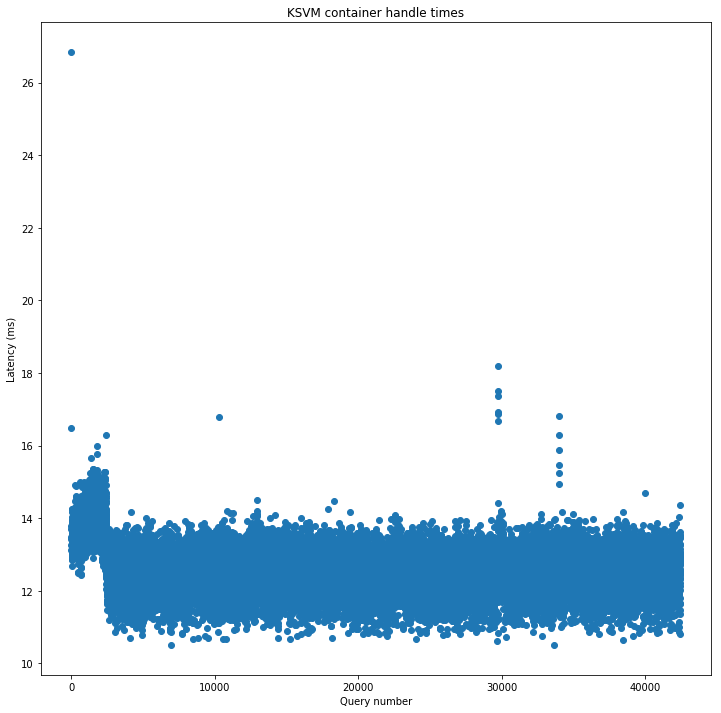

In [180]:
plt.figure(figsize=(12,12))
plt.title("KSVM container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.scatter(np.arange(ksvm_handle_times2.shape[0]), ksvm_handle_times2)

In [177]:
inception_handle_times = np.asarray([[49456.6336634, 91618.2031339], [40701.4059406, 26695.4830659], [40803.2376238, 23163.0191735], [40529.5940594, 24000.9486336], [40739.2673267, 24312.7005818], [40828.8712871, 22850.420821], [40833.9009901, 26179.0865166], [39225.2871287, 20034.3015348], [41198.4356436, 28081.2577898], [41113.3366337, 28868.5990295], [40997.8316832, 23176.3076618], [41057.8118812, 18552.4117082], [40840.960396, 26945.9745008], [39070.6930693, 19252.3204289], [40755.4851485, 26481.1246297], [39303.9306931, 26021.7880046], [40408.5643564, 37929.3758442], [35397.8019802, 23370.1606929], [33510.2178218, 18528.6699862], [35055.1782178, 25738.320734], [35439.019802, 26370.288614], [34962.4455446, 19916.9190808], [34105.1287129, 18339.4185973], [35370.5841584, 26463.2925551], [33111.1881188, 18058.3139267], [35173.5346535, 25955.4806107], [35125.4554455, 25304.4414641], [35250.8613861, 25762.6092373], [33265.3267327, 18260.4636186], [35458.8712871, 22500.6630686], [34764.4752475, 21873.6119006], [33158.4059406, 18510.4210885], [35598.6732673, 26147.3910476], [34979.8019802, 25804.0411172], [32622.9108911, 18157.1421335], [35279.980198, 19081.2366616], [35676.4257426, 24797.4993698], [32953.0891089, 18194.9038465], [36050.0891089, 26648.6397186], [35357.1386139, 22650.7897128], [35216.049505, 27317.0484599], [33169.4653465, 18326.3898691], [35079.049505, 23805.6881148], [34042.6039604, 16654.2065385], [33084.7524752, 13861.7483392], [35085.9207921, 25273.0584669], [35507.970297, 24965.098061], [35125.2871287, 24334.363422], [33457.0990099, 17734.2376135], [35117.5148515, 24493.5979268], [34957.5346535, 21697.6290522], [33363.0594059, 17911.7573356], [35324.6237624, 25801.034252], [35793.039604, 25369.2294407], [35491.970297, 24864.993443], [33404.3861386, 18265.7144399], [33871.8415842, 20528.5746911], [35169.8118812, 22336.5004039], [33117.7920792, 18559.8297642], [35320.2178218, 22418.0013323], [35417.1881188, 25679.0541915], [33456.3861386, 18018.5488218], [35558.2277228, 24443.3396131], [34771.5049505, 22939.352933], [33379.029703, 18171.0408152], [35343.0990099, 25732.1021158], [35120.7128713, 25930.0155828], [34456.2970297, 25663.7244943], [33429.8910891, 17755.0618112], [35641.2772277, 22341.8154302], [35074.7722772, 25558.6852843], [33523.0792079, 18360.5313663], [35616.7128713, 25421.8479364], [35066.0693069, 22110.4697028], [34099.8217822, 18712.1654807], [35177.6138614, 25821.8537761], [35535.6930693, 25336.8015207], [35171.6633663, 25053.1628367], [33466.7326733, 17701.0361194], [35175.8019802, 24014.8700444], [33161.4950495, 17684.4065824], [35225.2079208, 25358.4934241], [35710.5049505, 27215.3585052], [33383.8019802, 18580.4866108], [35587.7326733, 26186.6668904], [35431.9009901, 25900.8259219], [35139.4653465, 22195.4917127], [33754.3267327, 17995.794259], [36098.6831683, 26671.8663656], [34735.039604, 23530.1934468], [33179.3168317, 17894.4815637], [34754.5643564, 23779.9379544], [35224.4356436, 26114.1284811], [33483.3564356, 18892.9287519], [35363.3762376, 25275.3159434], [35262.0, 25897.7664242], [33821.7524752, 18855.7585371], [34953.8514851, 25026.2152973], [35587.4554455, 25358.941353], [33134.5940594, 18034.6307569], [35456.3861386, 26160.7482055], [34909.1386139, 25069.5919049], [33744.980198, 14453.5061757], [34986.5247525, 25505.0000641], [35872.5742574, 22310.938565], [33896.3366337, 18963.2483407], [33162.8811881, 18533.8112356], [35204.7920792, 22356.1449343], [35017.1485149, 25067.2264514], [33570.4653465, 18368.6355091], [35159.8712871, 25534.2769074], [35295.2079208, 25233.4104818], [33403.1089109, 18556.814529], [35512.5643564, 25398.1907142], [35813.7029703, 25633.2686734], [34949.4950495, 25679.3639852], [33133.7920792, 17432.2279492], [35189.1089109, 25748.5124153], [35368.1683168, 25418.8795611], [32940.9405941, 14049.9805016], [35491.0693069, 25077.7018758], [35605.3960396, 18835.6350129], [33866.7920792, 18036.245323], [35556.2970297, 25153.7203404], [35480.5049505, 25636.6672729], [33027.970297, 18040.0949414], [35476.9108911, 25478.1444481], [35340.6633663, 23921.7434645], [34697.8910891, 25639.9222056], [33424.6732673, 16885.2436022], [34835.9207921, 22524.680673], [35014.0990099, 24211.1144126], [32985.6039604, 17933.5743844], [34781.4950495, 22494.8358459], [35243.1089109, 25494.7292817], [33247.3168317, 18138.5969536], [34900.6435644, 25392.5272829], [35092.2475248, 25474.6018826], [35072.4356436, 23538.4440208], [33144.7029703, 14428.2311449], [35090.3168317, 24813.5800865], [35421.2178218, 23561.6329393], [33486.3267327, 18499.2842517], [35218.6831683, 21987.6635889], [34925.970297, 25400.3939793], [33722.0990099, 17552.4735136], [34618.6039604, 23457.4201577], [35339.6732673, 19801.693771], [33227.7128713, 17757.1616674], [35265.3069307, 25179.9849762], [34876.4158416, 25253.6653033], [35765.6336634, 25524.4019252], [33443.0792079, 18218.8271898], [35189.4158416, 21720.2628557], [36028.4653465, 26552.6360346], [33156.8910891, 18035.1124073], [35490.4455446, 22246.0309364], [35164.0693069, 26042.3688917], [33254.1386139, 18099.9528111], [34763.8613861, 24789.7243232], [35179.5049505, 25912.6580826], [35586.990099, 24865.0090568], [33251.8712871, 18154.9069927], [35720.4356436, 25750.1630053], [35396.5940594, 25827.9303952], [33780.3564356, 18814.8038815], [35927.5544554, 26341.8159761], [34614.4653465, 21743.4703022], [33371.7623762, 18276.7117388], [35149.7623762, 22489.704349], [35221.0594059, 25593.7461923], [33876.4257426, 18038.0518214], [35445.2277228, 25905.42325], [35203.5742574, 24859.1624921], [35228.1782178, 24454.6458258], [33449.039604, 18241.7558962], [35355.2277228, 25340.0277266], [35720.0594059, 27749.3570882], [33373.8613861, 18365.1118534], [35351.019802, 25708.7193857], [35551.9405941, 24866.8058668], [34495.3168317, 25764.8968425], [35008.6237624, 25228.6564548], [33212.4059406, 17551.9291418], [35155.3762376, 22932.8354928], [35009.6534653, 22331.8834562], [33402.1980198, 18422.8987587], [35091.019802, 25900.5766165], [35455.4455446, 25854.2796249], [33057.0792079, 15818.6600762], [35494.0990099, 25519.0135923], [35265.0693069, 25503.6934465], [33339.6930693, 18207.5792981], [35271.8019802, 25713.786891], [35329.3564356, 21908.2965001], [35305.2475248, 25485.1560781], [33610.6237624, 20154.7655244], [34749.1089109, 25626.7313565], [35127.970297, 22732.2278551], [32928.1089109, 17602.3065207], [35363.7227723, 25570.7018874], [35338.5049505, 22536.7039775], [35813.2079208, 19681.5970526], [33348.7821782, 18438.5056849], [35456.6534653, 25422.9825133], [35290.0792079, 25632.8979733], [33377.1089109, 18175.8445914], [34967.1287129, 24980.2678868], [35334.9009901, 24947.964801], [33076.5742574, 18377.6338237], [35312.0990099, 26200.4003316], [35092.2673267, 25804.6229283], [35008.8514851, 24503.7696907], [33427.0594059, 18567.2152739], [35484.2673267, 22665.6372358], [35583.7227723, 24219.0787457], [35331.6039604, 22806.4184335], [33541.9009901, 16382.8894999], [35381.990099, 27362.4127705], [35285.0792079, 25061.867662], [33376.6237624, 14739.0099482], [34949.6435644, 25396.2993662], [35208.2871287, 25384.2413192], [34928.7227723, 25325.8266309], [33391.8712871, 12609.0072745], [35275.8019802, 20916.4921779], [34946.8316832, 25847.2839564], [33431.6930693, 17929.2631534], [35386.7524752, 22578.5666351], [35005.6633663, 25258.6071789], [33046.6336634, 18039.8181659], [35679.5841584, 26767.4121386], [35116.7722772, 24908.2598567], [33200.3960396, 12593.393139], [34637.7722772, 22180.6040566], [33216.5841584, 18091.4456779], [34738.9405941, 22938.4338904], [34972.4059406, 23021.2847532], [34642.980198, 25716.1870216], [33381.3069307, 18213.1058545], [35067.2277228, 25679.9473508], [35490.5346535, 25622.705529], [33399.8811881, 17572.6150678], [35313.009901, 25664.1799994], [34621.3960396, 24605.3170138], [33700.4059406, 18012.9982525], [34938.6732673, 25243.917548], [35388.8910891, 25316.8519424], [33339.3960396, 18540.8144817], [34972.6237624, 24655.7265326], [35154.8415842, 18849.8581116], [35068.7524752, 25773.4358012], [33474.5841584, 18625.314122], [35365.3069307, 25546.4046626], [35031.3168317, 25393.6365662], [32726.950495, 17889.003158], [35123.9405941, 24427.4555201], [35393.9306931, 22632.8314541], [33627.1584158, 17702.4988714], [35525.1881188, 25454.2329043], [35404.4455446, 25823.8830192], [33600.9108911, 18224.4120991], [35207.7029703, 24475.1152849], [35214.7128713, 25648.3498816], [33347.0792079, 18045.699267], [35017.4851485, 25694.6980233], [35011.6534653, 25461.8951989], [33414.2277228, 19087.6998142], [35541.4257426, 25886.2333799], [35076.1188119, 25007.3161629], [33548.2178218, 13900.8108835], [35182.8910891, 23654.4952268]])/1000.

<Container object of 3 artists>

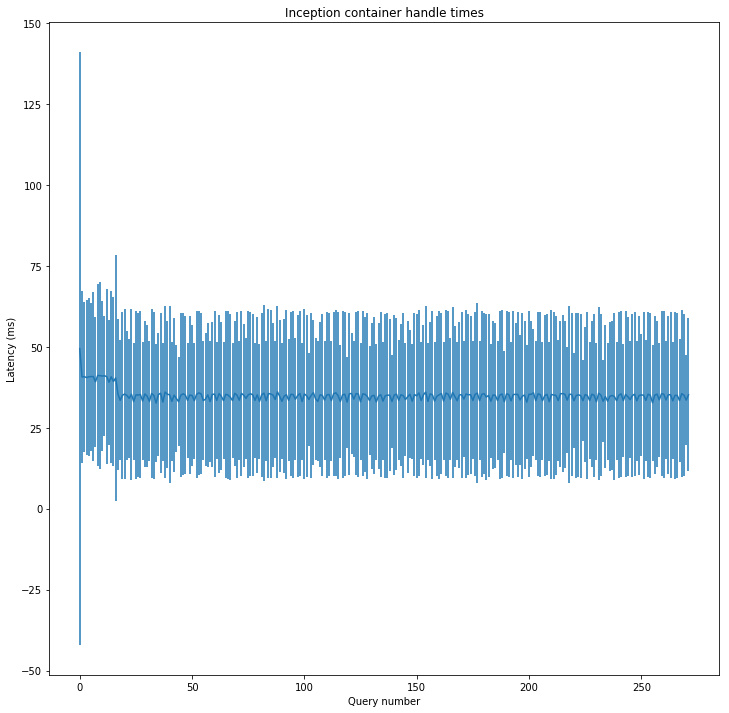

In [178]:
plt.figure(figsize=(12,12))
plt.title("Inception container handle times")
plt.xlabel("Query number")
plt.ylabel("Latency (ms)")
plt.errorbar(np.arange(inception_handle_times.shape[0]), inception_handle_times[:,0], inception_handle_times[:,1])